# Notes - Important !!!!
- for the love of God Standardize Inputs or set learning rate to something really really small first !! 
    - the squared error only worked with 0.000001
- check in what way is the derivative computed !! 
    - last time the lLik has been calculated such that adjustments shoul have been "weights += something"
    - and the squared error should have been "weights -= something"
    

In [1]:
# load packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# classes and functions from 'util'
from util.data_load import returns_load
from util.GarchEstimator import GarchEstimator
from util.DescStat import DescStat
# from util.ANN_core import NeuralNetwork

In [3]:
from util.ANN_core import lLik

In [4]:
np.random.seed(1995)

In [5]:
start_dt = '2000-01-01'
end_dt = '2020-03-01'
ticker = 'MSFT' 
interval = '1d'
garch_init = {
    'alpha' : 0.7,
    'beta1' : 0.3,
    'beta2' : 0.1,
    'omega1' : 0.01,
    'omega2' : 0.01,
    'omega3' : 0.01
}

In [6]:
ret_data = returns_load(ticker=ticker,
                    interval=interval,
                    start_dt=start_dt,
                    end_dt=end_dt)

[*********************100%***********************]  1 of 1 completed


In [7]:
garch =  GarchEstimator(theta_init = garch_init)

In [8]:
ret_data['garch'] = garch.fit_data(
    method='GARCH',
    data_estimate=ret_data['return']*100,
    data_fit=ret_data['return']*100
    
)
print(garch.get_estimates(coef=True, llik=True))

`xtol` termination condition is satisfied.
Number of iterations: 465, function evaluations: 3038, CG iterations: 1361, optimality: 5.55e-04, constraint violation: 0.00e+00, execution time: 3.3e+02 s.
Model recalculated!
 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 1361
      cg_stop_cond: 4
            constr: [array([1.72537362e-01, 1.10906902e-01, 8.65658474e-02, 7.80671466e-06,
       4.79330203e-01, 2.81250032e-01])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 327.00084686279297
               fun: 9766.09531323833
              grad: array([-4.02832031e-03, -3.41796875e-03, -4.88281250e-03,  5.17895508e+00,
       -2.80761719e-03, -7.56835938e-03])
               jac: [<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-1.16451627e-04, -4.1531

C:\Users\sskor\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


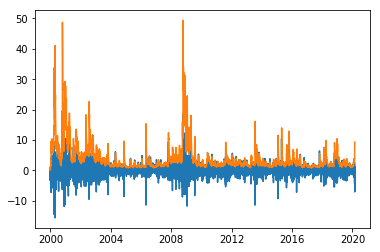

In [9]:
x = ret_data['dt']
y1 = ret_data['return']*100
y2 = ret_data['garch']
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()

In [10]:
desc_obj = DescStat(data=ret_data['return']*100)

In [11]:
ret_data_enriched = pd.DataFrame({
    'dt': ret_data['dt'],
    'return100' : ret_data['return']*100,
    'garch': ret_data['garch'],
    'mean5_return100': desc_obj.calc_mean(window=5, fill_initial='first_constant'),
    'var5_return100': desc_obj.calc_var(window=5, fill_initial='first_constant'),
})

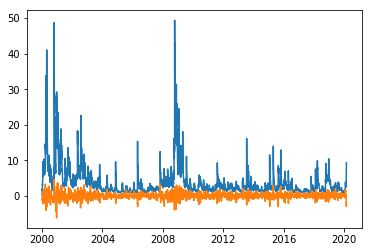

In [12]:
x = ret_data_enriched['dt']
y1 = ret_data_enriched['return100']
y2 = ret_data_enriched['garch']
y3 = ret_data_enriched['mean5_return100']
y4 = ret_data_enriched['var5_return100']
# plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

In [13]:
ret_data_enriched.head()

dt  return100     garch  mean5_return100  var5_return100
0 2000-01-03  -0.160600  0.100000        -0.905444        5.344588
1 2000-01-04  -3.378016  0.100000        -0.905444        5.344588
2 2000-01-05   1.054384  0.100000        -0.905444        5.344588
3 2000-01-06  -3.349808  1.359696        -0.905444        5.344588
4 2000-01-07   1.306818  1.589353        -0.905444        5.344588

In [14]:
ret_data_enriched.shape

(5071, 5)

In [15]:
ret_data_enriched.dropna(inplace=True)
ret_data_enriched.shape

(5071, 5)

In [107]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x)*(1-sigmoid(x))

def linear(x):
    return(x)

def linear_der(x):
    return np.ones(x.shape)

def lLik(obs_val, sigma_pred):

    LLik = -(1/2) * np.log(2 * np.pi) - (1/2) * np.log(sigma_pred ** 2) - (1/2) * ((obs_val** 2) / sigma_pred ** 2)

    return LLik	

def lLik_der(obs_val, sigma_pred):
    
    LLik_der = - 1 / sigma_pred + (1 / sigma_pred ** 3) * (obs_val ** 2)
    
    return LLik_der

In [142]:
np.random.seed(42)
weights = np.random.rand(3,1)
bias = np.random.rand(1,1)
lr = 0.00001

In [143]:
feature_set = ret_data_enriched.iloc[:, 2:5]
labels = ret_data_enriched.iloc[:, 1:2]

In [144]:
for epoch in range(100):
    inputs = feature_set

    # feedforward step1
    XW = np.dot(feature_set, weights) + bias

    #feedforward step2
    z = linear(XW)

    # backpropagation step 1
#     error = z - labels
    error = lLik(labels, z)
    error_der = lLik_der(labels, z)
    print(error.sum())

    # backpropagation step 2
    dcost_dpred = error_der
    dpred_dz = linear_der(z)

    z_delta = dcost_dpred * dpred_dz

    inputs = feature_set.T
    weights += lr * np.dot(inputs, z_delta)
    bias += lr * np.dot(np.ones((1, z_delta.shape[0])),  z_delta)
    
print(weights)
print(bias)

return100   -11132.755247
dtype: float64
return100   -11012.270826
dtype: float64
return100   -10922.628886
dtype: float64
return100   -10846.690167
dtype: float64
return100   -10770.648132
dtype: float64
return100   -10694.274198
dtype: float64
return100   -10617.708006
dtype: float64
return100   -10541.115945
dtype: float64
return100   -10464.679808
dtype: float64
return100   -10388.592192
dtype: float64
return100   -10313.053145
dtype: float64
return100   -10238.26599
dtype: float64
return100   -10164.432964
dtype: float64
return100   -10091.75099
dtype: float64
return100   -10020.40797
dtype: float64
return100   -9950.579911
dtype: float64
return100   -9882.429
dtype: float64
return100   -9816.102565
dtype: float64
return100   -9751.732685
dtype: float64
return100   -9689.436159
dtype: float64
return100   -9629.314542
dtype: float64
return100   -9571.454049
dtype: float64
return100   -9515.925253
dtype: float64
return100   -9462.782598
dtype: float64
return100   -9412.06387
dtype: 

In [214]:
# =============================================================================
# define sigmoid function
# =============================================================================

def sigmoid(x):
    
    return 1/(1+ np.exp(-x))

# =============================================================================
# define sigmoid derivative function
# =============================================================================

def sigmoid_der(x):
    
#     return sigmoid(x) * (1 - sigmoid(x))
    return x * (1 - x)

# =============================================================================
# define log likelihood function
# =============================================================================

def lLik(obs_val, sigma_pred):

    LLik = -(1/2) * np.log(2 * np.pi) - (1/2) * np.log(sigma_pred ** 2) - (1/2) * ((obs_val** 2) / sigma_pred ** 2)

    return LLik	

# =============================================================================
# define derivation of log likelihood
# =============================================================================

def lLik_der(obs_val, sigma_pred):
    
    LLik_der = - 1 / sigma_pred + (1 / sigma_pred ** 3) * (obs_val ** 2)
    
    return LLik_der

# =============================================================================
# define squared errors
# =============================================================================

def square_error(obs_val, obs_pred):
    
    return (obs_val - obs_pred) ** 2

# =============================================================================
# define first derivative of squared errors
# =============================================================================
    
#in this case should be multiplied by -1 since with respect to obs_pred, but then 
#change in weights and biases is not += but -=
def square_error_der(obs_val, obs_pred):
    
    return  (obs_val - obs_pred)

# =============================================================================
# define linear function for case when only one layer
# =============================================================================
def linear(x):
    
    return x

# =============================================================================
# define derivative of linear 
# =============================================================================
def linear_der(x):
        
    return np.ones(x.shape)
# =============================================================================
# class object NeuralNetwork
# =============================================================================
    
class NeuralNetwork:

    def __init__(self, x, y, obj_fun = square_error, node_fun = linear,
                 hidden_layer = 1, step_rate = 0.001, bias = False, num_nodes = [1,0]):
        
        self.nodes1     = num_nodes[0]
        
        self.nodes2     = num_nodes[1]
        
        if obj_fun == square_error :
            
            self.obj_fun = square_error
            
            self.obj_fun_der = square_error_der
        
        elif obj_fun == lLik :
            
            self.obj_fun = lLik
            
            self.obj_fun_der = lLik_der
            
        else :
            
            print('set objective function to either squared errors or log-likelihood')
        
        self.input      = x
        
        self.y          = y

        self.output     = np.ones(self.y.shape)
        
        self.step_rate = step_rate
        
        self.bias = bias * 1
        
        if hidden_layer == 0 :
            
            self.weights_out = self.weights_hidden = np.ones([1,1])
            
            self.weights_input = np.random.rand(self.input.shape[1], 1)
            
            self.bias_out = self.bias_hidden = self.bias_input = np.zeros([1,1])
            
            self.node1_fun = linear
            
            self.node1_fun_der = linear_der
            
            self.node2_fun = linear
            
            self.node2_fun_der = linear_der
        
        elif hidden_layer == 1 :
            
            self.weights_out = np.ones([1,1])
            
            self.weights_hidden = np.random.rand(self.nodes1, 1)
            
            self.weights_input = np.random.rand(self.input.shape[1], self.nodes1)
            
            self.bias_out = self.bias_hidden = np.zeros([1,1])
            
            self.bias_input = np.zeros([1, self.nodes1])
            
            self.node1_fun = node_fun
            
            if node_fun == linear :
                
                self.node1_fun_der = linear_der
                
            elif node_fun == sigmoid :
                
                self.node1_fun_der = sigmoid_der
            
            self.node2_fun = linear
            
            self.node2_fun_der = linear_der
            
        elif hidden_layer == 2 :
            
            self.weights_out = np.random.rand(self.nodes2, 1)
            
            self.weights_hidden = np.random.rand(self.nodes1, self.nodes2)
            
            self.weights_input = np.random.rand(self.input.shape[1], self.nodes1)
            
            self.bias_out = np.zeros([1,1])
            
            self.bias_hidden = np.zeros([1, self.nodes2])
            
            self.bias_input = np.zeros([1, self.nodes1])
            
            self.node1_fun = self.node2_fun = node_fun
            
            if node_fun == linear :
                
                self.node1_fun_der = self.node2_fun_der = linear_der
                
            elif node_fun == sigmoid :
                
                self.node1_fun_der = self.node2_fun_der = sigmoid_der
                
            else:
                
                print('set the node function to either sigmoid or linear')
                
        else:
            
            print('set number of hidden layers to 0, 1 or 2')
            
    def feedforward(self):
        
        
        self.layer1 = self.node1_fun(np.dot(self.input, self.weights_input) + self.bias_input)
        
        self.layer2 = self.node2_fun(np.dot(self.layer1, self.weights_hidden) + self.bias_hidden)
        
        self.output = np.dot(self.layer2, self.weights_out) + self.bias_out
        
    def backprop(self):
        
        #calculate errors and partial derivatives
        
        error_out = self.obj_fun_der(self.y, self.output)
        
        print(error_out.head())
        
        d_weights_out = np.dot(self.layer2.T, error_out) 
        
        print(d_weights_out)
        
        error_hidden = np.dot(error_out, self.weights_out.T) * self.node2_fun_der(self.layer2) # this is derivative in terms of f(x) maybe should change to derivative in terms of x, then it needs to be layer1*weights_hidden
        
        print(error_hidden[1:5])
        
        d_weights_hidden = np.dot(self.layer1.T, error_hidden) 
        
        print(d_weights_hidden)
        
        error_input = np.dot(error_hidden, self.weights_hidden.T) * self.node1_fun_der(self.layer1)
        
        print(error_input[1:5])
        
        d_weights_input = np.dot(self.input.T, error_input)
        
        print(d_weights_input)
        
        d_bias_out = np.dot(np.ones(self.output.shape[0]), error_out) 
        
        d_bias_hidden = np.dot(np.ones(self.layer2.shape[0]), error_hidden)
        
        d_bias_input = np.dot(np.ones(self.input.shape[0]), error_input)
        
        #update weights and biases
        
        self.weights_out += d_weights_out * self.step_rate * (self.nodes2 > 0)
        
        self.weights_hidden += d_weights_hidden * self.step_rate * (self.nodes1 > 0) 
        
        self.weights_input += d_weights_input * self.step_rate
        
        self.bias_out += d_bias_out * self.step_rate * self.bias * (self.nodes2 > 0)
        
        self.bias_hidden += d_bias_hidden * self.step_rate * self.bias * (self.nodes1 > 0)
        
        self.bias_input += d_bias_input * self.step_rate * self.bias
    
    def cost(self):
        return np.sum(self.obj_fun(self.y, self.output))
    def get_output(self):
        return self.output
        
    def get_observed(self):
        return self.y
    def get_layer1(self):
        return self.layer1
    def get_layer2(self):
        return self.layer2
    def get_weights(self):
        return [self.weights_input, self.weights_hidden, self.weights_out]
    def get_input(self): 
        return self.input
#    def change_data(self, new_x, new_y):
#        self.x = new_x
#        self.y = new_y


In [261]:
NN_obj = NeuralNetwork(
    x=ret_data_enriched.iloc[:,2:5],
    y=ret_data_enriched.iloc[:,1:2],
    obj_fun=lLik,
    hidden_layer=2,
    node_fun=sigmoid,
    num_nodes=[4, 4],
    step_rate=0.0001
)

In [266]:
NN_obj.feedforward()
for i in range(5000) :
        NN_obj.backprop()
        NN_obj.feedforward()

   return100
0  -0.275843
1  -0.035464
2  -0.252915
3  -0.029592
4  -0.244440
[[315.22753729]
 [236.88794198]
 [159.73249775]
 [211.83796088]]
[[ 1.31549598e-03 -1.84110839e-04 -2.11065671e-02 -1.35943448e-02]
 [ 9.38151171e-03 -1.31299374e-03 -1.50522320e-01 -9.69486088e-02]
 [ 1.06128702e-03 -1.53331663e-04 -1.85003837e-02 -1.16509608e-02]
 [ 8.75438559e-03 -1.26675667e-03 -1.53783758e-01 -9.65172762e-02]]
[[ -1.80906897   0.31077057  35.44446166  21.9987698 ]
 [ -9.09484066   1.72815608 269.1796051  172.29698842]
 [-11.29554287   1.80894009 264.22884095 173.97113153]
 [-11.55800489   1.83176408 266.59251645 175.99850779]]
[[-1.36211177e-05  2.74006902e-03 -3.56223339e-03 -1.28990583e-03]
 [-9.71395405e-05  1.95409108e-02 -2.54042086e-02 -9.19901455e-03]
 [-3.87818600e-04  4.60789303e-05 -2.75270918e-03 -1.10309115e-03]
 [-6.00044634e-03  1.84602810e-04 -2.23573962e-02 -9.12850095e-03]]
[[ 69.21870504  18.14249572 187.11218336 200.91039671]
 [ 10.22506415  -1.48975626   0.51319397   

 [ 9.39493023e-03 -9.43788925e-04 -1.61552889e-01 -1.01278815e-01]]
[[-7.04984374e+00  5.74982349e-01  8.54940677e+01  6.36337679e+01]
 [-1.45198799e+02  1.00213451e+01  1.37175832e+03  1.19601704e+03]
 [-9.80561379e+01  7.00039355e+00  1.00167052e+03  8.44685202e+02]
 [-9.74281619e+01  6.97888385e+00  1.00456552e+03  8.43954122e+02]]
[[-9.28268007e-06  2.02368268e-03 -2.85019396e-03 -1.01650848e-03]
 [-9.28629262e-05  2.02447024e-02 -2.85130317e-02 -1.01690408e-02]
 [-2.34476262e-04  2.70980155e-05 -1.92563023e-03 -7.63120801e-04]
 [-6.07087986e-03  1.78100360e-04 -2.60937487e-02 -1.05426063e-02]]
[[ 249.79744172   -9.90721644 1562.21731351 1640.8670352 ]
 [  30.51064594   -3.30613981   57.91820165   70.90861015]
 [ 270.30487684  -10.16952458  680.11264367  675.09947421]]
   return100
0  -0.231047
1  -0.090040
2  -0.217597
3  -0.090213
4  -0.212320
[[-1452.35968592]
 [-1036.92594484]
 [ -471.20223396]
 [ -753.80338422]]
[[ 0.00245853 -0.00330656 -0.04492967 -0.03083851]
 [ 0.00594149 

[[2288.11916891]
 [1585.83213756]
 [ 572.39652848]
 [ 983.59796668]]
[[ 0.00123966 -0.00021847 -0.0194811  -0.01262779]
 [ 0.01002916 -0.00176746 -0.157607   -0.10216202]
 [ 0.00094522 -0.00017126 -0.01602137 -0.01016705]
 [ 0.00941465 -0.00170764 -0.16068737 -0.10164305]]
[[-7.02208759e+00  1.01500044e+00  8.20274341e+01  6.21812994e+01]
 [-1.52683852e+02  1.87608362e+01  1.39943376e+03  1.23255916e+03]
 [-1.01843249e+02  1.29391255e+01  1.00882749e+03  8.59637624e+02]
 [-1.01659221e+02  1.29548525e+01  1.01578052e+03  8.62566538e+02]]
[[-1.04626278e-05  2.44351354e-03 -3.64791795e-03 -1.24892549e-03]
 [-8.46453016e-05  1.97686417e-02 -2.95125775e-02 -1.01041226e-02]
 [-3.08194918e-04  3.42314543e-05 -2.75025986e-03 -1.04291759e-03]
 [-5.86180198e-03  1.62026671e-04 -2.71485248e-02 -1.04895021e-02]]
[[ 245.83482667  -11.230434   1651.00617905 1717.40240513]
 [  31.18205174   -3.33822154   64.26561157   75.68684944]
 [ 260.17105808  -10.33477775  711.19362465  698.70170364]]
   return1

   return100
0  -0.263157
1  -0.054553
2  -0.243260
3  -0.051184
4  -0.235890
[[-274.82324627]
 [-180.88075868]
 [   2.70483007]
 [ -54.88805879]]
[[ 0.00195046 -0.00114309 -0.03319277 -0.0214415 ]
 [ 0.00869741 -0.00509724 -0.14801202 -0.0956112 ]
 [ 0.00177385 -0.00107228 -0.03253212 -0.02057908]
 [ 0.00816217 -0.00494238 -0.1507602  -0.09505982]]
[[-3.61008106e-02  4.05756682e-01  1.09424828e+01  4.42789444e+00]
 [ 2.58266937e+01 -7.36069230e+00 -1.01188392e+02 -1.48286138e+02]
 [ 1.28036572e+01 -2.82869407e+00 -6.77416732e+00 -5.31075511e+01]
 [ 1.25171807e+01 -2.75922738e+00 -6.65224051e+00 -5.19598032e+01]]
[[-1.67010758e-05  4.05689416e-03 -5.89607005e-03 -1.92288837e-03]
 [-7.44728443e-05  1.80903584e-02 -2.62915463e-02 -8.57447555e-03]
 [-6.11564419e-04  6.42847702e-05 -5.01472759e-03 -1.79972173e-03]
 [-5.41682254e-03  1.39292796e-04 -2.26394305e-02 -8.27087498e-03]]
[[  -2.50681534   22.15362843 -220.64127598 -224.6855532 ]
 [   3.48415344   -0.87949099  -13.51156938   -9.60

4  -0.242430
[[1594.78723538]
 [1058.76432356]
 [ 416.6559104 ]
 [ 696.66358121]]
[[ 0.00158563 -0.00058885 -0.02542756 -0.01650569]
 [ 0.00984577 -0.00365637 -0.1578889  -0.10248978]
 [ 0.00134258 -0.00051291 -0.02312601 -0.014709  ]
 [ 0.00924933 -0.00353831 -0.16041627 -0.10170516]]
[[  -5.1690224     1.63578252   63.88798797   47.79116376]
 [-100.1695367    26.86073634 1005.6428211   862.82376184]
 [ -69.06937535   19.2005726   750.98782347  622.94815687]
 [ -70.05487254   19.49317009  764.71266121  633.38118021]]
[[-1.22762374e-05  3.09032787e-03 -5.02849479e-03 -1.54748221e-03]
 [-7.62275926e-05  1.91889620e-02 -3.12237405e-02 -9.60887599e-03]
 [-4.34142413e-04  4.33454121e-05 -4.12218377e-03 -1.39278916e-03]
 [-5.79712115e-03  1.39409361e-04 -2.80527154e-02 -9.64313981e-03]]
[[ 183.43674314   -3.46304772 1104.66453818 1120.2410948 ]
 [  24.50460437   -2.57127857   39.79826178   47.21774552]
 [ 202.19424757   -6.98171797  506.01898825  482.29548549]]
   return100
0  -0.236096
1  

4  -0.234125
[[-63.1592046 ]
 [-37.91740757]
 [ 48.64951841]
 [ 32.33792519]]
[[ 0.00214695 -0.00137441 -0.0355518  -0.02340722]
 [ 0.00893714 -0.00572126 -0.14799172 -0.09743738]
 [ 0.00198023 -0.00130585 -0.03521299 -0.02270627]
 [ 0.00840743 -0.00555346 -0.1505422  -0.0967577 ]]
[[ -0.55742986   0.64203585  14.61103779   8.65253605]
 [ 12.23887241  -2.24765316  29.13390842 -27.10599559]
 [  3.93324807   0.74498065  79.70021881  26.49595013]
 [  3.64532048   0.8302449   80.40694777  27.91605991]]
[[-1.61233954e-05  4.25624415e-03 -7.01743458e-03 -2.01707512e-03]
 [-6.71169602e-05  1.77174945e-02 -2.92115195e-02 -8.39649138e-03]
 [-6.39957965e-04  6.21421845e-05 -6.09327698e-03 -1.91782195e-03]
 [-5.29780549e-03  1.22194641e-04 -2.54248501e-02 -8.13856880e-03]]
[[ 14.13541261  17.26087801 -67.75771619 -65.23511007]
 [  6.41907865  -1.08591167  -6.93801712  -2.6744157 ]
 [ 41.44646985   1.70898446 -15.22654727  -6.28375699]]
   return100
0  -0.259986
1  -0.058858
2  -0.240802
3  -0.055

 [ -69.79531784   22.06507919  730.40007815  604.47204422]]
[[-1.52130121e-05  3.70382529e-03 -7.07260742e-03 -1.84458978e-03]
 [-7.52135586e-05  1.83118161e-02 -3.49671695e-02 -9.11970358e-03]
 [-6.08477044e-04  5.00076958e-05 -6.16295758e-03 -1.75049417e-03]
 [-6.25440386e-03  1.20425857e-04 -3.19644404e-02 -9.22340782e-03]]
[[ 122.60509288   -3.52017799 1151.48627759 1139.92121004]
 [  25.3255128    -2.49141538   43.02173768   49.10570799]
 [ 108.10824606   -6.63548967  518.9876438   480.10131125]]
   return100
0  -0.232755
1  -0.088588
2  -0.219004
3  -0.088767
4  -0.213597
[[-1389.1431978 ]
 [ -889.00137621]
 [ -381.89909751]
 [ -626.5743196 ]]
[[ 0.00275812 -0.00358825 -0.04729954 -0.03351095]
 [ 0.0068185  -0.00887072 -0.11693195 -0.08284436]
 [ 0.00267168 -0.00359692 -0.04933173 -0.03414876]
 [ 0.0064141  -0.00865608 -0.11938531 -0.08231521]]
[[   2.85884044   -2.48484048  -46.65621076  -34.31262049]
 [  72.51980576  -64.69480002 -996.19944876 -814.74535971]
 [  48.81438372  -4

4  -0.206825
[[-1441.56926675]
 [ -910.10001941]
 [ -425.39208355]
 [ -682.37608613]]
[[ 0.00265351 -0.00486614 -0.0492411  -0.03532912]
 [ 0.0058265  -0.01068494 -0.1081223  -0.07757476]
 [ 0.00257501 -0.00488513 -0.05172583 -0.03613995]
 [ 0.00551094 -0.01047815 -0.11225559 -0.07788405]]
[[    2.17082594    -2.65222676   -41.68162235   -30.38107635]
 [   64.72493624   -83.35208621 -1085.40428062  -862.08707505]
 [   44.90969082   -59.10678005  -791.04901     -615.21290045]
 [   45.63866663   -60.29820403  -810.78620768  -628.23980372]]
[[-3.65170020e-05  5.78058179e-03 -8.94726484e-03 -2.20380677e-03]
 [-8.01830718e-05  1.26928493e-02 -1.96461686e-02 -4.83906090e-03]
 [-1.69170567e-03  8.34054966e-05 -7.24119778e-03 -1.93901336e-03]
 [-7.15755361e-03  8.21370404e-05 -1.49554327e-02 -4.07103697e-03]]
[[-2.07121455e+02  3.23759670e+01 -1.07702011e+03 -1.08129306e+03]
 [-1.19447214e+01  2.91843270e-01 -3.99878712e+01 -3.83339218e+01]
 [-2.22256736e+02  9.74232108e+00 -5.06926410e+02 -4.

 [ 0.00946156 -0.00480955 -0.15649845 -0.1031479 ]]
[[  -5.88863098    2.40495034   67.51238712   51.83129684]
 [-150.8609261    51.39904218 1335.73208157 1170.42927701]
 [ -97.76657447   34.44082693  937.08344987  794.43233171]
 [-100.51091186   35.46902909  969.75238644  820.04511246]]
[[-3.62633237e-05  4.28762700e-03 -8.30650811e-03 -1.98817928e-03]
 [-1.49066050e-04  1.76249597e-02 -3.41451976e-02 -8.17272112e-03]
 [-1.62038636e-03  5.45366282e-05 -7.41538708e-03 -1.95956746e-03]
 [-1.43157570e-02  1.11528185e-04 -3.31532214e-02 -8.92574255e-03]]
[[ 166.41278328  -10.35478561 1729.0249557  1718.88060863]
 [  35.34726526   -2.96200615   66.73625456   69.97343014]
 [ 172.40286006   -9.43801865  769.53417109  700.34983277]]
   return100
0  -0.218293
1  -0.099424
2  -0.206955
3  -0.099739
4  -0.203427
[[-1448.64395247]
 [ -901.18517341]
 [ -441.04254401]
 [ -689.16793169]]
[[ 0.00269189 -0.00526198 -0.04899833 -0.03628787]
 [ 0.00560327 -0.01095299 -0.10199164 -0.07553439]
 [ 0.002615

4  -0.208744
[[-1379.54360215]
 [ -841.43171416]
 [ -364.50610288]
 [ -596.28556632]]
[[ 0.00289967 -0.00441909 -0.04924753 -0.03628064]
 [ 0.00645464 -0.00983684 -0.10962443 -0.08076028]
 [ 0.00280721 -0.00440867 -0.05196688 -0.03711318]
 [ 0.00616191 -0.00969299 -0.11659143 -0.08233649]]
[[   1.73204147   -1.52434425  -27.4337712   -20.67787609]
 [  70.22000041  -73.05646473 -993.66810243 -811.98478788]
 [  46.99083247  -49.84172794 -698.55425453 -559.34846998]
 [  48.05743029  -51.223378   -722.49582163 -575.84338819]]
[[-5.25824988e-05  5.81076947e-03 -9.43273912e-03 -2.09476859e-03]
 [-1.17048029e-04  1.29347051e-02 -2.09971673e-02 -4.66293046e-03]
 [-2.62403333e-03  7.88668903e-05 -8.05917609e-03 -1.94769344e-03]
 [-1.14731401e-02  7.92644392e-05 -1.73466243e-02 -4.26267986e-03]]
[[-1.58293011e+02  3.04974619e+01 -1.08517207e+03 -1.06813625e+03]
 [-7.10540200e+00  1.43549996e-01 -3.99554946e+01 -3.71474749e+01]
 [-1.63789839e+02  8.69236987e+00 -5.10506990e+02 -4.44925133e+02]]
 

4  -0.231844
[[2165.39458494]
 [1285.55698495]
 [ 496.54085463]
 [ 818.53525469]]
[[ 0.0028036  -0.00164696 -0.04139712 -0.0289202 ]
 [ 0.00975079 -0.00572804 -0.14397733 -0.10058317]
 [ 0.00253567 -0.00152093 -0.0406813  -0.02754332]
 [ 0.00941466 -0.00564822 -0.15439485 -0.10331878]]
[[  -5.45126011    2.62534233   61.65484522   47.72523626]
 [-148.82824395   60.20292131 1310.89424777 1144.39079954]
 [ -95.59818666   39.98015557  913.42239981  771.31887535]
 [ -99.88006249   41.80590495  958.73781751  808.25431604]]
[[-4.85556259e-05  4.90404269e-03 -9.87579417e-03 -2.03089075e-03]
 [-1.68874294e-04  1.70560410e-02 -3.43475702e-02 -7.06334715e-03]
 [-2.34673016e-03  5.94209343e-05 -9.10710895e-03 -2.04650460e-03]
 [-1.73818857e-02  1.00255787e-04 -3.40823444e-02 -7.78972023e-03]]
[[ 171.06336779   -9.96424341 1726.49951531 1675.15541268]
 [  36.14960037   -2.7200815    62.31214762   64.57042838]
 [ 188.32808468   -8.91362152  766.35435924  673.12167374]]
   return100
0  -0.214271
1  

[[ 0.00266214 -0.00646391 -0.04759297 -0.03856941]
 [ 0.00488866 -0.0118701  -0.08739811 -0.07082754]
 [ 0.00259697 -0.00651126 -0.0506632  -0.03971852]
 [ 0.0046651  -0.0117201  -0.09340768 -0.07223918]]
[[    1.70037495    -2.94825002   -41.41298025   -28.51897267]
 [   55.01736979   -98.23653597 -1206.02117446  -888.47823125]
 [   39.45911626   -72.1610513   -907.60705248  -655.75317041]
 [   40.78140653   -74.78330986  -943.47586717  -680.12755028]]
[[-5.43473903e-05  5.64295861e-03 -9.21646443e-03 -1.65411927e-03]
 [-9.98016852e-05  1.03625358e-02 -1.69247994e-02 -3.03756795e-03]
 [-2.84138554e-03  7.15596734e-05 -7.20501922e-03 -1.37346374e-03]
 [-1.02513295e-02  5.82455033e-05 -1.25006443e-02 -2.41375242e-03]]
[[-1.98595081e+02  2.96678093e+01 -1.12349513e+03 -1.07595662e+03]
 [-1.26392797e+01  3.50930276e-01 -4.17672134e+01 -3.76470769e+01]
 [-2.17675997e+02  9.20192610e+00 -5.35747549e+02 -4.46712806e+02]]
   return100
0  -0.230934
1  -0.090134
2  -0.217505
3  -0.088940
4  -0.

[[ 0.00319806 -0.00229858 -0.04689377 -0.03362821]
 [ 0.0093617  -0.00672865 -0.1372724  -0.09844004]
 [ 0.00298363 -0.00219214 -0.04761693 -0.03303559]
 [ 0.00904773 -0.00665145 -0.14804969 -0.10134083]]
[[ -2.76243476   1.82917218  35.97453602  27.04371357]
 [-49.52071896  27.38308029 570.69948611 454.28968992]
 [-34.67325292  19.9163514  433.28887127 334.25098528]
 [-37.44246088  21.32975009 461.37885567 357.54250213]]
[[-5.81577726e-05  5.53598439e-03 -1.22818516e-02 -2.01872011e-03]
 [-1.70245574e-04  1.62055182e-02 -3.59527330e-02 -5.90941069e-03]
 [-3.01411117e-03  6.47181923e-05 -1.14917150e-02 -2.01425059e-03]
 [-1.83489875e-02  8.83156518e-05 -3.50932303e-02 -6.22976804e-03]]
[[ 91.92794088   3.53594641 650.72870157 599.8289131 ]
 [ 24.76664237  -1.62410822  19.4185011   22.50538758]
 [118.99150856  -3.288023   318.80620786 266.23111682]]
   return100
0  -0.227017
1  -0.093280
2  -0.214261
3  -0.092374
4  -0.211513
[[-1082.55781903]
 [ -623.47991726]
 [ -232.22384818]
 [ -398

4  -0.217364
[[-389.62856789]
 [-220.86321556]
 [ -34.21418747]
 [ -96.87449096]]
[[ 0.00335438 -0.00321775 -0.05072791 -0.03724044]
 [ 0.00841879 -0.00807587 -0.1273162  -0.09346553]
 [ 0.00320366 -0.00314618 -0.05275356 -0.0374546 ]
 [ 0.00812516 -0.00798706 -0.13730495 -0.09614072]]
[[  -0.21416662    0.56421486    7.30674358    4.86239243]
 [  29.97319185  -16.66413817 -187.03806306 -198.60041016]
 [  16.09493114   -8.28720785  -79.68691638  -96.751444  ]
 [  16.83089075   -8.88807552  -91.55628866 -105.46629587]]
[[-6.14875331e-05  5.97852866e-03 -1.29987740e-02 -1.94447549e-03]
 [-1.54320556e-04  1.50048282e-02 -3.26241424e-02 -4.88021756e-03]
 [-3.30839212e-03  6.91043250e-05 -1.20738643e-02 -1.93027961e-03]
 [-1.69179819e-02  7.84309531e-05 -3.06811003e-02 -4.97048494e-03]]
[[ -23.97162363   16.18478999 -335.26604373 -300.44231438]
 [   9.79670864   -0.72164986  -15.16684531  -10.56720199]
 [ -11.92231266    2.24937758 -150.20803702 -104.55649033]]
   return100
0  -0.239920
1  

   return100
0  -0.213049
1  -0.102563
2  -0.202510
3  -0.102747
4  -0.200103
[[-1393.77257328]
 [ -773.4771996 ]
 [ -371.60394264]
 [ -572.43108838]]
[[ 0.00311562 -0.00536624 -0.05176924 -0.04078695]
 [ 0.00615179 -0.01059566 -0.10221849 -0.08053392]
 [ 0.00303681 -0.00537801 -0.05497837 -0.04187811]
 [ 0.00590457 -0.01047464 -0.10989309 -0.08248715]]
[[    1.72318199    -1.95913051   -30.95211587   -22.18376098]
 [   67.33689491   -82.70309353 -1037.21365772  -822.28113779]
 [   45.07687666   -56.4449172   -730.40410128  -567.41374834]
 [   47.45152255   -59.7220383   -778.29686678  -601.79410027]]
[[-6.11827884e-05  6.11831898e-03 -1.22752419e-02 -1.64520697e-03]
 [-1.20805564e-04  1.20806357e-02 -2.42374949e-02 -3.24846516e-03]
 [-3.38068590e-03  6.99606528e-05 -1.05310347e-02 -1.50196374e-03]
 [-1.33146098e-02  6.06072390e-05 -2.01585194e-02 -2.91263025e-03]]
[[-1.70234066e+02  2.69906774e+01 -1.16263088e+03 -1.06276249e+03]
 [-9.17429033e+00  1.47808824e-01 -4.34646430e+01 -3.63

 [ 0.00897392 -0.00730306 -0.14280346 -0.10074218]]
[[ -1.92244452   1.46297717  24.45612849  18.90597441]
 [-31.8356444   20.57092656 400.51822765 307.16667294]
 [-22.92494467  15.35045989 310.88219788 231.88345576]
 [-25.25551035  16.66520297 333.43512351 250.65991693]]
[[-6.39724700e-05  6.04108084e-03 -1.50224458e-02 -1.80385211e-03]
 [-1.64274296e-04  1.55128339e-02 -3.85759956e-02 -4.63209466e-03]
 [-3.53387332e-03  6.51327894e-05 -1.43437021e-02 -1.84093053e-03]
 [-1.87837750e-02  7.56839325e-05 -3.79827991e-02 -4.93980037e-03]]
[[ 54.3108776    5.68765579 467.03935724 429.5228405 ]
 [ 21.44440381  -1.30206012  14.23075556  16.51700339]
 [ 65.50486865  -1.89742277 217.77104028 183.80826899]]
   return100
0  -0.224405
1  -0.095243
2  -0.212085
3  -0.094300
4  -0.209876
[[-862.26438086]
 [-471.21869891]
 [-165.08104262]
 [-286.74223002]]
[[ 0.00356032 -0.00387777 -0.05261757 -0.04044768]
 [ 0.00792808 -0.00863498 -0.11716834 -0.09006855]
 [ 0.00344379 -0.00384    -0.05545571 -0.04

4  -0.222474
[[1409.22501329]
 [ 752.40277068]
 [ 338.48472768]
 [ 514.85453371]]
[[ 0.00365472 -0.00257956 -0.05111144 -0.03752765]
 [ 0.00988695 -0.00697837 -0.13826935 -0.10152178]
 [ 0.00342978 -0.00246817 -0.0522365  -0.03698701]
 [ 0.00961992 -0.00692629 -0.15089961 -0.10509101]]
[[ -3.75255548   2.28449778  42.24815523  32.83649714]
 [-94.33207776  49.86253038 914.12051551 750.14880964]
 [-61.19682253  33.46282206 645.82766035 513.31168933]
 [-68.07969201  37.05302572 712.74310599 568.01519019]]
[[-6.98156225e-05  6.01089090e-03 -1.64699048e-02 -1.70706749e-03]
 [-1.88868888e-04  1.62609777e-02 -4.45552513e-02 -4.61804861e-03]
 [-3.88844246e-03  6.20875957e-05 -1.56605954e-02 -1.71533147e-03]
 [-2.20970718e-02  7.68298872e-05 -4.44707638e-02 -4.92621744e-03]]
[[ 137.61756586   -3.2707156  1167.24449002 1005.06865949]
 [  31.58583588   -1.75998019   38.18197895   37.66200117]
 [ 162.37591555   -5.47037356  579.04088231  424.22905877]]
   return100
0  -0.213814
1  -0.102130
2  -0.

[[-7.39125659e-05  6.37164443e-03 -1.65683562e-02 -1.61662436e-03]
 [-1.79394334e-04  1.54647170e-02 -4.02133141e-02 -3.92373404e-03]
 [-4.23419303e-03  6.51059956e-05 -1.54526890e-02 -1.61511565e-03]
 [-2.12258209e-02  7.05686233e-05 -3.83658161e-02 -4.06624869e-03]]
[[31.00347102 10.16112859 -7.51542124 -9.03020107]
 [15.85085411 -0.86825181 -4.10809342 -0.96796853]
 [55.67774796  0.13152599 18.5959124  23.27494805]]
   return100
0  -0.229264
1  -0.091505
2  -0.216124
3  -0.089644
4  -0.214454
[[-161.34933143]
 [ -88.13241537]
 [  17.47982393]
 [  -9.71879197]]
[[ 0.00366111 -0.00355094 -0.05439648 -0.04067614]
 [ 0.0086471  -0.00838691 -0.12847808 -0.09607225]
 [ 0.00351037 -0.00347763 -0.05678363 -0.04097025]
 [ 0.00838929 -0.00831885 -0.13985836 -0.0992423 ]]
[[ -0.57200143   0.76359215  10.34676075   7.74751593]
 [ 15.4191977   -7.54495426 -32.94144789 -66.89297518]
 [  6.68119178  -2.14587781  25.85631742  -8.82047014]
 [  6.9046863   -2.3926371   20.2664807  -12.53290432]]
[[-7

[[ 0.00384346 -0.00312488 -0.05423925 -0.04062273]
 [ 0.00941394 -0.00765389 -0.13285042 -0.09949891]
 [ 0.00366133 -0.00303604 -0.05628179 -0.04061606]
 [ 0.00916025 -0.00760164 -0.14533956 -0.1030258 ]]
[[ -1.86697048   1.45789143  23.69443208  18.28982866]
 [-28.11852517  19.50843543 378.80161499 281.04281012]
 [-20.730596    14.85504882 299.35847638 216.79551328]
 [-23.36382522  16.43178804 325.39140592 237.99636398]]
[[-7.57337992e-05  6.37384975e-03 -1.82347332e-02 -1.54314401e-03]
 [-1.85497890e-04  1.56117308e-02 -4.46630775e-02 -3.77968572e-03]
 [-4.38605579e-03  6.30405363e-05 -1.72902350e-02 -1.55841300e-03]
 [-2.23334487e-02  6.89724691e-05 -4.37218462e-02 -3.99189434e-03]]
[[ 66.68239387   5.20082095 405.45664567 348.34181371]
 [ 21.60593035  -1.1402411   12.17484345  13.40868099]
 [ 88.20864219  -1.80166648 214.89133936 161.97890853]]
   return100
0  -0.221839
1  -0.097068
2  -0.209938
3  -0.096177
4  -0.208280
[[-782.9059119 ]
 [-408.56153914]
 [-140.53369919]
 [-244.635

[[ 0.00344859 -0.00515274 -0.05404852 -0.04403252]
 [ 0.00662883 -0.0099045  -0.1038911  -0.08463852]
 [ 0.00336691 -0.00515841 -0.05742557 -0.04514596]
 [ 0.00638747 -0.00980282 -0.11258511 -0.08692803]]
[[   1.62542583   -1.67608744  -27.73540636  -19.441025  ]
 [  67.56937262  -74.4246874  -962.78117835 -758.80646867]
 [  44.19684857  -49.44710958 -660.55061705 -510.88341971]
 [  47.56313598  -53.56217117 -723.39524776 -555.80075505]]
[[-7.13734586e-05  6.41174670e-03 -1.64764002e-02 -1.28861592e-03]
 [-1.37192777e-04  1.23245441e-02 -3.16706398e-02 -2.47695432e-03]
 [-4.21516950e-03  6.35723846e-05 -1.44365475e-02 -1.20409588e-03]
 [-1.63563712e-02  5.25840430e-05 -2.71715165e-02 -2.29769049e-03]]
[[-1.55851199e+02  2.34036679e+01 -1.16433799e+03 -1.00611969e+03]
 [-8.22164850e+00  5.76330945e-02 -4.42472252e+01 -3.36826946e+01]
 [-1.70487181e+02  6.40472763e+00 -5.85717741e+02 -4.00120795e+02]]
   return100
0  -0.234042
1  -0.087464
2  -0.220061
3  -0.084374
4  -0.219001
[[1351.93

4  -0.197565
[[-1310.75377969]
 [ -662.87893806]
 [ -318.08961996]
 [ -488.72716669]]
[[ 0.00318209 -0.00559955 -0.05572479 -0.0444409 ]
 [ 0.00605993 -0.01066369 -0.10612148 -0.08463261]
 [ 0.00310789 -0.00560314 -0.0591854  -0.04555692]
 [ 0.00584797 -0.01056039 -0.11515078 -0.0870397 ]]
[[   1.47106092   -1.80843851  -26.97401066  -19.20704615]
 [  61.58412559  -80.51766273 -943.75636318 -755.08998068]
 [  40.6147965   -53.91473141 -652.97502221 -512.49291513]
 [  43.34902332  -57.9125176  -709.50590688 -552.99535709]]
[[-7.44795730e-05  6.56363924e-03 -1.62652412e-02 -1.24095017e-03]
 [-1.41837825e-04  1.24997000e-02 -3.09752910e-02 -2.36324763e-03]
 [-4.44593038e-03  6.37376482e-05 -1.40542172e-02 -1.16465657e-03]
 [-1.71314803e-02  5.21268439e-05 -2.61826832e-02 -2.20733436e-03]]
[[-1.51539730e+02  2.26806195e+01 -1.12441606e+03 -9.93390307e+02]
 [-8.24834369e+00  6.71640642e-02 -4.34653186e+01 -3.35100162e+01]
 [-1.64577018e+02  6.24584807e+00 -5.63744497e+02 -3.94654691e+02]]
 

 [ 171.40200693   -5.32654779  674.67642314  481.84318402]]
   return100
0  -0.206541
1  -0.105895
2  -0.196941
3  -0.106218
4  -0.195341
[[-1337.94349769]
 [ -665.66824453]
 [ -333.50916388]
 [ -503.95492339]]
[[ 0.00303989 -0.00586145 -0.0558466  -0.04498624]
 [ 0.00565351 -0.01090101 -0.10386234 -0.08366446]
 [ 0.00297388 -0.00587028 -0.05934682 -0.04614591]
 [ 0.00545871 -0.01079242 -0.11267528 -0.0860148 ]]
[[   1.46825116   -2.05131482  -29.44976299  -20.80660897]
 [  58.64784035  -85.23173739 -981.97393011 -776.40239823]
 [  39.10567052  -57.73220657 -687.8579774  -533.2398326 ]
 [  41.61765807  -61.80367273 -744.56559878 -573.39293401]]
[[-7.42483815e-05  6.58225759e-03 -1.62462011e-02 -1.15793078e-03]
 [-1.38085579e-04  1.22415443e-02 -3.02143435e-02 -2.15349534e-03]
 [-4.47752678e-03  6.23395480e-05 -1.38730179e-02 -1.08423967e-03]
 [-1.68661196e-02  4.95174405e-05 -2.51585000e-02 -2.00400364e-03]]
[[-1.63596231e+02  2.24972072e+01 -1.14453120e+03 -1.01808988e+03]
 [-9.832044

4  -0.195825
[[-1300.11225493]
 [ -637.67395549]
 [ -314.78552487]
 [ -475.74495151]]
[[ 0.00312448 -0.00566758 -0.05641199 -0.0455864 ]
 [ 0.00583404 -0.01058252 -0.10533261 -0.08511904]
 [ 0.0030578  -0.00567117 -0.05993317 -0.04673759]
 [ 0.00564087 -0.01047758 -0.11442116 -0.08755953]]
[[   1.43704328   -1.89387505  -27.90217457  -19.61995974]
 [  58.72175234  -80.64332264 -940.72834092 -745.94177517]
 [  38.79095546  -54.05098984 -652.1954427  -507.24497234]
 [  41.41349891  -58.07083159 -709.58540016 -547.82300675]]
[[-7.57635088e-05  6.65501856e-03 -1.70860952e-02 -1.12181460e-03]
 [-1.41465804e-04  1.24262665e-02 -3.19031976e-02 -2.09465489e-03]
 [-4.61803030e-03  6.14433996e-05 -1.47375056e-02 -1.06465108e-03]
 [-1.75088949e-02  4.88465381e-05 -2.69220086e-02 -1.98345173e-03]]
[[-1.57443292e+02  2.16218796e+01 -1.12498729e+03 -9.93273992e+02]
 [-9.09340416e+00  5.85459993e-02 -4.34287923e+01 -3.30046370e+01]
 [-1.75814684e+02  5.95504354e+00 -5.69959847e+02 -3.93636363e+02]]
 

[[ 0.00309369 -0.00567924 -0.0566864  -0.04603165]
 [ 0.00573602 -0.01052989 -0.10510248 -0.08534747]
 [ 0.00302958 -0.00568244 -0.0602285  -0.047191  ]
 [ 0.00554975 -0.01042459 -0.11425744 -0.0878091 ]]
[[   1.4135813    -1.91227715  -28.14001621  -19.69362174]
 [  57.52235426  -80.66009532 -943.07539152 -744.25099497]
 [  38.06194754  -54.13466305 -654.89105047 -506.93907259]
 [  40.66238918  -58.19351471 -713.11767043 -547.91617655]]
[[-7.70140382e-05  6.69102504e-03 -1.74754887e-02 -1.07890821e-03]
 [-1.42792030e-04  1.24058557e-02 -3.24013720e-02 -2.00040794e-03]
 [-4.73304045e-03  6.05828548e-05 -1.50371419e-02 -1.02448300e-03]
 [-1.78405289e-02  4.76812215e-05 -2.72771401e-02 -1.89643046e-03]]
[[-1.58128855e+02  2.12676599e+01 -1.12727252e+03 -9.93542214e+02]
 [-9.39082478e+00  5.98781232e-02 -4.36338291e+01 -3.29198051e+01]
 [-1.77161929e+02  5.86441454e+00 -5.73049394e+02 -3.92988408e+02]]
   return100
0  -0.228617
1  -0.092024
2  -0.215588
3  -0.089535
4  -0.215086
[[835.452

 [119.35111617  -2.61559139 356.28262284 251.97215748]]
   return100
0  -0.213087
1  -0.102541
2  -0.202543
3  -0.102248
4  -0.201450
[[-982.47374257]
 [-472.94471622]
 [-194.07370515]
 [-312.92695223]]
[[ 0.00350459 -0.00485534 -0.05873273 -0.04638956]
 [ 0.0069224  -0.00959045 -0.11601103 -0.09163036]
 [ 0.00342028 -0.00482917 -0.06221502 -0.04736133]
 [ 0.00672744 -0.00950957 -0.12679099 -0.09460579]]
[[   0.99523231   -0.90051671  -15.12209108  -10.52416977]
 [  52.75704366  -54.6021873  -632.68582408 -528.31887413]
 [  32.93044826  -34.29648802 -407.55446418 -335.86806363]
 [  35.49647348  -37.33455264 -454.29074314 -369.35584095]]
[[-8.25699169e-05  6.90686282e-03 -1.96199355e-02 -1.12881081e-03]
 [-1.63095120e-04  1.36426881e-02 -3.87540142e-02 -2.22966839e-03]
 [-5.12766859e-03  6.09803638e-05 -1.76555765e-02 -1.12410974e-03]
 [-2.07504753e-02  5.13489380e-05 -3.47156573e-02 -2.25611475e-03]]
[[-9.68515935e+01  1.75226502e+01 -8.64301819e+02 -7.45327162e+02]
 [-1.53833047e+00 -

4  -0.214045
[[827.03868595]
 [384.68412085]
 [209.54457471]
 [296.44962981]]
[[ 0.00402446 -0.0035184  -0.05971398 -0.04476117]
 [ 0.00924539 -0.00808281 -0.13718087 -0.10282979]
 [ 0.0038558  -0.00341955 -0.06210686 -0.04476973]
 [ 0.00907144 -0.00804891 -0.15135396 -0.10686017]]
[[ -2.2093406    1.76045219  26.51738952  20.77707467]
 [-50.0534914   36.2568377  576.43463268 446.44727472]
 [-34.2094595   25.49006835 429.39913713 322.73269301]
 [-38.29218452  28.32837824 472.42669562 356.7004031 ]]
[[-8.88594294e-05  6.97050683e-03 -2.23318040e-02 -1.19952756e-03]
 [-2.04136677e-04  1.60133383e-02 -5.13028306e-02 -2.75567344e-03]
 [-5.50931056e-03  5.90309212e-05 -2.11783781e-02 -1.26742910e-03]
 [-2.66028918e-02  5.91952025e-05 -5.04724719e-02 -3.08561228e-03]]
[[ 97.55690082   1.57510558 710.15239615 615.15619196]
 [ 25.36851062  -1.06756303  24.71014874  20.64060619]
 [121.55815926  -2.64792029 368.71399664 257.33190627]]
   return100
0  -0.212100
1  -0.103087
2  -0.201702
3  -0.102

4  -0.194443
[[-1250.3428071 ]
 [ -584.3377847 ]
 [ -297.27102746]
 [ -439.03605635]]
[[ 0.00308113 -0.0054769  -0.0579203  -0.04753307]
 [ 0.00565496 -0.01005204 -0.10630412 -0.08723989]
 [ 0.00302269 -0.00547338 -0.06152981 -0.04869552]
 [ 0.00548781 -0.00994938 -0.11593847 -0.08985161]]
[[   1.31466058   -1.78341596  -27.03450647  -18.62948109]
 [  54.32685645  -75.77270792 -907.10037662 -709.74982031]
 [  35.80483556  -50.55235244 -626.58508304 -481.10830782]
 [  38.40818488  -54.56524191 -686.58596279 -522.80997875]]
[[-8.20877529e-05  6.84783732e-03 -1.91746249e-02 -9.67846838e-04]
 [-1.50659882e-04  1.25681886e-02 -3.51921769e-02 -1.77633916e-03]
 [-5.17784804e-03  5.80724995e-05 -1.65367437e-02 -9.29449804e-04]
 [-1.94071611e-02  4.48400378e-05 -2.97879540e-02 -1.71165548e-03]]
[[-1.52068697e+02  1.97009793e+01 -1.10748868e+03 -9.66297671e+02]
 [-9.30088755e+00  3.25056593e-02 -4.31848284e+01 -3.17537498e+01]
 [-1.71352007e+02  5.34840682e+00 -5.69859667e+02 -3.79104100e+02]]
 

4  -0.194525
[[-1221.34477513]
 [ -564.2724818 ]
 [ -286.20531701]
 [ -421.66296608]]
[[ 0.0030988  -0.00535207 -0.05845777 -0.04804531]
 [ 0.00568627 -0.009821   -0.1072695  -0.08816273]
 [ 0.00304172 -0.005345   -0.06209356 -0.04920275]
 [ 0.00552549 -0.00972048 -0.1171502  -0.09085179]]
[[   1.27209723   -1.6928428   -26.1304781   -17.9051027 ]
 [  53.27163568  -72.83192187 -881.47522004 -689.16921993]
 [  34.97371747  -48.35904714 -606.01829132 -465.07632219]
 [  37.58437447  -52.29558851 -666.08334746 -506.67526611]]
[[-8.41118829e-05  6.91366788e-03 -1.98561672e-02 -9.38862234e-04]
 [-1.54344577e-04  1.26865207e-02 -3.64358948e-02 -1.72280407e-03]
 [-5.35004363e-03  5.73364457e-05 -1.71822041e-02 -9.07380411e-04]
 [-2.00820512e-02  4.41427077e-05 -3.10035388e-02 -1.67486698e-03]]
[[-1.47518130e+02  1.90470393e+01 -1.09063370e+03 -9.47428681e+02]
 [-8.95022129e+00  1.49000625e-02 -4.26038395e+01 -3.10513580e+01]
 [-1.66318878e+02  5.11277416e+00 -5.63654694e+02 -3.70540573e+02]]
 

 [-2.87087355e-02  5.54347514e-05 -5.49584132e-02 -2.79314607e-03]]
[[ 1.12283106e+02 -6.70303142e-02  8.84223286e+02  7.59049394e+02]
 [ 2.73812373e+01 -1.05421080e+00  3.18055057e+01  2.54186476e+01]
 [ 1.36325226e+02 -3.06908462e+00  4.58833650e+02  3.07406511e+02]]
   return100
0  -0.208114
1  -0.105146
2  -0.198293
3  -0.105158
4  -0.197475
[[-1058.30937393]
 [ -484.84878381]
 [ -224.26395519]
 [ -340.33456511]]
[[ 0.00334797 -0.00489947 -0.05994349 -0.04859265]
 [ 0.00631389 -0.00923985 -0.11304678 -0.09164035]
 [ 0.00328314 -0.00487855 -0.06360597 -0.0496693 ]
 [ 0.00615444 -0.0091535  -0.12391547 -0.09463373]]
[[   1.0856844    -1.1922888   -19.69150629  -13.32935222]
 [  51.17736096  -59.24905164 -720.40652127 -576.67073711]
 [  32.63330684  -38.080382   -477.6239396  -376.15989518]
 [  35.28161142  -41.48783945 -532.13686814 -414.10761071]]
[[-8.84587824e-05  7.07411472e-03 -2.14466643e-02 -9.45704456e-04]
 [-1.66823468e-04  1.33409970e-02 -4.04460340e-02 -1.78349388e-03]
 [-

 [ 0.0093742  -0.00744238 -0.154172   -0.10935396]]
[[ -2.5461302    1.80441062  28.61781417  22.5253764 ]
 [-67.24534707  44.31615511 712.19981545 553.81670691]
 [-44.41559638  29.92428865 512.56325298 386.64209316]
 [-49.97016556  33.55473309 571.40007939 431.83269132]]
[[-9.71010540e-05  7.24026836e-03 -2.54046910e-02 -1.05647349e-03]
 [-2.17272443e-04  1.62007592e-02 -5.68453075e-02 -2.36395555e-03]
 [-6.21468982e-03  5.62344460e-05 -2.42215413e-02 -1.13540632e-03]
 [-2.93982114e-02  5.43099648e-05 -5.65221779e-02 -2.71272863e-03]]
[[ 1.17261338e+02 -5.99368095e-01  9.48355427e+02  8.11016964e+02]
 [ 2.81219738e+01 -1.05156770e+00  3.44472320e+01  2.72078926e+01]
 [ 1.41173830e+02 -3.20809428e+00  4.92138101e+02  3.25264633e+02]]
   return100
0  -0.206829
1  -0.105760
2  -0.197189
3  -0.105849
4  -0.196419
[[-1078.96410227]
 [ -488.96608089]
 [ -233.82171437]
 [ -349.1777075 ]]
[[ 0.00328621 -0.00488985 -0.06010315 -0.04907514]
 [ 0.0061271  -0.00911705 -0.11206139 -0.09149984]
 [ 

 [ -362.35593276]]
[[ 0.00320978 -0.00489233 -0.06010257 -0.04948329]
 [ 0.00591187 -0.00901083 -0.11069861 -0.09113971]
 [ 0.00315552 -0.00487416 -0.06381789 -0.05061292]
 [ 0.00576985 -0.00891916 -0.12144303 -0.09409755]]
[[   1.13194561   -1.36462667  -22.71372616  -15.23387008]
 [  50.03079216  -61.99272505 -784.1174064  -612.61859011]
 [  32.34443742  -40.4159654  -528.8532723  -406.01950657]
 [  34.99484707  -44.01188419 -588.02841976 -446.58963156]]
[[-9.06175294e-05  7.11425687e-03 -2.20533051e-02 -8.70397554e-04]
 [-1.66901916e-04  1.31032385e-02 -4.06183980e-02 -1.60312271e-03]
 [-5.89270779e-03  5.53586273e-05 -1.93374792e-02 -8.57929112e-04]
 [-2.23074319e-02  4.24755002e-05 -3.52611413e-02 -1.60236505e-03]]
[[-1.29774552e+02  1.69671468e+01 -1.01873469e+03 -8.69838553e+02]
 [-7.35240883e+00 -4.72482948e-02 -3.99090290e+01 -2.82754750e+01]
 [-1.46019662e+02  4.34377956e+00 -5.33718625e+02 -3.36860601e+02]]
   return100
0  -0.224257
1  -0.095351
2  -0.211962
3  -0.092956
4  

[[1088.58867266]
 [ 477.20026777]
 [ 251.08517069]
 [ 351.76030491]]
[[ 0.00437264 -0.00319758 -0.06312827 -0.0479997 ]
 [ 0.00964449 -0.00705273 -0.13923854 -0.1058703 ]
 [ 0.00420905 -0.00310357 -0.06581368 -0.0479736 ]
 [ 0.00954187 -0.00703597 -0.15515027 -0.11036094]]
[[ -2.60387543   1.72489887  28.51194544  22.44918532]
 [-71.08192742  44.25958341 738.52799043 570.28026349]
 [-46.5660568   29.55305837 526.54566173 394.54547579]
 [-52.62333807  33.31671612 590.57180715 443.05897722]]
[[-1.01590021e-04  7.37001152e-03 -2.70213243e-02 -9.96054012e-04]
 [-2.24071503e-04  1.62556276e-02 -5.95994437e-02 -2.19694136e-03]
 [-6.59138688e-03  5.49171500e-05 -2.58244133e-02 -1.07557260e-03]
 [-3.07925915e-02  5.19779145e-05 -5.95266248e-02 -2.53968223e-03]]
[[ 121.35287116   -1.09579758 1008.2721024   853.56651035]
 [  28.65552214   -1.01441774   37.13604669   28.7048039 ]
 [ 144.70027306   -3.2606432   526.0895389   338.08447114]]
   return100
0  -0.205143
1  -0.106531
2  -0.195737
3  -0.

4  -0.211638
[[1065.60534663]
 [ 462.90682212]
 [ 246.9331908 ]
 [ 342.86181394]]
[[ 0.00444    -0.00311808 -0.06372727 -0.0485951 ]
 [ 0.00970696 -0.00681691 -0.13932388 -0.10624114]
 [ 0.00427918 -0.0030267  -0.0664923  -0.04858091]
 [ 0.00961776 -0.0068023  -0.15553675 -0.11080864]]
[[ -2.56977265   1.64281701  27.87318823  21.94428761]
 [-70.25354779  42.44787432 729.93435437 559.72774889]
 [-45.98998236  28.2792434  519.7271629  386.82802737]
 [-52.11329956  31.97438858 584.4351931  435.50403579]]
[[-1.04377014e-04  7.44268943e-03 -2.79123424e-02 -9.64560803e-04]
 [-2.28194488e-04  1.62715969e-02 -6.10234227e-02 -2.10877328e-03]
 [-6.81932616e-03  5.42263762e-05 -2.66925058e-02 -1.04251418e-03]
 [-3.15946870e-02  5.07015575e-05 -6.10340519e-02 -2.44213420e-03]]
[[ 1.20693820e+02 -1.08809309e+00  1.00265373e+03  8.43381816e+02]
 [ 2.84190660e+01 -9.78613870e-01  3.70813089e+01  2.83074945e+01]
 [ 1.43752358e+02 -3.18087352e+00  5.26182069e+02  3.32969213e+02]]
   return100
0  -0.20

[[1046.45514138]
 [ 451.34152655]
 [ 243.60772205]
 [ 335.64043198]]
[[ 0.00450204 -0.00303919 -0.06425796 -0.04911252]
 [ 0.00976874 -0.00659457 -0.13942995 -0.10656665]
 [ 0.00434354 -0.0029501  -0.06709216 -0.04910656]
 [ 0.00969235 -0.00658199 -0.15593142 -0.11121069]]
[[ -2.54479348   1.57074451  27.35100931  21.52902952]
 [-69.68760008  40.84987228 723.39137751 551.36571884]
 [-45.5791131   27.15205498 514.31798026 380.57347383]
 [-51.77699965  30.78375095 579.75788009 429.48852446]]
[[-1.07007557e-04  7.50758249e-03 -2.87166500e-02 -9.38299659e-04]
 [-2.32190040e-04  1.62903063e-02 -6.23107407e-02 -2.03596682e-03]
 [-7.03067772e-03  5.36143708e-05 -2.74793417e-02 -1.01471228e-03]
 [-3.23448686e-02  4.96108577e-05 -6.24149676e-02 -2.36126187e-03]]
[[ 1.20250033e+02 -1.09748262e+00  9.99711537e+02  8.35760586e+02]
 [ 2.82246555e+01 -9.47964828e-01  3.70946368e+01  2.79838350e+01]
 [ 1.43040285e+02 -3.11750713e+00  5.27349071e+02  3.28980197e+02]]
   return100
0  -0.204272
1  -0.10

4  -0.194313
[[-1020.9670795 ]
 [ -444.23613982]
 [ -229.95043953]
 [ -326.50584538]]
[[ 0.00328602 -0.00432796 -0.06149747 -0.05132296]
 [ 0.00597463 -0.00786908 -0.11181454 -0.09331526]
 [ 0.00324188 -0.00430264 -0.06532185 -0.0524612 ]
 [ 0.0058637  -0.00778392 -0.12336104 -0.09653404]]
[[   1.05263137   -1.16662735  -21.9590626   -14.26882216]
 [  46.70368484  -52.47063618 -742.98322975 -567.02187882]
 [  30.05692544  -33.97141621 -497.83262009 -373.5116359 ]
 [  32.83133809  -37.30902153 -560.21893987 -415.35063158]]
[[-9.94894067e-05  7.31171870e-03 -2.47428419e-02 -7.72009694e-04]
 [-1.80891372e-04  1.32941473e-02 -4.49873686e-02 -1.40366595e-03]
 [-6.62228179e-03  5.22222260e-05 -2.18013486e-02 -7.65964763e-04]
 [-2.48351588e-02  3.91146775e-05 -3.94423436e-02 -1.42021062e-03]]
[[-1.23882469e+02  1.51643048e+01 -9.96616904e+02 -8.28720060e+02]
 [-7.72364900e+00 -6.72268479e-02 -3.92813138e+01 -2.65407794e+01]
 [-1.41086860e+02  3.77874944e+00 -5.32291733e+02 -3.18216714e+02]]
 

4  -0.194102
[[-1003.52860025]
 [ -434.5952041 ]
 [ -227.30416189]
 [ -320.42046295]]
[[ 0.00330229 -0.00420436 -0.0617808  -0.0516848 ]
 [ 0.00598675 -0.00762212 -0.11200285 -0.09369974]
 [ 0.00326055 -0.00417777 -0.06563328 -0.05282728]
 [ 0.00588317 -0.00753868 -0.12373828 -0.09698474]]
[[   1.04056548   -1.12951316  -21.89640763  -14.14269446]
 [  46.09394974  -50.57866749 -736.58805977 -559.1787613 ]
 [  29.64859723  -32.71380177 -493.13184592 -368.05162703]
 [  32.45386158  -35.99313392 -556.29829716 -410.22196695]]
[[-1.01599934e-04  7.35315096e-03 -2.52944840e-02 -7.54351187e-04]
 [-1.84191225e-04  1.33305784e-02 -4.58565455e-02 -1.36756850e-03]
 [-6.78885048e-03  5.15993917e-05 -2.23072136e-02 -7.48920471e-04]
 [-2.53993260e-02  3.84504956e-05 -4.02848735e-02 -1.38611901e-03]]
[[-1.23112694e+02  1.48258291e+01 -9.94149135e+02 -8.21680175e+02]
 [-7.88304125e+00 -6.93429556e-02 -3.92413957e+01 -2.62354752e+01]
 [-1.40587264e+02  3.67666688e+00 -5.33091968e+02 -3.15037303e+02]]
 

[[ -2.4841299    1.39047143  26.08600615  20.51771343]
 [-68.21711033  36.68360458 706.32498526 530.44489166]
 [-44.51313145  24.236355   500.26640128 364.89862037]
 [-50.89795682  27.67572836 567.46919932 414.37830895]]
[[-1.14328778e-04  7.67375923e-03 -3.07489613e-02 -8.79570357e-04]
 [-2.43617663e-04  1.63516423e-02 -6.55214740e-02 -1.87423392e-03]
 [-7.60161972e-03  5.21154941e-05 -2.94800780e-02 -9.51623407e-04]
 [-3.43795667e-02  4.70432990e-05 -6.59361566e-02 -2.18026635e-03]]
[[ 1.19026506e+02 -1.11848884e+00  9.92265952e+02  8.15707864e+02]
 [ 2.76810380e+01 -8.73051246e-01  3.71263352e+01  2.71095851e+01]
 [ 1.41108300e+02 -2.96278962e+00  5.30294649e+02  3.18769953e+02]]
   return100
0  -0.203264
1  -0.107343
2  -0.194115
3  -0.107525
4  -0.193925
[[-987.61751536]
 [-426.19442806]
 [-224.95063027]
 [-315.12445257]]
[[ 0.00331751 -0.00409371 -0.06203499 -0.05199719]
 [ 0.00599925 -0.00740289 -0.1121815  -0.09402956]
 [ 0.00327792 -0.00406603 -0.06591456 -0.05314392]
 [ 0.005

[[ 0.00470789 -0.00274079 -0.06604345 -0.05076602]
 [ 0.00997401 -0.00580656 -0.13991796 -0.10755159]
 [ 0.00455699 -0.00265906 -0.06911036 -0.05077888]
 [ 0.00994704 -0.0058013  -0.15753625 -0.11251719]]
[[ -2.46387414   1.33194213  25.68007659  20.19245685]
 [-67.69367522  35.28279557 700.42789654 523.53760656]
 [-44.1359347   23.26310523 495.4455721  359.72303338]
 [-50.58045919  26.63019944 563.19858632 409.37617709]]
[[-1.16987245e-04  7.72980634e-03 -3.14184596e-02 -8.62439807e-04]
 [-2.47846177e-04  1.63761695e-02 -6.65623429e-02 -1.82714286e-03]
 [-7.80331433e-03  5.16369077e-05 -3.01440408e-02 -9.32926156e-04]
 [-3.50992537e-02  4.62497334e-05 -6.71063497e-02 -2.12716225e-03]]
[[ 1.18569142e+02 -1.12321951e+00  9.89691616e+02  8.08714800e+02]
 [ 2.74806541e+01 -8.49034667e-01  3.71360165e+01  2.68060213e+01]
 [ 1.40404020e+02 -2.91274364e+00  5.31194905e+02  3.15314298e+02]]
   return100
0  -0.202942
1  -0.107477
2  -0.193836
3  -0.107656
4  -0.193741
[[-969.73014295]
 [-417.1

[[ 0.00475552 -0.00266268 -0.06648073 -0.0511499 ]
 [ 0.01001896 -0.00560974 -0.14006205 -0.10776296]
 [ 0.00460642 -0.00258267 -0.06960579 -0.05116568]
 [ 0.01000556 -0.00560641 -0.15799142 -0.11282432]]
[[ -2.44367729   1.27541914  25.28787925  19.87821713]
 [-67.15796132  33.90971284 694.53675993 516.78847378]
 [-43.75101833  22.31227102 490.64517371 354.66526762]
 [-50.25265173  25.60524765 558.92336782 404.48474295]]
[[-1.19715143e-04  7.78535025e-03 -3.20718741e-02 -8.46712521e-04]
 [-2.52216693e-04  1.64022299e-02 -6.75692468e-02 -1.78385981e-03]
 [-8.00748680e-03  5.11773283e-05 -3.07947865e-02 -9.15608597e-04]
 [-3.58276466e-02  4.54982556e-05 -6.82541393e-02 -2.07815397e-03]]
[[ 1.18093316e+02 -1.12678658e+00  9.87127230e+02  8.01687665e+02]
 [ 2.72736073e+01 -8.25885775e-01  3.71449967e+01  2.65028435e+01]
 [ 1.39679742e+02 -2.86427712e+00  5.32042431e+02  3.11893035e+02]]
   return100
0  -0.202632
1  -0.107605
2  -0.193568
3  -0.107780
4  -0.193570
[[-951.66219328]
 [-408.4

[[ -2.4193367    1.21032234  24.83427096  19.51505305]
 [-66.496738    32.30504405 687.49010144 508.9018656 ]
 [-43.27738063  21.20485963 484.92187185 348.75383009]
 [-49.84394181  24.40734468 553.80057318 398.76601852]]
[[-1.23079845e-04  7.85143988e-03 -3.28349554e-02 -8.29533796e-04]
 [-2.57643267e-04  1.64354337e-02 -6.87334731e-02 -1.73646464e-03]
 [-8.25569472e-03  5.06502550e-05 -3.15584545e-02 -8.96495788e-04]
 [-3.67125637e-02  4.46483445e-05 -6.96024924e-02 -2.02423899e-03]]
[[ 1.17499650e+02 -1.12970732e+00  9.84077289e+02  7.93220911e+02]
 [ 2.70166753e+01 -7.99202207e-01  3.71547426e+01  2.61401943e+01]
 [ 1.38786436e+02 -2.80813911e+00  5.32998576e+02  3.07835553e+02]]
   return100
0  -0.202272
1  -0.107751
2  -0.193256
3  -0.107919
4  -0.193380
[[-929.80343378]
 [-398.32263503]
 [-216.80909623]
 [-297.59798649]]
[[ 0.00337471 -0.00371025 -0.06293252 -0.05301405]
 [ 0.00605269 -0.00665448 -0.112872   -0.09508283]
 [ 0.00334256 -0.00367919 -0.06692344 -0.05417976]
 [ 0.005

[[ 0.00339676 -0.00357234 -0.06326669 -0.05336074]
 [ 0.00607488 -0.00638888 -0.11314828 -0.09543215]
 [ 0.00336726 -0.00354022 -0.06730562 -0.05453519]
 [ 0.00601284 -0.00631729 -0.12606101 -0.09915671]]
[[   0.98762026   -0.94128636  -21.54496471  -13.54570851]
 [  43.28293972  -41.23529587 -702.88524986 -520.53421282]
 [  27.7552958   -26.53068545 -468.48786253 -341.14759767]
 [  30.73235763  -29.47717776 -535.41924901 -384.92516001]]
[[-1.13907876e-04  7.57334524e-03 -2.79908544e-02 -6.82935654e-04]
 [-2.03716678e-04  1.35444254e-02 -5.00597858e-02 -1.22138510e-03]
 [-7.71746359e-03  4.87619130e-05 -2.48312986e-02 -6.79013530e-04]
 [-2.85389140e-02  3.54947574e-05 -4.45357507e-02 -1.24738861e-03]]
[[-1.19000732e+02  1.32048509e+01 -9.81149468e+02 -7.83838014e+02]
 [-8.71319345e+00 -7.76023979e-02 -3.89942025e+01 -2.46536820e+01]
 [-1.37507000e+02  3.18910779e+00 -5.36539769e+02 -2.98549231e+02]]
   return100
0  -0.218194
1  -0.099488
2  -0.206872
3  -0.097234
4  -0.209039
[[911.659

 [ 0.00604241 -0.00608491 -0.12660105 -0.0995656 ]]
[[   0.97856928   -0.90501683  -21.47040108  -13.4363327 ]
 [  42.7744176   -39.47594843 -696.01956275 -513.14764482]
 [  27.4105649   -25.37142694 -463.49363887 -336.00661094]
 [  30.42450732  -28.24759252 -531.1394912  -380.09572514]]
[[-1.16692403e-04  7.61941099e-03 -2.85027423e-02 -6.71877184e-04]
 [-2.08171196e-04  1.35925035e-02 -5.08469258e-02 -1.19858254e-03]
 [-7.91931885e-03  4.82599150e-05 -2.53218954e-02 -6.67975214e-04]
 [-2.92186193e-02  3.49822844e-05 -4.53715134e-02 -1.22562162e-03]]
[[-1.18144402e+02  1.29017082e+01 -9.78540222e+02 -7.75945030e+02]
 [-8.87960052e+00 -7.87354388e-02 -3.89382240e+01 -2.43349927e+01]
 [-1.36787438e+02  3.09829800e+00 -5.37141285e+02 -2.95214586e+02]]
   return100
0  -0.217673
1  -0.099817
2  -0.206432
3  -0.097555
4  -0.208779
[[891.1518667 ]
 [376.34668684]
 [219.99054055]
 [288.72249348]]
[[ 0.00490297 -0.0023864  -0.0679964  -0.05241604]
 [ 0.01013983 -0.00493531 -0.14062327 -0.10840

 [ 1.36148368e+02 -2.66050477e+00  5.35436542e+02  2.96660121e+02]]
   return100
0  -0.201317
1  -0.108132
2  -0.192429
3  -0.108268
4  -0.192919
[[-867.49482389]
 [-371.88207132]
 [-208.60729584]
 [-281.06136053]]
[[ 0.00343659 -0.00333036 -0.06387672 -0.05395235]
 [ 0.00611569 -0.00592665 -0.11367386 -0.09601263]
 [ 0.0034117  -0.00329662 -0.06801239 -0.0551451 ]
 [ 0.00607172 -0.0058609  -0.12715806 -0.09996132]]
[[   0.97004897   -0.86997863  -21.39636439  -13.3320169 ]
 [  42.28626333  -37.78687716 -689.23210188 -505.98703916]
 [  27.07905066  -24.26003242 -458.56597804 -331.02474219]
 [  30.12988555  -27.06645941 -526.90531958 -375.41948942]]
[[-1.19551701e-04  7.66569264e-03 -2.89987488e-02 -6.61840451e-04]
 [-2.12752050e-04  1.36417284e-02 -5.16056504e-02 -1.17779933e-03]
 [-8.12397009e-03  4.77844991e-05 -2.58012080e-02 -6.57880170e-04]
 [-2.99063144e-02  3.44993108e-05 -4.61911331e-02 -1.20574088e-03]]
[[-1.17291353e+02  1.26090990e+01 -9.75986081e+02 -7.68073012e+02]
 [-9.04

 [-3.05377037e-02  3.40842410e-05 -4.69222404e-02 -1.18914326e-03]]
[[-1.16520696e+02  1.23519447e+01 -9.73719877e+02 -7.60949095e+02]
 [-9.19103086e+00 -8.03810036e-02 -3.88308252e+01 -2.37392172e+01]
 [-1.35362173e+02  2.93410098e+00 -5.38236069e+02 -2.88957074e+02]]
   return100
0  -0.216717
1  -0.100411
2  -0.205623
3  -0.098122
4  -0.208323
[[852.20484646]
 [361.11096554]
 [214.68705421]
 [279.1829132 ]]
[[ 0.0049682  -0.00223311 -0.06884363 -0.05307941]
 [ 0.01017394 -0.00457298 -0.14097889 -0.10869671]
 [ 0.00482798 -0.00216189 -0.07229938 -0.05310247]
 [ 0.01024169 -0.0045806  -0.16086196 -0.11440238]]
[[ -2.32434634   0.99366961  23.28297042  18.27953819]
 [-63.81124267  26.80257378 661.59820615 481.47354286]
 [-41.36853357  17.43710792 464.04783692 328.18287805]
 [-48.13801162  20.29950059 534.93569524 378.88200599]]
[[-1.36552036e-04  8.09559453e-03 -3.54993181e-02 -7.78705995e-04]
 [-2.79633072e-04  1.65782659e-02 -7.26959748e-02 -1.59464447e-03]
 [-9.21454727e-03  4.889637

 [-47.71889629  19.47986404 530.87220993 374.81537404]]
[[-1.39718608e-04  8.14940299e-03 -3.60509772e-02 -7.69786662e-04]
 [-2.84842172e-04  1.66140622e-02 -7.34965714e-02 -1.56935220e-03]
 [-9.43274135e-03  4.85511485e-05 -3.48266856e-02 -8.27674272e-04]
 [-4.08915308e-02  4.13745510e-05 -7.54016057e-02 -1.83131517e-03]]
[[ 1.14556012e+02 -1.12984038e+00  9.70902948e+02  7.54432608e+02]
 [ 2.57449490e+01 -6.90747014e-01  3.71900333e+01  2.45111305e+01]
 [ 1.34476411e+02 -2.57731511e+00  5.36814128e+02  2.90031832e+02]]
   return100
0  -0.200766
1  -0.108345
2  -0.191951
3  -0.108455
4  -0.192683
[[-829.33613479]
 [-357.05975842]
 [-203.81057605]
 [-271.85455052]]
[[ 0.00347219 -0.00311435 -0.06445719 -0.05446847]
 [ 0.00615154 -0.00551757 -0.11419609 -0.09649949]
 [ 0.00345132 -0.00307941 -0.06869516 -0.05568134]
 [ 0.00612492 -0.00545761 -0.12826498 -0.10068206]]
[[   0.95502446   -0.80679433  -21.25819512  -13.1471567 ]
 [  41.40142706  -34.76484103 -676.54193518 -492.95571025]
 [ 

[[ 0.00501196 -0.00210182 -0.06959047 -0.05363682]
 [ 0.01017801 -0.00426825 -0.14132063 -0.10892281]
 [ 0.00487405 -0.00203319 -0.07315699 -0.05365984]
 [ 0.01027291 -0.00427933 -0.16191268 -0.11487612]]
[[ -2.28158823   0.91534436  22.69336043  17.81453036]
 [-62.57412288  24.75810827 651.07853435 470.9515647 ]
 [-40.49656026  16.04863985 455.63382198 320.28837812]
 [-47.32908137  18.77316169 527.26951804 371.26878165]]
[[-1.42618475e-04  8.19778278e-03 -3.65355334e-02 -7.62358987e-04]
 [-2.89622031e-04  1.66476222e-02 -7.41944224e-02 -1.54815817e-03]
 [-9.63039297e-03  4.82533452e-05 -3.53265888e-02 -8.18749661e-04]
 [-4.15896923e-02  4.09228623e-05 -7.62949315e-02 -1.80643201e-03]]
[[ 1.14056072e+02 -1.12857341e+00  9.68927636e+02  7.48175608e+02]
 [ 2.55276165e+01 -6.74974434e-01  3.71958455e+01  2.42521935e+01]
 [ 1.33757761e+02 -2.54343837e+00  5.37388473e+02  2.87263995e+02]]
   return100
0  -0.200537
1  -0.108433
2  -0.191752
3  -0.108529
4  -0.192592
[[-813.18813276]
 [-351.0

[[-1.30824509e-04  7.84081602e-03 -3.07143342e-02 -6.31833027e-04]
 [-2.30842444e-04  1.38352756e-02 -5.41960528e-02 -1.11488192e-03]
 [-8.90798426e-03  4.62263060e-05 -2.74906624e-02 -6.27100391e-04]
 [-3.25254227e-02  3.29289066e-05 -4.91044995e-02 -1.14524992e-03]]
[[-1.14179830e+02  1.16057709e+01 -9.67099368e+02 -7.39202318e+02]
 [-9.63679261e+00 -8.16495537e-02 -3.86778414e+01 -2.28967928e+01]
 [-1.33184823e+02  2.71264683e+00 -5.39802550e+02 -2.80037234e+02]]
   return100
0  -0.215393
1  -0.101211
2  -0.204502
3  -0.098862
4  -0.207741
[[795.95847278]
 [340.6987685 ]
 [207.29756794]
 [266.43575007]]
[[ 0.00503164 -0.00202312 -0.07005376 -0.05396931]
 [ 0.01016674 -0.00408783 -0.14154779 -0.10904821]
 [ 0.00489501 -0.00195604 -0.07369019 -0.05399184]
 [ 0.01027845 -0.00410101 -0.16259895 -0.11516496]]
[[ -2.25366218   0.86984384  22.33988832  17.53750915]
 [-61.76214928  23.55805774 644.60394626 464.63941978]
 [-39.92664257  15.23654225 450.47520407 315.55264352]
 [-46.79108674  

4  -0.207560
[[776.55337095]
 [334.0159473 ]
 [204.80731286]
 [262.27892251]]
[[ 0.00504412 -0.00195411 -0.07047339 -0.05426146]
 [ 0.01014678 -0.0039309  -0.14176475 -0.10915272]
 [ 0.00490852 -0.00188838 -0.07417375 -0.05428325]
 [ 0.0102736  -0.00394593 -0.16324323 -0.1154236 ]]
[[ -2.22744881   0.83078376  22.02847528  17.29473124]
 [-60.99823255  22.52077472 638.79742241 459.08167349]
 [-39.39214513  14.53633059 445.86251953 311.38348077]
 [-46.28020423  17.10274512 518.33019613 362.69941818]]
[[-1.50233303e-04  8.32144568e-03 -3.77244544e-02 -7.45627906e-04]
 [-3.02210343e-04  1.67394773e-02 -7.58867715e-02 -1.49991021e-03]
 [-1.01400799e-02  4.75451977e-05 -3.65615675e-02 -7.98205964e-04]
 [-4.33850661e-02  3.98601260e-05 -7.85127515e-02 -1.74932780e-03]]
[[ 1.12778695e+02 -1.12461059e+00  9.64171016e+02  7.32432084e+02]
 [ 2.49705567e+01 -6.36955273e-01  3.72131637e+01  2.36039358e+01]
 [ 1.31930509e+02 -2.46149443e+00  5.38837635e+02  2.80408001e+02]]
   return100
0  -0.199972

4  -0.192294
[[-753.911282  ]
 [-330.00574076]
 [-194.70872849]
 [-255.24894742]]
[[ 0.00352929 -0.00272329 -0.06564839 -0.05539595]
 [ 0.00620008 -0.00478414 -0.11532775 -0.09731678]
 [ 0.0035151  -0.00268677 -0.07012197 -0.05665722]
 [ 0.00620826 -0.00473601 -0.13069031 -0.10202864]]
[[   0.92765485   -0.693842    -20.99862281  -12.82816049]
 [  39.71545001  -29.42783458 -651.96130237 -468.94073183]
 [  25.32987527  -18.78435907 -431.720527   -305.31824832]
 [  28.58088803  -21.21233452 -503.68143239 -351.3759646 ]]
[[-1.37537662e-04  7.94144302e-03 -3.15914715e-02 -6.19005791e-04]
 [-2.41619146e-04  1.39511219e-02 -5.54982851e-02 -1.08743779e-03]
 [-9.35959171e-03  4.54849389e-05 -2.83739369e-02 -6.13555551e-04]
 [-3.40217729e-02  3.21857360e-05 -5.06429029e-02 -1.11868196e-03]]
[[-1.12510020e+02  1.10991284e+01 -9.62647394e+02 -7.23557871e+02]
 [-9.95741043e+00 -8.17874277e-02 -3.85742303e+01 -2.23058735e+01]
 [-1.31554344e+02  2.56356177e+00 -5.40983780e+02 -2.73714960e+02]]
   re

4  -0.207233
[[738.87218109]
 [321.47441745]
 [200.03982022]
 [254.51413008]]
[[ 0.00505289 -0.00182567 -0.07130016 -0.05481138]
 [ 0.01007934 -0.00364179 -0.14222706 -0.10933582]
 [ 0.00491898 -0.00176244 -0.07512733 -0.05483093]
 [ 0.01023514 -0.00366034 -0.16457511 -0.11592586]]
[[ -2.17339044   0.76005788  21.44118834  16.84070673]
 [-59.41944157  20.6259069  627.58599258 448.62167136]
 [-38.29254692  13.26138425 436.99538022 303.53973374]
 [-45.2110543   15.68793726 510.18580109 355.1708988 ]]
[[-1.57774526e-04  8.44013491e-03 -3.87989237e-02 -7.32149089e-04]
 [-3.14723111e-04  1.68360862e-02 -7.73947373e-02 -1.46046542e-03]
 [-1.06322762e-02  4.69346269e-05 -3.76874969e-02 -7.81119653e-04]
 [-4.51124371e-02  3.89560111e-05 -8.05518642e-02 -1.70211609e-03]]
[[ 1.11574228e+02 -1.12038727e+00  9.60045306e+02  7.17804474e+02]
 [ 2.44448007e+01 -6.03496266e-01  3.72346275e+01  2.30050674e+01]
 [ 1.30212153e+02 -2.38903889e+00  5.40225709e+02  2.74164529e+02]]
   return100
0  -0.199455

   return100
0  -0.199227
1  -0.108920
2  -0.190613
3  -0.108924
4  -0.192142
[[-719.05964514]
 [-318.28017549]
 [-190.63352771]
 [-248.16911651]]
[[ 0.00354574 -0.00255871 -0.06623577 -0.05579354]
 [ 0.00620515 -0.00447782 -0.11591466 -0.09764042]
 [ 0.00353397 -0.00252174 -0.07083469 -0.05708145]
 [ 0.00622949 -0.00443518 -0.13194483 -0.10263041]]
[[   0.91505939   -0.64696259  -20.88751852  -12.70128463]
 [  38.92003445  -27.23269453 -640.7714237  -458.51927698]
 [  24.79101206  -17.35391242 -423.75018771 -298.12372746]
 [  28.09588073  -19.67277936 -496.74197048 -344.6810625 ]]
[[-1.43890305e-04  8.03520009e-03 -3.23442339e-02 -6.09165457e-04]
 [-2.51812495e-04  1.40618493e-02 -5.66034122e-02 -1.06605844e-03]
 [-9.77751126e-03  4.48819871e-05 -2.91422821e-02 -6.02942887e-04]
 [-3.53980573e-02  3.15813674e-05 -5.19898714e-02 -1.09789553e-03]]
[[-1.11049135e+02  1.06691263e+01 -9.58963957e+02 -7.09761211e+02]
 [-1.02423155e+01 -8.13952081e-02 -3.84904244e+01 -2.17948821e+01]
 [-1.300

   return100
0  -0.213298
1  -0.102423
2  -0.202723
3  -0.099924
4  -0.206955
[[702.92159495]
 [309.96685266]
 [195.5584508 ]
 [247.44815448]]
[[ 0.00504034 -0.00171068 -0.0721134  -0.05531828]
 [ 0.00997624 -0.00338591 -0.14273266 -0.10949041]
 [ 0.00490763 -0.00164965 -0.07606493 -0.05533455]
 [ 0.01015909 -0.00340773 -0.16596464 -0.11641204]]
[[ -2.11749477   0.69878276  20.90039407  16.42792654]
 [-57.7832952   18.96621307 616.94928748 439.02686491]
 [-37.15993991  12.14906513 428.63534298 296.35015219]
 [-44.08611781  14.44873666 502.47851413 348.28987287]]
[[-1.65551817e-04  8.55961856e-03 -3.98167807e-02 -7.20618061e-04]
 [-3.27673505e-04  1.69418872e-02 -7.88085827e-02 -1.42630537e-03]
 [-1.11275044e-02  4.63842504e-05 -3.87618377e-02 -7.66044419e-04]
 [-4.68450078e-02  3.81502836e-05 -8.25174122e-02 -1.66081754e-03]]
[[ 1.10404808e+02 -1.11621279e+00  9.56357746e+02  7.03702468e+02]
 [ 2.39368550e+01 -5.72681670e-01  3.72622112e+01  2.24304043e+01]
 [ 1.28539660e+02 -2.3219897

4  -0.206834
[[685.65839837]
 [304.57635349]
 [193.4245164 ]
 [244.16412392]]
[[ 0.00502633 -0.00165837 -0.07251606 -0.0555566 ]
 [ 0.00991206 -0.00327035 -0.14300356 -0.10955906]
 [ 0.00489406 -0.00159833 -0.07652844 -0.0555708 ]
 [ 0.01010761 -0.00329371 -0.16668109 -0.11665048]]
[[ -2.08901719   0.67151548  20.64710097  16.23667831]
 [-56.94817343  18.22177288 611.85600631 434.54742208]
 [-36.58446067  11.65143502 424.65228929 292.99610315]
 [-43.50597915  13.8929643  498.79605528 345.08729794]]
[[-1.69526235e-04  8.61976635e-03 -4.03060134e-02 -7.15447716e-04]
 [-3.34310171e-04  1.69984048e-02 -7.94845131e-02 -1.41088162e-03]
 [-1.13758962e-02  4.61301266e-05 -3.92805284e-02 -7.59132542e-04]
 [-4.77123231e-02  3.77811735e-05 -8.34748570e-02 -1.64204614e-03]]
[[ 1.09838058e+02 -1.11423616e+00  9.54680935e+02  6.96874062e+02]
 [ 2.36925768e+01 -5.58206434e-01  3.72785302e+01  2.21530776e+01]
 [ 1.27725164e+02 -2.29036683e+00  5.42361605e+02  2.65418011e+02]]
   return100
0  -0.198720

4  -0.206734
[[670.39594923]
 [299.87499766]
 [191.5455298 ]
 [241.31645195]]
[[ 0.00500933 -0.00161385 -0.07288028 -0.05576491]
 [ 0.00984686 -0.00317236 -0.14326106 -0.10961731]
 [ 0.00487735 -0.00155463 -0.07694703 -0.05577698]
 [ 0.01005344 -0.00319707 -0.16734499 -0.11686513]]
[[ -2.06290304   0.64859151  20.42656793  16.07141054]
 [-56.1812515   17.59276635 607.35812177 430.65491794]
 [-36.0574959   11.23155641 421.14657515 290.08311891]
 [-42.96996883  13.42343976 495.54895714 342.31030014]]
[[-1.73188618e-04  8.67472397e-03 -4.07400851e-02 -7.11038989e-04]
 [-3.40437565e-04  1.70519399e-02 -8.00829495e-02 -1.39769221e-03]
 [-1.16020424e-02  4.59106329e-05 -3.97417959e-02 -7.53161012e-04]
 [-4.85011677e-02  3.74638546e-05 -8.43316718e-02 -1.62593647e-03]]
[[ 1.09335163e+02 -1.11252799e+00  9.53252839e+02  6.90804119e+02]
 [ 2.34772930e+01 -5.45559525e-01  3.72948776e+01  2.19070998e+01]
 [ 1.26999235e+02 -2.26266011e+00  5.43027866e+02  2.62918802e+02]]
   return100
0  -0.198507

[[ -2.03926465   0.6294277   20.23591269  15.92956348]
 [-55.48597254  17.06447607 603.41815986 427.29509503]
 [-35.58098837  10.87929746 418.08528068 287.57011125]
 [-42.48149727  13.02917547 492.70866645 339.91825187]]
[[-1.76525124e-04  8.72443369e-03 -4.11224535e-02 -7.07282112e-04]
 [-3.46030011e-04  1.71019049e-02 -8.06095061e-02 -1.38643629e-03]
 [-1.18058047e-02  4.57221127e-05 -4.01488244e-02 -7.48015584e-04]
 [-4.92113950e-02  3.71924350e-05 -8.50923561e-02 -1.61215003e-03]]
[[ 1.08893616e+02 -1.11107056e+00  9.52045176e+02  6.85457189e+02]
 [ 2.32896361e+01 -5.34579308e-01  3.73108314e+01  2.16908799e+01]
 [ 1.26358815e+02 -2.23853817e+00  5.43636264e+02  2.60730159e+02]]
   return100
0  -0.198319
1  -0.109243
2  -0.189823
3  -0.109167
4  -0.191907
[[-654.33890223]
 [-297.44899268]
 [-183.21353385]
 [-235.85221279]]
[[ 0.00354972 -0.00228181 -0.06743171 -0.05649573]
 [ 0.00616804 -0.00396489 -0.11717011 -0.09816764]
 [ 0.00354114 -0.00224425 -0.07229526 -0.05784157]
 [ 0.006

[[639.71607562]
 [290.58612075]
 [187.78473999]
 [235.74410258]]
[[ 0.00496113 -0.00152975 -0.07364077 -0.05617777]
 [ 0.0096903  -0.00298798 -0.14383847 -0.10972895]
 [ 0.00482951 -0.00147199 -0.07781818 -0.05618447]
 [ 0.00991845 -0.00301543 -0.16877837 -0.11731093]]
[[ -2.00762024   0.60596069  19.9930681   15.75042166]
 [-54.55336831  16.41406135 598.3237983  423.02174601]
 [-34.94362761  10.44604304 414.14107414 284.37583014]
 [-41.82272946  12.54392725 489.04213133 336.88313068]]
[[-1.81034158e-04  8.79110816e-03 -4.16206652e-02 -7.02547522e-04]
 [-3.53604042e-04  1.71711871e-02 -8.12953514e-02 -1.37224735e-03]
 [-1.20777899e-02  4.54835118e-05 -4.06799643e-02 -7.41457886e-04]
 [-5.01587966e-02  3.68504391e-05 -8.60921505e-02 -1.59472764e-03]]
[[ 1.08322635e+02 -1.10925032e+00  9.50547552e+02  6.78503461e+02]
 [ 2.30491579e+01 -5.20508235e-01  3.73339309e+01  2.14103915e+01]
 [ 1.25525641e+02 -2.20752352e+00  5.44460944e+02  2.57901077e+02]]
   return100
0  -0.198074
1  -0.109329

[[-1.85229480e-04  8.85265000e-03 -4.20663276e-02 -6.98449320e-04]
 [-3.60668663e-04  1.72373935e-02 -8.19092409e-02 -1.35998213e-03]
 [-1.23273999e-02  4.52770586e-05 -4.11556422e-02 -7.35718516e-04]
 [-5.10278135e-02  3.65559563e-05 -8.69951014e-02 -1.57963625e-03]]
[[ 1.07818473e+02 -1.10770512e+00  9.49285361e+02  6.72308765e+02]
 [ 2.28391281e+01 -5.08157200e-01  3.73569285e+01  2.11612723e+01]
 [ 1.24784475e+02 -2.18019239e+00  5.45230768e+02  2.55396516e+02]]
   return100
0  -0.197856
1  -0.109404
2  -0.189419
3  -0.109281
4  -0.191813
[[-621.95418171]
 [-287.37874576]
 [-179.5470179 ]
 [-230.05546887]]
[[ 0.00353435 -0.00215875 -0.06810242 -0.05683391]
 [ 0.00611925 -0.00373758 -0.11791027 -0.09840035]
 [ 0.0035266  -0.00212092 -0.07311617 -0.05821354]
 [ 0.00618792 -0.00370997 -0.13609633 -0.1043075 ]]
[[ 8.75068784e-01 -5.34954264e-01 -2.06222404e+01 -1.24209987e+01]
 [ 3.64311677e+01 -2.20102056e+01 -6.09900665e+02 -4.31455193e+02]
 [ 2.31250287e+01 -1.39650541e+01 -4.020588

 [230.23538943]]
[[ 0.00489071 -0.00145203 -0.07446922 -0.05659407]
 [ 0.00949195 -0.00281811 -0.14453076 -0.10983844]
 [ 0.00475911 -0.00139546 -0.07876128 -0.0565933 ]
 [ 0.00974122 -0.00284845 -0.1704094  -0.11779444]]
[[-1.94688931e+00  5.67284067e-01  1.95630607e+01  1.54381184e+01]
 [-5.27563850e+01  1.53313865e+01  5.89060489e+02  4.15465620e+02]
 [-3.37211575e+01  9.72564071e+00  4.07013136e+02  2.78733998e+02]
 [-4.05427925e+01  1.17368767e+01  4.82393762e+02  3.31539697e+02]]
[[-1.89876225e-04  8.92027674e-03 -4.25412036e-02 -6.94206465e-04]
 [-3.68514050e-04  1.73125799e-02 -8.25644772e-02 -1.34732422e-03]
 [-1.26000332e-02  4.50645821e-05 -4.16628376e-02 -7.29719613e-04]
 [-5.19767088e-02  3.62543592e-05 -8.79665435e-02 -1.56404200e-03]]
[[ 1.07291062e+02 -1.10614842e+00  9.48025681e+02  6.65749217e+02]
 [ 2.26219620e+01 -4.95251996e-01  3.73839840e+01  2.08983579e+01]
 [ 1.24002738e+02 -2.15151230e+00  5.46085826e+02  2.52759800e+02]]
   return100
0  -0.197623
1  -0.109484

4  -0.191747
[[-593.04647935]
 [-278.53720417]
 [-176.28544905]
 [-225.07437702]]
[[ 0.00350812 -0.00205891 -0.06875641 -0.05713026]
 [ 0.00605416 -0.00355317 -0.1186567  -0.09859283]
 [ 0.00350066 -0.00202078 -0.07391585 -0.05854328]
 [ 0.00613558 -0.00352993 -0.1375913  -0.10482482]]
[[ 8.60532719e-01 -5.07463301e-01 -2.05605784e+01 -1.23612552e+01]
 [ 3.55611981e+01 -2.07225300e+01 -6.00739322e+02 -4.23940187e+02]
 [ 2.25505667e+01 -1.31327490e+01 -3.95723757e+02 -2.74483395e+02]
 [ 2.59721114e+01 -1.51058280e+01 -4.72144501e+02 -3.22845039e+02]]
[[-1.72383059e-04  8.44718994e-03 -3.50665796e-02 -5.80444338e-04]
 [-2.97490903e-04  1.45777792e-02 -6.05163205e-02 -1.00170464e-03]
 [-1.15499716e-02  4.30141628e-05 -3.19873810e-02 -5.70564596e-04]
 [-4.11470454e-02  2.96891130e-05 -5.70586762e-02 -1.03505897e-03]]
[[-1.05805978e+02  9.17908694e+00 -9.47744863e+02 -6.58897753e+02]
 [-1.13171433e+01 -7.59932524e-02 -3.82894560e+01 -1.99889857e+01]
 [-1.24489008e+02  2.01410382e+00 -5.4744

4  -0.191724
[[-580.56737604]
 [-274.75521716]
 [-174.87798581]
 [-222.97935495]]
[[ 0.00349265 -0.00201904 -0.06905799 -0.05725684]
 [ 0.00601896 -0.00347945 -0.11900896 -0.09867181]
 [ 0.00348517 -0.00198075 -0.07428405 -0.05868532]
 [ 0.00610577 -0.00345809 -0.1382858  -0.10505344]]
[[ 8.53723714e-01 -4.96542265e-01 -2.05372704e+01 -1.23394391e+01]
 [ 3.51607106e+01 -2.02077971e+01 -5.96780596e+02 -4.20774593e+02]
 [ 2.22873822e+01 -1.28004048e+01 -3.93003186e+02 -2.72344908e+02]
 [ 2.57102120e+01 -1.47454504e+01 -4.69734813e+02 -3.20887393e+02]]
[[-1.75894653e-04  8.49724985e-03 -3.53470083e-02 -5.77920905e-04]
 [-3.03122626e-04  1.46434735e-02 -6.09141768e-02 -9.95942170e-04]
 [-1.17575785e-02  4.28546583e-05 -3.22846621e-02 -5.67624798e-04]
 [-4.18117331e-02  2.95241555e-05 -5.75972485e-02 -1.02945830e-03]]
[[-1.05298524e+02  9.03427945e+00 -9.46854133e+02 -6.53756455e+02]
 [-1.14271058e+01 -7.51062959e-02 -3.82831032e+01 -1.98129883e+01]
 [-1.23930287e+02  1.97405525e+00 -5.4812

4  -0.191704
[[-567.30797558]
 [-270.75583445]
 [-173.38138267]
 [-220.78969987]]
[[ 0.00347322 -0.00197899 -0.06939298 -0.05739055]
 [ 0.00597644 -0.0034053  -0.11940604 -0.09875318]
 [ 0.00346561 -0.00194049 -0.07469249 -0.05883622]
 [ 0.00606891 -0.00338593 -0.1390606  -0.10530077]]
[[ 8.46092983e-01 -4.85609054e-01 -2.05150242e+01 -1.23191371e+01]
 [ 3.47169078e+01 -1.96894027e+01 -5.92569391e+02 -4.17464488e+02]
 [ 2.19966017e+01 -1.24658966e+01 -3.90120991e+02 -2.70115113e+02]
 [ 2.54180222e+01 -1.43829079e+01 -4.67176255e+02 -3.18850773e+02]]
[[-1.79820183e-04  8.55299120e-03 -3.56494236e-02 -5.75258601e-04]
 [-3.09420555e-04  1.47173206e-02 -6.13427495e-02 -9.89860163e-04]
 [-1.19869766e-02  4.26904437e-05 -3.26057272e-02 -5.64513332e-04]
 [-4.25442543e-02  2.93533076e-05 -5.81812459e-02 -1.02356500e-03]]
[[-1.04765339e+02  8.88052966e+00 -9.45960848e+02 -6.48269407e+02]
 [-1.15444105e+01 -7.40889147e-02 -3.82801995e+01 -1.96264498e+01]
 [-1.23342221e+02  1.93180911e+00 -5.4890

4  -0.206260
[[556.5571969 ]
 [266.22234236]
 [177.62328348]
 [221.61012905]]
[[ 0.00472316 -0.00134718 -0.07597825 -0.05726691]
 [ 0.00907378 -0.00258811 -0.14596382 -0.11001696]
 [ 0.00459079 -0.0012916  -0.08045802 -0.05724735]
 [ 0.00935518 -0.0026237  -0.17355298 -0.11867554]]
[[-1.83748596e+00  5.15938587e-01  1.88921897e+01  1.49674857e+01]
 [-4.94882025e+01  1.38579587e+01  5.73768805e+02  4.03656361e+02]
 [-3.15158039e+01  8.74487181e+00  3.95388597e+02  2.69935849e+02]
 [-3.81838005e+01  1.06420342e+01  4.71478261e+02  3.23265960e+02]]
[[-2.06765944e-04  9.16131899e-03 -4.41210059e-02 -6.80786498e-04]
 [-3.97223488e-04  1.76000506e-02 -8.47620238e-02 -1.30787683e-03]
 [-1.35578788e-02  4.44164152e-05 -4.33490718e-02 -7.10450537e-04]
 [-5.53111776e-02  3.53452359e-05 -9.12720048e-02 -1.51547141e-03]]
[[ 1.05652869e+02 -1.10157991e+00  9.44517619e+02  6.44421743e+02]
 [ 2.19654878e+01 -4.54327640e-01  3.74945131e+01  2.00514102e+01]
 [ 1.21521445e+02 -2.05953546e+00  5.49200482

 [-1.22350675e+02  1.85959335e+00 -5.50350136e+02 -2.40400167e+02]]
   return100
0  -0.209913
1  -0.104245
2  -0.199834
3  -0.101287
4  -0.206248
[[545.28732023]
 [262.98371893]
 [176.2407063 ]
 [219.80240214]]
[[ 0.00467732 -0.00132889 -0.07633793 -0.05741193]
 [ 0.00896628 -0.00254745 -0.14633765 -0.11005704]
 [ 0.00454464 -0.0012733  -0.08085765 -0.05738676]
 [ 0.0092542  -0.00258433 -0.17433279 -0.11888655]]
[[-1.81200782e+00  5.07013767e-01  1.87530324e+01  1.48732846e+01]
 [-4.87201088e+01  1.35933153e+01  5.70418808e+02  4.01191865e+02]
 [-3.10006839e+01  8.56813540e+00  3.92868789e+02  2.68103165e+02]
 [-3.76242604e+01  1.04463885e+01  4.69097969e+02  3.21554823e+02]]
[[-2.10945067e-04  9.21975730e-03 -4.44805228e-02 -6.77839448e-04]
 [-4.04375705e-04  1.76740131e-02 -8.52678997e-02 -1.29939898e-03]
 [-1.37870905e-02  4.42819981e-05 -4.37317739e-02 -7.06180480e-04]
 [-5.61098850e-02  3.51592573e-05 -9.20410076e-02 -1.50507450e-03]]
[[ 1.05315006e+02 -1.10064203e+00  9.43873363e

4  -0.206245
[[535.47128593]
 [260.17065421]
 [175.03375136]
 [218.24935288]]
[[ 0.00463449 -0.0013145  -0.07666201 -0.05753782]
 [ 0.00886762 -0.00251517 -0.1466848  -0.11009265]
 [ 0.00450151 -0.00125883 -0.08121598 -0.05750718]
 [ 0.00916107 -0.00255325 -0.17504485 -0.11907723]]
[[-1.78932889e+00  4.99972836e-01  1.86342092e+01  1.47940604e+01]
 [-4.80338694e+01  1.33809277e+01  5.67493777e+02  3.99079488e+02]
 [-3.05414408e+01  8.42595413e+00  3.90677323e+02  2.66533353e+02]
 [-3.71228582e+01  1.02898247e+01  4.67023126e+02  3.20093505e+02]]
[[-2.14763303e-04  9.27270583e-03 -4.47992671e-02 -6.75249112e-04]
 [-4.10927313e-04  1.77423612e-02 -8.57187527e-02 -1.29201916e-03]
 [-1.39938867e-02  4.41669755e-05 -4.40705080e-02 -7.02422290e-04]
 [-5.68309062e-02  3.50010100e-05 -9.27282669e-02 -1.49604718e-03]]
[[ 1.05029381e+02 -1.09982966e+00  9.43351262e+02  6.35590062e+02]
 [ 2.17225009e+01 -4.37744275e-01  3.75525052e+01  1.97052025e+01]
 [ 1.20549348e+02 -2.02171970e+00  5.50667691

   return100
0  -0.196388
1  -0.109894
2  -0.188138
3  -0.109589
4  -0.191679
[[-523.0508564 ]
 [-257.51217977]
 [-168.36172853]
 [-213.75572738]]
[[ 0.00338335 -0.00186487 -0.07064091 -0.05783157]
 [ 0.00579225 -0.00319263 -0.12093641 -0.09900698]
 [ 0.00337455 -0.00182532 -0.07620767 -0.05934112]
 [ 0.00590295 -0.00318002 -0.1419741  -0.10616984]]
[[ 8.17264900e-01 -4.54684108e-01 -2.04638837e+01 -1.22761822e+01]
 [ 3.30818908e+01 -1.81886069e+01 -5.78450634e+02 -4.06837896e+02]
 [ 2.09323472e+01 -1.14984587e+01 -3.80554457e+02 -2.63008012e+02]
 [ 2.43253768e+01 -1.33376790e+01 -4.58634671e+02 -3.12399575e+02]]
[[-1.94698040e-04  8.76167254e-03 -3.67027123e-02 -5.66354050e-04]
 [-3.33320791e-04  1.49998820e-02 -6.28346187e-02 -9.69591577e-04]
 [-1.28315113e-02  4.21843091e-05 -3.37260196e-02 -5.54075943e-04]
 [-4.52245486e-02  2.88179132e-05 -6.02403775e-02 -1.00412071e-03]]
[[-1.03058769e+02  8.36678288e+00 -9.43421743e+02 -6.29759851e+02]
 [-1.19382761e+01 -7.00934913e-02 -3.830524

 [-3.59640598e+01  9.99209734e+00  4.62418783e+02  3.16958646e+02]]
[[-2.23896486e-04  9.39756560e-03 -4.55266531e-02 -6.69398372e-04]
 [-4.26664233e-04  1.79082985e-02 -8.67570314e-02 -1.27562673e-03]
 [-1.44786206e-02  4.39191626e-05 -4.48409606e-02 -6.93929367e-04]
 [-5.85229003e-02  3.46634704e-05 -9.43164211e-02 -1.47609503e-03]]
[[ 1.04433623e+02 -1.09800976e+00  9.42333361e+02  6.26394680e+02]
 [ 2.14924817e+01 -4.20629664e-01  3.76224278e+01  1.93483448e+01]
 [ 1.19600068e+02 -1.98229904e+00  5.52326977e+02  2.37227872e+02]]
   return100
0  -0.196217
1  -0.109949
2  -0.187989
3  -0.109618
4  -0.191685
[[-511.91246593]
 [-254.19585727]
 [-167.08830376]
 [-212.05393016]]
[[ 0.00335405 -0.00184152 -0.07099248 -0.05794137]
 [ 0.00573467 -0.00314859 -0.12138131 -0.09906683]
 [ 0.00334475 -0.00180159 -0.07663248 -0.05946879]
 [ 0.00584978 -0.00313773 -0.14280181 -0.10640216]]
[[ 8.09103465e-01 -4.48417667e-01 -2.04579531e+01 -1.22724246e+01]
 [ 3.26290119e+01 -1.78714266e+01 -5.74875

[[-501.19263481]
 [-251.00727034]
 [-165.85715354]
 [-210.44324087]]
[[ 0.00332308 -0.00182138 -0.07134772 -0.05804658]
 [ 0.00567464 -0.00311028 -0.12183663 -0.099123  ]
 [ 0.00331323 -0.00178102 -0.07706073 -0.05959198]
 [ 0.00579391 -0.00310113 -0.14364099 -0.10663226]]
[[ 8.00873491e-01 -4.43038010e-01 -2.04555144e+01 -1.22719804e+01]
 [ 3.21759447e+01 -1.75913331e+01 -5.71422942e+02 -4.01850453e+02]
 [ 2.03467375e+01 -1.11137013e+01 -3.75852942e+02 -2.59705313e+02]
 [ 2.37102664e+01 -1.29256027e+01 -4.54403719e+02 -3.09430076e+02]]
[[-2.03328081e-04  8.88042122e-03 -3.72560425e-02 -5.61839585e-04]
 [-3.47212323e-04  1.51646130e-02 -6.36201206e-02 -9.59422947e-04]
 [-1.33041002e-02  4.19606801e-05 -3.43145247e-02 -5.48797247e-04]
 [-4.67138570e-02  2.85752354e-05 -6.13372969e-02 -9.94522778e-04]]
[[-1.02284171e+02  8.11182939e+00 -9.42454149e+02 -6.20497968e+02]
 [-1.21334725e+01 -6.77422570e-02 -3.83422215e+01 -1.87033076e+01]
 [-1.20640318e+02  1.72542500e+00 -5.53545816e+02 -2.3

[[491.67213148]
 [247.67424784]
 [169.60297207]
 [211.5741747 ]]
[[ 0.00440876 -0.00127057 -0.07825377 -0.0580947 ]
 [ 0.00836783 -0.00241155 -0.14852584 -0.11026388]
 [ 0.00427389 -0.00121333 -0.0829501  -0.05803102]
 [ 0.00868422 -0.00245603 -0.17866388 -0.12002426]]
[[-1.68255917e+00  4.77872995e-01  1.81357233e+01  1.44780538e+01]
 [-4.47672840e+01  1.26606915e+01  5.54334801e+02  3.90077418e+02]
 [-2.83675598e+01  7.93783877e+00  3.80928176e+02  2.59854531e+02]
 [-3.47185565e+01  9.76581314e+00  4.57732051e+02  3.13935783e+02]]
[[-2.34290367e-04  9.53642526e-03 -4.62998050e-02 -6.63242579e-04]
 [-4.44683642e-04  1.81001565e-02 -8.78771337e-02 -1.25883590e-03]
 [-1.50138281e-02  4.36780283e-05 -4.56548801e-02 -6.85008080e-04]
 [-6.03947925e-02  3.43408715e-05 -9.60357297e-02 -1.45584289e-03]]
[[ 1.03899757e+02 -1.09605736e+00  9.41514527e+02  6.16973400e+02]
 [ 2.12854138e+01 -4.03190439e-01  3.77061799e+01  1.89872586e+01]
 [ 1.18724845e+02 -1.94168077e+00  5.54184815e+02  2.33570

 [-6.12982125e-02  3.42026227e-05 -9.68522483e-02 -1.44668912e-03]]
[[ 1.03689885e+02 -1.09511127e+00  9.41222709e+02  6.12696363e+02]
 [ 2.12022980e+01 -3.95284902e-01  3.77489544e+01  1.88250807e+01]
 [ 1.18370939e+02 -1.92311021e+00  5.55086726e+02  2.31916574e+02]]
   return100
0  -0.195725
1  -0.110106
2  -0.187559
3  -0.109693
4  -0.191740
[[-480.06499266]
 [-244.72562954]
 [-163.41089301]
 [-207.35002208]]
[[ 0.00325367 -0.00178901 -0.07210243 -0.05825251]
 [ 0.00554243 -0.00304748 -0.12282225 -0.09922973]
 [ 0.00324251 -0.00174758 -0.0779671  -0.05983582]
 [ 0.0056697  -0.00304185 -0.14543271 -0.10710755]]
[[ 7.83525907e-01 -4.34483485e-01 -2.04616722e+01 -1.22814440e+01]
 [ 3.12309124e+01 -1.71165979e+01 -5.64580256e+02 -3.97214558e+02]
 [ 1.97384453e+01 -1.08077932e+01 -3.71317328e+02 -2.56659449e+02]
 [ 2.30622710e+01 -1.26021139e+01 -4.50296855e+02 -3.06714821e+02]]
[[-2.12732029e-04  9.00752334e-03 -3.78186787e-02 -5.57327044e-04]
 [-3.62376514e-04  1.53437868e-02 -6.44218

[[-1.01353560e+02  7.76179102e+00 -9.41495810e+02 -6.07730665e+02]
 [-1.23999707e+01 -6.40616237e-02 -3.84272544e+01 -1.82917067e+01]
 [-1.19699262e+02  1.63454957e+00 -5.56179443e+02 -2.28509462e+02]]
   return100
0  -0.208445
1  -0.104984
2  -0.198576
3  -0.101635
4  -0.206430
[[472.17410295]
 [242.12048163]
 [167.15168525]
 [208.74602639]]
[[ 0.00428906 -0.00126363 -0.07905566 -0.05833974]
 [ 0.00811276 -0.00239016 -0.14953373 -0.11034959]
 [ 0.00415306 -0.00120488 -0.08380615 -0.05825516]
 [ 0.00843842 -0.00243831 -0.18055766 -0.12050977]]
[[-1.63210943e+00  4.73688423e-01  1.79340151e+01  1.43612112e+01]
 [-4.32006535e+01  1.24754206e+01  5.48402116e+02  3.86319812e+02]
 [-2.73317807e+01  7.80681918e+00  3.76597783e+02  2.57072019e+02]
 [-3.35562102e+01  9.63697758e+00  4.53567979e+02  3.11410143e+02]]
[[-2.44654172e-04  9.67128471e-03 -4.70193620e-02 -6.57549304e-04]
 [-4.62763204e-04  1.82932286e-02 -8.89370920e-02 -1.24375407e-03]
 [-1.55308893e-02  4.34737988e-05 -4.64064566e-

 [-6.31231937e-02  3.39547996e-05 -9.84770750e-02 -1.42932016e-03]]
[[ 1.03360682e+02 -1.09315032e+00  9.40814751e+02  6.04562815e+02]
 [ 2.10654560e+01 -3.80231849e-01  3.78399459e+01  1.85201176e+01]
 [ 1.17794914e+02 -1.88747173e+00  5.56913364e+02  2.28780977e+02]]
   return100
0  -0.195435
1  -0.110197
2  -0.187305
3  -0.109728
4  -0.191804
[[-461.38026006]
 [-239.16503895]
 [-161.22005296]
 [-204.70989846]]
[[ 0.00318249 -0.00176945 -0.07283944 -0.05843277]
 [ 0.00540938 -0.00300759 -0.12380736 -0.09931991]
 [ 0.00316993 -0.00172678 -0.07884757 -0.06005267]
 [ 0.00554347 -0.00300528 -0.14719349 -0.10755681]]
[[ 7.66885039e-01 -4.29458164e-01 -2.04817729e+01 -1.23032234e+01]
 [ 3.03342754e+01 -1.67898239e+01 -5.58476760e+02 -3.93282909e+02]
 [ 1.91634207e+01 -1.05969594e+01 -3.67309031e+02 -2.54098449e+02]
 [ 2.24421090e+01 -1.23843143e+01 -4.46643642e+02 -3.04455340e+02]]
[[-2.22125873e-04  9.13186146e-03 -3.83441680e-02 -5.53169756e-04]
 [-3.77553949e-04  1.55216964e-02 -6.51747

4  -0.206579
[[453.32523467]
 [236.74335947]
 [164.75451057]
 [206.10527665]]
[[ 0.00416153 -0.0012659  -0.0798991  -0.05857441]
 [ 0.00784644 -0.00238682 -0.15064751 -0.11044039]
 [ 0.00402421 -0.00120504 -0.08469288 -0.05846447]
 [ 0.00818053 -0.00243922 -0.182596   -0.12102791]]
[[-1.58167476e+00  4.73603285e-01  1.77538955e+01  1.42657852e+01]
 [-4.16176224e+01  1.23885136e+01  5.42608421e+02  3.82857350e+02]
 [-2.62893921e+01  7.73838951e+00  3.72412451e+02  2.54510598e+02]
 [-3.23762862e+01  9.58398537e+00  4.49517409e+02  3.09116301e+02]]
[[-2.55973688e-04  9.81435114e-03 -4.77535855e-02 -6.51764742e-04]
 [-4.82631194e-04  1.85046833e-02 -9.00380434e-02 -1.22888410e-03]
 [-1.60777172e-02  4.32846679e-05 -4.71661686e-02 -6.68472614e-04]
 [-6.41297844e-02  3.38347147e-05 -9.93599466e-02 -1.42033860e-03]]
[[ 1.03232641e+02 -1.09202561e+00  9.40683227e+02  6.00351853e+02]
 [ 2.10066020e+01 -3.72411156e-01  3.78927157e+01  1.83642001e+01]
 [ 1.17556878e+02 -1.86881250e+00  5.57921138

4  -0.206673
[[444.06967079]
 [234.09700061]
 [163.56552054]
 [204.84479222]]
[[ 0.00409455 -0.00127065 -0.08034137 -0.05868862]
 [ 0.00770848 -0.00239215 -0.15125239 -0.11048847]
 [ 0.00395651 -0.00120847 -0.08515201 -0.05856394]
 [ 0.00804652 -0.00244696 -0.18368274 -0.12130297]]
[[-1.55633031e+00  4.75162967e-01  1.76716287e+01  1.42262121e+01]
 [-4.08152246e+01  1.23823529e+01  5.39738560e+02  3.81224779e+02]
 [-2.57626038e+01  7.72773717e+00  3.70356310e+02  2.53303578e+02]
 [-3.17762773e+01  9.58640258e+00  4.47517023e+02  3.08048871e+02]]
[[-2.62091164e-04  9.88981320e-03 -4.81301935e-02 -6.48806907e-04]
 [-4.93418460e-04  1.86187750e-02 -9.06109371e-02 -1.22145783e-03]
 [-1.63658353e-02  4.31948431e-05 -4.75526116e-02 -6.64236236e-04]
 [-6.51448743e-02  3.37245929e-05 -1.00241227e-01 -1.41168304e-03]]
[[ 1.03141174e+02 -1.09085232e+00  9.40610636e+02  5.96292316e+02]
 [ 2.09583490e+01 -3.64841712e-01  3.79477584e+01  1.82153002e+01]
 [ 1.17373629e+02 -1.85066117e+00  5.58935997

[[-435.15854365]
 [-231.33531726]
 [-158.0884546 ]
 [-201.17155105]]
[[ 0.00306612 -0.00175874 -0.07400747 -0.05868182]
 [ 0.00519574 -0.0029803  -0.12541052 -0.0994402 ]
 [ 0.00305119 -0.00171369 -0.08023327 -0.06035875]
 [ 0.00533901 -0.00298318 -0.15000497 -0.1082456 ]]
[[ 7.41406138e-01 -4.27142253e-01 -2.05400071e+01 -1.23603695e+01]
 [ 2.89735364e+01 -1.64976389e+01 -5.49805643e+02 -3.88068993e+02]
 [ 1.82941189e+01 -1.04075625e+01 -3.61679191e+02 -2.50742442e+02]
 [ 2.14921666e+01 -1.22015397e+01 -4.41468169e+02 -3.01541623e+02]]
[[-2.37489135e-04  9.32916025e-03 -3.91366954e-02 -5.46998263e-04]
 [-4.02440936e-04  1.58088747e-02 -6.63197006e-02 -9.26924482e-04]
 [-1.50625182e-02  4.14182906e-05 -3.63034185e-02 -5.31704536e-04]
 [-5.21972910e-02  2.79536838e-05 -6.51416715e-02 -9.64881577e-04]]
[[-1.00536633e+02  7.33050957e+00 -9.40992514e+02 -5.91965710e+02]
 [-1.27265136e+01 -5.86808948e-02 -3.86017857e+01 -1.77972117e+01]
 [-1.19042909e+02  1.52579985e+00 -5.59985737e+02 -2.2

4  -0.206875
[[428.05608444]
 [229.5045959 ]
 [161.48655392]
 [202.72515447]]
[[ 0.00397178 -0.00128519 -0.08115628 -0.05888422]
 [ 0.00745856 -0.00241345 -0.15240259 -0.11057811]
 [ 0.00383234 -0.0012202  -0.08598703 -0.05872958]
 [ 0.00780316 -0.00247304 -0.18571558 -0.12181634]]
[[-1.51162409e+00  4.80662365e-01  1.75403627e+01  1.41708070e+01]
 [-3.93876598e+01  1.24341054e+01  5.34727853e+02  3.78516632e+02]
 [-2.48279137e+01  7.74837001e+00  3.66795047e+02  2.51301999e+02]
 [-3.07057712e+01  9.63935436e+00  4.44034194e+02  3.06303761e+02]]
[[-2.73710173e-04  1.00295668e-02 -4.88104704e-02 -6.43483501e-04]
 [-5.13997651e-04  1.88344251e-02 -9.16607040e-02 -1.20839136e-03]
 [-1.68994858e-02  4.30441723e-05 -4.82443652e-02 -6.56634750e-04]
 [-6.70294081e-02  3.35469264e-05 -1.01854661e-01 -1.39661463e-03]]
[[ 1.03068177e+02 -1.08855635e+00  9.40617739e+02  5.89223375e+02]
 [ 2.08959870e+01 -3.51559961e-01  3.80547176e+01  1.79596678e+01]
 [ 1.17181029e+02 -1.81860343e+00  5.60812540

[[-419.74136223]
 [-226.70831221]
 [-156.20786585]
 [-199.19261157]]
[[ 0.00298829 -0.00176302 -0.07478193 -0.05882531]
 [ 0.00505493 -0.00298229 -0.12649957 -0.09950768]
 [ 0.00297176 -0.00171612 -0.08114533 -0.06053935]
 [ 0.0052034  -0.00298866 -0.15188248 -0.10869044]]
[[ 7.25261044e-01 -4.28819165e-01 -2.05950812e+01 -1.24119877e+01]
 [ 2.81152444e+01 -1.64282196e+01 -5.44635426e+02 -3.85192905e+02]
 [ 1.77475931e+01 -1.03616045e+01 -3.58360595e+02 -2.48916797e+02]
 [ 2.08881345e+01 -1.21701135e+01 -4.38389131e+02 -2.99989424e+02]]
[[-2.48028235e-04  9.46003077e-03 -3.96394556e-02 -5.43151800e-04]
 [-4.19559460e-04  1.60023934e-02 -6.70532877e-02 -9.18784411e-04]
 [-1.55725012e-02  4.13275322e-05 -3.68300234e-02 -5.27358083e-04]
 [-5.37723932e-02  2.78395847e-05 -6.61786107e-02 -9.57761977e-04]]
[[-1.00345369e+02  7.14455987e+00 -9.41036646e+02 -5.85172617e+02]
 [-1.28679570e+01 -5.60176248e-02 -3.87069483e+01 -1.75898951e+01]
 [-1.19007817e+02  1.48014847e+00 -5.61847818e+02 -2.1

[[-2.85885404e-04  1.01710659e-02 -4.94790823e-02 -6.38283982e-04]
 [-5.35681966e-04  1.90581838e-02 -9.27121558e-02 -1.19599397e-03]
 [-1.74406010e-02  4.29095116e-05 -4.89154827e-02 -6.49231775e-04]
 [-6.89464213e-02  3.33982016e-05 -1.03467850e-01 -1.38252018e-03]]
[[ 1.03115973e+02 -1.08605208e+00  9.40787431e+02  5.82607787e+02]
 [ 2.08651486e+01 -3.38967613e-01  3.81697122e+01  1.77251464e+01]
 [ 1.17173112e+02 -1.78798354e+00  5.62706131e+02  2.20371091e+02]]
   return100
0  -0.194670
1  -0.110431
2  -0.186635
3  -0.109777
4  -0.192148
[[-411.79977845]
 [-224.31581962]
 [-155.22542709]
 [-198.2057469 ]]
[[ 0.0029454  -0.00176869 -0.0752105  -0.05889809]
 [ 0.00497792 -0.00298921 -0.12711057 -0.09954154]
 [ 0.00292798 -0.00172068 -0.08164769 -0.06063241]
 [ 0.00512902 -0.00299753 -0.15292585 -0.10893349]]
[[ 7.16613913e-01 -4.30695230e-01 -2.06307960e+01 -1.24448401e+01]
 [ 2.76559078e+01 -1.64253345e+01 -5.41947215e+02 -3.83773149e+02]
 [ 1.74556070e+01 -1.03589117e+01 -3.566469

4  -0.207260
[[405.52446951]
 [223.00246872]
 [158.50522693]
 [199.88838799]]
[[ 0.00378414 -0.00132105 -0.08242634 -0.05915356]
 [ 0.00708299 -0.00247269 -0.15428205 -0.11072107]
 [ 0.00364234 -0.00125068 -0.08725862 -0.05894458]
 [ 0.00743631 -0.00254073 -0.18895725 -0.12263477]]
[[-1.44703759e+00  4.95307824e-01  1.73836693e+01  1.41259486e+01]
 [-3.72949301e+01  1.26562915e+01  5.27561389e+02  3.74988256e+02]
 [-2.34633604e+01  7.87050215e+00  3.61769184e+02  2.48694088e+02]
 [-2.91299672e+01  9.83100919e+00  4.39074817e+02  3.04095126e+02]]
[[-2.92775106e-04  1.02489490e-02 -4.98394239e-02 -6.35499602e-04]
 [-5.48003736e-04  1.91835378e-02 -9.32872706e-02 -1.18950057e-03]
 [-1.77390471e-02  4.28419546e-05 -4.92732007e-02 -6.45272340e-04]
 [-7.00064920e-02  3.33283394e-05 -1.04348667e-01 -1.37522097e-03]]
[[ 1.03191716e+02 -1.08459289e+00  9.40941204e+02  5.79178253e+02]
 [ 2.08606731e+01 -3.32358749e-01  3.82359006e+01  1.76055783e+01]
 [ 1.17245283e+02 -1.77183478e+00  5.63744766

 [ 0.00499896 -0.00302223 -0.15478438 -0.10936039]]
[[ 7.01804654e-01 -4.35501513e-01 -2.07027673e+01 -1.25101026e+01]
 [ 2.68687260e+01 -1.64740423e+01 -5.37449270e+02 -3.81522150e+02]
 [ 1.69559575e+01 -1.03885719e+01 -3.53798094e+02 -2.46623406e+02]
 [ 2.00049577e+01 -1.22323286e+01 -4.34115653e+02 -2.98091151e+02]]
[[-2.64805298e-04  9.66085161e-03 -4.03824944e-02 -5.37589847e-04]
 [-4.46885426e-04  1.63036533e-02 -6.81494983e-02 -9.07236635e-04]
 [-1.63565512e-02  4.12312835e-05 -3.76028910e-02 -5.21131792e-04]
 [-5.61822241e-02  2.77087999e-05 -6.77266620e-02 -9.47913667e-04]]
[[-1.00294651e+02  6.88710292e+00 -9.41386984e+02 -5.75787180e+02]
 [-1.30670766e+01 -5.19224504e-02 -3.88893381e+01 -1.73106320e+01]
 [-1.19288282e+02  1.41831796e+00 -5.64676689e+02 -2.16386128e+02]]
   return100
0  -0.207176
1  -0.105597
2  -0.197488
3  -0.101575
4  -0.207390
[[399.36493613]
 [221.21459639]
 [157.67672204]
 [199.14582425]]
[[ 0.00372981 -0.00133438 -0.08280236 -0.0592256 ]
 [ 0.00697553 

[[392.23277314]
 [219.13790998]
 [156.7091221 ]
 [198.30537808]]
[[ 0.00366529 -0.00135191 -0.08325504 -0.05930793]
 [ 0.00684859 -0.00252604 -0.15556186 -0.11081673]
 [ 0.00352185 -0.00127737 -0.08806757 -0.05905811]
 [ 0.00720683 -0.00260028 -0.19111708 -0.12318173]]
[[-1.40814393e+00  5.08392058e-01  1.73097392e+01  1.41213920e+01]
 [-3.60151203e+01  1.28799793e+01  5.23256496e+02  3.73084675e+02]
 [-2.26320440e+01  8.00004706e+00  3.58790928e+02  2.47285782e+02]
 [-2.81627538e+01  1.00169954e+01  4.36108001e+02  3.02947995e+02]]
[[-3.05888083e-04  1.03929539e-02 -5.04929560e-02 -6.30490995e-04]
 [-5.71551172e-04  1.94192101e-02 -9.43459708e-02 -1.17807096e-03]
 [-1.82924243e-02  4.27274172e-05 -4.99142132e-02 -6.38150041e-04]
 [-7.19775235e-02  3.32193275e-05 -1.05966723e-01 -1.36251844e-03]]
[[ 1.03418453e+02 -1.08174287e+00  9.41323226e+02  5.73197990e+02]
 [ 2.08734055e+01 -3.20668656e-01  3.83637103e+01  1.74007345e+01]
 [ 1.17513523e+02 -1.74315707e+00  5.65657129e+02  2.16785

 [ 1.17691737e+02 -1.73049315e+00  5.66529164e+02  2.15799377e+02]]
   return100
0  -0.194278
1  -0.110548
2  -0.186291
3  -0.109760
4  -0.192488
[[-385.22010273]
 [-216.2517972 ]
 [-151.85474938]
 [-195.08462762]]
[[ 0.00278785 -0.00180728 -0.07681863 -0.05913397]
 [ 0.004698   -0.00304557 -0.12945229 -0.09965065]
 [ 0.00276713 -0.00175451 -0.0835174  -0.0609427 ]
 [ 0.0048577  -0.00306157 -0.15686741 -0.10983141]]
[[ 6.86121719e-01 -4.42843557e-01 -2.07951070e+01 -1.25926168e+01]
 [ 2.60329521e+01 -1.65983268e+01 -5.32800241e+02 -3.79371420e+02]
 [ 1.64263947e+01 -1.04664087e+01 -3.50878590e+02 -2.45305852e+02]
 [ 1.94092258e+01 -1.23433049e+01 -4.31353088e+02 -2.97040248e+02]]
[[-2.77240665e-04  9.80388889e-03 -4.08944066e-02 -5.33863392e-04]
 [-4.67197032e-04  1.65211976e-02 -6.89139360e-02 -8.99649381e-04]
 [-1.69174208e-02  4.11891985e-05 -3.81311207e-02 -5.16993694e-04]
 [-5.78980173e-02  2.76436101e-05 -6.88040729e-02 -9.41621554e-04]]
[[-1.00420105e+02  6.72137402e+00 -9.41803

4  -0.192588
[[-379.14350595]
 [-214.39387413]
 [-151.06321692]
 [-194.41494652]]
[[ 0.00274881 -0.00182084 -0.07722959 -0.05918572]
 [ 0.00462927 -0.00306648 -0.13006238 -0.0996747 ]
 [ 0.00272726 -0.00176671 -0.08399122 -0.06101303]
 [ 0.00479092 -0.00308454 -0.15788109 -0.11005833]]
[[ 6.78839131e-01 -4.47074722e-01 -2.08441306e+01 -1.26360439e+01]
 [ 2.56436031e+01 -1.66814810e+01 -5.30671121e+02 -3.78450265e+02]
 [ 1.61799947e+01 -1.05187961e+01 -3.49550184e+02 -2.44749485e+02]
 [ 1.91307942e+01 -1.24138019e+01 -4.30088027e+02 -2.96609299e+02]]
[[-2.83417403e-04  9.87315631e-03 -4.11379113e-02 -5.32126371e-04]
 [-4.77303365e-04  1.66273866e-02 -6.92803734e-02 -8.96154241e-04]
 [-1.71900406e-02  4.11755690e-05 -3.83810698e-02 -5.15072261e-04]
 [-5.87297328e-02  2.76193657e-05 -6.93197167e-02 -9.38775538e-04]]
[[-1.00524607e+02  6.64574953e+00 -9.42046901e+02 -5.67025625e+02]
 [-1.32609926e+01 -4.75846168e-02 -3.91063556e+01 -1.70591355e+01]
 [-1.19974135e+02  1.36194373e+00 -5.6762

[[ 1.03960282e+02 -1.07704795e+00  9.42108055e+02  5.64917083e+02]
 [ 2.09385026e+01 -3.04042717e-01  3.85713342e+01  1.71257575e+01]
 [ 1.18228691e+02 -1.70217873e+00  5.68539463e+02  2.13638093e+02]]
   return100
0  -0.194103
1  -0.110599
2  -0.186139
3  -0.109736
4  -0.192703
[[-372.75056789]
 [-212.43265302]
 [-150.22067688]
 [-193.73011745]]
[[ 0.00270653 -0.00183723 -0.07768192 -0.05923906]
 [ 0.00455511 -0.00309207 -0.13073908 -0.09969964]
 [ 0.00268409 -0.00178153 -0.08451083 -0.06108657]
 [ 0.00471879 -0.00311247 -0.15899974 -0.11030734]]
[[ 6.71065241e-01 -4.52194740e-01 -2.09011062e+01 -1.26862725e+01]
 [ 2.52268233e+01 -1.67882886e+01 -5.28413392e+02 -3.77519660e+02]
 [ 1.59164313e+01 -1.05862376e+01 -3.48147536e+02 -2.44193417e+02]
 [ 1.88321376e+01 -1.25025577e+01 -4.28746392e+02 -2.96188681e+02]]
[[-2.90331993e-04  9.94933704e-03 -4.14027555e-02 -5.30265883e-04]
 [-4.88630263e-04  1.67447863e-02 -6.96810543e-02 -8.92440257e-04]
 [-1.74907598e-02  4.11651362e-05 -3.865191

 [-7.60310456e-02  3.30676688e-05 -1.09222293e-01 -1.33960535e-03]]
[[ 1.04191314e+02 -1.07537510e+00  9.42418841e+02  5.62327020e+02]
 [ 2.09712308e+01 -2.98714611e-01  3.86448168e+01  1.70420793e+01]
 [ 1.18545331e+02 -1.68901331e+00  5.69502478e+02  2.12654725e+02]]
   return100
0  -0.194027
1  -0.110621
2  -0.186072
3  -0.109721
4  -0.192815
[[-367.096871  ]
 [-210.69227604]
 [-149.46654578]
 [-193.14230513]]
[[ 0.00266814 -0.00185364 -0.07810022 -0.05928514]
 [ 0.00448797 -0.00311793 -0.13136955 -0.09972138]
 [ 0.00264486 -0.00179643 -0.08498952 -0.06115114]
 [ 0.00465346 -0.00314055 -0.16003684 -0.11053705]]
[[ 6.64101294e-01 -4.57333516e-01 -2.09564707e+01 -1.27348825e+01]
 [ 2.48522511e+01 -1.69000691e+01 -5.26400382e+02 -3.76731552e+02]
 [ 1.56797238e+01 -1.06569326e+01 -3.46902160e+02 -2.43728086e+02]
 [ 1.85632070e+01 -1.25941486e+01 -4.27549880e+02 -2.95846377e+02]]
[[-2.96836765e-04  1.00197226e-02 -4.16449076e-02 -5.28592822e-04]
 [-4.99298358e-04  1.68538120e-02 -7.00493

4  -0.208453
[[362.80065336]
 [210.48152011]
 [152.60508068]
 [195.08668285]]
[[ 0.0033812  -0.00145096 -0.08534947 -0.05963103]
 [ 0.00629773 -0.00270253 -0.15896976 -0.11106725]
 [ 0.00323314 -0.00136351 -0.09003245 -0.05925704]
 [ 0.00666657 -0.0027951  -0.196717   -0.12461373]]
[[ -1.32059886   0.55205111  17.20937541  14.18631647]
 [-33.06885782  13.66420309 513.46058917 369.44062346]
 [-20.72691906   8.46547054 352.13651287 244.57957571]
 [-25.92686753  10.65746491 429.38932504 300.90796642]]
[[-3.41629909e-04  1.07592168e-02 -5.20930904e-02 -6.18540925e-04]
 [-6.36311202e-04  2.00398443e-02 -9.70272685e-02 -1.15207863e-03]
 [-1.97118024e-02  4.24812835e-05 -5.14356476e-02 -6.21067830e-04]
 [-7.70682421e-02  3.30421376e-05 -1.10041383e-01 -1.33437081e-03]]
[[ 1.04446069e+02 -1.07365098e+00  9.42751496e+02  5.59816826e+02]
 [ 2.10089673e+01 -2.93483121e-01  3.87204391e+01  1.69621478e+01]
 [ 1.18898778e+02 -1.67607676e+00  5.70466070e+02  2.11702164e+02]]
   return100
0  -0.193956

4  -0.193045
[[-356.81988542]
 [-207.51349734]
 [-148.07193357]
 [-192.11992405]]
[[ 0.00259596 -0.00188836 -0.07890841 -0.05936587]
 [ 0.00436232 -0.00317326 -0.13259995 -0.09976011]
 [ 0.00257113 -0.00182808 -0.08590932 -0.061267  ]
 [ 0.00453112 -0.00320034 -0.16204748 -0.1109799 ]]
[[ 6.51253100e-01 -4.68274007e-01 -2.10702556e+01 -1.28343358e+01]
 [ 2.41575061e+01 -1.71475208e+01 -5.22698066e+02 -3.75389371e+02]
 [ 1.52410741e+01 -1.08136847e+01 -3.44624619e+02 -2.42950487e+02]
 [ 1.80631548e+01 -1.27941671e+01 -4.25347979e+02 -2.95300999e+02]]
[[-3.09713178e-04  1.01555242e-02 -4.21058837e-02 -5.25487728e-04]
 [-5.20450904e-04  1.70656339e-02 -7.07559341e-02 -8.83044642e-04]
 [-1.83100133e-02  4.11578855e-05 -3.93655603e-02 -5.07757646e-04]
 [-6.21321637e-02  2.75631757e-05 -7.13896676e-02 -9.28435609e-04]]
[[-1.01211265e+02  6.36449809e+00 -9.43260826e+02 -5.56888413e+02]
 [-1.35037884e+01 -4.18076289e-02 -3.94276583e+01 -1.67823715e+01]
 [-1.21401529e+02  1.29840466e+00 -5.7145

4  -0.208893
[[351.89347722]
 [207.23241541]
 [151.02935854]
 [194.01250972]]
[[ 0.00326897 -0.0015002  -0.08623417 -0.05974128]
 [ 0.00608345 -0.00279182 -0.16047926 -0.11117676]
 [ 0.00311875 -0.00140623 -0.09082523 -0.05930496]
 [ 0.00645626 -0.00289334 -0.1991376  -0.12524136]]
[[ -1.28794579   0.57450658  17.20005421  14.2433426 ]
 [-31.94153858  14.07163369 509.71577306 368.32798941]
 [-20.00099465   8.7099261  349.63996603 243.74627444]
 [-25.0682004   10.98763369 426.83155944 300.35990701]]
[[-3.57937784e-04  1.09146992e-02 -5.27503924e-02 -6.13802315e-04]
 [-6.66111684e-04  2.03119340e-02 -9.81669282e-02 -1.14226805e-03]
 [-2.03203622e-02  4.23897804e-05 -5.20380483e-02 -6.14210951e-04]
 [-7.92679679e-02  3.30030369e-05 -1.11761832e-01 -1.32403518e-03]]
[[ 1.05051387e+02 -1.06988926e+00  9.43511263e+02  5.54813530e+02]
 [ 2.11027340e+01 -2.82833314e-01  3.88854472e+01  1.68065279e+01]
 [ 1.19750471e+02 -1.64972493e+00  5.72481418e+02  2.09804835e+02]]
   return100
0  -0.193821

[[ 0.0032215  -0.00152283 -0.08662029 -0.05978487]
 [ 0.00599336 -0.0028331  -0.16115045 -0.11122519]
 [ 0.0030703  -0.00142581 -0.09116377 -0.05931936]
 [ 0.00636783 -0.00293877 -0.20020341 -0.12551971]]
[[ -1.27444925   0.58498369  17.20157442  14.27329291]
 [-31.47010513  14.26119638 508.14403632 367.91129557]
 [-19.69789307   8.82397295 348.60019381 243.4322954 ]
 [-24.70862936  11.14097514 425.75954274 300.17130727]]
[[-3.65295303e-04  1.09826704e-02 -5.30343001e-02 -6.11792443e-04]
 [-6.79604126e-04  2.04324229e-02 -9.86662816e-02 -1.13819331e-03]
 [-2.05875785e-02  4.23512411e-05 -5.22937090e-02 -6.11279429e-04]
 [-8.02374063e-02  3.29916825e-05 -1.12513325e-01 -1.31979225e-03]]
[[ 1.05343576e+02 -1.06819170e+00  9.43866220e+02  5.52736698e+02]
 [ 2.11492335e+01 -2.78316167e-01  3.89600777e+01  1.67434907e+01]
 [ 1.20165747e+02 -1.63854591e+00  5.73357384e+02  2.09017742e+02]]
   return100
0  -0.193769
1  -0.110696
2  -0.185845
3  -0.109636
4  -0.193322
[[-346.2858962 ]
 [-204.2

[[342.56382497]
 [204.43308239]
 [149.65281203]
 [193.15391086]]
[[ 0.00317024 -0.00154851 -0.08704596 -0.05982984]
 [ 0.00589641 -0.00288011 -0.16189898 -0.11127903]
 [ 0.00301792 -0.00144798 -0.09153154 -0.05933071]
 [ 0.0062727  -0.00299051 -0.2013847  -0.12582976]]
[[ -1.26008311   0.59699126  17.20701503  14.30974371]
 [-30.96439073  14.47773809 506.45205402 367.49722187]
 [-19.37305302   8.95443216 347.48624979 243.11872096]
 [-24.32260303  11.31599107 424.60639843 299.99664105]]
[[-3.73581071e-04  1.10576774e-02 -5.33453671e-02 -6.09617767e-04]
 [-6.94832833e-04  2.05664524e-02 -9.92183906e-02 -1.13384342e-03]
 [-2.08832712e-02  4.23094333e-05 -5.25705166e-02 -6.08088494e-04]
 [-8.13128067e-02  3.29828880e-05 -1.13342485e-01 -1.31529630e-03]]
[[ 1.05684146e+02 -1.06628407e+00  9.44272287e+02  5.50517830e+02]
 [ 2.12040186e+01 -2.73421162e-01  3.90441728e+01  1.66772316e+01]
 [ 1.20652265e+02 -1.62643354e+00  5.74320413e+02  2.08177108e+02]]
   return100
0  -0.193716
1  -0.110712

 [ 0.00428133 -0.00335275 -0.16648869 -0.11195062]]
[[ 6.25784936e-01 -4.96354363e-01 -2.13478502e+01 -1.30755885e+01]
 [ 2.27612867e+01 -1.78091478e+01 -5.15319312e+02 -3.73160848e+02]
 [ 1.43609072e+01 -1.12337256e+01 -3.40135343e+02 -2.41724153e+02]
 [ 1.70536177e+01 -1.33201794e+01 -4.20950521e+02 -2.94563070e+02]]
[[-3.39452313e-04  1.04525281e-02 -4.30900859e-02 -5.19249225e-04]
 [-5.69470989e-04  1.75353395e-02 -7.22886630e-02 -8.71101356e-04]
 [-1.95057589e-02  4.11906839e-05 -4.03502527e-02 -5.00889681e-04]
 [-6.57416811e-02  2.75654387e-05 -7.35272726e-02 -9.19569016e-04]]
[[-1.02314993e+02  6.10778279e+00 -9.44827781e+02 -5.47738609e+02]
 [-1.37523916e+01 -3.57358744e-02 -3.97991291e+01 -1.65495843e+01]
 [-1.23404763e+02  1.24265905e+00 -5.75391315e+02 -2.05862937e+02]]
   return100
0  -0.206524
1  -0.105903
2  -0.196926
3  -0.100759
4  -0.209590
[[337.48249378]
 [202.90016672]
 [148.89067119]
 [192.71190544]]
[[ 0.00311548 -0.00157742 -0.08751141 -0.05987542]
 [ 0.00579324 

[[333.37909101]
 [201.65784272]
 [148.26827424]
 [192.36911277]]
[[ 0.00307078 -0.00160217 -0.08790007 -0.05991065]
 [ 0.00570932 -0.00297882 -0.16342743 -0.11138835]
 [ 0.0029161  -0.00149412 -0.0922515  -0.05933927]
 [ 0.00608917 -0.00309928 -0.20377375 -0.1264621 ]]
[[ -1.23282754   0.62247751  17.22936127  14.39336617]
 [-29.9926297   14.93415531 503.17674297 366.80073694]
 [-18.74970808   9.22989785 345.34582763 242.58577349]
 [-23.57995836  11.68450889 422.37642439 299.74472353]]
[[-3.90773399e-04  1.12083773e-02 -5.39638385e-02 -6.05384591e-04]
 [-7.26542025e-04  2.08390775e-02 -1.00331795e-01 -1.12555601e-03]
 [-2.14798332e-02  4.22268060e-05 -5.31100554e-02 -6.01809152e-04]
 [-8.34913706e-02  3.29761577e-05 -1.15008856e-01 -1.30682956e-03]]
[[ 1.06422066e+02 -1.06235218e+00  9.45128859e+02  5.46276875e+02]
 [ 2.13238651e+01 -2.63849008e-01  3.92185690e+01  1.65539527e+01]
 [ 1.21713410e+02 -1.60276036e+00  5.76243779e+02  2.06571188e+02]]
   return100
0  -0.193622
1  -0.110739

[[ 0.00237847 -0.00202451 -0.08156887 -0.05956325]
 [ 0.00398768 -0.00339424 -0.13675612 -0.0998621 ]
 [ 0.00234873 -0.00195255 -0.08888729 -0.06157425]
 [ 0.00416615 -0.00343784 -0.16872339 -0.11243721]]
[[   0.61439161   -0.51220912  -21.49915707  -13.20680203]
 [  22.12543445  -18.18835893 -511.95299699 -372.35741337]
 [  13.96062075  -11.4748391  -338.10894453 -241.31806578]
 [  16.59197472  -13.61882833 -418.93796955 -294.39237802]]
[[-3.55121697e-04  1.06005268e-02 -4.35704974e-02 -5.16416871e-04]
 [-5.95387230e-04  1.77725505e-02 -7.30490927e-02 -8.65810263e-04]
 [-2.01089573e-02  4.12216513e-05 -4.08243570e-02 -4.97756130e-04]
 [-6.75544191e-02  2.75856185e-05 -7.45824467e-02 -9.15853214e-04]]
[[-1.02984900e+02  5.99214828e+00 -9.45687375e+02 -5.43660915e+02]
 [-1.38768060e+01 -3.27194919e-02 -3.99950348e+01 -1.64523384e+01]
 [-1.24555412e+02  1.21831504e+00 -5.77309842e+02 -2.04345345e+02]]
   return100
0  -0.206496
1  -0.105916
2  -0.196902
3  -0.100528
4  -0.210097
[[328.605

4  -0.194089
[[-323.77774068]
 [-197.14316667]
 [-143.32902455]
 [-189.31461107]]
[[ 0.00234494 -0.00204997 -0.08201719 -0.0595873 ]
 [ 0.00393042 -0.00343602 -0.13747135 -0.09987597]
 [ 0.00231439 -0.00197581 -0.08938105 -0.06161589]
 [ 0.0041104  -0.0034827  -0.16985566 -0.11268365]]
[[   0.60895972   -0.52062756  -21.57838971  -13.27552775]
 [  21.8190828   -18.38989849 -510.32244281 -372.01927091]
 [  13.76787692  -11.60306377 -337.13214605 -241.15783455]
 [  16.36915962  -13.77706294 -417.96117712 -294.34922789]]
[[-3.63247522e-04  1.06751747e-02 -4.38107035e-02 -5.15056366e-04]
 [-6.08849529e-04  1.78929647e-02 -7.34323694e-02 -8.63300661e-04]
 [-2.04150438e-02  4.12402011e-05 -4.10596936e-02 -4.96243882e-04]
 [-6.84723538e-02  2.75999357e-05 -7.51128163e-02 -9.14145214e-04]]
[[-1.03349017e+02  5.93653291e+00 -9.46136193e+02 -5.41711385e+02]
 [-1.39401253e+01 -3.12021375e-02 -4.00962395e+01 -1.64074836e+01]
 [-1.25168148e+02  1.20678579e+00 -5.78267199e+02 -2.03621116e+02]]
   re

[[-1.03731491e+02  5.88230712e+00 -9.46596285e+02 -5.39818587e+02]
 [-1.40043147e+01 -2.96798285e-02 -4.01995054e+01 -1.63650288e+01]
 [-1.25804073e+02  1.19565993e+00 -5.79222912e+02 -2.02918822e+02]]
   return100
0  -0.206492
1  -0.105918
2  -0.196899
3  -0.100271
4  -0.210637
[[320.2553346 ]
 [197.65689924]
 [146.23151873]
 [191.36545931]]
[[ 0.00292524 -0.00169042 -0.08922613 -0.06001222]
 [ 0.00543795 -0.00314244 -0.16586915 -0.11156122]
 [ 0.00276658 -0.00156935 -0.09331883 -0.05931529]
 [ 0.00582322 -0.00328    -0.2075284  -0.12747145]]
[[ -1.19444543   0.66555977  17.29251946  14.54959007]
 [-28.59160486  15.69379872 498.37176638 366.0414019 ]
 [-17.85290503   9.68939276 342.243853   241.98764251]
 [-22.50732724  12.29719895 419.10887979 299.58965698]]
[[-4.19029118e-04  1.14428051e-02 -5.49107200e-02 -5.99154989e-04]
 [-7.78964687e-04  2.12718895e-02 -1.02077660e-01 -1.11381419e-03]
 [-2.24135488e-02  4.20983369e-05 -5.39059524e-02 -5.92357793e-04]
 [-8.69273605e-02  3.2991273

4  -0.210893
[[316.62222299]
 [196.54158527]
 [145.65393249]
 [191.1147438 ]]
[[ 0.00288433 -0.00171745 -0.08961727 -0.06003683]
 [ 0.00536219 -0.00319286 -0.16660505 -0.11161285]
 [ 0.00272443 -0.00159222 -0.09362119 -0.05929959]
 [ 0.00574906 -0.00333583 -0.20864541 -0.12777569]]
[[ -1.1839907    0.67905236  17.31739727  14.60153269]
 [-28.2020686   15.92834516 497.01194063 365.88541343]
 [-17.60394076   9.83144766 341.37415481 241.85932623]
 [-22.20870874  12.48628285 418.18461786 299.59372764]]
[[-4.27740396e-04  1.15120442e-02 -5.51872639e-02 -5.97396215e-04]
 [-7.95200600e-04  2.14017300e-02 -1.02597149e-01 -1.11060314e-03]
 [-2.26903675e-02  4.20596332e-05 -5.41309901e-02 -5.89632466e-04]
 [-8.79527561e-02  3.30009656e-05 -1.18373553e-01 -1.29189979e-03]]
[[ 1.08100853e+02 -1.05409650e+00  9.46988988e+02  5.38518822e+02]
 [ 2.15964867e+01 -2.45493199e-01  3.95913472e+01  1.63413866e+01]
 [ 1.24151646e+02 -1.55744027e+00  5.80072512e+02  2.03636083e+02]]
   return100
0  -0.193485

4  -0.211182
[[312.73659741]
 [195.34493359]
 [145.02890076]
 [190.86075008]]
[[ 0.00284034 -0.00174769 -0.09004798 -0.0600612 ]
 [ 0.00528096 -0.00324944 -0.16742356 -0.11167002]
 [ 0.00267901 -0.0016177  -0.09394723 -0.05927774]
 [ 0.00566959 -0.00339854 -0.20987994 -0.12811416]]
[[ -1.17291528   0.69431305  17.34793877  14.66171462]
 [-27.78506824  16.19162548 495.54172936 365.74678501]
 [-17.33759878   9.99098275 340.43786236 241.74134786]
 [-21.88885641  12.69850532 417.18538148 299.62247839]]
[[-4.37537112e-04  1.15883307e-02 -5.54904737e-02 -5.95500391e-04]
 [-8.13499841e-04  2.15458413e-02 -1.03171800e-01 -1.10719630e-03]
 [-2.29957451e-02  4.20162640e-05 -5.43736369e-02 -5.86661269e-04]
 [-8.90878110e-02  3.30141052e-05 -1.19221076e-01 -1.28856347e-03]]
[[ 1.08557823e+02 -1.05196650e+00  9.47478625e+02  5.36717872e+02]
 [ 2.16698169e+01 -2.41054896e-01  3.96893135e+01  1.62947494e+01]
 [ 1.24819540e+02 -1.54649917e+00  5.81024420e+02  2.02955229e+02]]
   return100
0  -0.193461

4  -0.211506
[[308.62460508]
 [194.07419828]
 [144.3587259 ]
 [190.60866345]]
[[ 0.00279353 -0.00178126 -0.09051829 -0.06008457]
 [ 0.00519483 -0.00331241 -0.16832706 -0.11173277]
 [ 0.00263061 -0.00164584 -0.0942947  -0.05924842]
 [ 0.0055854  -0.00346846 -0.211233   -0.12848789]]
[[ -1.1613313    0.71145356  17.38495729  14.7309341 ]
 [-27.34364275  16.48478098 493.96678862 365.6333198 ]
 [-17.0558484   10.1687026  339.43943535 241.63910225]
 [-21.55007143  12.93479077 416.11489294 299.68162478]]
[[-4.48482580e-04  1.16716790e-02 -5.58200839e-02 -5.93478613e-04]
 [-8.33994462e-04  2.17045568e-02 -1.03802562e-01 -1.10362787e-03]
 [-2.33297037e-02  4.19677849e-05 -5.46323808e-02 -5.83450303e-04]
 [-9.03339961e-02  3.30312068e-05 -1.20148320e-01 -1.28509549e-03]]
[[ 1.09071308e+02 -1.04961872e+00  9.48021729e+02  5.34811880e+02]
 [ 2.17515166e+01 -2.36277736e-01  3.97982521e+01  1.62466235e+01]
 [ 1.25571730e+02 -1.53472912e+00  5.82059835e+02  2.02234882e+02]]
   return100
0  -0.193440

[[305.29488577]
 [193.04186758]
 [143.80905996]
 [190.41772082]]
[[ 0.00275547 -0.00180965 -0.09091048 -0.06010151]
 [ 0.00512502 -0.00336584 -0.16908823 -0.11178534]
 [ 0.00259117 -0.00166953 -0.09457743 -0.05921959]
 [ 0.00551722 -0.00352786 -0.21236503 -0.12880287]]
[[ -1.15206785   0.72612396  17.41868063  14.7914029 ]
 [-26.98634242  16.73353568 492.67611584 365.56762996]
 [-16.82793333  10.31956288 338.6246848  241.57404805]
 [-21.27570551  13.13528289 415.23745606 299.75212089]]
[[-4.57810821e-04  1.17412197e-02 -5.60938408e-02 -5.91830682e-04]
 [-8.51501675e-04  2.18379902e-02 -1.04331303e-01 -1.10077087e-03]
 [-2.36084580e-02  4.19262856e-05 -5.48431537e-02 -5.80797413e-04]
 [-9.13783187e-02  3.30475117e-05 -1.20923032e-01 -1.28233850e-03]]
[[ 1.09510315e+02 -1.04764527e+00  9.48480593e+02  5.33268646e+02]
 [ 2.18207051e+01 -2.32347059e-01  3.98906303e+01  1.62086300e+01]
 [ 1.26216091e+02 -1.52504862e+00  5.82920011e+02  2.01651805e+02]]
   return100
0  -0.193425
1  -0.110795

[[ 0.00216347 -0.00221171 -0.08468599 -0.05968287]
 [ 0.00362282 -0.0037036  -0.14181031 -0.09994151]
 [ 0.00212828 -0.00212303 -0.09226677 -0.06180994]
 [ 0.0038115  -0.00377056 -0.1766246  -0.11415998]]
[[   0.58087409   -0.57566315  -22.08222499  -13.71419039]
 [  20.1886867   -19.69595877 -501.43317379 -370.79510101]
 [  12.74323955  -12.4350606  -331.85756376 -240.72347653]
 [  15.17928532  -14.79770906 -412.60489208 -294.59059407]]
[[-4.14537268e-04  1.11173804e-02 -4.52105988e-02 -5.07897221e-04]
 [-6.94160379e-04  1.86165288e-02 -7.57070806e-02 -8.50495611e-04]
 [-2.22510646e-02  4.13792640e-05 -4.24065240e-02 -4.88142834e-04]
 [-7.39539853e-02  2.77318005e-05 -7.82374566e-02 -9.06122093e-04]]
[[-1.05805004e+02  5.63881580e+00 -9.48939288e+02 -5.31431677e+02]
 [-1.43281325e+01 -2.23072116e-02 -4.07231987e+01 -1.61915107e+01]
 [-1.29150376e+02  1.14716560e+00 -5.83795596e+02 -1.99817859e+02]]
   return100
0  -0.206577
1  -0.105878
2  -0.196972
3  -0.099542
4  -0.212067
[[302.049

[[ 1.10415562e+02 -1.04365956e+00  9.49412519e+02  5.30299533e+02]
 [ 2.19612423e+01 -2.24619423e-01  4.00795437e+01  1.61381240e+01]
 [ 1.27547968e+02 -1.50602266e+00  5.84632174e+02  2.00530436e+02]]
   return100
0  -0.193407
1  -0.110800
2  -0.185528
3  -0.109154
4  -0.195366
[[-298.08456989]
 [-188.89879027]
 [-139.26114495]
 [-187.80000757]]
[[ 0.00213471 -0.00224151 -0.08515457 -0.05969185]
 [ 0.00357443 -0.00375327 -0.14258586 -0.09995017]
 [ 0.00209871 -0.00215004 -0.09276325 -0.06183504]
 [ 0.0037646  -0.00382414 -0.17781616 -0.11442095]]
[[   0.57664955   -0.58610495  -22.17546643  -13.79586847]
 [  19.93425735  -19.94016253 -499.99434314 -370.69901937]
 [  12.58350459  -12.59079556 -331.01110481 -240.72502406]
 [  14.99302157  -14.98795971 -411.73160678 -294.70766119]]
[[-4.24059989e-04  1.11946327e-02 -4.54518916e-02 -5.06797981e-04]
 [-7.10061247e-04  1.87446943e-02 -7.61062767e-02 -8.48600706e-04]
 [-2.25751522e-02  4.14071449e-05 -4.26340966e-02 -4.86865089e-04]
 [-7.491

[[295.49654549]
 [189.98630121]
 [142.15164665]
 [189.92935579]]
[[ 0.00264289 -0.00189985 -0.09212692 -0.06013955]
 [ 0.00491973 -0.00353657 -0.17149397 -0.11194959]
 [ 0.00247406 -0.00174406 -0.09541164 -0.05910464]
 [ 0.00531705 -0.00371823 -0.21589481 -0.12979899]]
[[ -1.12553732   0.77378566  17.53912369  14.9944208 ]
 [-25.93790475  17.52806238 488.78950864 365.51984662]
 [-16.15984196  10.80168626 336.18949796 241.48054138]
 [-20.46990674  13.77569257 412.59329698 300.08490833]]
[[-4.87930015e-04  1.19571185e-02 -5.69372194e-02 -5.86932995e-04]
 [-9.08280204e-04  2.22581389e-02 -1.05988457e-01 -1.09257394e-03]
 [-2.44731849e-02  4.17897624e-05 -5.54676111e-02 -5.72693283e-04]
 [-9.46441933e-02  3.31085302e-05 -1.23334875e-01 -1.27452298e-03]]
[[ 1.10927127e+02 -1.04144928e+00  9.49931562e+02  5.28730204e+02]
 [ 2.20393051e+01 -2.20443704e-01  4.01856899e+01  1.61023094e+01]
 [ 1.28302217e+02 -1.49574156e+00  5.85568697e+02  1.99937980e+02]]
   return100
0  -0.193402
1  -0.110801

 [  14.63637515  -15.3794604  -410.01850642 -295.00008017]]
[[-4.43737503e-04  1.13501238e-02 -4.59353018e-02 -5.04714265e-04]
 [-7.42977503e-04  1.90042233e-02 -7.69123536e-02 -8.45074714e-04]
 [-2.32295673e-02  4.14651003e-05 -4.30856410e-02 -4.84403598e-04]
 [-7.68603416e-02  2.78269071e-05 -7.98743461e-02 -9.03191017e-04]]
[[-1.07257577e+02  5.50042866e+00 -9.50470974e+02 -5.26760509e+02]
 [-1.45433915e+01 -1.77235194e-02 -4.10679019e+01 -1.61066732e+01]
 [-1.31419610e+02  1.12072263e+00 -5.86605690e+02 -1.98098904e+02]]
   return100
0  -0.206694
1  -0.105823
2  -0.197073
3  -0.099009
4  -0.213045
[[291.90256209]
 [188.85876106]
 [141.52728373]
 [189.77968691]]
[[ 0.00260148 -0.00193556 -0.0925977  -0.06014846]
 [ 0.00484469 -0.00360457 -0.17244326 -0.11201354]
 [ 0.00243078 -0.00177324 -0.09571626 -0.05904967]
 [ 0.00524404 -0.00379429 -0.21726718 -0.13019225]]
[[ -1.11612886   0.79310283  17.5919089   15.07910943]
 [-25.55537754  17.84422677 487.3270926  365.56041707]
 [-15.91632

4  -0.213354
[[288.98692041]
 [187.94131277]
 [141.0136397 ]
 [189.67067431]]
[[ 0.00256788 -0.00196562 -0.09298981 -0.06015342]
 [ 0.00478401 -0.00366199 -0.17324171 -0.11206691]
 [ 0.00239558 -0.00179765 -0.09596183 -0.05899936]
 [ 0.00518506 -0.00385862 -0.21841234 -0.13052307]]
[[ -1.10864499   0.80956271  17.63839537  15.15218998]
 [-25.24625036  18.11101442 486.12455773 365.61769911]
 [-15.71962186  11.15561589 334.53484036 241.50493492]
 [-19.93776877  14.24566138 410.7774365  300.41735699]]
[[-5.10405401e-04  1.21104506e-02 -5.75308904e-02 -5.83646710e-04]
 [-9.50894550e-04  2.25619899e-02 -1.07181096e-01 -1.08734444e-03]
 [-2.50849335e-02  4.16840637e-05 -5.58831550e-02 -5.67037385e-04]
 [-9.69815899e-02  3.31599555e-05 -1.25054112e-01 -1.26960441e-03]]
[[ 1.11973981e+02 -1.03700005e+00  9.50979210e+02  5.25719185e+02]
 [ 2.21958529e+01 -2.12247765e-01  4.04023984e+01  1.60365800e+01]
 [ 1.29848305e+02 -1.47555065e+00  5.87429294e+02  1.98801731e+02]]
   return100
0  -0.193403

 [ 0.00360526 -0.00402767 -0.18220674 -0.11538664]]
[[   0.56275784   -0.62633364  -22.52835263  -14.10700636]
 [  19.07128513  -20.86788812 -494.94102485 -370.59244853]
 [  12.04202811  -13.18283983 -328.0512833  -240.89124016]
 [  14.36018636  -15.70975835 -408.64610983 -295.29319904]]
[[-4.60464607e-04  1.14782602e-02 -4.63317186e-02 -5.03121824e-04]
 [-7.71020238e-04  1.92196550e-02 -7.75796709e-02 -8.42447176e-04]
 [-2.37703802e-02  4.15140394e-05 -4.34513887e-02 -4.82478472e-04]
 [-7.84628727e-02  2.78849921e-05 -8.07740817e-02 -9.01910721e-04]]
[[-1.08089466e+02  5.42870824e+00 -9.51319217e+02 -5.24370807e+02]
 [-1.46652706e+01 -1.52401043e-02 -4.12607240e+01 -1.60669559e+01]
 [-1.32696955e+02  1.10735038e+00 -5.88122813e+02 -1.97221823e+02]]
   return100
0  -0.206778
1  -0.105784
2  -0.197145
3  -0.098693
4  -0.213605
[[286.70444542]
 [187.22137804]
 [140.60684247]
 [189.59336937]]
[[ 0.00254159 -0.00198985 -0.0933033  -0.06015578]
 [ 0.00473665 -0.0037084  -0.17388519 -0.11210

4  -0.213891
[[284.18808813]
 [186.42590376]
 [140.15334879]
 [189.51657507]]
[[ 0.00251264 -0.0020173  -0.0936557  -0.06015675]
 [ 0.00468463 -0.0037611  -0.17461401 -0.11215773]
 [ 0.00233751 -0.00183929 -0.09636126 -0.05890438]
 [ 0.00508862 -0.00396988 -0.22036066 -0.13109165]]
[[ -1.09665045   0.83828914  17.7224319   15.2815082 ]
 [-24.74041595  18.57097606 484.11131415 365.76155912]
 [-15.39790629  11.43494919 333.29239844 241.57035627]
 [-19.5483387   14.61656196 409.40337597 300.72389801]]
[[-5.28391767e-04  1.22288802e-02 -5.79868197e-02 -5.81211576e-04]
 [-9.85146716e-04  2.27998276e-02 -1.08112065e-01 -1.08362528e-03]
 [-2.55548526e-02  4.15964268e-05 -5.61878521e-02 -5.62711624e-04]
 [-9.87944600e-02  3.32033934e-05 -1.26385632e-01 -1.26613250e-03]]
[[ 1.12799414e+02 -1.03354346e+00  9.51793977e+02  5.23502538e+02]
 [ 2.23162263e+01 -2.06054747e-01  4.05735460e+01  1.59908278e+01]
 [ 1.31068825e+02 -1.46027249e+00  5.88854399e+02  1.97965634e+02]]
   return100
0  -0.193415

4  -0.214214
[[281.45392466]
 [185.5594537 ]
 [139.65435764]
 [189.44346037]]
[[ 0.00248124 -0.002048   -0.09404683 -0.06015571]
 [ 0.00462836 -0.00382023 -0.17542973 -0.11221113]
 [ 0.00230438 -0.00186383 -0.09658519 -0.05884293]
 [ 0.00503411 -0.0040364  -0.22150668 -0.13142958]]
[[ -1.09001462   0.85561897  17.77469552  15.36048234]
 [-24.45420339  18.84505607 482.94392031 365.87218246]
 [-15.21595218  11.60141929 332.57476194 241.62645661]
 [-19.32790091  14.8376145  408.60551213 300.92306229]]
[[-5.39220623e-04  1.22984877e-02 -5.82538393e-02 -5.79820387e-04]
 [-1.00583223e-03  2.29409164e-02 -1.08663479e-01 -1.08156477e-03]
 [-2.58296220e-02  4.15421931e-05 -5.63602017e-02 -5.60182494e-04]
 [-9.98622111e-02  3.32301968e-05 -1.27169694e-01 -1.26421582e-03]]
[[ 1.13289423e+02 -1.03150534e+00  9.52274034e+02  5.22240960e+02]
 [ 2.23864244e+01 -2.02468400e-01  4.06755782e+01  1.59658286e+01]
 [ 1.31793480e+02 -1.45141149e+00  5.89687052e+02  1.97489910e+02]]
   return100
0  -0.193426

4  -0.196738
[[-278.66444907]
 [-182.55037111]
 [-135.85564888]
 [-187.18730503]]
[[ 0.00197308 -0.0024359  -0.08810892 -0.05970009]
 [ 0.00330452 -0.00407964 -0.14756473 -0.09998565]
 [ 0.00193203 -0.00232495 -0.09581466 -0.06193594]
 [ 0.00350414 -0.00417751 -0.18532513 -0.11607696]]
[[   0.55438602   -0.65649942  -22.78636695  -14.33692858]
 [  18.52408853  -21.5494778  -491.54669885 -370.72165019]
 [  11.69893269  -13.61817977 -326.072154   -241.1415089 ]
 [  13.95811838  -16.23937795 -406.55459553 -295.83664531]]
[[-4.87600876e-04  1.16790684e-02 -4.69501130e-02 -5.00841053e-04]
 [-8.16633417e-04  1.95600910e-02 -7.86319982e-02 -8.38808050e-04]
 [-2.46191754e-02  4.15913733e-05 -4.40133485e-02 -4.79631230e-04]
 [-8.09733527e-02  2.79826003e-05 -8.21824450e-02 -9.00334764e-04]]
[[-1.09422419e+02  5.32194339e+00 -9.52645995e+02 -5.20856080e+02]
 [-1.48605696e+01 -1.14169096e-02 -4.15659923e+01 -1.60133787e+01]
 [-1.34712183e+02  1.08787257e+00 -5.90456808e+02 -1.95934597e+02]]
   re

[[-276.32192877]
 [-181.77742622]
 [-135.41963206]
 [-187.15090896]]
[[ 0.00195378 -0.00246274 -0.08850675 -0.05969514]
 [ 0.00327253 -0.00412503 -0.14824659 -0.09998787]
 [ 0.00191203 -0.00234892 -0.09621441 -0.06194221]
 [ 0.00347344 -0.00422685 -0.18633374 -0.11630109]]
[[   0.55192773   -0.66652893  -22.8708641   -14.41275014]
 [  18.35794147  -21.77343543 -490.47687959 -370.79519072]
 [  11.59479534  -13.76128623 -325.44942447 -241.24282732]
 [  13.83592429  -16.41331361 -405.89175607 -296.03218811]]
[[-4.96609377e-04  1.17439638e-02 -4.71493495e-02 -5.00157486e-04]
 [-8.31808290e-04  1.96708457e-02 -7.89739816e-02 -8.37751284e-04]
 [-2.48934873e-02  4.16162356e-05 -4.41920848e-02 -4.78751611e-04]
 [-8.17836245e-02  2.80155953e-05 -8.26372065e-02 -8.99929755e-04]]
[[-1.09857483e+02  5.28878812e+00 -9.53072574e+02 -5.19775472e+02]
 [-1.49246476e+01 -1.02012787e-02 -4.16652256e+01 -1.59981028e+01]
 [-1.35361520e+02  1.08192912e+00 -5.91199595e+02 -1.95539471e+02]]
   return100
0  -0

4  -0.215112
[[274.37903391]
 [183.30701757]
 [138.33052834]
 [189.30665706]]
[[ 0.00240041 -0.00213191 -0.09509988 -0.0601419 ]
 [ 0.00448435 -0.00398276 -0.17766198 -0.11235482]
 [ 0.00221866 -0.00193007 -0.09714687 -0.05865623]
 [ 0.00489496 -0.00421973 -0.2245956  -0.13235377]]
[[ -1.07360791   0.90397523  17.92563392  15.58399384]
 [-23.72212876  19.59674393 479.84717954 366.26017129]
 [-14.7507788   12.0580285  330.6802597  241.83793299]
 [-18.76379787  15.44404969 406.48425977 301.52524266]]
[[-5.69359021e-04  1.24860700e-02 -5.89702924e-02 -5.76211169e-04]
 [-1.06365487e-03  2.33260010e-02 -1.10166057e-01 -1.07645579e-03]
 [-2.65632123e-02  4.13848636e-05 -5.67992456e-02 -5.53399786e-04]
 [-1.02744371e-01  3.33061881e-05 -1.29287836e-01 -1.25947181e-03]]
[[ 1.14618673e+02 -1.02599385e+00  9.53568015e+02  5.18981836e+02]
 [ 2.25723418e+01 -1.92993474e-01  4.09554477e+01  1.59048551e+01]
 [ 1.33757060e+02 -1.42793147e+00  5.91912338e+02  1.96261256e+02]]
   return100
0  -0.193470

4  -0.197357
[[-271.5320901 ]
 [-180.19201643]
 [-134.5081617 ]
 [-187.1044096 ]]
[[ 0.00191461 -0.00252012 -0.08935124 -0.05968008]
 [ 0.00320782 -0.00422232 -0.14970278 -0.09999048]
 [ 0.00187139 -0.0024     -0.09705359 -0.06194993]
 [ 0.00341149 -0.00433276 -0.18847111 -0.11677753]]
[[   0.54710477   -0.68821407  -23.05128142  -14.57561457]
 [  18.02249702  -22.25323652 -488.24823337 -370.99769293]
 [  11.38460058  -14.06796905 -324.1532238  -241.48733333]
 [  13.58907028  -16.78583697 -404.50481275 -296.47564415]]
[[-5.16078826e-04  1.18814659e-02 -4.75707074e-02 -4.98791285e-04]
 [-8.64659898e-04  1.99067014e-02 -7.97019389e-02 -8.35695634e-04]
 [-2.54741982e-02  4.16682473e-05 -4.45662294e-02 -4.76947232e-04]
 [-8.34975185e-02  2.80874405e-05 -8.36002142e-02 -8.99227296e-04]]
[[-1.10780302e+02  5.22053114e+00 -9.53970693e+02 -5.17567740e+02]
 [-1.50616365e+01 -7.66077588e-03 -4.18760550e+01 -1.59686816e+01]
 [-1.36724450e+02  1.06985129e+00 -5.92754732e+02 -1.94733069e+02]]
   re

4  -0.215764
[[269.65191667]
 [181.79351994]
 [137.41720731]
 [189.25979508]]
[[ 0.00234693 -0.00219171 -0.09583747 -0.06012259]
 [ 0.00438976 -0.00409945 -0.17925732 -0.11245512]
 [ 0.00216152 -0.00197652 -0.09750264 -0.05850655]
 [ 0.00480389 -0.00435181 -0.22675987 -0.13301347]]
[[ -1.06334731   0.93934413  18.03984721  15.74984354]
 [-23.24149695  20.13480051 477.71025369 366.60545443]
 [-14.44552354  12.38488575 329.37995987 242.03483509]
 [-18.39326191  15.87830952 405.01572924 302.00084994]]
[[-5.91333657e-04  1.26176231e-02 -5.94703464e-02 -5.73794588e-04]
 [-1.10604840e-03  2.36003846e-02 -1.11235138e-01 -1.07324279e-03]
 [-2.70702121e-02  4.12637943e-05 -5.70844493e-02 -5.48657235e-04]
 [-1.04766607e-01  3.33619483e-05 -1.30777651e-01 -1.25648045e-03]]
[[ 1.15549300e+02 -1.02211493e+00  9.54472537e+02  5.16809098e+02]
 [ 2.26988965e+01 -1.86507357e-01  4.11556209e+01  1.58671582e+01]
 [ 1.35126935e+02 -1.41177862e+00  5.93456574e+02  1.95442250e+02]]
   return100
0  -0.193513

4  -0.197793
[[-266.9419492 ]
 [-178.66642104]
 [-133.60756946]
 [-187.09670014]]
[[ 0.00187759 -0.00257839 -0.09020155 -0.05965875]
 [ 0.00314691 -0.00432146 -0.15118088 -0.0999901 ]
 [ 0.00183287 -0.00245165 -0.09788524 -0.06195008]
 [ 0.00335341 -0.00444091 -0.19061725 -0.117258  ]]
[[   0.54277379   -0.71056901  -23.2338868   -14.74193976]
 [  17.70755635  -22.74171337 -486.0559068  -371.2601969 ]
 [  11.18732175  -14.38032152 -322.8789308  -241.77047279]
 [  13.35713721  -17.16497099 -403.13187503 -296.95783226]]
[[-5.36153365e-04  1.20195772e-02 -4.79930502e-02 -4.97526687e-04]
 [-8.98611346e-04  2.01452219e-02 -8.04379909e-02 -8.33871715e-04]
 [-2.60562331e-02  4.17190829e-05 -4.49358423e-02 -4.75209469e-04]
 [-8.52137157e-02  2.81618181e-05 -8.45667872e-02 -8.98721131e-04]]
[[-1.11701329e+02  5.15450755e+00 -9.54862907e+02 -5.15454665e+02]
 [-1.52004534e+01 -5.16037109e-03 -4.20881952e+01 -1.59427910e+01]
 [-1.38063664e+02  1.05837139e+00 -5.94291105e+02 -1.93962236e+02]]
   re

[[ 0.0018608  -0.00260627 -0.09060619 -0.05964646]
 [ 0.00311937 -0.00436904 -0.15188841 -0.09998881]
 [ 0.00181536 -0.00247628 -0.09827618 -0.06194749]
 [ 0.00332722 -0.00449288 -0.19163612 -0.11748685]]
[[   0.54089195   -0.72138304  -23.32093664  -14.8218088 ]
 [  17.56543675  -22.97585389 -485.02875618 -371.40413003]
 [  11.09832037  -14.53008194 -322.28195033 -241.9171179 ]
 [  13.25242723  -17.34666518 -402.48552374 -297.19881799]]
[[-5.45870680e-04  1.20851854e-02 -4.81934314e-02 -4.96962166e-04]
 [-9.15074619e-04  2.02590958e-02 -8.07894387e-02 -8.33086445e-04]
 [-2.63321058e-02  4.17425725e-05 -4.51092631e-02 -4.74407958e-04]
 [-8.60267229e-02  2.81977855e-05 -8.50257172e-02 -8.98546274e-04]]
[[-1.12134177e+02  5.12397200e+00 -9.55282683e+02 -5.14485101e+02]
 [-1.52666607e+01 -3.99163274e-03 -4.21889653e+01 -1.59316558e+01]
 [-1.38684991e+02  1.05312943e+00 -5.95011944e+02 -1.93608840e+02]]
   return100
0  -0.207340
1  -0.105519
2  -0.197629
3  -0.096971
4  -0.216431
[[265.117

4  -0.198218
[[-262.76606035]
 [-177.27312883]
 [-132.76304763]
 [-187.12272761]]
[[ 0.00184448 -0.00263432 -0.09101194 -0.05963276]
 [ 0.00309266 -0.00441698 -0.15260051 -0.09998677]
 [ 0.00179831 -0.002501   -0.098665   -0.06194318]
 [ 0.0033019  -0.00454532 -0.19265607 -0.11771646]]
[[   0.53911815   -0.73233692  -23.40822965  -14.90230775]
 [  17.42781146  -23.2116377  -484.00825659 -371.560017  ]
 [  11.01214726  -14.68091876 -321.68876318 -242.07136217]
 [  13.15100266  -17.52961563 -401.84132316 -297.44744871]]
[[-5.55720415e-04  1.21509001e-02 -4.83940058e-02 -4.96419346e-04]
 [-9.31781274e-04  2.03735204e-02 -8.11426524e-02 -8.32350654e-04]
 [-2.66079488e-02  4.17655941e-05 -4.52815755e-02 -4.73619583e-04]
 [-8.68394290e-02  2.82341536e-05 -8.54852533e-02 -8.98411420e-04]]
[[-1.12563367e+02  5.09389216e+00 -9.55700291e+02 -5.13534923e+02]
 [-1.53330617e+01 -2.83375344e-03 -4.22898298e+01 -1.59211962e+01]
 [-1.39295460e+02  1.04800736e+00 -5.95728171e+02 -1.93262671e+02]]
   re

4  -0.217076
[[260.98772346]
 [179.00140377]
 [135.67492648]
 [189.27411876]]
[[ 0.00225058 -0.00230959 -0.09726259 -0.06006236]
 [ 0.00422096 -0.00433163 -0.1824159  -0.11264691]
 [ 0.00205754 -0.00206614 -0.09809553 -0.05817149]
 [ 0.0046422  -0.00461567 -0.23093564 -0.13431662]]
[[ -1.04629902   1.01129324  18.27908546  16.09157889]
 [-22.38389172  21.20056771 473.630223   367.43032379]
 [-13.9010188   13.03226654 326.91057605 242.51814055]
 [-17.73183711  16.73893971 402.19891035 303.0354473 ]]
[[-6.35853361e-04  1.28722489e-02 -6.04335621e-02 -5.69362142e-04]
 [-1.19254246e-03  2.41418923e-02 -1.13343096e-01 -1.06783823e-03]
 [-2.80288821e-02  4.10008902e-05 -5.75809993e-02 -5.39463100e-04]
 [-1.08672619e-01  3.34730123e-05 -1.33670686e-01 -1.25137884e-03]]
[[ 1.17311422e+02 -1.01457928e+00  9.56207615e+02  5.12839097e+02]
 [ 2.29318584e+01 -1.74304388e-01  4.15508990e+01  1.58044044e+01]
 [ 1.37696497e+02 -1.38113954e+00  5.96407178e+02  1.93945163e+02]]
   return100
0  -0.193627

 [-187.18301003]]
[[ 0.00181158 -0.00269404 -0.09187182 -0.05959921]
 [ 0.00303899 -0.00451935 -0.15411832 -0.09997985]
 [ 0.00176384 -0.00255344 -0.09947822 -0.06192839]
 [ 0.00325121 -0.00465745 -0.19481157 -0.1182034 ]]
[[   0.53572497   -0.75590513  -23.5929314   -15.07408996]
 [  17.15188117  -23.71440357 -481.87386742 -371.92642595]
 [  10.83941828  -15.00263006 -320.44754603 -242.42056347]
 [  12.94758526  -17.91967261 -400.48720679 -297.9961    ]]
[[-5.76944199e-04  1.22899348e-02 -4.88180075e-02 -4.95343167e-04]
 [-9.67844933e-04  2.06168138e-02 -8.18939878e-02 -8.30956226e-04]
 [-2.71897543e-02  4.18123781e-05 -4.56415584e-02 -4.71996006e-04]
 [-8.85531027e-02  2.83120181e-05 -8.64570699e-02 -8.98252860e-04]]
[[-1.13452660e+02  5.03182804e+00 -9.56573925e+02 -5.11590339e+02]
 [-1.54735663e+01 -4.27388409e-04 -4.25027951e+01 -1.59011779e+01]
 [-1.40540418e+02  1.03756931e+00 -5.97224612e+02 -1.92554667e+02]]
   return100
0  -0.207586
1  -0.105401
2  -0.197839
3  -0.096309
4  -

[[   0.53412887   -0.76854198  -23.69015122  -15.16537305]
 [  17.0145393   -23.9815334  -480.76047864 -372.13860229]
 [  10.75346667  -15.17360271 -319.79960392 -242.61648442]
 [  12.84630818  -18.12689544 -399.77711485 -298.29712197]]
[[-5.88346217e-04  1.23632494e-02 -4.90414283e-02 -4.94814017e-04]
 [-9.87255740e-04  2.07457591e-02 -8.22924159e-02 -8.30306994e-04]
 [-2.74954509e-02  4.18358581e-05 -4.58288712e-02 -4.71162496e-04]
 [-8.94533804e-02  2.83534679e-05 -8.69692916e-02 -8.98235457e-04]]
[[-1.13908951e+02  4.99991559e+00 -9.57029008e+02 -5.10599131e+02]
 [-1.55475282e+01  8.17148354e-04 -4.26147446e+01 -1.58916840e+01]
 [-1.41167303e+02  1.03227045e+00 -5.98003504e+02 -1.92193981e+02]]
   return100
0  -0.207680
1  -0.105356
2  -0.197920
3  -0.096062
4  -0.217806
[[256.57761533]
 [177.57117532]
 [134.75013955]
 [189.3348069 ]]
[[ 0.00220267 -0.00237391 -0.09802511 -0.06001743]
 [ 0.0041379  -0.00445959 -0.18414828 -0.1127477 ]
 [ 0.0020052  -0.0021139  -0.09835813 -0.057966

 [-187.28043924]]
[[ 0.00177919 -0.00275759 -0.09278115 -0.05955707]
 [ 0.00298643 -0.00462871 -0.15573604 -0.0999684 ]
 [ 0.00172975 -0.00260895 -0.1003219  -0.06190445]
 [ 0.00320188 -0.00477748 -0.19708143 -0.1187188 ]]
[[   0.53266241   -0.78133259  -23.78721993  -15.25716226]
 [  16.88257907  -24.25025933 -479.65338786 -372.36344901]
 [  10.67089839  -15.34562331 -319.15489631 -242.82030066]
 [  12.74898644  -18.3353445  -399.06845264 -298.60614557]]
[[-5.99906058e-04  1.24366395e-02 -4.92649899e-02 -4.94310067e-04]
 [-1.00696099e-03  2.08752866e-02 -8.26928192e-02 -8.29714835e-04]
 [-2.78006402e-02  4.18584450e-05 -4.60146352e-02 -4.70342687e-04]
 [-9.03521616e-02  2.83951554e-05 -8.74818899e-02 -8.98261861e-04]]
[[-1.14355358e+02  4.96850192e+00 -9.57480652e+02 -5.09629412e+02]
 [-1.56213921e+01  2.04573981e-03 -4.27264940e+01 -1.58828539e+01]
 [-1.41771593e+02  1.02709953e+00 -5.98776276e+02 -1.91841230e+02]]
   return100
0  -0.207777
1  -0.105309
2  -0.198003
3  -0.095809
4  -

 [-9.12491961e-02  2.84370167e-05 -8.79947563e-02 -8.98330869e-04]]
[[-1.14790606e+02  4.93757236e+00 -9.57928776e+02 -5.08680661e+02]
 [-1.56950875e+01  3.25783941e-03 -4.28379654e+01 -1.58746483e+01]
 [-1.42351103e+02  1.02205196e+00 -5.99542867e+02 -1.91496204e+02]]
   return100
0  -0.207877
1  -0.105261
2  -0.198089
3  -0.095551
4  -0.218549
[[252.34373133]
 [176.19244166]
 [133.83553338]
 [189.42944916]]
[[ 0.0021576  -0.00243856 -0.098781   -0.05996386]
 [ 0.00406037 -0.00458912 -0.18589545 -0.11284568]
 [ 0.00195547 -0.00216103 -0.0985783  -0.05774446]
 [ 0.00448976 -0.00490985 -0.23536484 -0.13574655]]
[[ -1.0320656    1.09345754  18.55908257  16.48626615]
 [-21.56782955  22.37408238 469.31427442 368.52100581]
 [-13.38286944  13.74487642 324.31317822 243.16819135]
 [-17.10231292  17.68730744 399.19788097 304.29372059]]
[[-6.86380620e-04  1.31443433e-02 -6.14573430e-02 -5.64949352e-04]
 [-1.29169616e-03  2.47362720e-02 -1.15656258e-01 -1.06317528e-03]
 [-2.90121328e-02  4.067261

[[-6.21106889e-04  1.25688818e-02 -4.96676394e-02 -4.93465415e-04]
 [-1.04316734e-03  2.11098077e-02 -8.34182652e-02 -8.28789718e-04]
 [-2.83483604e-02  4.18966039e-05 -4.63449391e-02 -4.68899902e-04]
 [-9.19654080e-02  2.84705888e-05 -8.84051667e-02 -8.98416013e-04]]
[[-1.15129971e+02  4.91316793e+00 -9.58284717e+02 -5.07936438e+02]
 [-1.57538818e+01  4.21531088e-03 -4.29268918e+01 -1.58685086e+01]
 [-1.42795507e+02  1.01809978e+00 -6.00151660e+02 -1.91225620e+02]]
   return100
0  -0.207960
1  -0.105221
2  -0.198160
3  -0.095340
4  -0.218850
[[250.69708533]
 [175.6547604 ]
 [133.47229563]
 [189.47632341]]
[[ 0.00214035 -0.00246449 -0.09908129 -0.05994003]
 [ 0.00403088 -0.00464133 -0.18659793 -0.11288394]
 [ 0.0019363  -0.00217969 -0.0986542  -0.05765102]
 [ 0.00446196 -0.00496969 -0.23623719 -0.13603447]]
[[ -1.02972693   1.11041547  18.61735132  16.56806034]
 [-21.41792088  22.61092234 468.46068278 368.76134221]
 [-13.28765481  13.88865299 323.8008614  243.31213398]
 [-16.9866796   

 [ 0.00443173 -0.0050374  -0.23721248 -0.13635898]]
[[ -1.02729478   1.12969653  18.68370488  16.66113986]
 [-21.25443894  22.87809641 467.50377238 369.03997949]
 [-13.18379851  14.05082299 323.22698429 243.47917359]
 [-16.86058701  18.0948566  397.93187686 304.86697566]]
[[-7.08555845e-04  1.32587170e-02 -6.18862646e-02 -5.63186950e-04]
 [-1.33554386e-03  2.49911114e-02 -1.16648280e-01 -1.06154071e-03]
 [-2.94104661e-02  4.05183073e-05 -5.81855413e-02 -5.25324594e-04]
 [-1.14551889e-01  3.36411963e-05 -1.38082843e-01 -1.24510141e-03]]
[[ 1.19758252e+02 -1.00306527e+00  9.58787048e+02  5.07328059e+02]
 [ 2.32469529e+01 -1.56599986e-01  4.21664572e+01  1.57297855e+01]
 [ 1.41149099e+02 -1.33586671e+00  6.00794647e+02  1.91861904e+02]]
   return100
0  -0.193870
1  -0.110667
2  -0.185934
3  -0.107704
4  -0.199887
[[-248.54013791]
 [-172.48867931]
 [-129.67612776]
 [-187.47103689]]
[[ 0.00173767 -0.00284759 -0.09405975 -0.05948628]
 [ 0.0029195  -0.0047843  -0.15803209 -0.09994435]
 [ 0.00

[[ 0.00172525 -0.00287674 -0.09447174 -0.05946058]
 [ 0.0028996  -0.00483488 -0.15877709 -0.09993442]
 [ 0.00167251 -0.00271213 -0.10184427 -0.06183733]
 [ 0.00312135 -0.00500453 -0.20127291 -0.11967817]]
[[   0.52834893   -0.82990915  -24.14307589  -15.59997266]
 [  16.44041681  -25.25683276 -475.60601907 -373.29823122]
 [  10.39436273  -15.99017219 -316.79309848 -243.63785291]
 [  12.42285255  -19.1160723  -396.45533712 -299.8141536 ]]
[[-6.44025927e-04  1.27085761e-02 -5.00927599e-02 -4.92659494e-04]
 [-1.08240374e-03  2.13590940e-02 -8.41900746e-02 -8.28004679e-04]
 [-2.89237013e-02  4.19329904e-05 -4.66876111e-02 -4.67420418e-04]
 [-9.36606686e-02  2.85504244e-05 -8.93799321e-02 -8.98721802e-04]]
[[-1.15901146e+02  4.85637471e+00 -9.59120994e+02 -5.06220203e+02]
 [-1.58927943e+01  6.44443306e-03 -4.31369703e+01 -1.58553320e+01]
 [-1.43776864e+02  1.00900643e+00 -6.01581526e+02 -1.90601814e+02]]
   return100
0  -0.208163
1  -0.105122
2  -0.198334
3  -0.094826
4  -0.219570
[[246.888

[[-244.84467589]
 [-171.23673871]
 [-128.81318738]
 [-187.63386373]]
[[ 0.00171198 -0.00290924 -0.09492988 -0.05943034]
 [ 0.0028784  -0.0048914  -0.15960845 -0.09992202]
 [ 0.00165832 -0.00274008 -0.10224619 -0.06181409]
 [ 0.00310193 -0.00506692 -0.20240199 -0.11993841]]
[[   0.52748011   -0.84335296  -24.23784102  -15.69316624]
 [  16.33317967  -25.53181204 -474.52407382 -373.57692703]
 [  10.32733051  -16.1663017  -316.16018678 -243.87471566]
 [  12.3437656   -19.32934604 -395.75080792 -300.1569425 ]]
[[-6.56308108e-04  1.27821045e-02 -5.03164432e-02 -4.92270202e-04]
 [-1.10347050e-03  2.14909357e-02 -8.45985448e-02 -8.27668652e-04]
 [-2.92251411e-02  4.19503746e-05 -4.68653678e-02 -4.66658874e-04]
 [-9.45492877e-02  2.85923929e-05 -8.98927652e-02 -8.98939758e-04]]
[[-1.16285719e+02  4.82712164e+00 -9.59556090e+02 -5.05345234e+02]
 [-1.59654402e+01  7.59161461e-03 -4.32467812e+01 -1.58491350e+01]
 [-1.44248737e+02  1.00437930e+00 -6.02325028e+02 -1.90283875e+02]]
   return100
0  -0

4  -0.220299
[[243.2180418 ]
 [173.20286708]
 [131.76516005]
 [189.76474917]]
[[ 0.00206432 -0.00258809 -0.10048937 -0.05980827]
 [ 0.00390222 -0.0048923  -0.18995673 -0.11305656]
 [ 0.00185062 -0.00226654 -0.09891734 -0.057171  ]
 [ 0.00434172 -0.00525817 -0.24030714 -0.13740782]]
[[ -1.02087124   1.19325456  18.90268918  16.96825479]
 [-20.76411774  23.74362148 464.44286975 369.99439347]
 [-12.87212068  14.57600498 321.39405355 244.05195232]
 [-16.48251925  18.79504467 395.78167685 305.89238904]]
[[-7.47282829e-04  1.34517516e-02 -6.26084805e-02 -5.60332176e-04]
 [-1.41260108e-03  2.54280683e-02 -1.18349845e-01 -1.05920517e-03]
 [-3.00601513e-02  4.02338838e-05 -5.84148050e-02 -5.18119472e-04]
 [-1.17456074e-01  3.37212268e-05 -1.40294747e-01 -1.24253550e-03]]
[[ 1.20818599e+02 -9.97271456e-01  9.60051840e+02  5.04779219e+02]
 [ 2.33839508e+01 -1.48092719e-01  4.24791721e+01  1.56996570e+01]
 [ 1.42560331e+02 -1.31365488e+00  6.02950952e+02  1.90894217e+02]]
   return100
0  -0.194022

[[ 1.21117916e+02 -9.95484033e-01  9.60438100e+02  5.04021105e+02]
 [ 2.34231469e+01 -1.45519789e-01  4.25758112e+01  1.56911657e+01]
 [ 1.42942805e+02 -1.30686779e+00  6.03609776e+02  1.90605640e+02]]
   return100
0  -0.194073
1  -0.110608
2  -0.186112
3  -0.107329
4  -0.200888
[[-241.28375704]
 [-170.02722733]
 [-127.95460941]
 [-187.82202357]]
[[ 0.00168826 -0.00297131 -0.09580104 -0.05936799]
 [ 0.00284071 -0.00499961 -0.16119752 -0.09989425]
 [ 0.00163279 -0.00279319 -0.10299757 -0.06176394]
 [ 0.00306775 -0.0051866  -0.2045405  -0.12043353]]
[[   0.52617312   -0.86923454  -24.41557717  -15.87045793]
 [  16.14354424  -26.05724363 -472.4810752  -374.13492668]
 [  10.20883655  -16.50289974 -314.96300792 -244.34193848]
 [  12.20394844  -19.73687182 -394.41359795 -300.82599746]]
[[-6.80054229e-04  1.29217426e-02 -5.07410934e-02 -4.91596240e-04]
 [-1.14427835e-03  2.17424871e-02 -8.53783892e-02 -8.27173644e-04]
 [-2.97948762e-02  4.19797527e-05 -4.71979152e-02 -4.65243364e-04]
 [-9.622

4  -0.221034
[[239.6777414 ]
 [172.03710771]
 [130.92189785]
 [189.94723218]]
[[ 0.00202987 -0.00265006 -0.10118082 -0.05973101]
 [ 0.00384476 -0.00501946 -0.19164581 -0.11313605]
 [ 0.00181101 -0.00230876 -0.09898736 -0.05690891]
 [ 0.00428871 -0.00540483 -0.24229105 -0.13809656]]
[[ -1.01781381   1.2360431   19.04983729  17.1749524 ]
 [-20.4722898   24.31395197 462.45456414 370.66385812]
 [-12.68641769  14.92189997 320.20526855 244.45376074]
 [-16.2576366   19.25664079 394.37830781 306.59437458]]
[[-7.73235396e-04  1.35766402e-02 -6.30746589e-02 -5.58565197e-04]
 [-1.46457923e-03  2.57154099e-02 -1.19469227e-01 -1.05797405e-03]
 [-3.04641762e-02  4.00327588e-05 -5.85354760e-02 -5.13392884e-04]
 [-1.19321434e-01  3.37704889e-05 -1.41728111e-01 -1.24106202e-03]]
[[ 1.21433258e+02 -9.93504353e-01  9.60863950e+02  5.03196569e+02]
 [ 2.34648691e+01 -1.42697890e-01  4.26828672e+01  1.56821574e+01]
 [ 1.43335677e+02 -1.29938407e+00  6.04336082e+02  1.90291322e+02]]
   return100
0  -0.194131

4  -0.201400
[[-237.85023742]
 [-168.85834711]
 [-127.10002669]
 [-188.03418619]]
[[ 0.00166648 -0.00303374 -0.09667236 -0.05929919]
 [ 0.00280637 -0.00510886 -0.16279734 -0.0998605 ]
 [ 0.00160914 -0.00284626 -0.10373189 -0.06170597]
 [ 0.00303706 -0.00530768 -0.20666788 -0.12092908]]
[[   0.52531304   -0.8955312   -24.589715    -16.04768778]
 [  15.97214094  -26.58618256 -470.45381987 -374.72851953]
 [  10.1017954   -16.84180055 -313.77217127 -244.83047222]
 [  12.07764861  -20.14712895 -393.07788856 -301.5172104 ]]
[[-7.04327001e-04  1.30611934e-02 -5.11649749e-02 -4.91007999e-04]
 [-1.18609462e-03  2.19951971e-02 -8.61623950e-02 -8.26863010e-04]
 [-3.03601683e-02  4.20039838e-05 -4.75233256e-02 -4.63868048e-04]
 [-9.78990597e-02  2.87503531e-05 -9.18375138e-02 -9.00112258e-04]]
[[-1.17599818e+02  4.71974808e+00 -9.61179351e+02 -5.02191737e+02]
 [-1.62383867e+01  1.17813002e-02 -4.36580193e+01 -1.58296673e+01]
 [-1.45739424e+02  9.87725207e-01 -6.05093740e+02 -1.89138460e+02]]
   re

   return100
0  -0.194240
1  -0.110559
2  -0.186258
3  -0.107034
4  -0.201646
[[-236.26637476]
 [-168.318365  ]
 [-126.69654153]
 [-188.14270897]]
[[ 0.00165683 -0.00306343 -0.09708489 -0.05926434]
 [ 0.00279124 -0.00516095 -0.16355833 -0.09984227]
 [ 0.00159857 -0.00287138 -0.10407345 -0.06167579]
 [ 0.00302373 -0.0053655  -0.20767092 -0.1211638 ]]
[[   0.52506058   -0.90812312  -24.67077327  -16.13150648]
 [  15.89722015  -26.83783698 -469.4987819  -375.02156615]
 [  10.05503032  -17.00305681 -313.21011753 -245.06893804]
 [  12.02247814  -20.34232461 -392.44563416 -301.85200815]]
[[-7.16004365e-04  1.31271492e-02 -5.13653834e-02 -4.90759252e-04]
 [-1.20624822e-03  2.21152288e-02 -8.65349508e-02 -8.26779144e-04]
 [-3.06262108e-02  4.20135488e-05 -4.76748636e-02 -4.63230403e-04]
 [-9.86853253e-02  2.87871788e-05 -9.22966035e-02 -9.00467461e-04]]
[[-1.17875362e+02  4.69515542e+00 -9.61557193e+02 -5.01483424e+02]
 [-1.63023590e+01  1.27334693e-02 -4.37537851e+01 -1.58259066e+01]
 [-1.460

[[-1.18136999e+02  4.67086943e+00 -9.61932619e+02 -5.00789465e+02]
 [-1.63661130e+01  1.36700845e-02 -4.38488456e+01 -1.58224391e+01]
 [-1.46272602e+02  9.80315434e-01 -6.06374269e+02 -1.88629389e+02]]
   return100
0  -0.208937
1  -0.104740
2  -0.198998
3  -0.092897
4  -0.222129
[[234.68384207]
 [170.38793793]
 [129.69046946]
 [190.25910791]]
[[ 0.00198326 -0.0027415  -0.10218256 -0.05960358]
 [ 0.00376807 -0.00520866 -0.19414025 -0.11324293]
 [ 0.00175636 -0.00236935 -0.09901451 -0.05649656]
 [ 0.00421891 -0.00562366 -0.24514453 -0.13911174]]
[[ -1.01493411   1.30068241  19.27079647  17.48655007]
 [-20.08325127  25.15820159 459.54703206 371.70957288]
 [-12.43848551  15.43363526 318.46890428 245.0806993 ]
 [-15.95811431  19.94022977 392.31684878 307.66900013]]
[[-8.12257010e-04  1.37581383e-02 -6.37506909e-02 -5.56112042e-04]
 [-1.54323568e-03  2.61395712e-02 -1.21122182e-01 -1.05657684e-03]
 [-3.10265982e-02  3.97147844e-05 -5.86700635e-02 -5.06421947e-04]
 [-1.22011687e-01  3.3837445

[[233.30348215]
 [169.93123822]
 [129.34095388]
 [190.3571471 ]]
[[ 0.00197083 -0.00276763 -0.10246476 -0.05956423]
 [ 0.00374785 -0.00526309 -0.19485317 -0.11327094]
 [ 0.00174154 -0.00238629 -0.09900553 -0.05637315]
 [ 0.00420075 -0.00568673 -0.24594337 -0.1394015 ]]
[[ -1.01446163   1.31948514  19.33463298  17.57695709]
 [-19.98085071  25.40011032 458.72099575 372.02061449]
 [-12.37312978  15.58019737 317.97595612 245.26693174]
 [-15.87934917  20.13616629 391.72920199 307.98431795]]
[[-8.23565630e-04  1.38093973e-02 -6.39413109e-02 -5.55444634e-04]
 [-1.56614211e-03  2.62607835e-02 -1.21594656e-01 -1.05626704e-03]
 [-3.11798303e-02  3.96192041e-05 -5.86989928e-02 -5.04429954e-04]
 [-1.22766795e-01  3.38551849e-05 -1.44403082e-01 -1.23869900e-03]]
[[ 1.22415776e+02 -9.86435509e-01  9.62369466e+02  5.00379228e+02]
 [ 2.35997432e+01 -1.32855554e-01  4.30645606e+01  1.56530128e+01]
 [ 1.44465799e+02 -1.27292960e+00  6.06901322e+02  1.89213217e+02]]
   return100
0  -0.194353
1  -0.110525

4  -0.222798
[[231.77426896]
 [169.42491488]
 [128.94892341]
 [190.47198767]]
[[ 0.00195731 -0.00279704 -0.10277999 -0.05951843]
 [ 0.00372599 -0.00532452 -0.19565492 -0.11330099]
 [ 0.00172528 -0.00240514 -0.09898653 -0.0562314 ]
 [ 0.00418123 -0.00575797 -0.2468329  -0.13972717]]
[[ -1.01411377   1.3408105   19.40673776  17.67933059]
 [-19.87020266  25.6725764  457.79409217 372.37676558]
 [-12.30245208  15.74523365 317.42297143 245.48000589]
 [-15.7942856   20.35688564 391.06876843 308.34323885]]
[[-8.36367960e-04  1.38667298e-02 -6.41543594e-02 -5.54711859e-04]
 [-1.59213389e-03  2.63971022e-02 -1.22126068e-01 -1.05596531e-03]
 [-3.13481594e-02  3.95091702e-05 -5.87264656e-02 -5.02189290e-04]
 [-1.23608816e-01  3.38743395e-05 -1.45062463e-01 -1.23819370e-03]]
[[ 1.22624211e+02 -9.84682756e-01  9.62739377e+02  4.99710800e+02]
 [ 2.36299495e+01 -1.30470951e-01  4.31588552e+01  1.56464369e+01]
 [ 1.44679131e+02 -1.26643175e+00  6.07530595e+02  1.88956381e+02]]
   return100
0  -0.194412

4  -0.223192
[[230.10385507]
 [168.87143153]
 [128.51475083]
 [190.60508781]]
[[ 0.00194285 -0.00282971 -0.1031274  -0.05946565]
 [ 0.00370277 -0.00539299 -0.1965451  -0.11333246]
 [ 0.0017077  -0.00242582 -0.09895438 -0.05607034]
 [ 0.00416069 -0.00583747 -0.24780956 -0.14008853]]
[[ -1.01395352   1.36471518  19.48714776  17.79385469]
 [-19.75284111  25.97567801 456.76708833 372.78001115]
 [-12.2274093   15.92877575 316.81044112 245.7210229 ]
 [-15.70412166  20.60246208 390.33575165 308.74708347]]
[[-8.50688667e-04  1.39300061e-02 -6.43893052e-02 -5.53920306e-04]
 [-1.62128297e-03  2.65484690e-02 -1.22716204e-01 -1.05568770e-03]
 [-3.15300900e-02  3.93838098e-05 -5.87506907e-02 -4.99700485e-04]
 [-1.24534907e-01  3.38945808e-05 -1.45790324e-01 -1.23767170e-03]]
[[ 1.22838755e+02 -9.82741947e-01  9.63147421e+02  4.98984468e+02]
 [ 2.36620140e+01 -1.27856291e-01  4.32629936e+01  1.56394254e+01]
 [ 1.44884432e+02 -1.25926467e+00  6.08224145e+02  1.88676792e+02]]
   return100
0  -0.194478

4  -0.223548
[[228.62567905]
 [168.38132746]
 [128.12523234]
 [190.72969115]]
[[ 0.00193033 -0.00285911 -0.10343744 -0.05941644]
 [ 0.00368283 -0.00545481 -0.19734542 -0.11335898]
 [ 0.00169233 -0.0024442  -0.09891552 -0.05592222]
 [ 0.0041432  -0.00590931 -0.24867773 -0.14041322]]
[[ -1.01401126   1.38641438  19.55972004  17.89757678]
 [-19.65217047  26.24876444 455.84531315 373.14950149]
 [-12.16296525  16.09409515 316.26080871 245.94163398]
 [-15.62683977  20.82375516 389.67672283 309.1149345 ]]
[[-8.63660149e-04  1.39865601e-02 -6.45991259e-02 -5.53228500e-04]
 [-1.64775330e-03  2.66845709e-02 -1.23246885e-01 -1.05548934e-03]
 [-3.16891810e-02  3.92682093e-05 -5.87668277e-02 -4.97461708e-04]
 [-1.25359664e-01  3.39118202e-05 -1.46440920e-01 -1.23723720e-03]]
[[ 1.23016808e+02 -9.81001100e-01  9.63511984e+02  4.98345273e+02]
 [ 2.36896081e+01 -1.25534120e-01  4.33561010e+01  1.56333651e+01]
 [ 1.45041199e+02 -1.25286107e+00  6.08843249e+02  1.88430294e+02]]
   return100
0  -0.194539

 [-1.03247870e-01  2.89963954e-05 -9.49801506e-02 -9.03136017e-04]]
[[-1.19219140e+02  4.55634525e+00 -9.63733948e+02 -4.97596858e+02]
 [-1.66755930e+01  1.80247863e-02 -4.43023139e+01 -1.58092718e+01]
 [-1.47113052e+02  9.63373603e-01 -6.09421546e+02 -1.87471242e+02]]
   return100
0  -0.209499
1  -0.104456
2  -0.199480
3  -0.091493
4  -0.223864
[[227.33130296]
 [167.95194713]
 [127.77994835]
 [190.8441733 ]]
[[ 0.0019196  -0.00288523 -0.10371089 -0.05937136]
 [ 0.00366585 -0.00550991 -0.19805594 -0.11338106]
 [ 0.001679   -0.00246034 -0.0988731  -0.05578808]
 [ 0.00412844 -0.0059734  -0.24944062 -0.14070131]]
[[ -1.01422191   1.40584667  19.62434356  17.99025462]
 [-19.5665741   26.49172034 455.02791146 373.48300674]
 [-12.10810857  16.24113564 315.77350659 246.1405606 ]
 [-15.56118057  21.02065984 389.09143861 309.44529014]]
[[-8.75253530e-04  1.40365085e-02 -6.47843122e-02 -5.52630102e-04]
 [-1.67146533e-03  2.68054186e-02 -1.23718132e-01 -1.05535370e-03]
 [-3.18268602e-02  3.916325

   return100
0  -0.209617
1  -0.104396
2  -0.199581
3  -0.091196
4  -0.224221
[[225.89662494]
 [167.47581717]
 [127.39254684]
 [190.97704173]]
[[ 0.00190796 -0.00291462 -0.10401607 -0.05931916]
 [ 0.00364757 -0.00557207 -0.19885406 -0.11340415]
 [ 0.0016644  -0.00247828 -0.09881657 -0.05563442]
 [ 0.00411272 -0.00604575 -0.25028874 -0.14102475]]
[[ -1.01463676   1.42786681  19.69712353  18.09501769]
 [-19.47459675  26.76526169 454.11046914 373.86373307]
 [-12.04908829  16.40664213 315.22665651 246.36741342]
 [-15.49068741  21.24238321 388.43354659 309.82061269]]
[[-8.88364159e-04  1.40923300e-02 -6.49911366e-02 -5.51975694e-04]
 [-1.69834154e-03  2.69411920e-02 -1.24247636e-01 -1.05524659e-03]
 [-3.19775082e-02  3.90427394e-05 -5.87827009e-02 -4.93237301e-04]
 [-1.26894398e-01  3.39417301e-05 -1.47657693e-01 -1.23650716e-03]]
[[ 1.23315516e+02 -9.77727304e-01  9.64193591e+02  4.97174630e+02]
 [ 2.37387753e+01 -1.21226607e-01  4.35302198e+01  1.56225180e+01]
 [ 1.45267189e+02 -1.2408839

 [-1.27517355e-01  3.39529958e-05 -1.48153919e-01 -1.23624089e-03]]
[[ 1.23424720e+02 -9.76384434e-01  9.64471525e+02  4.96706288e+02]
 [ 2.37580148e+01 -1.19482360e-01  4.36011969e+01  1.56182649e+01]
 [ 1.45334490e+02 -1.23599634e+00  6.10470458e+02  1.87796197e+02]]
   return100
0  -0.194705
1  -0.110420
2  -0.186666
3  -0.106228
4  -0.203599
[[-224.80139442]
 [-164.39874011]
 [-123.58511022]
 [-189.14810705]]
[[ 0.00159577 -0.00329647 -0.10027793 -0.05894337]
 [ 0.00269766 -0.0055727  -0.16952033 -0.09964405]
 [ 0.00152984 -0.00306564 -0.10657871 -0.0613821 ]
 [ 0.00294544 -0.00582451 -0.21533346 -0.12298067]]
[[   0.52646398   -1.00866156  -25.2640738   -16.77658318]
 [  15.44752862  -28.81480634 -462.17610827 -377.53740069]
 [   9.77486244  -18.27010945 -308.87640973 -247.0621697 ]
 [  11.6924193   -21.87602381 -387.53585607 -304.60258821]]
[[-8.10531802e-04  1.36363868e-02 -5.29109803e-02 -4.89485735e-04]
 [-1.37020797e-03  2.30523785e-02 -8.94462707e-02 -8.27478028e-04]
 [-3.26

 [ 0.00408702 -0.006175   -0.25176933 -0.14159774]]
[[ -1.01583474   1.46741781  19.82654846  18.2824391 ]
 [-19.32218658  27.25204921 452.48482079 374.55447289]
 [-11.95108402  16.70105242 314.25786907 246.77830563]
 [-15.37404745  21.63703514 387.2652916  310.49702636]]
[[-9.11839810e-04  1.41905729e-02 -6.53548011e-02 -5.50862032e-04]
 [-1.74662592e-03  2.71819919e-02 -1.25186889e-01 -1.05517426e-03]
 [-3.22341226e-02  3.88221427e-05 -5.87802744e-02 -4.89268718e-04]
 [-1.28310432e-01  3.39665468e-05 -1.48787660e-01 -1.23592792e-03]]
[[ 1.23553781e+02 -9.74661963e-01  9.64826459e+02  4.96115630e+02]
 [ 2.37819961e+01 -1.17264510e-01  4.36917921e+01  1.56129681e+01]
 [ 1.45399794e+02 -1.22974947e+00  6.11071675e+02  1.87566926e+02]]
   return100
0  -0.194769
1  -0.110401
2  -0.186722
3  -0.106118
4  -0.203854
[[-223.42867646]
 [-163.92859123]
 [-123.18835122]
 [-189.2964864 ]]
[[ 0.00158966 -0.00332667 -0.10068523 -0.05889566]
 [ 0.0026886  -0.00562641 -0.17028946 -0.09961053]
 [ 0.00

4  -0.225250
[[221.87503269]
 [166.14026007]
 [126.27929064]
 [191.38401759]]
[[ 0.00187687 -0.00299947 -0.10488271 -0.05915953]
 [ 0.00359958 -0.00575257 -0.20115057 -0.11345983]
 [ 0.00162439 -0.00252878 -0.09860119 -0.05517463]
 [ 0.0040724  -0.00625618 -0.2526766  -0.14195435]]
[[ -1.01687975   1.49239209  19.90735035  18.40025113]
 [-19.23402189  27.55656304 451.47211688 374.99481625]
 [-11.89424719  16.88514188 313.65445651 247.03977376]
 [-15.30669552  21.88396273 386.53591166 310.92544788]]
[[-9.26614170e-04  1.42513098e-02 -6.55794293e-02 -5.50198728e-04]
 [-1.77711825e-03  2.73320478e-02 -1.25772306e-01 -1.05520532e-03]
 [-3.23871532e-02  3.86802024e-05 -5.87702643e-02 -4.86793040e-04]
 [-1.29181092e-01  3.39803397e-05 -1.49486039e-01 -1.23561891e-03]]
[[ 1.23682745e+02 -9.72753055e-01  9.65217549e+02  4.95474265e+02]
 [ 2.38077609e+01 -1.14832361e-01  4.37915357e+01  1.56072981e+01]
 [ 1.45445295e+02 -1.22285675e+00  6.11733875e+02  1.87317499e+02]]
   return100
0  -0.194841

 [-1.47347540e+02  9.47927921e-01 -6.12350503e+02 -1.86428915e+02]]
   return100
0  -0.210085
1  -0.104156
2  -0.199981
3  -0.090007
4  -0.225606
[[220.52388906]
 [165.69133803]
 [125.89587298]
 [191.53251088]]
[[ 0.00186696 -0.00302882 -0.10517735 -0.05910126]
 [ 0.00358459 -0.00581536 -0.20194165 -0.11347507]
 [ 0.00161128 -0.0025458  -0.09850879 -0.05501012]
 [ 0.00406017 -0.00632949 -0.25348099 -0.14227418]]
[[ -1.01801318   1.51503146  19.97994046  18.50666604]
 [-19.15925541  27.83077381 450.56276402 375.39653633]
 [-11.84594471  17.05085698 313.11267049 247.2779769 ]
 [-15.24966595  22.10634997 385.87992198 311.31455154]]
[[-9.39973590e-04  1.43055244e-02 -6.57798158e-02 -5.49623553e-04]
 [-1.80475942e-03  2.74667611e-02 -1.26297955e-01 -1.05528314e-03]
 [-3.25200051e-02  3.85498196e-05 -5.87557076e-02 -4.84568595e-04]
 [-1.29955064e-01  3.39915865e-05 -1.50109241e-01 -1.23537569e-03]]
[[ 1.23786360e+02 -9.71039031e-01  9.65566468e+02  4.94910225e+02]
 [ 2.38302712e+01 -1.126717

 [191.68472252]]
[[ 0.00185749 -0.00305815 -0.10546919 -0.05904147]
 [ 0.00357042 -0.00587831 -0.20273041 -0.11348813]
 [ 0.00159854 -0.00256257 -0.09840734 -0.05484295]
 [ 0.00404882 -0.00640303 -0.25427366 -0.14259287]]
[[ -1.01932796   1.53782089  20.05235185  18.6134009 ]
 [-19.08876793  28.10510292 449.65529952 375.80318001]
 [-11.80030284  17.21659027 312.57203952 247.51877138]
 [-15.1959885   22.32886312 385.22431263 311.70684051]]
[[-9.53388718e-04  1.43593058e-02 -6.59784978e-02 -5.49069230e-04]
 [-1.83258151e-03  2.76011219e-02 -1.26822326e-01 -1.05540804e-03]
 [-3.26482137e-02  3.84169709e-05 -5.87359287e-02 -4.82348068e-04]
 [-1.30719797e-01  3.40017022e-05 -1.50727261e-01 -1.23516557e-03]]
[[ 1.23878707e+02 -9.69328315e-01  9.65912369e+02  4.94358450e+02]
 [ 2.38522494e+01 -1.10537564e-01  4.39684743e+01  1.55976265e+01]
 [ 1.45459174e+02 -1.21057488e+00  6.12910205e+02  1.86882342e+02]]
   return100
0  -0.194971
1  -0.110340
2  -0.186899
3  -0.105767
4  -0.204653
[[-219.2

[[-218.00364513]
 [-162.06998847]
 [-121.56472051]
 [-189.94725909]]
[[ 0.00156846 -0.00345126 -0.10234838 -0.05868406]
 [ 0.00265806 -0.00584882 -0.17344893 -0.09945138]
 [ 0.00149684 -0.00319176 -0.1080651  -0.06113354]
 [ 0.00291736 -0.00613409 -0.22019193 -0.124155  ]]
[[   0.53061441   -1.07685995  -25.61397678  -17.19067929]
 [  15.27444068  -30.12825664 -457.45379686 -379.38917794]
 [   9.66765655  -19.11198899 -306.057167   -248.48558606]
 [  11.56694728  -22.89534818 -384.31349244 -306.53183644]]
[[-8.75851034e-04  1.39655777e-02 -5.39087198e-02 -4.89298341e-04]
 [-1.48429731e-03  2.36673459e-02 -9.13586497e-02 -8.29209743e-04]
 [-3.39223682e-02  4.20102400e-05 -4.94612476e-02 -4.55812269e-04]
 [-1.08482469e-01  2.92201174e-05 -9.81029745e-02 -9.07538920e-04]]
[[-1.20249457e+02  4.40350703e+00 -9.66207391e+02 -4.93567225e+02]
 [-1.71174733e+01  2.36260894e-02 -4.49139680e+01 -1.57994282e+01]
 [-1.47284676e+02  9.41673976e-01 -6.13577910e+02 -1.86012520e+02]]
   return100
0  -0

4  -0.205169
[[-216.73461764]
 [-161.63522027]
 [-121.17157261]
 [-190.11491492]]
[[ 0.00156423 -0.00348167 -0.10274981 -0.05862883]
 [ 0.00265222 -0.00590329 -0.17421593 -0.09940725]
 [ 0.00149144 -0.00321626 -0.10834004 -0.0610799 ]
 [ 0.00291392 -0.00619531 -0.22112245 -0.1243819 ]]
[[   0.53172555   -1.09037245  -25.67857087  -17.27061493]
 [  15.25137343  -30.38618758 -456.53699356 -379.76705602]
 [   9.65346462  -19.27730805 -305.50745603 -248.77270996]
 [  11.550483    -23.09556302 -383.68295227 -306.91864277]]
[[-8.88888873e-04  1.40293192e-02 -5.41018577e-02 -4.89323239e-04]
 [-1.50714252e-03  2.37872068e-02 -9.17316131e-02 -8.29664857e-04]
 [-3.41653292e-02  4.19992438e-05 -4.95859591e-02 -4.55301026e-04]
 [-1.09210149e-01  2.92492314e-05 -9.85413042e-02 -9.08273922e-04]]
[[-1.20353585e+02  4.38265387e+00 -9.66548935e+02 -4.93039984e+02]
 [-1.71808745e+01  2.43683087e-02 -4.49973411e+01 -1.57987420e+01]
 [-1.47224165e+02  9.38793099e-01 -6.14151277e+02 -1.85822078e+02]]
   re

   return100
0  -0.195179
1  -0.110276
2  -0.187081
3  -0.105403
4  -0.205455
[[-215.34667002]
 [-161.15976422]
 [-120.73555005]
 [-190.30524101]]
[[ 0.00155996 -0.0035155  -0.10319424 -0.05856573]
 [ 0.00264644 -0.00596398 -0.17506706 -0.09935565]
 [ 0.00148583 -0.0032434  -0.10863926 -0.06101841]
 [ 0.00291086 -0.00626357 -0.22214802 -0.12463273]]
[[   0.53307516   -1.10544701  -25.74886414  -17.35900254]
 [  15.22977809  -30.67307641 -455.52081258 -380.19232376]
 [   9.64023048  -19.46118228 -304.89722829 -249.09466313]
 [  11.53521388  -23.31827397 -382.98221159 -307.35160852]]
[[-9.03466310e-04  1.40998580e-02 -5.43155953e-02 -4.89374842e-04]
 [-1.53271336e-03  2.39201401e-02 -9.21453713e-02 -8.30215083e-04]
 [-3.44327313e-02  4.19850984e-05 -4.97220680e-02 -4.54744427e-04]
 [-1.10012194e-01  2.92806425e-05 -9.90257480e-02 -9.09121474e-04]]
[[-1.20458295e+02  4.35975432e+00 -9.66924484e+02 -4.92467609e+02]
 [-1.72514494e+01  2.51769250e-02 -4.50887430e+01 -1.57981690e+01]
 [-1.471

[[-214.11691079]
 [-160.73856793]
 [-120.34385296]
 [-190.48006167]]
[[ 0.00155648 -0.00354599 -0.10359272 -0.05850739]
 [ 0.00264187 -0.00601874 -0.17583191 -0.09930685]
 [ 0.00148113 -0.00326776 -0.10890289 -0.06096138]
 [ 0.0029088  -0.00632521 -0.22306333 -0.12485724]]
[[   0.53439345   -1.11906729  -25.81080598  -17.43816256]
 [  15.21393228  -30.93152105 -454.60839761 -380.57970706]
 [   9.63057489  -19.6268202  -304.34846945 -249.38690672]
 [  11.52416383  -23.5189204  -382.3513752  -307.74398253]]
[[-9.16664803e-04  1.41630754e-02 -5.45071631e-02 -4.89442961e-04]
 [-1.55589050e-03  2.40395337e-02 -9.25171086e-02 -8.30750400e-04]
 [-3.46710307e-02  4.19706190e-05 -4.98423395e-02 -4.54253939e-04]
 [-1.10728037e-01  2.93080413e-05 -9.94593353e-02 -9.09912115e-04]]
[[-1.20543161e+02  4.33938343e+00 -9.67258762e+02 -4.91964353e+02]
 [-1.73150897e+01  2.58905625e-02 -4.51698796e+01 -1.57978192e+01]
 [-1.47037010e+02  9.32875694e-01 -6.15344489e+02 -1.85433999e+02]]
   return100
0  -0

4  -0.227808
[[212.55347028]
 [163.04266369]
 [123.53032592]
 [192.53539095]]
[[ 0.0018147  -0.0032111  -0.10694611 -0.05870467]
 [ 0.00350913 -0.00620939 -0.20680436 -0.11351869]
 [ 0.00153771 -0.00264618 -0.09773332 -0.05392849]
 [ 0.00400321 -0.00679058 -0.25821731 -0.14423526]]
[[ -1.02909182   1.65912288  20.42568349  19.17440638]
 [-18.7879332   29.53884158 444.94388332 377.99911114]
 [-11.60371779  18.08186206 309.76521391 248.81317945]
 [-14.96843766  23.4922604  381.80487965 313.80137939]]
[[-1.02422296e-03  1.46328307e-02 -6.69877713e-02 -5.46520817e-04]
 [-1.98056556e-03  2.82958707e-02 -1.29535929e-01 -1.05682097e-03]
 [-3.32417511e-02  3.76844615e-05 -5.85492770e-02 -4.70832214e-04]
 [-1.34559666e-01  3.40353390e-05 -1.53866393e-01 -1.23461280e-03]]
[[ 1.24198541e+02 -9.60428147e-01  9.67664578e+02  4.91667830e+02]
 [ 2.39625207e+01 -9.97972754e-02  4.44128622e+01  1.55752518e+01]
 [ 1.45131443e+02 -1.17922689e+00  6.15884353e+02  1.85826267e+02]]
   return100
0  -0.195322

4  -0.206230
[[-211.71077356]
 [-159.91473416]
 [-119.56250211]
 [-190.8393246 ]]
[[ 0.00155054 -0.00360707 -0.10438515 -0.0583863 ]
 [ 0.00263448 -0.00612866 -0.17735775 -0.09920246]
 [ 0.00147268 -0.00331629 -0.10941383 -0.06084257]
 [ 0.00290659 -0.00644905 -0.22487126 -0.12530252]]
[[   0.5373252    -1.14645415  -25.93097345  -17.59537646]
 [  15.19229127  -31.44901749 -452.78933949 -381.36685108]
 [   9.61757699  -19.95846496 -303.25200473 -249.97790937]
 [  11.50960491  -23.92073332 -381.08906273 -308.53582827]]
[[-9.43274652e-04  1.42887096e-02 -5.48879608e-02 -4.89641357e-04]
 [-1.60269035e-03  2.42775283e-02 -9.32585276e-02 -8.31935298e-04]
 [-3.51406963e-02  4.19366458e-05 -5.00765128e-02 -4.53303279e-04]
 [-1.12142147e-01  2.93602693e-05 -1.00319373e-01 -9.11572976e-04]]
[[-1.20688190e+02  4.29930253e+00 -9.67916135e+02 -4.90990810e+02]
 [-1.74427299e+01  2.72791256e-02 -4.53289109e+01 -1.57975772e+01]
 [-1.46792020e+02  9.27466763e-01 -6.16453013e+02 -1.85083374e+02]]
   re

 [-1.35960664e-01  3.40393672e-05 -1.55027617e-01 -1.23464895e-03]]
[[ 1.24259322e+02 -9.57023515e-01  9.68308768e+02  4.90718175e+02]
 [ 2.40047645e+01 -9.58514878e-02  4.45756198e+01  1.55676731e+01]
 [ 1.44887234e+02 -1.16748227e+00  6.16984962e+02  1.85451077e+02]]
   return100
0  -0.195459
1  -0.110189
2  -0.187326
3  -0.104905
4  -0.206517
[[-210.4038243 ]
 [-159.46744906]
 [-119.12959143]
 [-191.04423402]]
[[ 0.00154783 -0.00364105 -0.10482264 -0.05831649]
 [ 0.00263138 -0.00618995 -0.17820288 -0.09914048]
 [ 0.00146853 -0.00334313 -0.1096882  -0.06077386]
 [ 0.00290644 -0.00651817 -0.22586222 -0.12554761]]
[[   0.53912442   -1.16175091  -25.99562146  -17.68208304]
 [  15.18597311  -31.73681623 -451.78189636 -381.81082286]
 [   9.61393915  -20.14289087 -302.64334789 -250.30968726]
 [  11.50579912  -24.1442249  -380.38732442 -308.97949605]]
[[-9.58174436e-04  1.43580227e-02 -5.50981280e-02 -4.89787734e-04]
 [-1.62893666e-03  2.44092397e-02 -9.36691245e-02 -8.32659654e-04]
 [-3.53

4  -0.206747
[[-209.37312532]
 [-159.1148284 ]
 [-118.78386566]
 [-191.21078873]]
[[ 0.00154596 -0.00366827 -0.10517115 -0.05825934]
 [ 0.0026294  -0.00623908 -0.1788775  -0.09908881]
 [ 0.00146549 -0.00336454 -0.10990278 -0.0607175 ]
 [ 0.00290688 -0.00657362 -0.22664788 -0.12574245]]
[[   0.54065171   -1.17402932  -26.04627082  -17.75112487]
 [  15.18381048  -31.96718615 -450.9774751  -382.16920462]
 [   9.61284525  -20.29050724 -302.15662063 -250.57672821]
 [  11.50492645  -24.32313486 -379.82566144 -309.33619531]]
[[-9.70151307e-04  1.44132134e-02 -5.52655299e-02 -4.89923622e-04]
 [-1.65005553e-03  2.45143229e-02 -9.39968772e-02 -8.33273300e-04]
 [-3.56008039e-02  4.18959277e-05 -5.03021398e-02 -4.52394131e-04]
 [-1.13532078e-01  2.94089369e-05 -1.01169486e-01 -9.13341193e-04]]
[[-1.20803363e+02  4.26007573e+00 -9.68557597e+02 -4.90059999e+02]
 [-1.75708411e+01  2.86185491e-02 -4.54835648e+01 -1.57979310e+01]
 [-1.46488826e+02  9.22239871e-01 -6.17539889e+02 -1.84748836e+02]]
   re

4  -0.229205
[[207.79366823]
 [161.46196103]
 [122.02610227]
 [193.24328554]]
[[ 0.00178917 -0.00332794 -0.10802201 -0.0584194 ]
 [ 0.00347596 -0.00646546 -0.20986319 -0.11349613]
 [ 0.00149715 -0.00270561 -0.09705905 -0.05318402]
 [ 0.00398319 -0.00709102 -0.26100901 -0.14546385]]
[[ -1.03979359   1.7544025   20.70343787  19.60586665]
 [-18.63042998  30.63711966 441.36175103 379.7511975 ]
 [-11.49833363  18.74359106 307.6306427  249.83851505]
 [-14.85144548  24.383947   379.18775528 315.44857418]]
[[-1.07917373e-03  1.48335789e-02 -6.77279864e-02 -5.44974758e-04]
 [-2.09659895e-03  2.88184053e-02 -1.31580691e-01 -1.05876697e-03]
 [-3.36100084e-02  3.70816860e-05 -5.83143755e-02 -4.62128457e-04]
 [-1.37322780e-01  3.40383495e-05 -1.56165286e-01 -1.23482792e-03]]
[[ 1.24292283e+02 -9.53614068e-01  9.68936328e+02  4.89810956e+02]
 [ 2.40481671e+01 -9.19899899e-02  4.47339493e+01  1.55606040e+01]
 [ 1.44588467e+02 -1.15587411e+00  6.18063721e+02  1.85091370e+02]]
   return100
0  -0.195597

4  -0.229474
[[206.89852813]
 [161.16489463]
 [121.73498762]
 [193.3859652 ]]
[[ 0.00178489 -0.00335062 -0.10822549 -0.05836122]
 [ 0.00347083 -0.00651549 -0.21045085 -0.11348684]
 [ 0.00148983 -0.0027167  -0.09691262 -0.05303511]
 [ 0.00398074 -0.00714977 -0.26152837 -0.14569939]]
[[ -1.04219378   1.77314531  20.75638725  19.68972963]
 [-18.60683051  30.85057382 440.66750248 380.09780209]
 [-11.48218816  18.87208507 307.21684951 250.04054339]
 [-14.83422708  24.5572959  378.67882692 315.77229609]]
[[-1.08991239e-03  1.48716912e-02 -6.78685549e-02 -5.44716380e-04]
 [-2.11939892e-03  2.89188806e-02 -1.31974407e-01 -1.05923312e-03]
 [-3.36729793e-02  3.69605101e-05 -5.82597224e-02 -4.60450261e-04]
 [-1.37842005e-01  3.40365789e-05 -1.56601262e-01 -1.23493715e-03]]
[[ 1.24298435e+02 -9.52285910e-01  9.69175656e+02  4.89469322e+02]
 [ 2.40655025e+01 -9.05097958e-02  4.47942916e+01  1.55579900e+01]
 [ 1.44459036e+02 -1.15139560e+00  6.18477272e+02  1.84955575e+02]]
   return100
0  -0.195651

 [ 0.00291082 -0.00673379 -0.22887065 -0.12629618]]
[[   0.5454794    -1.20952762  -26.18670331  -17.94804378]
 [  15.19168353  -32.63002041 -448.67193658 -383.21419079]
 [   9.61854985  -20.71519071 -300.75799468 -251.35165759]
 [  11.51300555  -24.83798067 -378.20934527 -310.36953858]]
[[-1.00485243e-03  1.45705411e-02 -5.57430924e-02 -4.90408540e-04]
 [-1.71135042e-03  2.48148893e-02 -9.49352981e-02 -8.35208075e-04]
 [-3.61743152e-02  4.18339996e-05 -5.05779285e-02 -4.51295209e-04]
 [-1.15271797e-01  2.94657267e-05 -1.02240631e-01 -9.15760544e-04]]
[[-1.20912776e+02  4.21114695e+00 -9.69352272e+02 -4.88930669e+02]
 [-1.77351569e+01  3.02636345e-02 -4.56747397e+01 -1.57992402e+01]
 [-1.46028202e+02  9.15811990e-01 -6.18896698e+02 -1.84344117e+02]]
   return100
0  -0.211544
1  -0.103388
2  -0.201228
3  -0.086147
4  -0.229743
[[206.01287366]
 [160.87105841]
 [121.44430696]
 [193.53017835]]
[[ 0.00178084 -0.00337329 -0.10842708 -0.05830217]
 [ 0.00346612 -0.00656558 -0.21103604 -0.11347

4  -0.230087
[[204.88785435]
 [160.49793779]
 [121.07120645]
 [193.71778205]]
[[ 0.00177594 -0.00340243 -0.10868347 -0.05822498]
 [ 0.00346067 -0.0066301  -0.21178473 -0.1134594 ]
 [ 0.00147375 -0.00274146 -0.09655968 -0.05268984]
 [ 0.00397686 -0.00728442 -0.26268665 -0.14623344]]
[[ -1.048067     1.81623336  20.87596829  19.88123099]
 [-18.56124001  31.33826582 439.0831783  380.89642263]
 [-11.45044321  19.16551805 306.27240651 250.50500808]
 [-14.8014502   24.95341071 377.51536136 316.51575999]]
[[-1.11451317e-03  1.49576485e-02 -6.81857133e-02 -5.44178673e-04]
 [-2.17178265e-03  2.91470416e-02 -1.32869269e-01 -1.06040722e-03]
 [-3.38064682e-02  3.66788683e-05 -5.81240544e-02 -4.56633564e-04]
 [-1.39006858e-01  3.40296255e-05 -1.57584078e-01 -1.23527270e-03]]
[[ 1.24300107e+02 -9.49243509e-01  9.69712330e+02  4.88711414e+02]
 [ 2.41063477e+01 -8.71690949e-02  4.49295731e+01  1.55522970e+01]
 [ 1.44138210e+02 -1.14123221e+00  6.19409877e+02  1.84653629e+02]]
   return100
0  -0.195775

4  -0.230429
[[203.77791721]
 [160.12997742]
 [120.69881141]
 [193.90776769]]
[[ 0.0017714  -0.00343154 -0.10893671 -0.05814635]
 [ 0.0034559  -0.00669473 -0.21252916 -0.11344012]
 [ 0.0014651  -0.00275503 -0.09635015 -0.0524927 ]
 [ 0.00397572 -0.00736039 -0.26332055 -0.14653112]]
[[ -1.05160646   1.84061619  20.9423053   19.98879318]
 [-18.54062587  31.61244295 438.19347599 381.34927858]
 [-11.4356922   19.33039386 305.74195056 250.7677348 ]
 [-14.78697854  25.17613556 376.86075345 316.93590369]]
[[-1.12838202e-03  1.50052833e-02 -6.83615752e-02 -5.43908985e-04]
 [-2.20140737e-03  2.92744305e-02 -1.33369437e-01 -1.06113463e-03]
 [-3.38752179e-02  3.65176502e-05 -5.80412450e-02 -4.54498967e-04]
 [-1.39648750e-01  3.40239338e-05 -1.58128483e-01 -1.23551532e-03]]
[[ 1.24294212e+02 -9.47527273e-01  9.70007685e+02  4.88298908e+02]
 [ 2.41301837e+01 -8.53147268e-02  4.50040301e+01  1.55492675e+01]
 [ 1.43943775e+02 -1.13555914e+00  6.19926690e+02  1.84488876e+02]]
   return100
0  -0.195845

   return100
0  -0.195915
1  -0.110046
2  -0.187724
3  -0.104073
4  -0.208205
[[-203.09584092]
 [-156.97040908]
 [-116.5925673 ]
 [-192.32347796]]
[[ 0.00153995 -0.00384233 -0.10735965 -0.05786779]
 [ 0.00262696 -0.00655452 -0.18314188 -0.09871508]
 [ 0.00145155 -0.00349964 -0.11116689 -0.06032996]
 [ 0.00292088 -0.0069302  -0.23150247 -0.12695672]]
[[   0.55223621   -1.25312751  -26.34762727  -18.18471076]
 [  15.22885904  -33.43764601 -445.87856185 -384.51230551]
 [   9.64282072  -21.23253052 -299.05612926 -252.30717395]
 [  11.54358642  -25.46544253 -376.2381803  -311.64070489]]
[[-1.04759627e-03  1.47592112e-02 -5.63167815e-02 -4.91191704e-04]
 [-1.78706581e-03  2.51773345e-02 -9.60692564e-02 -8.37910486e-04]
 [-3.68500584e-02  4.17435245e-05 -5.08946350e-02 -4.50057249e-04]
 [-1.17333466e-01  2.95263967e-05 -1.03520813e-01 -9.18957889e-04]]
[[-1.20998321e+02  4.15331095e+00 -9.70279020e+02 -4.87643447e+02]
 [-1.79359214e+01  3.21755520e-02 -4.58976791e+01 -1.58021524e+01]
 [-1.453

[[ 0.00153992 -0.00387313 -0.10773948 -0.05779383]
 [ 0.0026283  -0.00661056 -0.18388698 -0.09864102]
 [ 0.00145004 -0.00352322 -0.11137119 -0.06025659]
 [ 0.00292531 -0.00699364 -0.23233074 -0.12716575]]
[[   0.55461444   -1.26722934  -26.39709931  -18.26009598]
 [  15.24709959  -33.69732564 -444.98362504 -384.93485771]
 [   9.65457214  -21.39884266 -298.50917916 -252.61662305]
 [  11.55814906  -25.66722844 -375.60372176 -312.05180293]]
[[-1.06144446e-03  1.48191510e-02 -5.64993353e-02 -4.91489514e-04]
 [-1.81164616e-03  2.52929466e-02 -9.64316152e-02 -8.38861686e-04]
 [-3.70619441e-02  4.17109152e-05 -5.09919821e-02 -4.49683713e-04]
 [-1.17982900e-01  2.95438797e-05 -1.03926597e-01 -9.20046974e-04]]
[[-1.21016512e+02  4.13510923e+00 -9.70566916e+02 -4.87249555e+02]
 [-1.80005689e+01  3.27709996e-02 -4.59670573e+01 -1.58034065e+01]
 [-1.45148222e+02  9.06022606e-01 -6.21003037e+02 -1.83744924e+02]]
   return100
0  -0.212057
1  -0.103110
2  -0.201666
3  -0.084723
4  -0.231148
[[201.482

[[   0.55709358   -1.28137322  -26.4455087   -18.33515882]
 [  15.26834999  -33.95702033 -444.09006785 -385.35972616]
 [   9.66821308  -21.56514802 -297.96224039 -252.92702253]
 [  11.57497695  -25.86904293 -374.96883256 -312.46392239]]
[[-1.07534363e-03  1.48787349e-02 -5.66809727e-02 -4.91810212e-04]
 [-1.83634136e-03  2.54080980e-02 -9.67928871e-02 -8.39853800e-04]
 [-3.72712263e-02  4.16765881e-05 -5.10871603e-02 -4.49322481e-04]
 [-1.18625882e-01  2.95603693e-05 -1.04329564e-01 -9.21167077e-04]]
[[-1.21030803e+02  4.11709131e+00 -9.70849798e+02 -4.86865143e+02]
 [-1.80652503e+01  3.33579539e-02 -4.60353309e+01 -1.58048215e+01]
 [-1.44913336e+02  9.03738188e-01 -6.21501046e+02 -1.83608636e+02]]
   return100
0  -0.212182
1  -0.103042
2  -0.201772
3  -0.084371
4  -0.231487
[[200.41779569]
 [159.01718138]
 [119.54473596]
 [194.51320834]]
[[ 0.00175946 -0.00352197 -0.10970426 -0.05789261]
 [ 0.00344528 -0.00689652 -0.21481671 -0.11336206]
 [ 0.00143991 -0.00279561 -0.09564885 -0.051866

 [-1.19192019e-01  2.95741889e-05 -1.04685376e-01 -9.22189390e-04]]
[[-1.21040515e+02  4.10122734e+00 -9.71096979e+02 -4.86531328e+02]
 [-1.81227622e+01  3.38729452e-02 -4.60950947e+01 -1.58062177e+01]
 [-1.44698903e+02  9.01737959e-01 -6.21939000e+02 -1.83490558e+02]]
   return100
0  -0.212292
1  -0.102982
2  -0.201866
3  -0.084057
4  -0.231786
[[199.48273202]
 [158.70786143]
 [119.21625098]
 [194.68997088]]
[[ 0.00175664 -0.00354777 -0.10991787 -0.0578176 ]
 [ 0.00344339 -0.00695436 -0.21546211 -0.11333464]
 [ 0.00143317 -0.00280675 -0.095435   -0.05168382]
 [ 0.00397846 -0.00766576 -0.26572967 -0.14770149]]
[[ -1.06745234   1.9391264   21.2004816   20.41736828]
 [-18.4934034   32.7077487  434.64467353 383.18336844]
 [-11.39841041  19.98838488 303.62541964 251.82691475]
 [-14.75689088  26.06610825 374.24089262 318.62773727]]
[[-1.18404994e-03  1.51905474e-02 -6.90466501e-02 -5.43072960e-04]
 [-2.32098657e-03  2.97766636e-02 -1.35345937e-01 -1.06453707e-03]
 [-3.41053757e-02  3.585344

 [-1.42651438e-01  3.39776840e-05 -1.60701948e-01 -1.23729591e-03]]
[[ 1.24209882e+02 -9.39069012e-01  9.71380493e+02  4.86421147e+02]
 [ 2.42578095e+01 -7.64768030e-02  4.53507120e+01  1.55362985e+01]
 [ 1.42875462e+02 -1.10825984e+00  6.22372246e+02  1.83734928e+02]]
   return100
0  -0.196188
1  -0.109959
2  -0.187963
3  -0.103559
4  -0.209199
[[-199.06027221]
 [-155.59576127]
 [-115.10181585]
 [-193.13315462]]
[[ 0.00154151 -0.00396225 -0.1088253  -0.05757201]
 [ 0.00263505 -0.00677305 -0.18602525 -0.09841322]
 [ 0.00144717 -0.00359088 -0.11192948 -0.06003642]
 [ 0.00294133 -0.00717774 -0.23467445 -0.12776034]]
[[   0.56205287   -1.30820348  -26.53411984  -18.47609012]
 [  15.31660096  -34.44754458 -442.40594379 -386.16806495]
 [   9.69907074  -21.87922573 -296.92913794 -253.51558021]
 [  11.61286923  -26.25028546 -373.76843594 -313.24476735]]
[[-1.10173360e-03  1.49902847e-02 -5.70215302e-02 -4.92479521e-04]
 [-1.88329610e-03  2.56242931e-02 -9.74722254e-02 -8.41841225e-04]
 [-3.76

4  -0.209425
[[-198.1667942 ]
 [-155.2919631 ]
 [-114.76263609]
 [-193.32300047]]
[[ 0.00154249 -0.00398971 -0.10915586 -0.05750134]
 [ 0.00263797 -0.00682321 -0.18667868 -0.09833896]
 [ 0.00144673 -0.00361156 -0.11209172 -0.05996625]
 [ 0.00294721 -0.00723463 -0.23538084 -0.12794049]]
[[   0.56451225   -1.32088087  -26.57457016  -18.54203586]
 [  15.34293464  -34.67835363 -441.61507864 -386.55087479]
 [   9.71586855  -22.02698722 -296.44297083 -253.79342078]
 [  11.63343219  -26.42969365 -373.20303273 -313.61314442]]
[[-1.11421298e-03  1.50423159e-02 -5.71806303e-02 -4.92823760e-04]
 [-1.90553039e-03  2.57254139e-02 -9.77904861e-02 -8.42828678e-04]
 [-3.78388939e-02  4.15722236e-05 -5.13401495e-02 -4.48385991e-04]
 [-1.20378267e-01  2.96009269e-05 -1.05433985e-01 -9.24447926e-04]]
[[-1.21052894e+02  4.06798221e+00 -9.71608686e+02 -4.85846352e+02]
 [-1.82449826e+01  3.49478018e-02 -4.62192245e+01 -1.58096341e+01]
 [-1.44227755e+02  8.97579739e-01 -6.22854916e+02 -1.83249175e+02]]
   re

4  -0.232751
[[196.51692318]
 [157.72799335]
 [118.15258379]
 [195.27522737]]
[[ 0.00174925 -0.00363149 -0.11059451 -0.05756615]
 [ 0.00344069 -0.00714295 -0.21753345 -0.11322952]
 [ 0.0014126  -0.00284149 -0.09469974 -0.05108014]
 [ 0.00398751 -0.0078877  -0.26734481 -0.14852591]]
[[ -1.08056878   2.01117007  21.3793688   20.72469025]
 [-18.49328874  33.49706581 432.09126097 384.52684766]
 [-11.39240673  20.46186872 302.10188389 252.59769563]
 [-14.76200567  26.70764662 372.34733377 319.85789086]]
[[-1.22442546e-03  1.53189739e-02 -6.95230716e-02 -5.42719553e-04]
 [-2.40837897e-03  3.01315971e-02 -1.36748140e-01 -1.06750015e-03]
 [-3.42280564e-02  3.53553536e-05 -5.73473635e-02 -4.40061974e-04]
 [-1.43816861e-01  3.39500176e-05 -1.61712463e-01 -1.23832959e-03]]
[[ 1.24155634e+02 -9.35569080e-01  9.71906746e+02  4.85717806e+02]
 [ 2.43162063e+01 -7.29559584e-02  4.54841535e+01  1.55319203e+01]
 [ 1.42394096e+02 -1.09729238e+00  6.23333896e+02  1.83450692e+02]]
   return100
0  -0.196328

4  -0.233082
[[195.51555621]
 [157.39762869]
 [117.78581421]
 [195.48147571]]
[[ 0.00174731 -0.00366043 -0.11082244 -0.0574764 ]
 [ 0.00344095 -0.00720842 -0.21824088 -0.11318737]
 [ 0.00140594 -0.002853   -0.09443113 -0.05086748]
 [ 0.003992   -0.00796478 -0.26787983 -0.14880714]]
[[ -1.08543495   2.0362697   21.43974871  20.83054958]
 [-18.49969447  33.76989175 431.20927193 384.99492329]
 [-11.39428921  20.6253882  301.57551008 252.86520939]
 [-14.76887143  26.92942643 371.69164609 320.28480434]]
[[-1.23843367e-03  1.53623560e-02 -6.96843897e-02 -5.42648078e-04]
 [-2.43882785e-03  3.02528449e-02 -1.37228367e-01 -1.06862828e-03]
 [-3.42622463e-02  3.51794977e-05 -5.72291623e-02 -4.38008410e-04]
 [-1.44386364e-01  3.39343052e-05 -1.62208532e-01 -1.23891800e-03]]
[[ 1.24125546e+02 -9.33809122e-01  9.72161984e+02  4.85379983e+02]
 [ 2.43469079e+01 -7.12130173e-02  4.55490440e+01  1.55299468e+01]
 [ 1.42146112e+02 -1.09185077e+00  6.23806322e+02  1.83313776e+02]]
   return100
0  -0.196399

4  -0.210213
[[-195.12011791]
 [-154.25783587]
 [-113.58030722]
 [-194.0005517 ]]
[[ 0.00154767 -0.00408594 -0.11029919 -0.05724502]
 [ 0.00265123 -0.00699942 -0.1889479  -0.09806351]
 [ 0.00144676 -0.00368336 -0.11262406 -0.05971181]
 [ 0.00297123 -0.00743455 -0.23779826 -0.12856066]]
[[   0.57375724   -1.36551046  -26.7100911   -18.7710505 ]
 [  15.45306175  -35.4859021  -438.85547145 -387.90132375]
 [   9.78592961  -22.54384279 -294.74145273 -254.7692027 ]
 [  11.71892954  -27.05749887 -371.22176673 -314.90589898]]
[[-1.15819315e-03  1.52220073e-02 -5.77315080e-02 -4.94180580e-04]
 [-1.98404147e-03  2.60760424e-02 -9.88968945e-02 -8.46555485e-04]
 [-3.84509527e-02  4.14396262e-05 -5.16035639e-02 -4.47460355e-04]
 [-1.22283038e-01  2.96371559e-05 -1.06644623e-01 -9.28437612e-04]]
[[-1.21053453e+02  4.01456699e+00 -9.72410661e+02 -4.84789492e+02]
 [-1.84460950e+01  3.66676861e-02 -4.64152764e+01 -1.58166832e+01]
 [-1.43415035e+02  8.90992998e-01 -6.24320016e+02 -1.82879716e+02]]
   re

4  -0.233703
[[193.65823969]
 [156.78560577]
 [117.09509206]
 [195.87591411]]
[[ 0.00174447 -0.00371502 -0.1112441  -0.05730309]
 [ 0.00344308 -0.00733237 -0.21956332 -0.11309953]
 [ 0.00139395 -0.00287401 -0.09390435 -0.05046072]
 [ 0.00400234 -0.00811071 -0.26885707 -0.14933255]]
[[ -1.09508344   2.08389354  21.55159438  21.0296969 ]
 [-18.52064943  34.2846163  429.54602684 385.8827028 ]
 [-11.4032796   20.93369016 300.58272849 253.37110317]
 [-14.78884489  27.34788741 370.45293358 321.09224067]]
[[-1.26494043e-03  1.54427731e-02 -6.99840473e-02 -5.42586652e-04]
 [-2.49662242e-03  3.04795173e-02 -1.38128040e-01 -1.07090735e-03]
 [-3.43154712e-02  3.48426397e-05 -5.69940882e-02 -4.34160666e-04]
 [-1.45438728e-01  3.39012477e-05 -1.63128896e-01 -1.24016607e-03]]
[[ 1.24064650e+02 -9.30465394e-01  9.72629657e+02  4.84766862e+02]
 [ 2.44077735e+01 -6.79490903e-02  4.56682959e+01  1.55266308e+01]
 [ 1.41666743e+02 -1.08164736e+00  6.24683520e+02  1.83064590e+02]]
   return100
0  -0.196532

4  -0.210661
[[-193.43336403]
 [-153.68665725]
 [-112.9081791 ]
 [-194.39646283]]
[[ 0.00155183 -0.00414102 -0.11094272 -0.05709234]
 [ 0.00266089 -0.00710053 -0.19023155 -0.09789524]
 [ 0.00144783 -0.003724   -0.11290345 -0.05956031]
 [ 0.00298732 -0.00754935 -0.23914128 -0.12890785]]
[[   0.57948805   -1.39119445  -26.78346296  -18.90072757]
 [  15.52832444  -35.94706728 -437.28456317 -388.67944612]
 [   9.83370088  -22.83890512 -293.7693273  -255.32846253]
 [  11.77707667  -27.41608226 -370.08819847 -315.64625323]]
[[-1.18353759e-03  1.53229436e-02 -5.80420473e-02 -4.95065427e-04]
 [-2.02939125e-03  2.62739839e-02 -9.95236854e-02 -8.48880046e-04]
 [-3.87896100e-02  4.13564244e-05 -5.17446030e-02 -4.46993472e-04]
 [-1.23344745e-01  2.96535049e-05 -1.07323873e-01 -9.30878472e-04]]
[[-1.21045413e+02  3.98476985e+00 -9.72845904e+02 -4.84225008e+02]
 [-1.85607756e+01  3.76269962e-02 -4.65226971e+01 -1.58215722e+01]
 [-1.42935439e+02  8.87368669e-01 -6.25133172e+02 -1.82684282e+02]]
   re

4  -0.234355
[[191.73890214]
 [156.15426576]
 [116.36678752]
 [196.30018659]]
[[ 0.00174263 -0.00377274 -0.1116779  -0.05711422]
 [ 0.00344762 -0.00746398 -0.22094347 -0.11299473]
 [ 0.00138208 -0.0028952  -0.09331936 -0.05002286]
 [ 0.00401591 -0.00826569 -0.26984484 -0.14988058]]
[[ -1.10595065   2.13460844  21.66684709  21.23932529]
 [-18.55524314  34.8286889  427.78902822 386.82722132]
 [-11.4204041   21.2592783  299.53379766 253.90715666]
 [-14.81981192  27.79026203 369.14129718 321.94812585]]
[[-1.29307846e-03  1.55257210e-02 -7.02941221e-02 -5.42629396e-04]
 [-2.55822537e-03  3.07160738e-02 -1.39069834e-01 -1.07353756e-03]
 [-3.43559620e-02  3.44794401e-05 -5.67285163e-02 -4.30132205e-04]
 [-1.46520722e-01  3.38614952e-05 -1.64079784e-01 -1.24169211e-03]]
[[ 1.23996107e+02 -9.26896020e-01  9.73104240e+02  4.84153121e+02]
 [ 2.44764854e+01 -6.45285609e-02  4.57898601e+01  1.55237380e+01]
 [ 1.41146555e+02 -1.07094919e+00  6.25590936e+02  1.82814182e+02]]
   return100
0  -0.196673

[[-1.21032144e+02  3.95367138e+00 -9.73290024e+02 -4.83656493e+02]
 [-1.86823312e+01  3.86312830e-02 -4.66332361e+01 -1.58275133e+01]
 [-1.42417517e+02  8.83623866e-01 -6.25978275e+02 -1.82489177e+02]]
   return100
0  -0.213361
1  -0.102387
2  -0.202776
3  -0.080918
4  -0.234643
[[190.90101399]
 [155.87905199]
 [116.04414221]
 [196.49085667]]
[[ 0.00174219 -0.00379836 -0.11186651 -0.05702853]
 [ 0.00345038 -0.00752259 -0.22155012 -0.11294423]
 [ 0.00137707 -0.00290426 -0.0930505  -0.04982592]
 [ 0.0040228  -0.00833473 -0.27026856 -0.15012144]]
[[ -1.11099561   2.15723962  21.7170184   21.33206338]
 [-18.57464729  35.0701761  427.00956751 387.24829921]
 [-11.4304822   21.40369226 299.06840692 254.1454031 ]
 [-14.8367654   27.98662644 368.55841281 322.3286732 ]]
[[-1.30561056e-03  1.55618536e-02 -7.04295516e-02 -5.42684973e-04]
 [-2.58574408e-03  3.08200409e-02 -1.39484776e-01 -1.07478026e-03]
 [-3.43688250e-02  3.43159079e-05 -5.66050226e-02 -4.28357148e-04]
 [-1.46991307e-01  3.3842282

 [ 0.00301585 -0.00772952 -0.24118421 -0.1294401 ]]
[[   0.58910057   -1.43159293  -26.89248101  -19.1017457 ]
 [  15.66349563  -36.66705935 -434.83924097 -389.9029436 ]
 [   9.91936263  -23.29941291 -292.25102605 -256.20358853]
 [  11.88117439  -27.97600326 -368.31554552 -316.80410793]]
[[-1.22346013e-03  1.54780148e-02 -5.85209329e-02 -4.96614651e-04]
 [-2.10098004e-03  2.65795339e-02 -1.00494743e-01 -8.52808719e-04]
 [-3.93030074e-02  4.12156408e-05 -5.19511114e-02 -4.46359876e-04]
 [-1.24966226e-01  2.96727691e-05 -1.08366953e-01 -9.34945885e-04]]
[[-1.21024631e+02  3.93923292e+00 -9.73492536e+02 -4.83400087e+02]
 [-1.87394071e+01  3.90994326e-02 -4.66839933e+01 -1.58305911e+01]
 [-1.42171612e+02  8.81898255e-01 -6.26369328e+02 -1.82401858e+02]]
   return100
0  -0.213470
1  -0.102326
2  -0.202869
3  -0.080588
4  -0.234929
[[190.07224447]
 [155.6070924 ]
 [115.72216179]
 [196.68278484]]
[[ 0.00174197 -0.00382396 -0.11205255 -0.05694176]
 [ 0.00345359 -0.00758128 -0.22215256 -0.11289

4  -0.211553
[[-190.17220624]
 [-152.58559654]
 [-111.57203762]
 [-195.20623959]]
[[ 0.00156266 -0.00425133 -0.11220758 -0.05677358]
 [ 0.00268459 -0.00730362 -0.19276852 -0.09753494]
 [ 0.00145217 -0.00380434 -0.113408   -0.05924426]
 [ 0.00302457 -0.00778013 -0.24174417 -0.12958696]]
[[   0.59193685   -1.44296368  -26.92182015  -19.15770022]
 [  15.70512904  -36.86851116 -434.1566707  -390.2469733 ]
 [   9.9457208   -23.4282251  -291.82612608 -256.44874876]
 [  11.91317476  -28.13268449 -367.81900313 -317.12835513]]
[[-1.23471193e-03  1.55208428e-02 -5.86536144e-02 -4.97086049e-04]
 [-2.12119000e-03  2.66642411e-02 -1.00764767e-01 -8.53975678e-04]
 [-3.94433926e-02  4.11738719e-05 -5.20058917e-02 -4.46204310e-04]
 [-1.25412334e-01  2.96768040e-05 -1.08655041e-01 -9.36143350e-04]]
[[-1.21017550e+02  3.92670071e+00 -9.73666360e+02 -4.83181582e+02]
 [-1.87892734e+01  3.95070832e-02 -4.67277528e+01 -1.58334393e+01]
 [-1.41955602e+02  8.80407131e-01 -6.26708054e+02 -1.82327827e+02]]
   re

4  -0.235428
[[188.64342532]
 [155.1388786 ]
 [115.16034606]
 [197.0216163 ]]
[[ 0.00174213 -0.00386871 -0.1123719  -0.05678734]
 [ 0.00346028 -0.00768416 -0.22319659 -0.11279279]
 [ 0.00136404 -0.00292805 -0.09228338 -0.04927693]
 [ 0.00404441 -0.00852502 -0.27138603 -0.15077535]]
[[ -1.12555244   2.2197506   21.85165245  21.58566012]
 [-18.64056881  35.73319507 424.87094218 388.40972592]
 [-11.46587796  21.79986925 297.79138457 254.8001575 ]
 [-14.89333777  28.52580142 366.95605428 323.37515226]]
[[-1.34016984e-03  1.56588703e-02 -7.07944243e-02 -5.42957660e-04]
 [-2.66188740e-03  3.11021397e-02 -1.40614108e-01 -1.07843955e-03]
 [-3.43882862e-02  3.38596356e-05 -5.62481934e-02 -4.23525307e-04]
 [-1.48254068e-01  3.37846376e-05 -1.65611153e-01 -1.24473881e-03]]
[[ 1.23877774e+02 -9.20877621e-01  9.73848579e+02  4.83211056e+02]
 [ 2.46012434e+01 -5.88921882e-02  4.59818613e+01  1.55204485e+01]
 [ 1.40259637e+02 -1.05335514e+00  6.27055435e+02  1.82427691e+02]]
   return100
0  -0.196908

[[-188.4981494 ]
 [-152.02230729]
 [-110.86688254]
 [-195.64574071]]
[[ 0.00156974 -0.00431001 -0.11286714 -0.05659705]
 [ 0.0026995  -0.00741198 -0.19409905 -0.09733067]
 [ 0.00145562 -0.0038465  -0.11364658 -0.05906939]
 [ 0.00304705 -0.00790334 -0.24308231 -0.12993979]]
[[   0.59909048   -1.47068801  -26.99099013  -19.29302449]
 [  15.81303671  -37.35745563 -432.50310779 -391.08473703]
 [  10.01399322  -23.74079459 -290.79482662 -257.04410732]
 [  11.99601379  -28.51299362 -366.61301036 -317.9155949 ]]
[[-1.26217969e-03  1.56237500e-02 -5.89732360e-02 -4.98301774e-04]
 [-2.17058643e-03  2.68683612e-02 -1.01417022e-01 -8.56935884e-04]
 [-3.97783661e-02  4.10681663e-05 -5.21333599e-02 -4.45867976e-04]
 [-1.26481919e-01  2.96841600e-05 -1.09347484e-01 -9.39164526e-04]]
[[-1.20998949e+02  3.89665401e+00 -9.74075563e+02 -4.82673715e+02]
 [-1.89100531e+01  4.04907779e-02 -4.68315261e+01 -1.58409875e+01]
 [-1.41428813e+02  8.76857146e-01 -6.27517469e+02 -1.82157327e+02]]
   return100
0  -0

4  -0.236101
[[186.74704198]
 [154.51885397]
 [114.40139282]
 [197.48730714]]
[[ 0.00174342 -0.00392935 -0.11279268 -0.05657257]
 [ 0.00347149 -0.00782411 -0.22459237 -0.1126471 ]
 [ 0.00135366 -0.00294721 -0.09158846 -0.04879409]
 [ 0.00406619 -0.00868989 -0.27229578 -0.15133033]]
[[ -1.13893199   2.27404679  21.96401115  21.80291633]
 [-18.71206912  36.30449526 423.03025808 389.41618185]
 [-11.50534373  22.14085216 296.69219309 255.36466897]
 [-14.95374227  28.99043211 365.57340214 324.27834653]]
[[-1.37014971e-03  1.57398635e-02 -7.11006217e-02 -5.43339499e-04]
 [-2.72823703e-03  3.13411580e-02 -1.41575295e-01 -1.08189560e-03]
 [-3.43867604e-02  3.34579783e-05 -5.59197736e-02 -4.19411438e-04]
 [-1.49309351e-01  3.37292978e-05 -1.66546910e-01 -1.24701944e-03]]
[[ 1.23803236e+02 -9.17019897e-01  9.74290524e+02  4.82666864e+02]
 [ 2.46871595e+01 -5.53535100e-02  4.60967312e+01  1.55194436e+01]
 [ 1.39690141e+02 -1.04236266e+00  6.27952865e+02  1.82203072e+02]]
   return100
0  -0.197057

[[ 0.00174432 -0.00395485 -0.11296551 -0.05648037]
 [ 0.00347693 -0.00788316 -0.2251727  -0.11258159]
 [ 0.00134951 -0.0029549  -0.09128696 -0.04858836]
 [ 0.00407622 -0.00875944 -0.27266379 -0.15156138]]
[[ -1.14478993   2.29699028  22.0102451   21.89388935]
 [-18.74614605  36.54467143 422.25715567 389.84072853]
 [-11.52438284  22.28409151 296.23052205 255.60197772]
 [-14.98232499  29.18577338 364.99173225 324.65834018]]
[[-1.38281645e-03  1.57731858e-02 -7.12270747e-02 -5.43542281e-04]
 [-2.75635023e-03  3.14404882e-02 -1.41976011e-01 -1.08343583e-03]
 [-3.43811568e-02  3.32867820e-05 -5.57758846e-02 -4.17695726e-04]
 [-1.49744395e-01  3.37044923e-05 -1.66933098e-01 -1.24806655e-03]]
[[ 1.23772486e+02 -9.15384841e-01  9.74469971e+02  4.82449988e+02]
 [ 2.47249888e+01 -5.38686737e-02  4.61435656e+01  1.55192896e+01]
 [ 1.39449426e+02 -1.03776884e+00  6.28323952e+02  1.82113236e+02]]
   return100
0  -0.197119
1  -0.109654
2  -0.188777
3  -0.101706
4  -0.212523
[[-186.76802537]
 [-151.4

[[ 0.00158281 -0.00440331 -0.11389647 -0.05630657]
 [ 0.00272638 -0.0075847  -0.19618642 -0.09698794]
 [ 0.00146265 -0.00391266 -0.11398337 -0.05878187]
 [ 0.00308655 -0.00809989 -0.24514504 -0.13048964]]
[[   0.61123124   -1.51504745  -27.09501187  -19.50641887]
 [  16.00393747  -38.13308787 -429.88975235 -392.42090649]
 [  10.13465107  -24.23641585 -289.1593397  -257.9889141 ]
 [  12.14229348  -29.11636223 -364.69823659 -319.16447749]]
[[-1.30625164e-03  1.57839050e-02 -5.94731501e-02 -5.00446914e-04]
 [-2.25001556e-03  2.71877415e-02 -1.02442370e-01 -8.62018704e-04]
 [-4.02936217e-02  4.08878928e-05 -5.23194773e-02 -4.45459793e-04]
 [-1.28142433e-01  2.96888516e-05 -1.10426455e-01 -9.44312697e-04]]
[[-1.20967749e+02  3.85004022e+00 -9.74688834e+02 -4.81933927e+02]
 [-1.91008000e+01  4.20410589e-02 -4.69892509e+01 -1.58549569e+01]
 [-1.40590281e+02  8.71419174e-01 -6.28765526e+02 -1.81913961e+02]]
   return100
0  -0.214155
1  -0.101935
2  -0.203451
3  -0.078451
4  -0.236732
[[184.994

 [-1.28806316e-01  2.96883563e-05 -1.10858796e-01 -9.46541502e-04]]
[[-1.20955301e+02  3.83143056e+00 -9.74926295e+02 -4.81656306e+02]
 [-1.91780840e+01  4.26707823e-02 -4.70510905e+01 -1.58614036e+01]
 [-1.40249555e+02  8.69271516e-01 -6.29261225e+02 -1.81824642e+02]]
   return100
0  -0.214301
1  -0.101850
2  -0.203576
3  -0.077982
4  -0.237116
[[183.94400553]
 [153.60580847]
 [113.25135464]
 [198.21061525]]
[[ 0.00174768 -0.0040217  -0.11340698 -0.05623339]
 [ 0.00349321 -0.00803847 -0.22667501 -0.11239788]
 [ 0.00133919 -0.00297395 -0.09047055 -0.04804144]
 [ 0.00410492 -0.00894242 -0.27358825 -0.15216073]]
[[ -1.16080149   2.35743877  22.12862316  22.13124254]
 [-18.84661894  37.17407372 420.23374098 390.9569554 ]
 [-11.58107168  22.65914187 295.02226369 256.22356798]
 [-15.0660973   29.69770081 363.4667841  325.65465898]]
[[-1.41621256e-03  1.58584458e-02 -7.15520490e-02 -5.44197263e-04]
 [-2.83068991e-03  3.16974610e-02 -1.43016429e-01 -1.08772775e-03]
 [-3.43527868e-02  3.283159

4  -0.237429
[[183.09584963]
 [153.33045261]
 [112.89664327]
 [198.43808508]]
[[ 0.00174954 -0.0040503  -0.11359079 -0.05612537]
 [ 0.00350106 -0.00810516 -0.22730943 -0.11231391]
 [ 0.00133502 -0.00298161 -0.09010961 -0.04780397]
 [ 0.00411827 -0.00902102 -0.27396634 -0.15241453]]
[[ -1.16794557   2.38344083  22.17805247  22.23231385]
 [-18.894506    37.44334623 419.3694341  391.43601457]
 [-11.60830295  22.81945163 294.50620273 256.48928437]
 [-15.10583024  29.91672066 362.81429821 326.0810398 ]]
[[-1.43059923e-03  1.58940023e-02 -7.16882387e-02 -5.44533932e-04]
 [-2.86280876e-03  3.18058952e-02 -1.43457171e-01 -1.08968080e-03]
 [-3.43346823e-02  3.26339574e-05 -5.52066266e-02 -4.11348055e-04]
 [-1.51330036e-01  3.36037710e-05 -1.68340654e-01 -1.25248200e-03]]
[[ 1.23663089e+02 -9.09197307e-01  9.75109353e+02  4.81702200e+02]
 [ 2.48758654e+01 -4.83169935e-02  4.63112912e+01  1.55202404e+01]
 [ 1.38545843e+02 -1.02072367e+00  6.29681021e+02  1.81801826e+02]]
   return100
0  -0.197353

 [  12.31270588  -29.74115477 -362.71533969 -320.45650761]]
[[-1.35261401e-03  1.59456106e-02 -5.99813111e-02 -5.02964794e-04]
 [-2.33379002e-03  2.75124364e-02 -1.03491302e-01 -8.67811667e-04]
 [-4.08074884e-02  4.06849397e-05 -5.24910435e-02 -4.45209651e-04]
 [-1.29818987e-01  2.96849195e-05 -1.11518819e-01 -9.50145759e-04]]
[[-1.20937249e+02  3.80309535e+00 -9.75279887e+02 -4.81254738e+02]
 [-1.92969859e+01  4.36445223e-02 -4.71440018e+01 -1.58722996e+01]
 [-1.39725607e+02  8.66026845e-01 -6.30013309e+02 -1.81698046e+02]]
   return100
0  -0.214526
1  -0.101720
2  -0.203767
3  -0.077251
4  -0.237706
[[182.35037003]
 [153.08882331]
 [112.58226753]
 [198.64145308]]
[[ 0.00175142 -0.00407571 -0.11375146 -0.05602827]
 [ 0.00350846 -0.00816452 -0.22786858 -0.11223663]
 [ 0.00133142 -0.00298816 -0.08978321 -0.04759131]
 [ 0.00413066 -0.00909096 -0.27429347 -0.15263867]]
[[ -1.17443828   2.40660071  22.22134427  22.32182398]
 [-18.93947538  37.68246293 418.60272816 391.86213468]
 [-11.63396

4  -0.213764
[[-182.62502209]
 [-150.05922076]
 [-108.28524181]
 [-197.32750073]]
[[ 0.00160359 -0.0045279  -0.11523323 -0.05590034]
 [ 0.00276816 -0.00781615 -0.19891793 -0.09649631]
 [ 0.00147481 -0.00399926 -0.11435163 -0.05838017]
 [ 0.0031463  -0.00836352 -0.24777882 -0.13120478]]
[[   0.62892574   -1.57484571  -27.22322096  -19.78837539]
 [  16.29496784  -39.16538779 -426.433321   -394.21078041]
 [  10.31837096  -24.89558417 -286.98596754 -259.24556495]
 [  12.36484087  -29.91948782 -362.14969287 -320.82491486]]
[[-1.36599972e-03  1.59909748e-02 -6.01245343e-02 -5.03741784e-04]
 [-2.35801637e-03  2.76039445e-02 -1.03788188e-01 -8.69569265e-04]
 [-4.09507101e-02  4.06239671e-05 -5.25359950e-02 -4.45172205e-04]
 [-1.30290245e-01  2.96822010e-05 -1.11826028e-01 -9.51911938e-04]]
[[-1.20929484e+02  3.78993757e+00 -9.75440887e+02 -4.81077452e+02]
 [-1.93527010e+01  4.41037020e-02 -4.71866359e+01 -1.58778406e+01]
 [-1.39480557e+02  8.64530506e-01 -6.30361519e+02 -1.81643359e+02]]
   re

 [-197.57434822]]
[[ 0.00160937 -0.00455908 -0.1155609  -0.05579548]
 [ 0.00277963 -0.00787421 -0.19959121 -0.09636725]
 [ 0.00147832 -0.00402061 -0.11442918 -0.05827652]
 [ 0.00316249 -0.00842971 -0.24841701 -0.13138078]]
[[   0.63362194   -1.5899176   -27.25350427  -19.85846717]
 [  16.37412976  -39.42312617 -425.57488201 -394.65944819]
 [  10.36830645  -25.0600723  -286.44441612 -259.55897812]
 [  12.42530412  -30.12001721 -361.5139744  -321.23893017]]
[[-1.38114006e-03  1.60415585e-02 -6.02845978e-02 -5.04647611e-04]
 [-2.38543837e-03  2.77062047e-02 -1.04120644e-01 -8.71602967e-04]
 [-4.11100199e-02  4.05537880e-05 -5.25843783e-02 -4.45148786e-04]
 [-1.30816597e-01  2.96783166e-05 -1.12169068e-01 -9.53954699e-04]]
[[-1.20921469e+02  3.77526852e+00 -9.75618071e+02 -4.80887064e+02]
 [-1.94151885e+01  4.46215280e-02 -4.72337880e+01 -1.58844072e+01]
 [-1.39206323e+02  8.62870023e-01 -6.30749015e+02 -1.81585638e+02]]
   return100
0  -0.214750
1  -0.101590
2  -0.203956
3  -0.076512
4  -

4  -0.238534
[[180.16058652]
 [152.38139978]
 [111.64462568]
 [199.25812803]]
[[ 0.00175821 -0.00415181 -0.11421829 -0.05573092]
 [ 0.00353308 -0.00834295 -0.22951872 -0.11198986]
 [ 0.00132124 -0.0030063  -0.0887725  -0.04694428]
 [ 0.00417075 -0.00930127 -0.27522525 -0.15330319]]
[[ -1.19472352   2.47633969  22.34765842  22.58847798]
 [-19.08779135  38.39849386 416.31227947 393.14189542]
 [-11.71909886  23.38736256 292.68129426 257.43022559]
 [-15.26537824  30.69362139 360.50134958 327.59348501]]
[[-1.48220029e-03  1.60156317e-02 -7.21575064e-02 -5.46016292e-04]
 [-2.97844343e-03  3.21830006e-02 -1.44998657e-01 -1.09720572e-03]
 [-3.42422394e-02  3.19188409e-05 -5.45472413e-02 -4.04723637e-04]
 [-1.52949065e-01  3.34834844e-05 -1.69772678e-01 -1.25811240e-03]]
[[ 1.23561811e+02 -9.02503207e-01  9.75737106e+02  4.81020999e+02]
 [ 2.50531906e+01 -4.24015865e-02  4.64768861e+01  1.55241686e+01]
 [ 1.37587946e+02 -1.00285835e+00  6.31071690e+02  1.81515263e+02]]
   return100
0  -0.197602

 [ 0.00418327 -0.00936274 -0.2754833  -0.15349492]]
[[ -1.20086894   2.49675235  22.38351887  22.66572228]
 [-19.1347971   38.60697085 415.64720324 393.51550766]
 [-11.74619876  23.51116239 292.28442564 257.63519731]
 [-15.30403132  30.86319074 359.99717887 327.92352077]]
[[-1.49359816e-03  1.60412399e-02 -7.22570514e-02 -5.46402237e-04]
 [-3.00407044e-03  3.22637077e-02 -1.45330436e-01 -1.09897752e-03]
 [-3.42162980e-02  3.17598156e-05 -5.43957012e-02 -4.03293865e-04]
 [-1.53294323e-01  3.34554830e-05 -1.70076587e-01 -1.25948081e-03]]
[[ 1.23542455e+02 -9.01026643e-01  9.75867639e+02  4.80888435e+02]
 [ 2.50943472e+01 -4.11054944e-02  4.65113442e+01  1.55254660e+01]
 [ 1.37380162e+02 -9.98994020e-01  6.31368565e+02  1.81459062e+02]]
   return100
0  -0.197657
1  -0.109472
2  -0.189245
3  -0.100551
4  -0.214425
[[-180.51709331]
 [-149.360864  ]
 [-107.31634736]
 [-197.98936189]]
[[ 0.0016195  -0.00461106 -0.11610116 -0.05561781]
 [ 0.00279964 -0.00797116 -0.20070456 -0.09614674]
 [ 0.00

[[ 0.00162516 -0.0046388  -0.11638628 -0.0555216 ]
 [ 0.00281076 -0.00802294 -0.20129378 -0.09602638]
 [ 0.0014881  -0.00407456 -0.11460075 -0.05800586]
 [ 0.0032061  -0.00859937 -0.25001222 -0.13182636]]
[[   0.64612558   -1.62866971  -27.32786016  -20.03698636]
 [  16.58789678  -40.08120815 -423.39274471 -395.8079252 ]
 [  10.5030841   -25.4798856  -285.06470265 -260.35835042]
 [  12.58845902  -30.63203223 -359.89316449 -322.29469897]]
[[-1.42026107e-03  1.61686345e-02 -6.06884546e-02 -5.07120176e-04]
 [-2.45638681e-03  2.79641688e-02 -1.04962617e-01 -8.77080514e-04]
 [-4.15088650e-02  4.03668162e-05 -5.26973667e-02 -4.45181668e-04]
 [-1.32144794e-01  2.96645162e-05 -1.13033515e-01 -9.59456754e-04]]
[[-1.20905373e+02  3.73841536e+00 -9.76053119e+02 -4.80444862e+02]
 [-1.95739032e+01  4.59538216e-02 -4.73505181e+01 -1.59028911e+01]
 [-1.38514067e+02  8.58734206e-01 -6.31719700e+02 -1.81456832e+02]]
   return100
0  -0.215050
1  -0.101414
2  -0.204211
3  -0.075499
4  -0.239082
[[178.738

 [  12.64055951  -30.78773951 -359.40118476 -322.6153461 ]]
[[-1.43230148e-03  1.62066778e-02 -6.08098611e-02 -5.07919176e-04]
 [-2.47824817e-03  2.80417009e-02 -1.05216624e-01 -8.78830180e-04]
 [-4.16280222e-02  4.03077344e-05 -5.27286706e-02 -4.45218903e-04]
 [-1.32544614e-01  2.96592405e-05 -1.13293165e-01 -9.61215501e-04]]
[[-1.20901985e+02  3.72737826e+00 -9.76180827e+02 -4.80323177e+02]
 [-1.96219144e+01  4.63626824e-02 -4.73850089e+01 -1.59090326e+01]
 [-1.38306275e+02  8.57505547e-01 -6.32009782e+02 -1.81423092e+02]]
   return100
0  -0.215140
1  -0.101360
2  -0.204288
3  -0.075187
4  -0.239322
[[178.12599333]
 [151.72768859]
 [110.75432734]
 [199.85833739]]
[[ 0.00176633 -0.00422457 -0.11464446 -0.05543764]
 [ 0.00355997 -0.00851446 -0.23106129 -0.11173232]
 [ 0.00131225 -0.00302151 -0.08775913 -0.04631108]
 [ 0.00421327 -0.00950349 -0.27605042 -0.15392991]]
[[ -1.21530577   2.54353072  22.46387941  22.84138873]
 [-19.24851354  39.08289201 414.13260278 394.37001442]
 [-11.81193

4  -0.215087
[[-178.47676859]
 [-148.68888222]
 [-106.35652787]
 [-198.66275133]]
[[ 0.00163699 -0.00469429 -0.11695015 -0.05532618]
 [ 0.00283393 -0.0081267  -0.20246251 -0.09577994]
 [ 0.00149557 -0.00411156 -0.11469738 -0.05781271]
 [ 0.00323833 -0.00871783 -0.25109239 -0.13213341]]
[[   0.65525435   -1.65583632  -27.37712515  -20.16074138]
 [  16.74623076  -40.53854604 -421.8855457  -396.60839454]
 [  10.60285513  -25.77148324 -284.10918895 -260.9130513 ]
 [  12.7092094   -30.98785475 -358.76970339 -323.02713646]]
[[-1.44788277e-03  1.62551537e-02 -6.09649046e-02 -5.08979409e-04]
 [-2.50655502e-03  2.81407017e-02 -1.05541617e-01 -8.81138254e-04]
 [-4.17797903e-02  4.02302766e-05 -5.27667705e-02 -4.45285978e-04]
 [-1.33055942e-01  2.96517415e-05 -1.13624671e-01 -9.63537252e-04]]
[[-1.20898850e+02  3.71330929e+00 -9.76342081e+02 -4.80175758e+02]
 [-1.96834312e+01  4.68912466e-02 -4.74286731e+01 -1.59173047e+01]
 [-1.38041418e+02  8.55946057e-01 -6.32379260e+02 -1.81383552e+02]]
   re

4  -0.215308
[[-177.81132025]
 [-148.47067684]
 [-106.03873669]
 [-198.88979225]]
[[ 0.00164316 -0.00472205 -0.11722889 -0.055227  ]
 [ 0.00284597 -0.00817866 -0.20304195 -0.09565387]
 [ 0.0014995  -0.0041299  -0.11473863 -0.05771465]
 [ 0.00325503 -0.0087772  -0.25162361 -0.13228624]]
[[   0.65995281   -1.66948704  -27.4010358   -20.22251255]
 [  16.828334    -40.76708886 -421.13557996 -397.00910437]
 [  10.65457351  -25.9171521  -283.63297591 -261.18997702]
 [  12.77179575  -31.1656633  -358.20949459 -323.39272933]]
[[-1.46183369e-03  1.62978286e-02 -6.11017182e-02 -5.09953612e-04]
 [-2.53191490e-03  2.82280504e-02 -1.05828968e-01 -8.83246267e-04]
 [-4.19133997e-02  4.01600105e-05 -5.27985867e-02 -4.45364048e-04]
 [-1.33508064e-01  2.96444128e-05 -1.13917161e-01 -9.65659857e-04]]
[[-1.20897328e+02  3.70091779e+00 -9.76482816e+02 -4.80053373e+02]
 [-1.97379059e+01  4.73641401e-02 -4.74668611e+01 -1.59250267e+01]
 [-1.37808360e+02  8.54578727e-01 -6.32704508e+02 -1.81352094e+02]]
   re

[[ 0.00164869 -0.00474635 -0.11747103 -0.05513941]
 [ 0.00285675 -0.00822417 -0.20354623 -0.09554202]
 [ 0.00150304 -0.00414584 -0.11477084 -0.05762804]
 [ 0.00326995 -0.00882922 -0.25208368 -0.13241967]]
[[   0.66413793   -1.68146962  -27.42157632  -20.27651484]
 [  16.90177167  -40.96700174 -420.48146829 -397.35999632]
 [  10.70082377  -26.0445449  -283.21722196 -261.4320614 ]
 [  12.82776144  -31.32119382 -357.72025061 -323.7122851 ]]
[[-1.47412337e-03  1.63348475e-02 -6.12206472e-02 -5.10831096e-04]
 [-2.55426604e-03  2.83039718e-02 -1.06079194e-01 -8.85135223e-04]
 [-4.20293543e-02  4.00974332e-05 -5.28248246e-02 -4.45446845e-04]
 [-1.33901971e-01  2.96374990e-05 -1.14171419e-01 -9.67563896e-04]]
[[-1.20897064e+02  3.69016300e+00 -9.76604095e+02 -4.79953069e+02]
 [-1.97854063e+01  4.77805428e-02 -4.74998081e+01 -1.59320795e+01]
 [-1.37606422e+02  8.53396742e-01 -6.32986738e+02 -1.81327466e+02]]
   return100
0  -0.215448
1  -0.101178
2  -0.204549
3  -0.074107
4  -0.240141
[[176.067

4  -0.215695
[[-176.66410224]
 [-148.09573034]
 [-105.48532923]
 [-199.29025404]]
[[ 0.00165436 -0.00477066 -0.11771152 -0.05505109]
 [ 0.00286776 -0.00826973 -0.20404793 -0.09542873]
 [ 0.00150667 -0.0041617  -0.1147994  -0.05754068]
 [ 0.00328516 -0.00888131 -0.25253938 -0.13255288]]
[[   0.66839255   -1.69348882  -27.44177033  -20.33048046]
 [  16.97669502  -41.16686203 -419.8294097  -397.71115302]
 [  10.74800077  -26.17187763 -282.80240027 -261.67394272]
 [  12.8848455   -31.47667918 -357.23195739 -324.03153173]]
[[-1.48649451e-03  1.63715653e-02 -6.13388378e-02 -5.11732432e-04]
 [-2.57677517e-03  2.83794140e-02 -1.06328273e-01 -8.87066463e-04]
 [-4.21444603e-02  4.00338321e-05 -5.28495512e-02 -4.45543371e-04]
 [-1.34294421e-01  2.96301270e-05 -1.14424131e-01 -9.69512764e-04]]
[[-1.20897877e+02  3.67948982e+00 -9.76723766e+02 -4.79859190e+02]
 [-1.98327475e+01  4.81996160e-02 -4.75323325e+01 -1.59394189e+01]
 [-1.37406482e+02  8.52228109e-01 -6.33266845e+02 -1.81305588e+02]]
   re

4  -0.215945
[[-175.93811136]
 [-147.85932385]
 [-105.13146905]
 [-199.5498309 ]]
[[ 0.00166183 -0.00480191 -0.1180183  -0.05493646]
 [ 0.00288225 -0.00832836 -0.20468914 -0.09528096]
 [ 0.00151148 -0.00418194 -0.11483073 -0.05742725]
 [ 0.00330516 -0.00894839 -0.25311895 -0.13272393]]
[[   0.67396563   -1.70899747  -27.46723984  -20.39982349]
 [  17.07520075  -41.42375716 -418.99420321 -398.16305385]
 [  10.81001362  -26.33550797 -282.27052788 -261.98465035]
 [  12.95987678  -31.67652846 -356.60566881 -324.44155179]]
[[-1.50252705e-03  1.64183298e-02 -6.14897001e-02 -5.12927080e-04]
 [-2.60595997e-03  2.84757004e-02 -1.06646796e-01 -8.89612891e-04]
 [-4.22912726e-02  3.99505505e-05 -5.28790939e-02 -4.45687971e-04]
 [-1.34797064e-01  2.96199904e-05 -1.14746794e-01 -9.72086211e-04]]
[[-1.20900641e+02  3.66588663e+00 -9.76875480e+02 -4.79748083e+02]
 [-1.98933729e+01  4.87426971e-02 -4.75735502e+01 -1.59492927e+01]
 [-1.37152583e+02  8.50745041e-01 -6.33623997e+02 -1.81281574e+02]]
   re

4  -0.240924
[[174.155217  ]
 [150.46442232]
 [108.96346761]
 [201.11354107]]
[[ 0.0017876  -0.00437279 -0.11545211 -0.05481395]
 [ 0.00362458 -0.00886637 -0.23409339 -0.11114205]
 [ 0.00129568 -0.00304541 -0.08554779 -0.04497422]
 [ 0.00431245 -0.00991882 -0.27754106 -0.15518621]]
[[ -1.26088347   2.68191953  22.68784941  23.35044045]
 [-19.63220574  40.47652148 409.73576339 396.88471138]
 [-12.03500104  24.61868666 288.76077476 259.4653251 ]
 [-15.71099114  32.38366316 355.50197674 330.88020495]]
[[-1.59870418e-03  1.62556643e-02 -7.31030346e-02 -5.50961583e-04]
 [-3.24156969e-03  3.29603621e-02 -1.48225409e-01 -1.11714249e-03]
 [-3.38937935e-02  3.02852661e-05 -5.29086375e-02 -3.90701728e-04]
 [-1.56285148e-01  3.31782831e-05 -1.72665989e-01 -1.27427668e-03]]
[[ 1.23430942e+02 -8.87566348e-01  9.76954280e+02  4.79975666e+02]
 [ 2.55067185e+01 -2.93363320e-02  4.67948038e+01  1.55452579e+01]
 [ 1.35560943e+02 -9.64933972e-01  6.33936468e+02  1.81064678e+02]]
   return100
0  -0.198141

4  -0.216390
[[-174.66940453]
 [-147.44797345]
 [-104.50623728]
 [-200.01551648]]
[[ 0.00167562 -0.00485751 -0.11855693 -0.05472977]
 [ 0.00290892 -0.00843277 -0.20581827 -0.09501247]
 [ 0.0015204  -0.00421754 -0.11487127 -0.05722256]
 [ 0.0033419  -0.00906793 -0.25413212 -0.13302778]]
[[   0.68416222   -1.73672908  -27.51120764  -20.52303818]
 [  17.25634006  -41.88031135 -417.51872155 -398.96770961]
 [  10.9240097   -26.62619823 -281.32947041 -262.53631688]
 [  13.09779365  -32.03167453 -355.49697229 -325.16933398]]
[[-1.53141157e-03  1.65002284e-02 -6.17548025e-02 -5.15153309e-04]
 [-2.65857503e-03  2.86448765e-02 -1.07208134e-01 -8.94321131e-04]
 [-4.25492562e-02  3.97982820e-05 -5.29252496e-02 -4.46003230e-04]
 [-1.35686107e-01  2.96002020e-05 -1.15314242e-01 -9.76857078e-04]]
[[-1.20910879e+02  3.64203372e+00 -9.77140113e+02 -4.79577861e+02]
 [-2.00004443e+01  4.97214165e-02 -4.76452524e+01 -1.59681292e+01]
 [-1.36710981e+02  8.48162012e-01 -6.34251187e+02 -1.81250626e+02]]
   re

[[ 0.00168185 -0.00488184 -0.11878985 -0.05463819]
 [ 0.00292095 -0.00847851 -0.20630787 -0.09489268]
 [ 0.00152444 -0.00423294 -0.11488284 -0.05713177]
 [ 0.00335845 -0.00912036 -0.25456864 -0.13316079]]
[[   0.6887409    -1.74892934  -27.5299421   -20.57694307]
 [  17.33800169  -42.08001284 -416.8771968  -399.32032558]
 [  10.97538641  -26.75330212 -280.91974218 -262.77743073]
 [  13.15994735  -32.18700624 -355.0140212  -325.48732128]]
[[-1.54421551e-03  1.65355589e-02 -6.18695172e-02 -5.16169770e-04]
 [-2.68191106e-03  2.87180760e-02 -1.07451675e-01 -8.96456101e-04]
 [-4.26610212e-02  3.97299588e-05 -5.29428283e-02 -4.46165090e-04]
 [-1.36073583e-01  2.95908587e-05 -1.15560047e-01 -9.79026379e-04]]
[[-1.20917747e+02  3.63173070e+00 -9.77254230e+02 -4.79514663e+02]
 [-2.00469876e+01  5.01555010e-02 -4.76760280e+01 -1.59769160e+01]
 [-1.36522147e+02  8.47053318e-01 -6.34522698e+02 -1.81241948e+02]]
   return100
0  -0.215941
1  -0.100883
2  -0.204967
3  -0.072304
4  -0.241469
[[172.858

4  -0.241673
[[172.37989692]
 [149.90641276]
 [108.14001546]
 [201.71500958]]
[[ 0.00179962 -0.00444196 -0.11580177 -0.05451132]
 [ 0.00365911 -0.00903172 -0.2354565  -0.11083633]
 [ 0.00128851 -0.00305302 -0.08444452 -0.04432672]
 [ 0.0043645  -0.01011426 -0.27815362 -0.15576666]]
[[ -1.28386658   2.74721705  22.78710622  23.58537094]
 [-19.83681533  41.1269802  407.70984455 398.06498243]
 [-12.15445659  25.00282671 287.55563745 260.09864976]
 [-15.87767451  32.91254373 353.95638517 331.9076134 ]]
[[-1.63685281e-03  1.63238135e-02 -7.33774206e-02 -5.53053691e-04]
 [-3.32816700e-03  3.31907530e-02 -1.49196255e-01 -1.12450859e-03]
 [-3.37442320e-02  2.97508918e-05 -5.23339608e-02 -3.86400068e-04]
 [-1.57291608e-01  3.30716782e-05 -1.73510532e-01 -1.28061240e-03]]
[[ 1.23426609e+02 -8.82806708e-01  9.77306840e+02  4.79783276e+02]
 [ 2.56704866e+01 -2.51548766e-02  4.68833240e+01  1.55560788e+01]
 [ 1.34957248e+02 -9.53352829e-01  6.34795864e+02  1.80977494e+02]]
   return100
0  -0.198308

 [ 0.0033949  -0.00923295 -0.25549065 -0.13344643]]
[[   0.69879731   -1.77521973  -27.56912928  -20.69251395]
 [  17.51791888  -42.50791329 -415.51133553 -400.07732118]
 [  11.08854779  -27.02554823 -280.04628163 -263.29374392]
 [  13.29683879  -32.51980325 -353.98398588 -326.16800309]]
[[-1.57203010e-03  1.66102396e-02 -6.21126813e-02 -5.18438254e-04]
 [-2.73262760e-03  2.88732379e-02 -1.07969196e-01 -9.01190554e-04]
 [-4.28985411e-02  3.95800239e-05 -5.29749946e-02 -4.46562249e-04]
 [-1.36901747e-01  2.95694976e-05 -1.16081824e-01 -9.83851344e-04]]
[[-1.20938028e+02  3.60992411e+00 -9.77496379e+02 -4.79403118e+02]
 [-2.01460640e+01  5.10991814e-02 -4.77408631e+01 -1.59969416e+01]
 [-1.36127635e+02  8.44721089e-01 -6.35099210e+02 -1.81233683e+02]]
   return100
0  -0.216128
1  -0.100770
2  -0.205125
3  -0.071593
4  -0.241980
[[171.6685863 ]
 [149.68428455]
 [107.8061737 ]
 [201.96379905]]
[[ 0.0018049  -0.00447022 -0.11593974 -0.05438564]
 [ 0.003674   -0.00909946 -0.23600371 -0.11070

 [-1.35923470e+02  8.43501449e-01 -6.35404021e+02 -1.81235210e+02]]
   return100
0  -0.216226
1  -0.100710
2  -0.205208
3  -0.071209
4  -0.242254
[[171.04353214]
 [149.48985389]
 [107.51098206]
 [202.18633689]]
[[ 0.00180977 -0.00449533 -0.11605996 -0.05427304]
 [ 0.0036876  -0.00915974 -0.23648502 -0.11058734]
 [ 0.00128313 -0.00305719 -0.08356021 -0.04381581]
 [ 0.00440718 -0.01026576 -0.27859191 -0.15621371]]
[[ -1.30236019   2.79791861  22.8616952   23.7655986 ]
 [-20.00569035  41.62901326 406.16119344 398.97914129]
 [-12.2532184   25.29886452 286.63568492 260.58646117]
 [-16.01503638  33.32067283 352.77350642 332.70036666]]
[[-1.66702923e-03  1.63741364e-02 -7.35820470e-02 -5.54865381e-04]
 [-3.39675684e-03  3.33641180e-02 -1.49931577e-01 -1.13059972e-03]
 [-3.36156594e-02  2.93304079e-05 -5.18685265e-02 -3.83098276e-04]
 [-1.58060767e-01  3.29861983e-05 -1.74142848e-01 -1.28597464e-03]]
[[ 1.23439490e+02 -8.79114253e-01  9.77574769e+02  4.79683165e+02]
 [ 2.58050599e+01 -2.188723

4  -0.242562
[[170.34842785]
 [149.27453395]
 [107.18070833]
 [202.43830955]]
[[ 0.00181544 -0.00452356 -0.1161925  -0.05414539]
 [ 0.00370331 -0.00922759 -0.23702074 -0.11045103]
 [ 0.00128031 -0.00305876 -0.08308028 -0.04354134]
 [ 0.00443063 -0.01034615 -0.27881202 -0.1564503 ]]
[[ -1.31241343   2.82485228  22.90051523  23.86059317]
 [-20.098873    41.89464358 405.3478938  399.46408717]
 [-12.30776489  25.4553392  286.15309233 260.84429621]
 [-16.09076148  33.53658928 352.15187821 333.11983525]]
[[-1.68329008e-03  1.63999640e-02 -7.36877778e-02 -5.55896776e-04]
 [-3.43373868e-03  3.34542402e-02 -1.50315490e-01 -1.13397227e-03]
 [-3.35429685e-02  2.91049720e-05 -5.16141886e-02 -3.81355486e-04]
 [-1.58465839e-01  3.29399163e-05 -1.74470597e-01 -1.28898799e-03]]
[[ 1.23452889e+02 -8.77155571e-01  9.77716039e+02  4.79648089e+02]
 [ 2.58793550e+01 -2.01424659e-02  4.69817613e+01  1.55719285e+01]
 [ 1.34275399e+02 -9.39883772e-01  6.35793164e+02  1.80911532e+02]]
   return100
0  -0.198503

4  -0.242837
[[169.73770957]
 [149.08619539]
 [106.88880558]
 [202.66377272]]
[[ 0.00182065 -0.00454864 -0.11630794 -0.05403108]
 [ 0.00371764 -0.00928796 -0.23749181 -0.11032728]
 [ 0.0012778  -0.00305976 -0.08264658 -0.0432949 ]
 [ 0.00445199 -0.01041771 -0.27900091 -0.15666075]]
[[ -1.32150384   2.84884939  22.93466823  23.94480942]
 [-20.18389112  42.13069866 404.6290669  399.89583573]
 [-12.35755883  25.59429646 285.72690819 261.07331164]
 [-16.15981325  33.7284472  351.60224706 333.49265943]]
[[-1.69792783e-03  1.64224541e-02 -7.37802535e-02 -5.56857095e-04]
 [-3.46703718e-03  3.35333799e-02 -1.50653566e-01 -1.13705908e-03]
 [-3.34756401e-02  2.89028635e-05 -5.13833135e-02 -3.79808115e-04]
 [-1.58825049e-01  3.28982081e-05 -1.74757920e-01 -1.29177232e-03]]
[[ 1.23469028e+02 -8.75412858e-01  9.77841740e+02  4.79627692e+02]
 [ 2.59472695e+01 -1.85820944e-02  4.70108105e+01  1.55775331e+01]
 [ 1.34074070e+02 -9.35788203e-01  6.36096897e+02  1.80899778e+02]]
   return100
0  -0.198562

[[169.05866738]
 [148.877784  ]
 [106.56237044]
 [202.9191567 ]]
[[ 0.00182671 -0.00457683 -0.11643519 -0.05390155]
 [ 0.00373415 -0.00935592 -0.23801598 -0.11018516]
 [ 0.00127499 -0.00306044 -0.08215043 -0.04301478]
 [ 0.00447659 -0.01049835 -0.27920598 -0.15689786]]
[[ -1.33190562   2.87591204  22.97272469  24.03932179]
 [-20.28199502  42.3962186  403.82526853 400.38244064]
 [-12.41504468  25.75048978 285.25077662 261.33083379]
 [-16.23945125  33.94423078 350.9874376  333.91213911]]
[[-1.71461888e-03  1.64472344e-02 -7.38825967e-02 -5.57987814e-04]
 [-3.50501159e-03  3.36213183e-02 -1.51030273e-01 -1.14063468e-03]
 [-3.33968077e-02  2.86734788e-05 -5.11180016e-02 -3.78068104e-04]
 [-1.59228544e-01  3.28506726e-05 -1.75076706e-01 -1.29502772e-03]]
[[ 1.23492329e+02 -8.73450966e-01  9.77983726e+02  4.79617219e+02]
 [ 2.60258780e+01 -1.68152837e-02  4.70428455e+01  1.55842769e+01]
 [ 1.33853165e+02 -9.31208755e-01  6.36437255e+02  1.80891586e+02]]
   return100
0  -0.198629
1  -0.109134

 [-201.96714531]]
[[ 0.00173808 -0.0050837  -0.12065565 -0.05385375]
 [ 0.00302882 -0.00885897 -0.21025751 -0.09384688]
 [ 0.00156096 -0.00435628 -0.11482897 -0.05635085]
 [ 0.00350685 -0.00955779 -0.25803865 -0.13427658]]
[[   0.72953613   -1.85182683  -27.67528466  -21.0252793 ]
 [  18.07078344  -43.73518596 -411.67208305 -402.26163125]
 [  11.43602276  -27.80559299 -277.58338623 -264.77360199]
 [  13.71712942  -33.47397429 -351.07598034 -328.11644688]]
[[-1.65516463e-03  1.68165465e-02 -6.27889046e-02 -5.25671269e-04]
 [-2.88433078e-03  2.93049294e-02 -1.09417496e-01 -9.16047740e-04]
 [-4.35684802e-02  3.91229694e-05 -5.30233550e-02 -4.48097625e-04]
 [-1.39272297e-01  2.94990766e-05 -1.17541279e-01 -9.99135900e-04]]
[[-1.21048932e+02  3.54946553e+00 -9.78187718e+02 -4.79275684e+02]
 [-2.04243726e+01  5.39259638e-02 -4.79199110e+01 -1.60645731e+01]
 [-1.35092563e+02  8.38364054e-01 -6.36720930e+02 -1.81293592e+02]]
   return100
0  -0.216652
1  -0.100451
2  -0.205568
3  -0.069487
4  -

4  -0.218464
[[-169.22849786]
 [-145.71736069]
 [-101.72471137]
 [-202.2146556 ]]
[[ 0.00174645 -0.00511158 -0.12090402 -0.05374217]
 [ 0.00304481 -0.00891164 -0.21078681 -0.09369531]
 [ 0.00156638 -0.00437263 -0.11479968 -0.05623908]
 [ 0.0035289  -0.00961859 -0.25849824 -0.13443417]]
[[   0.73557924   -1.86630842  -27.69422858  -21.08762897]
 [  18.17970395  -43.96379176 -410.97204218 -402.67116172]
 [  11.5044363   -27.95075695 -277.13315647 -265.04942532]
 [  13.79987145  -33.6516379  -350.54377372 -328.47905591]]
[[-1.67129371e-03  1.68536591e-02 -6.29111551e-02 -5.27145053e-04]
 [-2.91377140e-03  2.93830518e-02 -1.09680736e-01 -9.19036652e-04]
 [-4.36920381e-02  3.90333522e-05 -5.30247299e-02 -4.48450995e-04]
 [-1.39715033e-01  2.94846423e-05 -1.17807052e-01 -1.00223917e-03]]
[[-1.21080369e+02  3.53855569e+00 -9.78318752e+02 -4.79285739e+02]
 [-2.04750656e+01  5.44752392e-02 -4.79524155e+01 -1.60790548e+01]
 [-1.34919618e+02  8.37235589e-01 -6.37019285e+02 -1.81319480e+02]]
   re

4  -0.218697
[[-168.66633051]
 [-145.54261433]
 [-101.42795649]
 [-202.46395177]]
[[ 0.00175498 -0.00513947 -0.12115023 -0.05362981]
 [ 0.00306106 -0.00896434 -0.21131225 -0.09354201]
 [ 0.00157188 -0.00438879 -0.11476482 -0.05612631]
 [ 0.00355134 -0.00967951 -0.25895364 -0.13459314]]
[[   0.741728     -1.88087062  -27.71298719  -21.15018421]
 [  18.29052916  -44.19254268 -410.27702829 -403.08196925]
 [  11.57403239  -28.09596856 -276.68583316 -265.32559837]
 [  13.88404099  -33.82938668 -350.01480339 -328.84190476]]
[[-1.68766533e-03  1.68903750e-02 -6.30322427e-02 -5.28661735e-04]
 [-2.94365398e-03  2.94604734e-02 -1.09941888e-01 -9.22100604e-04]
 [-4.38154690e-02  3.89422506e-05 -5.30235637e-02 -4.48826401e-04]
 [-1.40158996e-01  2.94698418e-05 -1.18071073e-01 -1.00543072e-03]]
[[-1.21115938e+02  3.52775315e+00 -9.78451457e+02 -4.79307138e+02]
 [-2.05253653e+01  5.50328961e-02 -4.79847672e+01 -1.60942057e+01]
 [-1.34754190e+02  8.36124438e-01 -6.37317125e+02 -1.81350337e+02]]
   re

[[ 0.00185137 -0.00468321 -0.11689161 -0.05340379]
 [ 0.00380027 -0.00961313 -0.23994075 -0.10962074]
 [ 0.00126414 -0.00305837 -0.0801916  -0.04192621]
 [ 0.00457498 -0.0108043  -0.27991268 -0.15780095]]
[[ -1.37290891   2.9788437   23.11367305  24.39461864]
 [-20.67607027  43.39946443 400.8407674  402.23187468]
 [-12.64619082  26.33958877 283.48777616 262.30422021]
 [-16.55895743  34.75930314 348.70330259 335.49948846]]
[[-1.78017222e-03  1.65359783e-02 -7.42531242e-02 -5.62769309e-04]
 [-3.65411892e-03  3.39430257e-02 -1.52417695e-01 -1.15518373e-03]
 [-3.30685190e-02  2.77859643e-05 -5.00584322e-02 -3.71475331e-04]
 [-1.60753715e-01  3.26657362e-05 -1.76239509e-01 -1.30858323e-03]]
[[ 1.23638092e+02 -8.66037483e-01  9.78534483e+02  4.79704126e+02]
 [ 2.63459435e+01 -1.00170349e-02  4.71583752e+01  1.56143321e+01]
 [ 1.33083860e+02 -9.14185372e-01  6.37715595e+02  1.80911698e+02]]
   return100
0  -0.198876
1  -0.109046
2  -0.190308
3  -0.097499
4  -0.218991
[[-167.97303071]
 [-145.3

4  -0.244652
[[165.9309429 ]
 [147.93414434]
 [105.03401031]
 [204.16739161]]
[[ 0.00185836 -0.00471135 -0.11700623 -0.05326993]
 [ 0.00381874 -0.00968132 -0.24043553 -0.10946413]
 [ 0.00126115 -0.00305649 -0.0796489  -0.04162916]
 [ 0.00460249 -0.01088567 -0.28008257 -0.15804313]]
[[ -1.38422571   3.00629563  23.15043878  24.48835025]
 [-20.78659956  43.66525225 400.06614554 402.72524354]
 [-12.71107203  26.49536924 283.03172922 262.56256519]
 [-16.64847305  34.9751628  348.11028383 335.92106434]]
[[-1.79829703e-03  1.65582131e-02 -7.43469579e-02 -5.64178461e-04]
 [-3.69531189e-03  3.40253922e-02 -1.52775205e-01 -1.15932760e-03]
 [-3.29731820e-02  2.75449382e-05 -4.97615376e-02 -3.69716524e-04]
 [-1.61159577e-01  3.26155079e-05 -1.76536611e-01 -1.31252842e-03]]
[[ 1.23694658e+02 -8.64077819e-01  9.78686738e+02  4.79762834e+02]
 [ 2.64373974e+01 -8.18053906e-03  4.71877065e+01  1.56236172e+01]
 [ 1.32901286e+02 -9.09755035e-01  6.38053601e+02  1.80931444e+02]]
   return100
0  -0.198940

4  -0.219498
[[-166.81844755]
 [-144.97560971]
 [-100.44008451]
 [-203.31948314]]
[[ 0.00178481 -0.00523368 -0.12196526 -0.05324519]
 [ 0.00311782 -0.00914251 -0.21305645 -0.09301199]
 [ 0.00159098 -0.00444191 -0.11460452 -0.05573818]
 [ 0.00362995 -0.00988609 -0.26046156 -0.1351425 ]]
[[   0.76328607   -1.93067127  -27.77536875  -21.36327539]
 [  18.67867741  -44.96603356 -407.97193129 -404.47986813]
 [  11.81767603  -28.58664414 -275.20005774 -266.26159457]
 [  14.17868032  -34.43018343 -348.25630906 -330.06972111]]
[[-1.74493459e-03  1.70113813e-02 -6.34320407e-02 -5.34113828e-04]
 [-3.04815943e-03  2.97165307e-02 -1.10807004e-01 -9.33022999e-04]
 [-4.42323295e-02  3.86234927e-05 -5.29998812e-02 -4.50260365e-04]
 [-1.41670504e-01  2.94174968e-05 -1.18949495e-01 -1.01689583e-03]]
[[-1.21271510e+02  3.49209690e+00 -9.78917352e+02 -4.79467893e+02]
 [-2.06918603e+01  5.69831142e-02 -4.80934677e+01 -1.61507495e+01]
 [-1.34260623e+02  8.32504897e-01 -6.38321854e+02 -1.81493364e+02]]
   re

4  -0.245296
[[164.67891332]
 [147.56578684]
 [104.41131941]
 [204.70557924]]
[[ 0.00187291 -0.00476758 -0.11722804 -0.05299982]
 [ 0.00385687 -0.00981783 -0.24140657 -0.10914202]
 [ 0.00125495 -0.00305087 -0.07852986 -0.04102237]
 [ 0.00465938 -0.01104894 -0.28040205 -0.15853343]]
[[ -1.40746005   3.06149602  23.2236242   24.67567236]
 [-21.01549672  44.19741347 398.53887877 403.71830767]
 [-12.84548436  26.80690264 282.13492338 263.08109314]
 [-16.83373342  35.40724667 346.94114973 336.76720741]]
[[-1.83570693e-03  1.66011604e-02 -7.45293087e-02 -5.67190895e-04]
 [-3.78025377e-03  3.41866112e-02 -1.53477495e-01 -1.16801080e-03]
 [-3.27711443e-02  2.70542489e-05 -4.91449120e-02 -3.66166603e-04]
 [-1.61976951e-01  3.25136748e-05 -1.77117805e-01 -1.32090669e-03]]
[[ 1.23835103e+02 -8.60167202e-01  9.79003770e+02  4.79928847e+02]
 [ 2.66297833e+01 -4.45440270e-03  4.72451408e+01  1.56440562e+01]
 [ 1.32569402e+02 -9.00993987e-01  6.38731766e+02  1.80990573e+02]]
   return100
0  -0.199067

 [-1.42522329e-01  2.93870775e-05 -1.19429299e-01 -1.02376325e-03]]
[[-1.21386136e+02  3.47283273e+00 -9.79193026e+02 -4.79620388e+02]
 [-2.07818502e+01  5.81171854e-02 -4.81540915e+01 -1.61861769e+01]
 [-1.34037937e+02  8.30583899e-01 -6.38882542e+02 -1.81600644e+02]]
   return100
0  -0.217329
1  -0.100032
2  -0.206141
3  -0.066439
4  -0.245513
[[164.26911928]
 [147.44666647]
 [104.20623874]
 [204.88731595]]
[[ 0.00187793 -0.00478632 -0.11729984 -0.0529091 ]
 [ 0.00386993 -0.00986337 -0.24172477 -0.10903203]
 [ 0.00125279 -0.00304841 -0.07814626 -0.04081605]
 [ 0.0046789  -0.01110353 -0.28050273 -0.15869897]]
[[ -1.41538646   3.07999146  23.24797738  24.73811988]
 [-21.09412798  44.37503052 398.03677098 404.05149491]
 [-12.89167027  26.91077064 281.84086333 263.25466675]
 [-16.89733987  35.5514257  346.5568595  337.05037615]]
[[-1.84855576e-03  1.66150349e-02 -7.45885186e-02 -5.68255047e-04]
 [-3.80939752e-03  3.42393096e-02 -1.53707734e-01 -1.17102736e-03]
 [-3.27002666e-02  2.688793

 [-1.33961003e+02  8.29834135e-01 -6.39107909e+02 -1.81649524e+02]]
   return100
0  -0.217397
1  -0.099990
2  -0.206198
3  -0.066106
4  -0.245732
[[163.86311813]
 [147.32942509]
 [104.00245942]
 [205.07029841]]
[[ 0.00188303 -0.00480505 -0.1173706  -0.05281806]
 [ 0.00388316 -0.00990892 -0.24204022 -0.10892076]
 [ 0.00125058 -0.00304565 -0.07775706 -0.04060755]
 [ 0.00469871 -0.01115821 -0.28060059 -0.15886576]]
[[ -1.42340549   3.0985383   23.27233897  24.80059503]
 [-21.17393097  44.55279035 397.53837992 404.38591022]
 [-12.93854966  27.01466607 281.5494077  263.42869889]
 [-16.96187711  35.69570152 346.17547851 337.33422234]]
[[-1.86161134e-03  1.66286937e-02 -7.46469419e-02 -5.69350407e-04]
 [-3.83899201e-03  3.42914876e-02 -1.53936005e-01 -1.17410741e-03]
 [-3.26275351e-02  2.67201620e-05 -4.87156568e-02 -3.63767360e-04]
 [-1.62527518e-01  3.24448787e-05 -1.77495823e-01 -1.32687459e-03]]
[[ 1.23951610e+02 -8.57569366e-01  9.79226736e+02  4.80077566e+02]
 [ 2.67656054e+01 -1.927480

[[-1.21495241e+02  3.45770846e+00 -9.79425183e+02 -4.79777481e+02]
 [-2.08523382e+01  5.90535917e-02 -4.82030610e+01 -1.62168387e+01]
 [-1.33891670e+02  8.29095274e-01 -6.39334105e+02 -1.81701958e+02]]
   return100
0  -0.217464
1  -0.099948
2  -0.206255
3  -0.065769
4  -0.245952
[[163.46092364]
 [147.21409305]
 [103.8000192 ]
 [205.25457545]]
[[ 0.00188821 -0.00482378 -0.11744035 -0.05272672]
 [ 0.00389656 -0.00995448 -0.24235292 -0.10880821]
 [ 0.00124832 -0.00304257 -0.07736205 -0.04039679]
 [ 0.0047188  -0.01121298 -0.28069569 -0.15903388]]
[[ -1.43151834   3.11713901  23.29672764  24.86311356]
 [-21.25490977  44.73071089 397.04384855 404.721648  ]
 [-12.98612451  27.11859905 281.26066218 263.60325017]
 [-17.02734826  35.84008783 345.79713231 337.61882199]]
[[-1.87488488e-03  1.66421396e-02 -7.47045785e-02 -5.70477739e-04]
 [-3.86906046e-03  3.43431455e-02 -1.54162282e-01 -1.17725248e-03]
 [-3.25528887e-02  2.65508554e-05 -4.84951896e-02 -3.62555236e-04]
 [-1.62804911e-01  3.2410240

4  -0.220542
[[-164.60068786]
 [-144.3139232 ]
 [ -99.22939881]
 [-204.43206616]]
[[ 0.00182465 -0.00535251 -0.1229571  -0.05274994]
 [ 0.00319332 -0.00936742 -0.21518702 -0.09231759]
 [ 0.00161605 -0.00450526 -0.11430245 -0.05523218]
 [ 0.00373537 -0.01014856 -0.26230426 -0.13587276]]
[[   0.79231301   -1.99506376  -27.85372171  -21.63784511]
 [  19.19874229  -45.94486975 -405.17206103 -406.27386133]
 [  12.14387965  -29.20680791 -273.39151958 -267.45459309]
 [  14.5730902   -35.18982424 -346.11213423 -331.62908865]]
[[-1.82240820e-03  1.71574654e-02 -6.39148741e-02 -5.41776906e-04]
 [-3.18939376e-03  3.00272535e-02 -1.11857322e-01 -9.48162919e-04]
 [-4.47623595e-02  3.81958170e-05 -5.29225476e-02 -4.52447245e-04]
 [-1.43618166e-01  2.93475223e-05 -1.20028912e-01 -1.03302207e-03]]
[[-1.21566885e+02  3.44900593e+00 -9.79566212e+02 -4.79884276e+02]
 [-2.08927750e+01  5.96126625e-02 -4.82319208e+01 -1.62357510e+01]
 [-1.33821022e+02  8.28247296e-01 -6.39599239e+02 -1.81767756e+02]]
   re

4  -0.246398
[[162.66801908]
 [146.98928721]
 [103.39931315]
 [205.62722102]]
[[ 0.00189882 -0.00486124 -0.11757688 -0.05254315]
 [ 0.00392386 -0.01004566 -0.24297011 -0.10857929]
 [ 0.0012436  -0.0030354  -0.07655374 -0.03996805]
 [ 0.00475985 -0.01132282 -0.28087781 -0.15937465]]
[[ -1.44803056   3.15451259  23.34566464  24.98834807]
 [-21.42041369  45.08711006 396.06696202 405.39749361]
 [-13.08337003  27.32662073 280.69174367 263.95416914]
 [-17.16110673  36.1292501  345.05006835 338.19060603]]
[[-1.90213360e-03  1.66684055e-02 -7.48174905e-02 -5.72831537e-04]
 [-3.93071845e-03  3.44449037e-02 -1.54608745e-01 -1.18374413e-03]
 [-3.23975774e-02  2.62073869e-05 -4.80418495e-02 -3.60100840e-04]
 [-1.63364617e-01  3.23405401e-05 -1.78049037e-01 -1.33644249e-03]]
[[ 1.24166180e+02 -8.53692063e-01  9.79583303e+02  4.80361909e+02]
 [ 2.69817682e+01  1.93399985e-03  4.73383481e+01  1.56843211e+01]
 [ 1.32138530e+02 -8.86701682e-01  6.39876749e+02  1.81152313e+02]]
   return100
0  -0.199272

 [-1.33734119e+02  8.26946015e-01 -6.40019123e+02 -1.81881608e+02]]
   return100
0  -0.217663
1  -0.099823
2  -0.206424
3  -0.064732
4  -0.246623
[[162.27734593]
 [146.87988303]
 [103.20112904]
 [205.8156998 ]]
[[ 0.00190424 -0.00487997 -0.1176437  -0.05245094]
 [ 0.00393776 -0.01009126 -0.2432746  -0.10846295]
 [ 0.00124113 -0.00303129 -0.07613996 -0.03974985]
 [ 0.00478081 -0.01137789 -0.28096495 -0.15954753]]
[[ -1.45643266   3.17329117  23.37025403  25.05109991]
 [-21.50494951  45.26562889 395.58491829 405.73781564]
 [-13.13304619  27.43073226 280.4118017  264.13067471]
 [-17.22940228  36.27405691 344.68162384 338.47796292]]
[[-1.91613425e-03  1.66812320e-02 -7.48727648e-02 -5.74059688e-04]
 [-3.96236089e-03  3.44950055e-02 -1.54828878e-01 -1.18709410e-03]
 [-3.23167588e-02  2.60330811e-05 -4.78086601e-02 -3.58856305e-04]
 [-1.63647213e-01  3.23055003e-05 -1.78229824e-01 -1.33980532e-03]]
[[ 1.24249530e+02 -8.52406021e-01  9.79709073e+02  4.80473951e+02]
 [ 2.70573668e+01  3.241579

4  -0.246850
[[161.89055326]
 [146.77252749]
 [103.0044475 ]
 [206.00569372]]
[[ 0.00190974 -0.0048987  -0.11770958 -0.05235848]
 [ 0.00395183 -0.01013688 -0.24357635 -0.10834536]
 [ 0.00123858 -0.00302681 -0.07571943 -0.03952893]
 [ 0.00480206 -0.01143307 -0.28104955 -0.15972226]]
[[ -1.46493402   3.19213499  23.39495263  25.11396689]
 [-21.59068263  45.44438888 395.10735731 406.0798887 ]
 [-13.18342881  27.53492704 280.13503208 264.30797533]
 [-17.29864823  36.4190359  344.31676078 338.76641841]]
[[-1.93040383e-03  1.66938588e-02 -7.49272499e-02 -5.75323190e-04]
 [-3.99458327e-03  3.45445902e-02 -1.55046905e-01 -1.19051587e-03]
 [-3.22337171e-02  2.58569577e-05 -4.75708980e-02 -3.57598577e-04]
 [-1.63931826e-01  3.22703498e-05 -1.78408829e-01 -1.34325904e-03]]
[[ 1.24339332e+02 -8.51123705e-01  9.79838747e+02  4.80595036e+02]
 [ 2.71348370e+01  4.56000837e-03  4.73752214e+01  1.57028780e+01]
 [ 1.32019096e+02 -8.81098984e-01  6.40343277e+02  1.81241217e+02]]
   return100
0  -0.199352

 [-1.45036560e-01  2.92965066e-05 -1.20773730e-01 -1.04569858e-03]]
[[-1.21863989e+02  3.41985714e+00 -9.80087523e+02 -4.80341103e+02]
 [-2.10270915e+01  6.16078429e-02 -4.83333026e+01 -1.63069151e+01]
 [-1.33673362e+02  8.25459023e-01 -6.40521631e+02 -1.82033481e+02]]
   return100
0  -0.217804
1  -0.099734
2  -0.206543
3  -0.063957
4  -0.247118
[[161.44423065]
 [146.64992131]
 [102.7769438 ]
 [206.2293507 ]]
[[ 0.00191627 -0.00492055 -0.11778529 -0.05225029]
 [ 0.00396845 -0.01019011 -0.24392494 -0.10820663]
 [ 0.00123549 -0.00302109 -0.0752199  -0.03926758]
 [ 0.00482724 -0.01149758 -0.28114509 -0.15992862]]
[[ -1.4749798    3.21420627  23.42393569  25.18748423]
 [-21.69222685  45.65327695 394.55609443 406.48134787]
 [-13.2431062   27.6566099  279.81631185 264.51593459]
 [-17.3806433   36.58841871 343.89581189 339.10446784]]
[[-1.94741091e-03  1.67083424e-02 -7.49898172e-02 -5.76843196e-04]
 [-4.03294929e-03  3.46017872e-02 -1.55298571e-01 -1.19460118e-03]
 [-3.21338973e-02  2.564907

4  -0.247350
[[161.06592766]
 [146.54714225]
 [102.58367118]
 [206.42284261]]
[[ 0.00192194 -0.00493928 -0.11784922 -0.05215731]
 [ 0.00398287 -0.01023574 -0.24422078 -0.10808641]
 [ 0.00123274 -0.00301576 -0.07478377 -0.03904033]
 [ 0.00484914 -0.01155301 -0.28122436 -0.16010781]]
[[ -1.48370166   3.23320287  23.44894897  25.25067127]
 [-21.78057795  45.83263764 394.08883364 406.8276349 ]
 [-13.29503218  27.76102962 279.54685323 264.6952287 ]
 [-17.45196681  36.73383087 343.5392239  339.3956419 ]]
[[-1.96231378e-03  1.67205488e-02 -7.50425884e-02 -5.78186530e-04]
 [-4.06653366e-03  3.46502558e-02 -1.55511934e-01 -1.19818502e-03]
 [-3.20456993e-02  2.54687178e-05 -4.70391756e-02 -3.54821783e-04]
 [-1.64556082e-01  3.21938669e-05 -1.78790628e-01 -1.35106652e-03]]
[[ 1.24557646e+02 -8.48359740e-01  9.80134464e+02  4.80889685e+02]
 [ 2.73094029e+01  7.45574443e-03  4.74152232e+01  1.57247533e+01]
 [ 1.31930576e+02 -8.75106996e-01  6.40856391e+02  1.81354542e+02]]
   return100
0  -0.199436

[[ -1.49400933   3.25546208  23.4783641   25.32462162]
 [-21.88519754  46.0422923  393.55007616 407.23436453]
 [-13.3565215   27.88301246 279.23702689 264.90574221]
 [-17.53640193  36.90376963 343.12835757 339.73714812]]
[[-1.98010279e-03  1.67345522e-02 -7.51031516e-02 -5.79802393e-04]
 [-4.10657856e-03  3.47061544e-02 -1.55758071e-01 -1.20246488e-03]
 [-3.19395626e-02  2.52556452e-05 -4.67429094e-02 -3.53293126e-04]
 [-1.64896918e-01  3.21525346e-05 -1.78992825e-01 -1.35546228e-03]]
[[ 1.24689632e+02 -8.46880585e-01  9.80302896e+02  4.81067440e+02]
 [ 2.74073808e+01  9.03834521e-03  4.74368770e+01  1.57373495e+01]
 [ 1.31902314e+02 -8.71915061e-01  6.41136603e+02  1.81423280e+02]]
   return100
0  -0.199481
1  -0.108827
2  -0.190834
3  -0.095458
4  -0.221772
[[-162.26917997]
 [-143.64941827]
 [ -97.92742935]
 [-205.73213027]]
[[ 0.00187209 -0.00548564 -0.12402128 -0.05218414]
 [ 0.0032828  -0.00961935 -0.21747785 -0.09150764]
 [ 0.00164494 -0.00457041 -0.11381588 -0.05464167]
 [ 0.003

 [ 1.31889723e+02 -8.69198873e-01  6.41379252e+02  1.81486686e+02]]
   return100
0  -0.199519
1  -0.108813
2  -0.190867
3  -0.095305
4  -0.221974
[[-161.9156182 ]
 [-143.55231613]
 [ -97.72741574]
 [-205.94380206]]
[[ 0.00187985 -0.00550669 -0.12418515 -0.0520938 ]
 [ 0.00329741 -0.00965917 -0.21783057 -0.09137664]
 [ 0.00164955 -0.00458006 -0.11372302 -0.05454577]
 [ 0.00388289 -0.0104929  -0.2646175  -0.1369132 ]]
[[   0.8333524    -2.08198335  -27.96055235  -22.00970366]
 [  19.92488114  -47.22470861 -401.76011628 -408.67937947]
 [  12.59890655  -30.01631613 -271.1839766  -269.04106178]
 [  15.12306719  -36.1815678  -343.48753601 -333.68935277]]
[[-1.93454195e-03  1.73364469e-02 -6.45021516e-02 -5.53213294e-04]
 [-3.39333952e-03  3.04094984e-02 -1.13141873e-01 -9.70379854e-04]
 [-4.54682702e-02  3.75935109e-05 -5.27301002e-02 -4.55941258e-04]
 [-1.46254820e-01  2.92536922e-05 -1.21384058e-01 -1.05719002e-03]]
[[-1.22182685e+02  3.39640892e+00 -9.80576476e+02 -4.80838229e+02]
 [-2.11

4  -0.248061
[[159.95489897]
 [146.25206907]
 [102.01393324]
 [207.01392075]]
[[ 0.00193944 -0.00499547 -0.1180359  -0.0518771 ]
 [ 0.00402709 -0.0103727  -0.24509198 -0.10771858]
 [ 0.00122384 -0.00299718 -0.07342798 -0.038339  ]
 [ 0.0049167  -0.01172004 -0.2814481  -0.1606598 ]]
[[ -1.51050141   3.29066501  23.52518716  25.44142061]
 [-22.05299006  46.3727159  392.71803365 407.87995891]
 [-13.45514304  28.0751017  278.7605586  265.23978866]
 [-17.67177465  37.1715229  342.49453123 340.27813625]]
[[-2.00899578e-03  1.67560556e-02 -7.51961317e-02 -5.82451356e-04]
 [-4.17151678e-03  3.47925904e-02 -1.56138668e-01 -1.20941300e-03]
 [-3.17652599e-02  2.49146565e-05 -4.62622372e-02 -3.50835888e-04]
 [-1.65439823e-01  3.20874322e-05 -1.79305829e-01 -1.36265512e-03]]
[[ 1.24919109e+02 -8.44570840e-01  9.80582067e+02  4.81375195e+02]
 [ 2.75672756e+01  1.15603843e-02  4.74712008e+01  1.57583788e+01]
 [ 1.31887828e+02 -8.66949583e-01  6.41583344e+02  1.81542784e+02]]
   return100
0  -0.199550

[[-2.02253449e-03  1.67656331e-02 -7.52375068e-02 -5.83701367e-04]
 [-4.20190127e-03  3.48313144e-02 -1.56309114e-01 -1.21266437e-03]
 [-3.16827943e-02  2.47570177e-05 -4.60373072e-02 -3.49694158e-04]
 [-1.65689744e-01  3.20577970e-05 -1.79446207e-01 -1.36604431e-03]]
[[ 1.25032826e+02 -8.43527407e-01  9.80715286e+02  4.81527021e+02]
 [ 2.76424414e+01  1.27215865e-02  4.74869659e+01  1.57684621e+01]
 [ 1.31894062e+02 -8.64713426e-01  6.41789269e+02  1.81601928e+02]]
   return100
0  -0.199581
1  -0.108791
2  -0.190921
3  -0.095044
4  -0.222316
[[-161.33538448]
 [-143.39550828]
 [ -97.39771837]
 [-206.30091943]]
[[ 0.00189295 -0.00554181 -0.12445581 -0.05194271]
 [ 0.00332202 -0.00972556 -0.21841286 -0.0911565 ]
 [ 0.00165724 -0.0045957  -0.11355764 -0.05438415]
 [ 0.00391825 -0.01057202 -0.26513521 -0.13716979]]
[[   0.84328741   -2.10243586  -27.98657466  -22.09782739]
 [  20.0985339   -47.51848583 -401.02431267 -409.24394308]
 [  12.7076539   -30.20190928 -270.70775148 -269.41144761]


[[   0.84834603   -2.11277343  -27.9999134   -22.14249592]
 [  20.18658994  -47.66586993 -400.66258573 -409.52921502]
 [  12.76278769  -30.29498706 -270.47365902 -269.59834702]
 [  15.32107102  -36.52292421 -342.64063302 -334.40850815]]
[[-1.97672051e-03  1.73949762e-02 -6.46917175e-02 -5.57559292e-04]
 [-3.46987333e-03  3.05345970e-02 -1.13557817e-01 -9.78722137e-04]
 [-4.57166670e-02  3.73738535e-05 -5.26365360e-02 -4.57309179e-04]
 [-1.47194377e-01  2.92217695e-05 -1.21835840e-01 -1.06642010e-03]]
[[-1.22471473e+02  3.37934756e+00 -9.80983182e+02 -4.81287626e+02]
 [-2.12084170e+01  6.47654172e-02 -4.84916724e+01 -1.64310618e+01]
 [-1.33778602e+02  8.21748630e-01 -6.41921364e+02 -1.82545306e+02]]
   return100
0  -0.218172
1  -0.099502
2  -0.206853
3  -0.061738
4  -0.248508
[[159.29384255]
 [146.08195432]
 [101.6736405 ]
 [207.38360006]]
[[ 0.00195048 -0.00502983 -0.11814643 -0.05170506]
 [ 0.00405482 -0.01045641 -0.24561236 -0.10748865]
 [ 0.00121785 -0.00298377 -0.0725614  -0.037894

[[158.93908813]
 [145.99257053]
 [101.49069442]
 [207.58816723]]
[[ 0.00195662 -0.00504857 -0.11820566 -0.05161101]
 [ 0.00407017 -0.01050208 -0.24589238 -0.10736163]
 [ 0.00121438 -0.00297574 -0.07207548 -0.03764649]
 [ 0.00498312 -0.01187891 -0.28164101 -0.16120405]]
[[ -1.5367225    3.3456622   23.5993326   25.62367325]
 [-22.32058466  46.88604947 391.46977434 408.89512249]
 [-13.61242611  28.37313659 278.05113758 265.76507256]
 [-17.88755066  37.58729649 341.54566302 341.12618194]]
[[-2.05614982e-03  1.67881368e-02 -7.53345288e-02 -5.86823802e-04]
 [-4.27721957e-03  3.49228187e-02 -1.56711499e-01 -1.22071564e-03]
 [-3.14759252e-02  2.43714181e-05 -4.54799094e-02 -3.46882000e-04]
 [-1.66298180e-01  3.19866203e-05 -1.79778316e-01 -1.37449835e-03]]
[[ 1.25331206e+02 -8.41041337e-01  9.81052669e+02  4.81923334e+02]
 [ 2.78294614e+01  1.55483247e-02  4.75253648e+01  1.57940825e+01]
 [ 1.31943821e+02 -8.59401559e-01  6.42291672e+02  1.81756769e+02]]
   return100
0  -0.199654
1  -0.108764

 [ 1.31987942e+02 -8.56775462e-01  6.42547609e+02  1.81841294e+02]]
   return100
0  -0.199689
1  -0.108751
2  -0.191015
3  -0.094554
4  -0.222950
[[-160.31992069]
 [-143.12975357]
 [ -96.81640269]
 [-206.95836211]]
[[ 0.00191705 -0.00560509 -0.12493538 -0.05166929]
 [ 0.0033672  -0.00984509 -0.2194432  -0.0907547 ]
 [ 0.00167106 -0.00462239 -0.11322449 -0.05408729]
 [ 0.00398367 -0.01071537 -0.26606239 -0.13765515]]
[[   0.86179366   -2.14002131  -28.03573048  -22.26068681]
 [  20.41943049  -48.05076831 -399.74245151 -410.28110417]
 [  12.90854246  -30.5379618  -269.87834003 -270.09017965]
 [  15.4971335   -36.82049906 -341.92964025 -335.04093789]]
[[-2.01525881e-03  1.74447230e-02 -6.48512633e-02 -5.61530742e-04]
 [-3.53970849e-03  3.06408456e-02 -1.13908232e-01 -9.86302664e-04]
 [-4.59359183e-02  3.71768490e-05 -5.25422616e-02 -4.58568126e-04]
 [-1.48029151e-01  2.91944640e-05 -1.22223375e-01 -1.07488066e-03]]
[[-1.22760242e+02  3.36493927e+00 -9.81368093e+02 -4.81734700e+02]
 [-2.12

4  -0.223168
[[-159.98986319]
 [-143.04608582]
 [ -96.626282  ]
 [-207.18198549]]
[[ 0.00192522 -0.00562621 -0.12509311 -0.05157778]
 [ 0.00338251 -0.00988494 -0.21978147 -0.09061923]
 [ 0.00167564 -0.00463082 -0.11310263 -0.0539865 ]
 [ 0.00400601 -0.01076344 -0.26637053 -0.13782441]]
[[   0.86814879   -2.15278727  -28.05285638  -22.31630175]
 [  20.52881964  -48.22930994 -399.32816963 -410.63346862]
 [  12.97700276  -30.65061986 -269.61040801 -270.32030286]
 [  15.57981468  -36.95844978 -341.60923102 -335.33607767]]
[[-2.03373088e-03  1.74673843e-02 -6.49233498e-02 -5.63431434e-04]
 [-3.57314928e-03  3.06891989e-02 -1.14066627e-01 -9.89916927e-04]
 [-4.60384704e-02  3.70837084e-05 -5.24943187e-02 -4.59172088e-04]
 [-1.48421461e-01  2.91820307e-05 -1.22401012e-01 -1.07893909e-03]]
[[-1.22906346e+02  3.35841128e+00 -9.81557052e+02 -4.81960184e+02]
 [-2.12978509e+01  6.66219559e-02 -4.85853037e+01 -1.65104540e+01]
 [-1.34029285e+02  8.19928365e-01 -6.42719711e+02 -1.82893645e+02]]
   re

 [-1.34160059e+02  8.19294825e-01 -6.43022419e+02 -1.83035883e+02]]
   return100
0  -0.218431
1  -0.099337
2  -0.207072
3  -0.059934
4  -0.249607
[[157.78685134]
 [145.71283614]
 [100.89535239]
 [208.28624556]]
[[ 0.00197761 -0.00511109 -0.11839811 -0.05129668]
 [ 0.00412243 -0.0106543  -0.24680626 -0.10693028]
 [ 0.00120163 -0.00294496 -0.07038166 -0.03678797]
 [ 0.00506466 -0.01206741 -0.28184663 -0.16187862]]
[[ -1.56877185   3.41141251  23.69011735  25.84155233]
 [-22.64859456  47.49496843 390.0657346  410.12104344]
 [-13.80521195  28.72605956 277.26290722 266.40000307]
 [-18.15185788  38.08015083 340.4823146  342.14613415]]
[[-2.11610848e-03  1.68242218e-02 -7.54890251e-02 -5.92435784e-04]
 [-4.41112487e-03  3.50708595e-02 -1.57360324e-01 -1.23495947e-03]
 [-3.10996750e-02  2.37035038e-05 -4.44904959e-02 -3.41927556e-04]
 [-1.67341755e-01  3.18680791e-05 -1.80316904e-01 -1.38965890e-03]]
[[ 1.25913706e+02 -8.36962288e-01  9.81677280e+02  4.82690786e+02]
 [ 2.81631066e+01  2.039352

 [-18.23340882  38.22892197 340.17557345 342.45756831]]
[[-2.13517021e-03  1.68347266e-02 -7.55336013e-02 -5.94225338e-04]
 [-4.45357817e-03  3.51141891e-02 -1.57549405e-01 -1.23944638e-03]
 [-3.09781569e-02  2.34962888e-05 -4.41774626e-02 -3.40364199e-04]
 [-1.67662643e-01  3.18326036e-05 -1.80474861e-01 -1.39448607e-03]]
[[ 1.26110273e+02 -8.35756177e-01  9.81881742e+02  4.82948932e+02]
 [ 2.82688441e+01  2.18820756e-02  4.76125216e+01  1.58571383e+01]
 [ 1.32232415e+02 -8.48172055e-01  6.43427009e+02  1.82159615e+02]]
   return100
0  -0.199804
1  -0.108708
2  -0.191115
3  -0.093976
4  -0.223687
[[-159.23651165]
 [-142.86090905]
 [ -96.19018453]
 [-207.71314981]]
[[ 0.00194458 -0.00567554 -0.12545712 -0.05136371]
 [ 0.00341868 -0.00997792 -0.22056051 -0.09030022]
 [ 0.00168628 -0.00464952 -0.11279558 -0.05374745]
 [ 0.00405918 -0.01087621 -0.26708875 -0.13823571]]
[[   0.88335837   -2.18307362  -28.09437924  -22.4488923 ]
 [  20.78888846  -48.64835511 -398.38876432 -411.47013716]
 [ 

 [  15.84769835  -37.39816614 -340.62958927 -336.28617561]]
[[-2.09542581e-03  1.75379400e-02 -6.51448185e-02 -5.69750590e-04]
 [-3.68468273e-03  3.08394333e-02 -1.14553322e-01 -1.00187282e-03]
 [-4.63694395e-02  3.67787762e-05 -5.23224056e-02 -4.61178813e-04]
 [-1.49696235e-01  2.91436562e-05 -1.22958582e-01 -1.09247807e-03]]
[[-1.23424993e+02  3.33826621e+00 -9.82208590e+02 -4.82759725e+02]
 [-2.13794928e+01  6.85921917e-02 -4.86860331e+01 -1.65996962e+01]
 [-1.34434320e+02  8.18257518e-01 -6.43553615e+02 -1.83298392e+02]]
   return100
0  -0.218546
1  -0.099263
2  -0.207169
3  -0.059047
4  -0.250137
[[157.11838607]
 [145.55915279]
 [100.54957201]
 [208.71810502]]
[[ 0.00199063 -0.00514864 -0.11851028 -0.05110772]
 [ 0.00415459 -0.0107456  -0.24734016 -0.10666577]
 [ 0.00119297 -0.00292324 -0.06930496 -0.03624666]
 [ 0.00511543 -0.01218142 -0.28195963 -0.16230418]]
[[ -1.58866067   3.45148018  23.74688265  25.97451077]
 [-22.85245036  47.86340224 389.26033722 410.87567127]
 [-13.92501

4  -0.224110
[[-158.66143818]
 [-142.72571757]
 [ -95.85527523]
 [-208.14026535]]
[[ 0.00196006 -0.00571436 -0.12573925 -0.05119507]
 [ 0.00344755 -0.01005096 -0.22116227 -0.0900468 ]
 [ 0.00169454 -0.00466317 -0.11253046 -0.0535555 ]
 [ 0.00410203 -0.01096545 -0.26765321 -0.13857662]]
[[   0.8956978    -2.20738874  -28.12857104  -22.5560047 ]
 [  20.99807628  -48.98025734 -397.67914875 -412.14313237]
 [  13.27057075  -31.12410793 -268.54504386 -271.30382073]
 [  15.9342473   -37.53802559 -340.33203873 -336.59164783]]
[[-2.11602070e-03  1.75598517e-02 -6.52125042e-02 -5.71846045e-04]
 [-3.72186036e-03  3.08859529e-02 -1.14702013e-01 -1.00581772e-03]
 [-4.64760774e-02  3.66791025e-05 -5.22612929e-02 -4.61841683e-04]
 [-1.50109963e-01  2.91319373e-05 -1.23133144e-01 -1.09698407e-03]]
[[-1.23606744e+02  3.33207635e+00 -9.82432888e+02 -4.83040852e+02]
 [-2.14034213e+01  6.92397342e-02 -4.87195333e+01 -1.66301182e+01]
 [-1.34595363e+02  8.17762731e-01 -6.43825538e+02 -1.83438923e+02]]
   re

 [-1.68593250e-01  3.17325100e-05 -1.80913345e-01 -1.40891975e-03]]
[[ 1.26723209e+02 -8.32388512e-01  9.82510038e+02  4.83756237e+02]
 [ 2.85834385e+01  2.61943063e-02  4.76738039e+01  1.59046188e+01]
 [ 1.32559511e+02 -8.41050963e-01  6.44211611e+02  1.82478037e+02]]
   return100
0  -0.199896
1  -0.108674
2  -0.191195
3  -0.093452
4  -0.224345
[[-158.35416222]
 [-142.6559766 ]
 [ -95.67560691]
 [-208.37707694]]
[[ 0.00196861 -0.00573555 -0.12589175 -0.05110296]
 [ 0.00346346 -0.01009079 -0.22148656 -0.08990755]
 [ 0.00169899 -0.00467019 -0.11237633 -0.05344912]
 [ 0.00412582 -0.01101438 -0.26796153 -0.13876986]]
[[   0.90257804   -2.2208536   -28.14778692  -22.61556438]
 [  21.11402153  -49.16237831 -397.30334483 -412.51657163]
 [  13.34307827  -31.23885119 -268.30261246 -271.54655275]
 [  16.02175618  -37.67841491 -340.04055156 -336.90001935]]
[[-2.13720474e-03  1.75815922e-02 -6.52790527e-02 -5.73992113e-04]
 [-3.76007259e-03  3.09320215e-02 -1.14848134e-01 -1.00984804e-03]
 [-4.65

4  -0.224545
[[-158.10161649]
 [-142.60009115]
 [ -95.52756258]
 [-208.57657446]]
[[ 0.00197579 -0.00575322 -0.1260181  -0.05102616]
 [ 0.0034768  -0.01012397 -0.22175462 -0.08979097]
 [ 0.00170267 -0.00467579 -0.11224248 -0.05335952]
 [ 0.00414587 -0.01105531 -0.26821885 -0.13893513]]
[[   0.9083942    -2.23218648  -28.16408606  -22.66582001]
 [  21.21165552  -49.31477134 -396.99653529 -412.83143016]
 [  13.40412593  -31.3348375  -268.10482351 -271.75104924]
 [  16.09542397  -37.79583307 -339.80245707 -337.15934219]]
[[-2.15533446e-03  1.75995814e-02 -6.53336138e-02 -5.75820368e-04]
 [-3.79275180e-03  3.09700629e-02 -1.14967856e-01 -1.01327371e-03]
 [-4.66744864e-02  3.64917749e-05 -5.21399506e-02 -4.63092045e-04]
 [-1.50883914e-01  2.91110891e-05 -1.23451370e-01 -1.10555417e-03]]
[[-1.23962022e+02  3.32095118e+00 -9.82870150e+02 -4.83594606e+02]
 [-2.14446758e+01  7.04603174e-02 -4.87832735e+01 -1.66888960e+01]
 [-1.34931391e+02  8.16898593e-01 -6.44336136e+02 -1.83713577e+02]]
   re

4  -0.224871
[[-157.70431651]
 [-142.5150297 ]
 [ -95.29396476]
 [-208.89998419]]
[[ 0.00198737 -0.00578152 -0.12621889 -0.05090324]
 [ 0.00349831 -0.01017703 -0.22217927 -0.08960342]
 [ 0.00170849 -0.00468428 -0.11201755 -0.05321423]
 [ 0.00417839 -0.01112108 -0.26863161 -0.13920811]]
[[   0.91785914   -2.25053537  -28.19065013  -22.74741062]
 [  21.36982044  -49.55985585 -396.51818025 -413.34253919]
 [  13.5030046   -31.48915332 -267.79672476 -272.08271033]
 [  16.21472296  -37.98455981 -339.43100991 -337.57899447]]
[[-2.18530410e-03  1.76281283e-02 -6.54191535e-02 -5.78823663e-04]
 [-3.84672419e-03  3.10302568e-02 -1.15155342e-01 -1.01888565e-03]
 [-4.68213258e-02  3.63515511e-05 -5.20436168e-02 -4.64028894e-04]
 [-1.51460372e-01  2.90965348e-05 -1.23681402e-01 -1.11205204e-03]]
[[-1.24237528e+02  3.31304708e+00 -9.83211275e+02 -4.84030218e+02]
 [-2.14723367e+01  7.13762111e-02 -4.88316347e+01 -1.67342118e+01]
 [-1.35207515e+02  8.16306306e-01 -6.44718157e+02 -1.83927897e+02]]
   re

4  -0.225249
[[-157.26755135]
 [-142.42599474]
 [ -95.0361591 ]
 [-209.27025871]]
[[ 0.00200056 -0.0058134  -0.12644284 -0.05076494]
 [ 0.00352275 -0.01023669 -0.22265052 -0.08939091]
 [ 0.00171492 -0.00469306 -0.11174766 -0.05304773]
 [ 0.00421566 -0.01119552 -0.26909805 -0.13952888]]
[[   0.92874549   -2.27150101  -28.22110732  -22.8409189 ]
 [  21.5506921   -49.83755687 -395.99943133 -413.92909888]
 [  13.61605194  -31.66392394 -267.46306302 -272.46289496]
 [  16.35108491  -38.19823104 -339.02786302 -338.05862235]]
[[-2.22055278e-03  1.76599084e-02 -6.55126761e-02 -5.82322208e-04]
 [-3.91012447e-03  3.10969594e-02 -1.15359887e-01 -1.02539887e-03]
 [-4.69893232e-02  3.61894595e-05 -5.19264305e-02 -4.65108995e-04]
 [-1.52123911e-01  2.90808900e-05 -1.23938857e-01 -1.11964626e-03]]
[[-1.24563014e+02  3.30435057e+00 -9.83620840e+02 -4.84555533e+02]
 [-2.15007952e+01  7.24361504e-02 -4.88881833e+01 -1.67879266e+01]
 [-1.35547134e+02  8.15677927e-01 -6.45159756e+02 -1.84184607e+02]]
   re

4  -0.252194
[[154.87214701]
 [145.10617802]
 [ 99.39205067]
 [210.3609245 ]]
[[ 0.00203983 -0.00528361 -0.11889885 -0.05043191]
 [ 0.00427463 -0.01107221 -0.2491618  -0.10568399]
 [ 0.00115374 -0.00282074 -0.06498642 -0.03410202]
 [ 0.00530978 -0.01259673 -0.28230761 -0.1639933 ]]
[[ -1.6643853    3.59965127  23.96926542  26.4692637 ]
 [-23.62896198  49.20816531 386.6447629  413.72815862]
 [-14.38124872  29.71551154 275.4140405  268.27871369]
 [-18.94068217  39.46450085 337.92407474 345.12307575]]
[[-2.31458823e-03  1.69162042e-02 -7.58665727e-02 -6.10946528e-04]
 [-4.85039982e-03  3.54492228e-02 -1.58984309e-01 -1.28028601e-03]
 [-2.97920350e-02  2.16555242e-05 -4.12758244e-02 -3.25730514e-04]
 [-1.70442137e-01  3.15470109e-05 -1.81702170e-01 -1.43947740e-03]]
[[ 1.28086502e+02 -8.26276074e-01  9.83930170e+02  4.85618075e+02]
 [ 2.92407113e+01  3.47305802e-02  4.78035250e+01  1.60094180e+01]
 [ 1.33426358e+02 -8.28172599e-01  6.45807393e+02  1.83213960e+02]]
   return100
0  -0.200051

4  -0.226087
[[-156.38253036]
 [-142.26284111]
 [ -94.51036253]
 [-210.07567781]]
[[ 0.00202895 -0.00588085 -0.12690924 -0.05047336]
 [ 0.00357513 -0.01036238 -0.22362106 -0.08893683]
 [ 0.00172796 -0.00470858 -0.11111251 -0.05268422]
 [ 0.00429686 -0.01135446 -0.27009387 -0.14026084]]
[[   0.95257286   -2.31688825  -28.28607334  -23.04389183]
 [  21.94319003  -50.43155589 -394.9779497  -415.21257295]
 [  13.86126419  -32.03744124 -266.8078214  -273.29322901]
 [  16.64674932  -38.65460612 -338.23283528 -339.10086997]]
[[-2.30110327e-03  1.77259110e-02 -6.56998428e-02 -5.90156610e-04]
 [-4.05467052e-03  3.12340301e-02 -1.15766737e-01 -1.03988841e-03]
 [-4.73551783e-02  3.58303618e-05 -5.16447321e-02 -4.67470329e-04]
 [-1.53584586e-01  2.90510385e-05 -1.24478278e-01 -1.13675736e-03]]
[[-1.25289630e+02  3.28671177e+00 -9.84589212e+02 -4.85798529e+02]
 [-2.15497714e+01  7.47820011e-02 -4.90155078e+01 -1.69115505e+01]
 [-1.36339181e+02  8.14490996e-01 -6.46138797e+02 -1.84785698e+02]]
   re

 [-1.36599308e+02  8.14157831e-01 -6.46462904e+02 -1.84993716e+02]]
   return100
0  -0.219058
1  -0.098932
2  -0.207601
3  -0.054000
4  -0.253038
[[154.100159  ]
 [144.98180333]
 [ 98.99964322]
 [211.0172611 ]]
[[ 0.00205923 -0.00533413 -0.11904233 -0.05018302]
 [ 0.00432112 -0.01119321 -0.24980023 -0.10530482]
 [ 0.00113485 -0.00277037 -0.06315051 -0.03319966]
 [ 0.0053876  -0.01275449 -0.28241754 -0.16470557]]
[[ -1.69451252   3.65694762  24.06165086  26.66253141]
 [-23.93764596  49.72093259 385.80101353 414.8635934 ]
 [-14.56253012  30.01064523 274.98635324 268.87517013]
 [-19.18870203  39.87806969 337.30716791 346.05353066]]
[[-2.38500671e-03  1.69418471e-02 -7.59633624e-02 -6.17352385e-04]
 [-5.00473417e-03  3.55510282e-02 -1.59402669e-01 -1.29546158e-03]
 [-2.93076584e-02  2.09820507e-05 -4.01629209e-02 -3.19960854e-04]
 [-1.71422645e-01  3.14565706e-05 -1.82078445e-01 -1.45666828e-03]]
[[ 1.28840072e+02 -8.23343864e-01  9.84788624e+02  4.86744622e+02]
 [ 2.96046446e+01  3.923030

4  -0.226699
[[-155.80767455]
 [-142.17234818]
 [ -94.16612918]
 [-210.64638453]]
[[ 0.00204882 -0.00592714 -0.12722381 -0.05027459]
 [ 0.00361156 -0.01044807 -0.22426383 -0.08862156]
 [ 0.00173634 -0.00471645 -0.11061913 -0.05242445]
 [ 0.00435458 -0.0114648  -0.27078821 -0.14081273]]
[[   0.96953963   -2.34878861  -28.32914716  -23.18633054]
 [  22.22056642  -50.84489807 -394.34311369 -416.13117922]
 [  14.03445839  -32.2970742  -266.40214531 -273.88619833]
 [  16.85547881  -38.97159094 -337.73770257 -339.84083077]]
[[-2.36192674e-03  1.77703019e-02 -6.58189361e-02 -5.95901150e-04]
 [-4.16348737e-03  3.13246072e-02 -1.16022358e-01 -1.05042501e-03]
 [-4.76159603e-02  3.55693940e-05 -5.14210905e-02 -4.69136892e-04]
 [-1.54639543e-01  2.90338171e-05 -1.24844858e-01 -1.14940628e-03]]
[[-1.25794798e+02  3.27525090e+00 -9.85348617e+02 -4.86766024e+02]
 [-2.15722863e+01  7.64767710e-02 -4.91092009e+01 -1.70048227e+01]
 [-1.36899066e+02  8.13795813e-01 -6.46851239e+02 -1.85248448e+02]]
   re

4  -0.227044
[[-155.50911255]
 [-142.13137131]
 [ -93.98636909]
 [-210.96054384]]
[[ 0.00205967 -0.00595213 -0.12739184 -0.05016799]
 [ 0.00363136 -0.01049407 -0.22460179 -0.08845009]
 [ 0.00174061 -0.0047196  -0.11033057 -0.05228018]
 [ 0.00438645 -0.01152484 -0.27116819 -0.14113039]]
[[   0.97889533   -2.36622428  -28.35099393  -23.26380832]
 [  22.37308462  -51.0701055  -394.02521745 -416.64123538]
 [  14.12965216  -32.43842132 -266.19955373 -274.21494239]
 [  16.9701701   -39.14407397 -337.48933246 -340.24956995]]
[[-2.39696878e-03  1.77939783e-02 -6.58796868e-02 -5.99136328e-04]
 [-4.22604373e-03  3.13721777e-02 -1.16151048e-01 -1.05632428e-03]
 [-4.77605787e-02  3.54229005e-05 -5.12886484e-02 -4.70045818e-04]
 [-1.55229775e-01  2.90259095e-05 -1.25041743e-01 -1.15657185e-03]]
[[-1.26057629e+02  3.26930125e+00 -9.85796297e+02 -4.87330996e+02]
 [-2.15797077e+01  7.74213223e-02 -4.91619523e+01 -1.70582089e+01]
 [-1.37185158e+02  8.13463483e-01 -6.47251440e+02 -1.85516913e+02]]
   re

4  -0.227453
[[-155.17774334]
 [-142.09160113]
 [ -93.78595387]
 [-211.32549446]]
[[ 0.00207221 -0.00598074 -0.12758285 -0.05004664]
 [ 0.00365415 -0.01054647 -0.22498031 -0.08825253]
 [ 0.00174526 -0.00472215 -0.10997879 -0.05211099]
 [ 0.00442363 -0.01159404 -0.27160894 -0.14151348]]
[[   0.9897708    -2.38634662  -28.37409165  -23.35265945]
 [  22.55024167  -51.32994586 -393.68401288 -417.23850977]
 [  14.24018528  -32.60139394 -265.98256404 -274.59940279]
 [  17.10331393  -39.34287014 -337.22229648 -340.72629575]]
[[-2.43926342e-03  1.78208676e-02 -6.59459788e-02 -6.02964638e-04]
 [-4.30141094e-03  3.14254189e-02 -1.16289513e-01 -1.06327126e-03]
 [-4.79299064e-02  3.52497174e-05 -5.11257693e-02 -4.71089838e-04]
 [-1.55925840e-01  2.90182558e-05 -1.25266621e-01 -1.16509296e-03]]
[[-1.26338931e+02  3.26270349e+00 -9.86345618e+02 -4.88017626e+02]
 [-2.15833784e+01  7.85294949e-02 -4.92242531e+01 -1.71220906e+01]
 [-1.37478365e+02  8.13121231e-01 -6.47724586e+02 -1.85841631e+02]]
   re

 [-19.6963421   40.69847862 336.33116596 347.97035775]]
[[-2.54591064e-03  1.69925111e-02 -7.61358363e-02 -6.31459602e-04]
 [-5.35414335e-03  3.57358735e-02 -1.60116453e-01 -1.32798268e-03]
 [-2.81695527e-02  1.95333577e-05 -3.76853688e-02 -3.06621257e-04]
 [-1.73455458e-01  3.12885302e-05 -1.82772677e-01 -1.49440929e-03]]
[[ 1.30227398e+02 -8.17890646e-01  9.86846616e+02  4.89389580e+02]
 [ 3.03854820e+01  4.84728280e-02  4.80493212e+01  1.62039519e+01]
 [ 1.34499237e+02 -8.10708057e-01  6.48561673e+02  1.84697666e+02]]
   return100
0  -0.200208
1  -0.108557
2  -0.191466
3  -0.090412
4  -0.227990
[[-154.77885085]
 [-142.0529987 ]
 [ -93.54324152]
 [-211.79036706]]
[[ 0.00208811 -0.00601659 -0.12782027 -0.04989592]
 [ 0.00368286 -0.01061166 -0.22544076 -0.08800305]
 [ 0.00175066 -0.00472358 -0.10950237 -0.0518922 ]
 [ 0.0044713  -0.01168152 -0.27217149 -0.14202612]]
[[   1.003632     -2.41175253  -28.39909627  -23.46362597]
 [  22.77617335  -51.6586826  -393.29273498 -418.00793497]
 [ 

4  -0.255411
[[152.34083034]
 [144.79742853]
 [ 98.13628631]
 [212.78885358]]
[[ 0.00211079 -0.00546201 -0.11942529 -0.04957875]
 [ 0.00444125 -0.01149247 -0.25127948 -0.10431729]
 [ 0.0010724  -0.0026035  -0.05778953 -0.03058066]
 [ 0.00559817 -0.01315897 -0.28266044 -0.16677437]]
[[ -1.77506183   3.8062874   24.3206737   27.17200311]
 [-24.76308653  51.04262058 384.09841695 417.93650562]
 [-15.0468712   30.76894504 274.21210568 270.5038624 ]
 [-19.85102165  40.9420156  336.11002023 348.55817259]]
[[-2.60035057e-03  1.70079888e-02 -7.61829909e-02 -6.36052797e-04]
 [-5.47132659e-03  3.57860447e-02 -1.60294550e-01 -1.33830131e-03]
 [-2.77758627e-02  1.90687446e-05 -3.68689782e-02 -3.02054712e-04]
 [-1.74081866e-01  3.12420812e-05 -1.82965704e-01 -1.50664687e-03]]
[[ 1.30536443e+02 -8.16347154e-01  9.87567850e+02  4.90291143e+02]
 [ 3.06309440e+01  5.13092411e-02  4.81057912e+01  1.62462896e+01]
 [ 1.34428609e+02 -8.07585672e-01  6.49164128e+02  1.85049163e+02]]
   return100
0  -0.200222

[[ 0.00212172 -0.005488   -0.11951042 -0.04946292]
 [ 0.00446591 -0.01155142 -0.2515516  -0.10411206]
 [ 0.00105656 -0.00256133 -0.05655206 -0.02997717]
 [ 0.00564347 -0.01324186 -0.28270492 -0.16724892]]
[[ -1.7921146    3.8372088   24.37643637  27.27791879]
 [-24.93833227  51.31461779 383.83733997 418.59459154]
 [-15.14958166  30.92447804 274.11400666 270.85445188]
 [-19.9914599   41.16055939 335.937771   349.09198346]]
[[-2.65224022e-03  1.70222141e-02 -7.62242787e-02 -6.40353036e-04]
 [-5.58256983e-03  3.58292202e-02 -1.60440731e-01 -1.34784757e-03]
 [-2.73964708e-02  1.86364012e-05 -3.61009877e-02 -2.97677627e-04]
 [-1.74650920e-01  3.12017899e-05 -1.83134140e-01 -1.51807296e-03]]
[[ 1.30740836e+02 -8.14979527e-01  9.88263748e+02  4.91148384e+02]
 [ 3.08546980e+01  5.38995800e-02  4.81577454e+01  1.62848160e+01]
 [ 1.34205986e+02 -8.04870887e-01  6.49721708e+02  1.85382179e+02]]
   return100
0  -0.200230
1  -0.108549
2  -0.191485
3  -0.089549
4  -0.228975
[[-154.1409989 ]
 [-142.0

4  -0.256561
[[151.67009652]
 [144.77767394]
 [ 97.82593566]
 [213.59512872]]
[[ 0.00213431 -0.00551743 -0.11961076 -0.04933526]
 [ 0.00449393 -0.01161728 -0.2518478  -0.10387842]
 [ 0.00103716 -0.00250983 -0.05508456 -0.02926093]
 [ 0.00569584 -0.01333589 -0.28275299 -0.16780865]]
[[ -1.81167588   3.87235642  24.43941047  27.39789264]
 [-25.13980125  51.62354474 383.57437304 419.34990203]
 [-15.26759141  31.10086003 274.02480248 271.25659981]
 [-20.15284171  41.40860084 335.76950514 349.70335288]]
[[-2.71480065e-03  1.70388019e-02 -7.62704397e-02 -6.45451887e-04]
 [-5.71617950e-03  3.58762437e-02 -1.60592095e-01 -1.35903859e-03]
 [-2.69330004e-02  1.81272722e-05 -3.51874377e-02 -2.92368750e-04]
 [-1.75300724e-01  3.11575303e-05 -1.83320144e-01 -1.53157584e-03]]
[[ 1.30870508e+02 -8.13439232e-01  9.89110180e+02  4.92176317e+02]
 [ 3.11100257e+01  5.69000991e-02  4.82167790e+01  1.63288407e+01]
 [ 1.33736804e+02 -8.01882067e-01  6.50371868e+02  1.85780382e+02]]
   return100
0  -0.200232

4  -0.257059
[[151.40615939]
 [144.77870941]
 [ 97.70664924]
 [213.93230273]]
[[ 0.00214432 -0.00554044 -0.11969198 -0.04923797]
 [ 0.00451594 -0.01166818 -0.2520715  -0.10369525]
 [ 0.00102088 -0.00246675 -0.05388764 -0.02867584]
 [ 0.0057376  -0.01340955 -0.28278835 -0.16826171]]
[[ -1.82716462   3.89992683  24.48785022  27.4914289 ]
 [-25.29968392  51.86574475 383.38983421 419.94615925]
 [-15.36118512  31.23892932 273.96870393 271.57338865]
 [-20.2808646   41.60294459 335.65488562 350.18489115]]
[[-2.76658754e-03  1.70521241e-02 -7.63064269e-02 -6.49616929e-04]
 [-5.82643797e-03  3.59118019e-02 -1.60701462e-01 -1.36809434e-03]
 [-2.65435307e-02  1.77145271e-05 -3.44404345e-02 -2.87946514e-04]
 [-1.75808577e-01  3.11237755e-05 -1.83462262e-01 -1.54256582e-03]]
[[ 1.30888944e+02 -8.12238663e-01  9.89813432e+02  4.93020827e+02]
 [ 3.13086646e+01  5.93023857e-02  4.82619558e+01  1.63635132e+01]
 [ 1.33197317e+02 -7.99602851e-01  6.50891812e+02  1.86107207e+02]]
   return100
0  -0.200229

[[-153.35462234]
 [-142.02336534]
 [ -92.66126386]
 [-213.72652715]]
[[ 0.0021545  -0.0061611  -0.12876024 -0.04931035]
 [ 0.00380043 -0.01086787 -0.22712676 -0.08698104]
 [ 0.00176619 -0.00470484 -0.10709481 -0.05090953]
 [ 0.00467778 -0.01204382 -0.27457782 -0.14452241]]
[[   1.06234191   -2.51627284  -28.44887671  -23.90392853]
 [  23.73465773  -53.01847893 -392.14067437 -421.33196306]
 [  14.97781505  -33.65670566 -265.00512601 -277.21491163]
 [  17.99120988  -40.62844353 -335.99721829 -343.94038832]]
[[-2.77581541e-03  1.79865806e-02 -6.62807819e-02 -6.30700131e-04]
 [-4.89640253e-03  3.17274478e-02 -1.16916055e-01 -1.11252416e-03]
 [-4.90723605e-02  3.39861512e-05 -4.97590085e-02 -4.77401159e-04]
 [-1.60858983e-01  2.90140027e-05 -1.26693621e-01 -1.22810314e-03]]
[[-1.26649799e+02  3.22673595e+00 -9.90869485e+02 -4.93426506e+02]
 [-2.14680938e+01  8.62598555e-02 -4.96706663e+01 -1.76002139e+01]
 [-1.36545759e+02  8.11879808e-01 -6.51131362e+02 -1.88358873e+02]]
   return100
0  -0

[[   1.07337054   -2.5354759   -28.4556432   -23.98445427]
 [  23.91172248  -53.26253838 -392.00004624 -421.94220123]
 [  15.0878964   -33.80869947 -264.91588009 -277.60159879]
 [  18.12361681  -40.81335807 -335.88177819 -344.41214392]]
[[-2.83436523e-03  1.80096864e-02 -6.63195564e-02 -6.35190223e-04]
 [-4.99935293e-03  3.17661174e-02 -1.16976762e-01 -1.12037082e-03]
 [-4.92291900e-02  3.37804821e-05 -4.95151406e-02 -4.78215925e-04]
 [-1.61605214e-01  2.90192134e-05 -1.26898763e-01 -1.23842351e-03]]
[[-1.26403075e+02  3.22235679e+00 -9.91637782e+02 -4.94330440e+02]
 [-2.14420649e+01  8.74696082e-02 -4.97434439e+01 -1.76786620e+01]
 [-1.35820506e+02  8.11800957e-01 -6.51667143e+02 -1.88775622e+02]]
   return100
0  -0.219428
1  -0.098691
2  -0.207912
3  -0.044137
4  -0.258166
[[150.86094888]
 [144.79548326]
 [ 97.46288427]
 [214.65699584]]
[[ 0.00216637 -0.00559003 -0.11987303 -0.04903501]
 [ 0.00456387 -0.01177648 -0.25253562 -0.10330169]
 [ 0.00098245 -0.00236552 -0.05116382 -0.027339

4  -0.258698
[[150.61483128]
 [144.80905116]
 [ 97.35333382]
 [214.99472106]]
[[ 0.00217692 -0.00561324 -0.11995952 -0.04894257]
 [ 0.00458664 -0.01182675 -0.25274722 -0.10311894]
 [ 0.00096285 -0.00231415 -0.04982015 -0.02667744]
 [ 0.00587454 -0.01364342 -0.28288017 -0.16976655]]
[[ -1.87747762   3.98784508  24.63312388  27.78543502]
 [-25.82003911  52.63551232 382.89499844 421.84992272]
 [-15.66547108  31.67647181 273.84505763 272.57749931]
 [-20.69734955  42.22006862 335.3609014  351.71558275]]
[[-2.94663760e-03  1.70957522e-02 -7.64216844e-02 -6.63861219e-04]
 [-6.20838132e-03  3.60196818e-02 -1.61015715e-01 -1.39871411e-03]
 [-2.51380110e-02  1.63253707e-05 -3.18923918e-02 -2.72320650e-04]
 [-1.77365813e-01  3.10199094e-05 -1.83893127e-01 -1.57988207e-03]]
[[ 1.30510742e+02 -8.08512700e-01  9.92218793e+02  4.95893577e+02]
 [ 3.19085409e+01  6.72493216e-02  4.83956752e+01  1.64796203e+01]
 [ 1.30610423e+02 -7.92696611e-01  6.52581232e+02  1.87226404e+02]]
   return100
0  -0.200204

4  -0.259318
[[150.33967529]
 [144.82882131]
 [ 97.23130826]
 [215.38093368]]
[[ 0.00218918 -0.0056398  -0.12005935 -0.04883852]
 [ 0.00461299 -0.01188405 -0.25298617 -0.10291135]
 [ 0.00093905 -0.00225205 -0.0482258  -0.02588867]
 [ 0.0059264  -0.01372921 -0.28290383 -0.17033886]]
[[ -1.8964556    4.02041293  24.68432543  27.89341162]
 [-26.0158383   52.91823811 382.74123964 422.55046047]
 [-15.77985844  31.83671906 273.81586098 272.94403795]
 [-20.85402973  42.44658475 335.27401992 352.27651385]]
[[-3.01850262e-03  1.71120337e-02 -7.64643258e-02 -6.69469632e-04]
 [-6.36051584e-03  3.60580644e-02 -1.61123781e-01 -1.41069025e-03]
 [-2.45519025e-02  1.57855689e-05 -3.08902581e-02 -2.65938529e-04]
 [-1.77901771e-01  3.09825316e-05 -1.84042567e-01 -1.59447876e-03]]
[[ 1.30253977e+02 -8.07218874e-01  9.93137510e+02  4.97005990e+02]
 [ 3.21124372e+01  7.02674939e-02  4.84453043e+01  1.65282400e+01]
 [ 1.29432767e+02 -7.90294591e-01  6.53212678e+02  1.87666220e+02]]
   return100
0  -0.200190

4  -0.259952
[[150.07166456]
 [144.85388764]
 [ 97.11374922]
 [215.76971785]]
[[ 0.00220165 -0.00566641 -0.12016068 -0.04873623]
 [ 0.00463966 -0.01194116 -0.25322159 -0.10270469]
 [ 0.00091358 -0.00218596 -0.04656168 -0.02506169]
 [ 0.00597942 -0.01381547 -0.28292176 -0.17092567]]
[[ -1.91584679   4.0534309   24.73667464  28.00328166]
 [-26.21520191  53.20285007 382.60427188 423.25849042]
 [-15.89626633  31.99779859 273.79762983 273.31349   ]
 [-21.01354315  42.67453829 335.20073086 352.84252091]]
[[-3.09413578e-03  1.71285598e-02 -7.65069596e-02 -6.75307936e-04]
 [-6.52045240e-03  3.60960108e-02 -1.61227568e-01 -1.42311571e-03]
 [-2.39197632e-02  1.52246442e-05 -2.98422261e-02 -2.59110082e-04]
 [-1.78418247e-01  3.09453808e-05 -1.84186872e-01 -1.60963114e-03]]
[[ 1.29958487e+02 -8.05982589e-01  9.94071926e+02  4.98153608e+02]
 [ 3.23092245e+01  7.33326156e-02  4.85008185e+01  1.65825032e+01]
 [ 1.28179523e+02 -7.87965204e-01  6.53858157e+02  1.88124186e+02]]
   return100
0  -0.200175

[[ 0.00221435 -0.00569316 -0.12026518 -0.04863611]
 [ 0.0046666  -0.01199798 -0.25345147 -0.10249761]
 [ 0.00088613 -0.00211515 -0.04481313 -0.02418862]
 [ 0.00603372 -0.01390238 -0.28293442 -0.17153192]]
[[ -1.93568583   4.08701393  24.79236521  28.11627334]
 [-26.41837745  53.49019215 382.49180359 423.98019761]
 [-16.01481976  32.1601714  273.79634334 273.68985671]
 [-21.17606743  42.90457445 335.14820328 353.41884344]]
[[-3.17430534e-03  1.71455463e-02 -7.65492259e-02 -6.81389030e-04]
 [-6.68965324e-03  3.61331842e-02 -1.61322785e-01 -1.43598547e-03]
 [-2.32343533e-02  1.46379214e-05 -2.87385508e-02 -2.51737181e-04]
 [-1.78917414e-01  3.09087298e-05 -1.84324866e-01 -1.62537527e-03]]
[[ 1.29627696e+02 -8.04817130e-01  9.95029825e+02  4.99344418e+02]
 [ 3.25008742e+01  7.64275385e-02  4.85673312e+01  1.66435115e+01]
 [ 1.26856708e+02 -7.85723574e-01  6.54527743e+02  1.88602807e+02]]
   return100
0  -0.200155
1  -0.108577
2  -0.191420
3  -0.085422
4  -0.233347
[[-152.16709891]
 [-142.1

4  -0.261288
[[149.56545004]
 [144.92884823]
 [ 96.90398695]
 [216.57448788]]
[[ 0.00222732 -0.00572018 -0.12037644 -0.04853914]
 [ 0.00469368 -0.01205424 -0.25367144 -0.10228739]
 [ 0.00085609 -0.00203824 -0.04295228 -0.02325482]
 [ 0.00608959 -0.01399027 -0.28294313 -0.17216794]]
[[ -1.95602161   4.12132778  24.85476355  28.23416789]
 [-26.62587507  53.78172114 382.4185738  424.72622625]
 [-16.13578042  32.32462317 273.8231571  274.0799356 ]
 [-21.34197316  43.1378015  335.12995956 354.01444829]]
[[-3.26052904e-03  1.71634570e-02 -7.65907647e-02 -6.87744017e-04]
 [-6.87097143e-03  3.61688614e-02 -1.61401095e-01 -1.44929533e-03]
 [-2.24828465e-02  1.40165093e-05 -2.75608751e-02 -2.43647584e-04]
 [-1.79405433e-01  3.08731660e-05 -1.84455054e-01 -1.64179184e-03]]
[[ 1.29244444e+02 -8.03735337e-01  9.96031264e+02  5.00595123e+02]
 [ 3.26899495e+01  7.95307379e-02  4.86525502e+01  1.67126239e+01]
 [ 1.25429335e+02 -7.83594430e-01  6.55240155e+02  1.89107096e+02]]
   return100
0  -0.200127

4  -0.262118
[[149.30892345]
 [144.99684566]
 [ 96.81778779]
 [217.06652449]]
[[ 0.00224241 -0.0057513  -0.12051905 -0.04843645]
 [ 0.00472404 -0.01211618 -0.25389573 -0.10204036]
 [ 0.00081767 -0.00194075 -0.04065008 -0.02209311]
 [ 0.00615511 -0.01409125 -0.28295193 -0.1729472 ]]
[[ -1.97962359   4.16121534  24.94127732  28.37700356]
 [-26.86566448  54.11779818 382.41983477 425.61814857]
 [-16.27535235  32.51377539 273.91479768 274.55037716]
 [-21.53353349  43.40636446 335.18419251 354.7275965 ]]
[[-3.36881478e-03  1.71859223e-02 -7.66361361e-02 -6.95306439e-04]
 [-7.09703294e-03  3.62053317e-02 -1.61448230e-01 -1.46479193e-03]
 [-2.15247843e-02  1.32521636e-05 -2.60987980e-02 -2.33249813e-04]
 [-1.79958510e-01  3.08360622e-05 -1.84589478e-01 -1.66128527e-03]]
[[ 1.28663857e+02 -8.02635533e-01  9.97254604e+02  5.02112089e+02]
 [ 3.29026126e+01  8.29839043e-02  4.87907260e+01  1.68044283e+01]
 [ 1.23527581e+02 -7.81394579e-01  6.56139522e+02  1.89717018e+02]]
   return100
0  -0.200077

[[ 0.00225842 -0.00578419 -0.12070573 -0.04834793]
 [ 0.00475358 -0.01217471 -0.25406432 -0.10176388]
 [ 0.00076978 -0.0018207  -0.037901   -0.0206971 ]
 [ 0.00622583 -0.01419714 -0.28296999 -0.17387813]]
[[ -2.00442769   4.20375135  25.07064356  28.54408085]
 [-27.11446123  54.46851403 382.60578151 426.61716682]
 [-16.41977547  32.7105018  274.14635974 275.08871778]
 [-21.73200089  43.68616496 335.40734209 355.53140588]]
[[-3.50096235e-03  1.72141446e-02 -7.66789282e-02 -7.03537824e-04]
 [-7.36890987e-03  3.62327462e-02 -1.61395655e-01 -1.48082336e-03]
 [-2.03449534e-02  1.23464958e-05 -2.43444091e-02 -2.20170590e-04]
 [-1.80564484e-01  3.08067622e-05 -1.84705068e-01 -1.68248243e-03]]
[[ 1.27550829e+02 -8.01665258e-01  9.98648774e+02  5.03823751e+02]
 [ 3.31105584e+01  8.62445943e-02  4.90391999e+01  1.69295093e+01]
 [ 1.20591565e+02 -7.79570410e-01  6.57267044e+02  1.90398399e+02]]
   return100
0  -0.199980
1  -0.108643
2  -0.191268
3  -0.082886
4  -0.235793
[[-151.53022831]
 [-142.3

[[ 0.0022746  -0.00581759 -0.12097718 -0.0483008 ]
 [ 0.00477724 -0.01221842 -0.25408273 -0.10144391]
 [ 0.00070525 -0.00166154 -0.03439049 -0.0189    ]
 [ 0.00630023 -0.01430338 -0.28301884 -0.17507869]]
[[ -2.02881675   4.24770808  25.30258023  28.75448629]
 [-27.34401815  54.7981759  383.14506824 427.6678768 ]
 [-16.55228358  32.89415106 274.64769111 275.67760679]
 [-21.91486883  43.94896399 335.95841011 356.39225612]]
[[-3.67368687e-03  1.72528671e-02 -7.67106145e-02 -7.11999366e-04]
 [-7.71567357e-03  3.62353938e-02 -1.61111734e-01 -1.49537914e-03]
 [-1.87851464e-02  1.12011285e-05 -2.20907341e-02 -2.02283925e-04]
 [-1.81261731e-01  3.08006642e-05 -1.84774489e-01 -1.70438509e-03]]
[[ 1.24586521e+02 -8.00712230e-01  9.99984116e+02  5.05606015e+02]
 [ 3.32170302e+01  8.84588182e-02  4.95671988e+01  1.71377819e+01]
 [ 1.14248242e+02 -7.78689378e-01  6.58751366e+02  1.91103262e+02]]
   return100
0  -0.199786
1  -0.108715
2  -0.191100
3  -0.081503
4  -0.237097
[[-151.38893512]
 [-142.4

[[ 0.00231316 -0.00647849 -0.130833   -0.04826624]
 [ 0.00404081 -0.01131713 -0.22854945 -0.08431529]
 [ 0.00166976 -0.0042621  -0.09367523 -0.04641478]
 [ 0.00529106 -0.01298814 -0.28238618 -0.1562735 ]]
[[   1.12581086   -2.55571996  -25.64196808  -23.04660497]
 [  26.06384981  -56.14892204 -391.40279185 -429.55304864]
 [  16.40951792  -35.56860817 -264.06104942 -282.15219543]
 [  19.7134457   -42.94762918 -334.85131636 -349.89559937]]
[[-4.19904201e-03  1.82762405e-02 -6.59184210e-02 -6.97584071e-04]
 [-7.33521931e-03  3.19263850e-02 -1.15151521e-01 -1.21859513e-03]
 [-5.02594273e-02  2.94724947e-05 -4.31436525e-02 -4.62337517e-04]
 [-1.72751052e-01  2.95331162e-05 -1.29382599e-01 -1.40292429e-03]]
[[-1.24892144e+02  3.19365775e+00 -1.00717973e+03 -5.10308833e+02]
 [-2.02604659e+01  9.66263520e-02 -4.91015556e+01 -1.80221353e+01]
 [-1.36648188e+02  8.10267078e-01 -6.57604168e+02 -1.95670878e+02]]
   return100
0  -0.218074
1  -0.099564
2  -0.206770
3  -0.019227
4  -0.268482
[[149.177

[[150.88059391]
 [147.9057693 ]
 [ 99.44087124]
 [223.3155856 ]]
[[ 2.34305316e-03 -5.96748764e-03 -1.23392359e-01 -4.87101033e-02]
 [ 4.77975484e-03 -1.21734873e-02 -2.51716537e-01 -9.93670805e-02]
 [ 1.57767014e-04 -3.63768621e-04 -7.39669137e-03 -4.26028513e-03]
 [ 6.63584039e-03 -1.47185956e-02 -2.83263180e-01 -1.82866265e-01]]
[[ -2.12130519   4.44600627  27.79517631  30.30289344]
 [-28.31007095  56.5289484  391.96849468 436.19969976]
 [-17.07362948  33.80992728 280.96207688 280.43754375]
 [-22.64861566  45.26891002 343.85438072 363.21015332]]
[[-5.08719446e-03  1.75743940e-02 -7.64378086e-02 -7.49202807e-04]
 [-1.03777169e-02  3.58512116e-02 -1.55930728e-01 -1.52835019e-03]
 [-4.48044770e-03  2.42729213e-06 -4.71412422e-03 -4.58081395e-05]
 [-1.81030581e-01  3.10227019e-05 -1.83594507e-01 -1.79620013e-03]]
[[ 1.20571262e+02 -8.16235806e-01  1.01759791e+03  5.21277080e+02]
 [ 3.39331237e+01  8.51835800e-02  5.46021031e+01  1.83296513e+01]
 [ 1.08155516e+02 -7.93885583e-01  6.71721

[[-5.77174254e-03  1.77317856e-02 -7.62784598e-02 -7.69677007e-04]
 [-1.16047461e-02  3.56517755e-02 -1.53366535e-01 -1.54752333e-03]
 [ 2.32028072e-03 -1.22628104e-06  2.36480833e-03  2.36428839e-05]
 [-1.78624919e-01  3.10606562e-05 -1.82718234e-01 -1.83752042e-03]]
[[ 1.19863809e+02 -8.22228545e-01  1.03186123e+03  5.29770001e+02]
 [ 3.47245007e+01  9.05298236e-02  5.40338264e+01  1.74394209e+01]
 [ 1.06154779e+02 -7.98881496e-01  6.76169741e+02  1.98931634e+02]]
   return100
0  -0.196124
1  -0.109979
2  -0.187907
3  -0.067248
4  -0.248219
[[-154.37160357]
 [-145.95399537]
 [ -92.76269771]
 [-221.12868455]]
[[ 0.00235544 -0.00658897 -0.13147514 -0.04818159]
 [ 0.00402442 -0.01125768 -0.22463387 -0.0823214 ]
 [ 0.00147974 -0.00370899 -0.08112106 -0.04195162]
 [ 0.00555157 -0.01336363 -0.2869075  -0.16491819]]
[[   1.06403757   -2.38041645  -21.97156622  -20.99240204]
 [  27.0649063   -58.18932431 -402.84667978 -441.69265325]
 [  17.01494717  -36.80255045 -271.99361164 -290.06877783]


 [226.58403861]]
[[ 0.00239839 -0.00610137 -0.12541927 -0.04917567]
 [ 0.00476882 -0.0121316  -0.24937598 -0.09777789]
 [-0.00030232  0.00068758  0.0137891   0.00818558]
 [ 0.00685213 -0.01498908 -0.28309988 -0.1870104 ]]
[[ -2.14589677   4.49887808  28.32890655  30.53921952]
 [-29.14219018  58.12570757 399.14302826 443.53059699]
 [-17.5305782   34.68098988 285.80158815 284.54889769]
 [-23.29992744  46.52459852 350.18037822 369.21340203]]
[[-6.40439204e-03  1.78560569e-02 -7.61560744e-02 -7.87989899e-04]
 [-1.27340997e-02  3.55038865e-02 -1.51424060e-01 -1.56679071e-03]
 [ 8.73463364e-03 -4.54523721e-06  8.71664078e-03  8.92987415e-05]
 [-1.75785838e-01  3.10723171e-05 -1.81936280e-01 -1.87309939e-03]]
[[ 1.21367404e+02 -8.27399495e-01  1.04177559e+03  5.35656395e+02]
 [ 3.50437460e+01  9.48762395e-02  5.36336303e+01  1.70288680e+01]
 [ 1.09845864e+02 -8.03406118e-01  6.79456064e+02  2.00981158e+02]]
   return100
0  -0.195155
1  -0.110283
2  -0.187060
3  -0.063529
4  -0.250432
[[-155.1

4  -0.278581
[[153.35982792]
 [151.1929215 ]
 [101.75798763]
 [227.47107703]]
[[ 0.00241818 -0.00615036 -0.12607014 -0.04933991]
 [ 0.00476894 -0.01212922 -0.24862496 -0.09730404]
 [-0.0004534   0.0010269   0.0204906   0.01226767]
 [ 0.00692097 -0.01507827 -0.28303545 -0.18806369]]
[[ -2.15454915   4.51447969  28.34396331  30.55405082]
 [-29.44703887  58.7014515  401.39191394 445.92684413]
 [-17.6998056   34.99820449 287.30541508 285.8966557 ]
 [-23.54265533  46.98379399 352.16546831 371.20081994]]
[[-6.87314228e-03  1.79507835e-02 -7.61068853e-02 -8.03712867e-04]
 [-1.35546350e-02  3.54010301e-02 -1.50091618e-01 -1.58501513e-03]
 [ 1.31043604e-02 -6.76047106e-06  1.29201656e-02  1.34951978e-04]
 [-1.73679100e-01  3.10645335e-05 -1.81388554e-01 -1.90258402e-03]]
[[ 1.23469599e+02 -8.31346011e-01  1.04979439e+03  5.40201057e+02]
 [ 3.50026845e+01  9.95448531e-02  5.29534049e+01  1.67118645e+01]
 [ 1.15159813e+02 -8.06233353e-01  6.81510330e+02  2.02627400e+02]]
   return100
0  -0.194428

 [228.03823554]]
[[ 0.00243842 -0.00620296 -0.1266719  -0.04948865]
 [ 0.00477405 -0.01214446 -0.24800434 -0.09689126]
 [-0.00056345  0.00127236  0.02525929  0.01521302]
 [ 0.00698202 -0.01516671 -0.2830469  -0.18880783]]
[[ -2.16205575   4.52534079  28.13134207  30.46677021]
 [-29.74942348  59.26536739 403.14322444 447.98604472]
 [-17.87143432  35.3156331  288.47941701 287.07582503]
 [-23.78855961  47.44213319 353.72670385 372.94738929]]
[[-7.26871421e-03  1.80419877e-02 -7.61547901e-02 -8.21271965e-04]
 [-1.42310380e-02  3.53234706e-02 -1.49099508e-01 -1.60792572e-03]
 [ 1.62660347e-02 -8.33444628e-06  1.58972333e-02  1.69325312e-04]
 [-1.72237867e-01  3.10406269e-05 -1.81009962e-01 -1.93478438e-03]]
[[ 1.25787252e+02 -8.34449103e-01  1.05656364e+03  5.43847991e+02]
 [ 3.48691242e+01  1.05518975e-01  5.18985254e+01  1.64861098e+01]
 [ 1.20648964e+02 -8.07929958e-01  6.82824516e+02  2.04159626e+02]]
   return100
0  -0.193770
1  -0.110696
2  -0.185846
3  -0.059608
4  -0.252565
[[-156.1

   return100
0  -0.211681
1  -0.103314
2  -0.201345
3   0.025224
4  -0.279863
[[153.7527269 ]
 [152.12309349]
 [102.16078533]
 [228.19312541]]
[[ 0.00245371 -0.00624482 -0.12708093 -0.04958261]
 [ 0.00478195 -0.0121703  -0.24766341 -0.09662975]
 [-0.00062272  0.00140414  0.02775992  0.01677264]
 [ 0.00702495 -0.01523688 -0.28308073 -0.18922555]]
[[ -2.16864853   4.5345611   27.86869123  30.36713323]
 [-29.95495279  59.6444222  403.96880046 449.10003903]
 [-17.99096557  35.53398269 289.06386272 287.73641466]
 [-23.96036782  47.75824766 354.49793472 373.93836197]]
[[-7.51560179e-03  1.81065967e-02 -7.62702343e-02 -8.35445463e-04]
 [-1.46468834e-02  3.52872888e-02 -1.48640290e-01 -1.62816933e-03]
 [ 1.79524627e-02 -9.15576697e-06  1.74581478e-02  1.88674079e-04]
 [-1.71616337e-01  3.10125506e-05 -1.80860500e-01 -1.96069167e-03]]
[[ 1.27156990e+02 -8.35388042e-01  1.05962867e+03  5.45516129e+02]
 [ 3.47876401e+01  1.10154382e-01  5.11512850e+01  1.65391008e+01]
 [ 1.23531438e+02 -8.0827346

 [-224.99533471]]
[[ 0.00242513 -0.0067822  -0.13227446 -0.04823865]
 [ 0.00404883 -0.01132313 -0.22083687 -0.08053613]
 [ 0.00131694 -0.00324741 -0.06998073 -0.03740318]
 [ 0.00582777 -0.01379588 -0.29042037 -0.17108962]]
[[   1.12555387   -2.4984769   -21.91551252  -21.30311183]
 [  28.40424498  -60.77160943 -414.27631225 -452.46121651]
 [  17.83719439  -38.39240199 -280.21356431 -297.14985783]
 [  21.49532487  -46.48113042 -354.31358389 -368.40163597]]
[[-7.39092019e-03  1.85031962e-02 -6.24527975e-02 -7.83305148e-04]
 [-1.23394018e-02  3.08917383e-02 -1.04267147e-01 -1.30775556e-03]
 [-4.31512054e-02  2.21646605e-05 -3.08548506e-02 -3.89609197e-04]
 [-1.70588393e-01  3.04298887e-05 -1.27296552e-01 -1.61987531e-03]]
[[-1.22220424e+02  3.30835585e+00 -1.06129000e+03 -5.44553329e+02]
 [-2.15233414e+01  1.14731139e-01 -5.17401841e+01 -2.09987812e+01]
 [-1.29878953e+02  8.45971568e-01 -6.83194683e+02 -2.10652270e+02]]
   return100
0  -0.211233
1  -0.103554
2  -0.200963
3   0.027241
4  -

4  -0.280549
[[153.36894413]
 [152.34713731]
 [102.04269494]
 [228.14284131]]
[[ 0.00248563 -0.00633646 -0.1278417  -0.04972238]
 [ 0.00480697 -0.01225407 -0.24723307 -0.0961581 ]
 [-0.00072324  0.00162753  0.03185811  0.01935346]
 [ 0.00711484 -0.0153982  -0.28309465 -0.18995035]]
[[ -2.18810579   4.56536508  27.27281139  30.18570571]
 [-30.34870581  60.36556503 404.67083621 450.67241484]
 [-18.22227633  35.9522351  289.64868573 288.67792842]
 [-24.29300453  48.36531094 355.23802884 375.38823803]]
[[-7.96432191e-03  1.82309153e-02 -7.66575444e-02 -8.66148333e-04]
 [-1.54022023e-02  3.52567674e-02 -1.48248027e-01 -1.67504428e-03]
 [ 2.07618186e-02 -1.04919800e-05  2.00355185e-02  2.23079497e-04]
 [-1.70835298e-01  3.09313766e-05 -1.80783141e-01 -2.01802858e-03]]
[[ 1.29301404e+02 -8.33785243e-01  1.06182311e+03  5.47480821e+02]
 [ 3.47307188e+01  1.18811648e-01  5.03240741e+01  1.72313642e+01]
 [ 1.27169237e+02 -8.06901808e-01  6.83808081e+02  2.06823468e+02]]
   return100
0  -0.192619

4  -0.280835
[[153.09285336]
 [152.37529818]
 [101.90140969]
 [228.0730112 ]]
[[ 0.00250049 -0.0063806  -0.12816773 -0.04976182]
 [ 0.00482123 -0.01230254 -0.24712226 -0.09594656]
 [-0.00076815  0.00172741  0.03363857  0.02048389]
 [ 0.00715797 -0.01547956 -0.28305404 -0.19026291]]
[[ -2.19875284   4.58339111  27.00509545  30.11749541]
 [-30.52852203  60.69577605 404.68025395 451.25874622]
 [-18.32769082  36.14278363 289.71463187 289.01704926]
 [-24.44360459  48.64080838 355.29806095 375.92025634]]
[[-8.16122384e-03  1.82849317e-02 -7.68687711e-02 -8.80602276e-04]
 [-1.57357869e-02  3.52554709e-02 -1.48211914e-01 -1.69790341e-03]
 [ 2.19918104e-02 -1.10692553e-05  2.11641663e-02  2.38905531e-04]
 [-1.70511351e-01  3.08848640e-05 -1.80792522e-01 -2.04575204e-03]]
[[ 1.30179207e+02 -8.31739392e-01  1.06188974e+03  5.48269830e+02]
 [ 3.47310603e+01  1.22555067e-01  5.01764971e+01  1.76424784e+01]
 [ 1.28468788e+02 -8.05437370e-01  6.83970673e+02  2.07569513e+02]]
   return100
0  -0.192329

 [ 0.00594805 -0.01401665 -0.29126954 -0.17242501]]
[[   1.18960085   -2.63832397  -23.01901385  -22.14650327]
 [  28.97722944  -61.73783839 -414.76534817 -453.60585994]
 [  18.19627316  -39.00432733 -280.72505957 -297.93558259]
 [  21.92194448  -47.21243734 -354.75401474 -369.24324796]]
[[-7.92308879e-03  1.86067473e-02 -6.27130889e-02 -8.19798515e-04]
 [-1.31427002e-02  3.08645919e-02 -1.04027526e-01 -1.35986942e-03]
 [-4.22739407e-02  2.14153908e-05 -2.99090665e-02 -3.93155711e-04]
 [-1.70498756e-01  3.03869297e-05 -1.27650262e-01 -1.69016689e-03]]
[[-1.25789745e+02  3.29938497e+00 -1.06141393e+03 -5.47723271e+02]
 [-2.26042185e+01  1.21326015e-01 -5.22370409e+01 -2.12204028e+01]
 [-1.32627942e+02  8.44414628e-01 -6.84304235e+02 -2.12240988e+02]]
   return100
0  -0.210257
1  -0.104067
2  -0.200129
3   0.032227
4  -0.281101
[[152.78573685]
 [152.37118353]
 [101.7242293 ]
 [228.00080563]]
[[ 0.00251488 -0.00642396 -0.12847021 -0.04978502]
 [ 0.00483629 -0.01235372 -0.24705693 -0.09573

 [  22.05632909  -47.43808246 -354.59583304 -369.41800787]]
[[-8.08254107e-03  1.86408406e-02 -6.28308000e-02 -8.31373230e-04]
 [-1.33849586e-02  3.08698561e-02 -1.04049908e-01 -1.37678190e-03]
 [-4.19596212e-02  2.11737597e-05 -2.96180771e-02 -3.94103457e-04]
 [-1.70429933e-01  3.03652590e-05 -1.27797646e-01 -1.71275192e-03]]
[[-1.26843004e+02  3.29492196e+00 -1.06094091e+03 -5.48634727e+02]
 [-2.29174040e+01  1.23224585e-01 -5.23275492e+01 -2.12794624e+01]
 [-1.33447872e+02  8.43612828e-01 -6.84431092e+02 -2.12714545e+02]]
   return100
0  -0.210007
1  -0.104197
2  -0.199914
3   0.033760
4  -0.281353
[[152.45324192]
 [152.34003914]
 [101.51790883]
 [227.93047955]]
[[ 0.00252895 -0.00646658 -0.12875329 -0.04979404]
 [ 0.0048521  -0.01240693 -0.24702912 -0.09553603]
 [-0.00085469  0.00191995  0.03699108  0.02262693]
 [ 0.00724297 -0.01564317 -0.28289206 -0.19083336]]
[[ -2.21995621   4.62018648  26.51659489  30.00070708]
 [-30.87093327  61.32293228 404.25741373 452.22994124]
 [-18.52788

4  -0.281590
[[152.09995583]
 [152.28606739]
 [101.28768512]
 [227.86444174]]
[[ 0.0025428  -0.00650845 -0.12901965 -0.04979056]
 [ 0.00486869 -0.01246171 -0.24703359 -0.09533385]
 [-0.00089683  0.00201358  0.03858531  0.02365261]
 [ 0.00728533 -0.01572488 -0.28277867 -0.19109586]]
[[ -2.23044466   4.63843848  26.29203478  29.94874372]
 [-31.03662969  61.6220056  403.87247809 452.63845777]
 [-18.62450312  36.67366535 289.35146195 289.76414862]
 [-24.86442934  49.40565635 354.71762797 377.12821697]]
[[-8.69313738e-03  1.84263558e-02 -7.74853501e-02 -9.21326598e-04]
 [-1.66447274e-02  3.52808952e-02 -1.48360997e-01 -1.76406163e-03]
 [ 2.54181171e-02 -1.26638009e-05  2.43207066e-02  2.85256916e-04]
 [-1.69494747e-01  3.07282429e-05 -1.80837133e-01 -2.12583878e-03]]
[[ 1.32400807e+02 -8.22522267e-01  1.06052705e+03  5.50537739e+02]
 [ 3.47336805e+01  1.32848350e-01  5.00580178e+01  1.86746330e+01]
 [ 1.31667759e+02 -7.98853162e-01  6.84144961e+02  2.09536858e+02]]
   return100
0  -0.191641

4  -0.255088
[[-154.25802375]
 [-148.71345931]
 [ -94.4876126 ]
 [-225.44045205]]
[[ 0.00250902 -0.00702702 -0.13344165 -0.04808543]
 [ 0.00414273 -0.01160254 -0.22032995 -0.07939545]
 [ 0.00127723 -0.00312412 -0.06563522 -0.03548943]
 [ 0.00607337 -0.01424972 -0.29190287 -0.17357175]]
[[   1.25154252   -2.77162658  -23.93882306  -22.90930092]
 [  29.54764302  -62.66376059 -413.80743055 -454.37827051]
 [  18.55110114  -39.58593571 -280.17662762 -298.419189  ]
 [  22.3403993   -47.90203657 -353.9272827  -369.71279292]]
[[-8.40104183e-03  1.87130661e-02 -6.31024648e-02 -8.55370026e-04]
 [-1.38712403e-02  3.08977673e-02 -1.04190584e-01 -1.41232997e-03]
 [-4.12467043e-02  2.06613678e-05 -2.90096182e-02 -3.95627894e-04]
 [-1.70203752e-01  3.03096653e-05 -1.28122851e-01 -1.75982521e-03]]
[[-1.28875916e+02  3.28360927e+00 -1.05945038e+03 -5.50408446e+02]
 [-2.35257698e+01  1.26948179e-01 -5.24537026e+01 -2.14100160e+01]
 [-1.35002590e+02  8.41595665e-01 -6.84464122e+02 -2.13656158e+02]]
   re

[[-153.86049287]
 [-148.62581696]
 [ -94.25715011]
 [-225.52420694]]
[[ 0.00252468 -0.00707116 -0.13366957 -0.04802472]
 [ 0.00416317 -0.01166025 -0.22041943 -0.07919216]
 [ 0.00127036 -0.00310247 -0.06486067 -0.03512851]
 [ 0.0061197  -0.01433382 -0.29208721 -0.17394251]]
[[   1.27302668   -2.81687047  -24.22035     -23.15805191]
 [  29.75476324  -62.98464119 -413.2277786  -454.61026778]
 [  18.67914021  -39.78585418 -279.80311517 -298.5489184 ]
 [  22.4918075   -48.13989064 -353.42956613 -369.83935817]]
[[-8.55887374e-03  1.87511285e-02 -6.32535742e-02 -8.67773263e-04]
 [-1.41134748e-02  3.09203742e-02 -1.04304346e-01 -1.43094716e-03]
 [-4.08491004e-02  2.03915320e-05 -2.86919992e-02 -3.96179298e-04]
 [-1.70043388e-01  3.02756170e-05 -1.28296267e-01 -1.78421563e-03]]
[[-1.29842759e+02  3.27672551e+00 -1.05846535e+03 -5.51263911e+02]
 [-2.38181339e+01  1.28752468e-01 -5.24899940e+01 -2.14804495e+01]
 [-1.35725271e+02  8.40368586e-01 -6.84380415e+02 -2.14119218e+02]]
   return100
0  -0

 [ 0.00742628 -0.01599002 -0.28229988 -0.19186872]]
[[ -2.26520354   4.69720817  25.63274854  29.80253974]
 [-31.57293823  62.54793711 402.03839992 453.73331328]
 [-18.93584881  37.19791846 288.30806935 290.26942437]
 [-25.303716    50.16346633 353.2339396  378.03922275]]
[[-9.19304188e-03  1.85552028e-02 -7.80980267e-02 -9.62362162e-04]
 [-1.75102889e-02  3.53427043e-02 -1.48755877e-01 -1.83304283e-03]
 [ 2.88112075e-02 -1.42282992e-05  2.74734081e-02  3.34714505e-04]
 [-1.68275036e-01  3.05358680e-05 -1.80849354e-01 -2.20853015e-03]]
[[ 1.34262771e+02 -8.10306268e-01  1.05765655e+03  5.52780697e+02]
 [ 3.47087677e+01  1.42867059e-01  5.01014019e+01  1.94565712e+01]
 [ 1.34355130e+02 -7.89486737e-01  6.83874888e+02  2.11301966e+02]]
   return100
0  -0.191116
1  -0.111415
2  -0.183514
3  -0.053273
4  -0.255653
[[-153.45360198]
 [-148.52549479]
 [ -94.00260454]
 [-225.61453997]]
[[ 0.00254054 -0.00711471 -0.13389949 -0.04795683]
 [ 0.00418457 -0.01171876 -0.22054822 -0.07899054]
 [ 0.00

 [-1.69678983e-01  3.02048584e-05 -1.28615039e-01 -1.82866081e-03]]
[[-1.31454237e+02  3.26246113e+00 -1.05638520e+03 -5.52717772e+02]
 [-2.43116986e+01  1.31812981e-01 -5.25098497e+01 -2.16095330e+01]
 [-1.36899687e+02  8.37814518e-01 -6.84086681e+02 -2.14918708e+02]]
   return100
0  -0.209064
1  -0.104676
2  -0.199107
3   0.041371
4  -0.282502
[[150.37847643]
 [151.85716375]
 [100.07565415]
 [227.65916666]]
[[ 0.00260337 -0.00668494 -0.13004075 -0.04965665]
 [ 0.00495196 -0.01271564 -0.24735454 -0.09445345]
 [-0.00107655  0.0024098   0.04508001  0.02787489]
 [ 0.00747641 -0.01608051 -0.28210545 -0.19210904]]
[[ -2.27763679   4.71727524  25.42865665  29.75992243]
 [-31.76028521  62.85252532 401.24943156 454.04950186]
 [-19.04407323  37.36858966 287.83969216 290.39216514]
 [-25.45641589  50.41186463 352.58528918 378.2938268 ]]
[[-9.34884404e-03  1.85950662e-02 -7.82948152e-02 -9.75920623e-04]
 [-1.77827257e-02  3.53702512e-02 -1.48926992e-01 -1.85632884e-03]
 [ 2.99104880e-02 -1.473264

4  -0.256211
[[-152.56690256]
 [-148.27752189]
 [ -93.39947564]
 [-225.82938283]]
[[ 0.00257504 -0.00720524 -0.13439277 -0.0477924 ]
 [ 0.00423319 -0.01184489 -0.22093213 -0.0785673 ]
 [ 0.00125013 -0.00303568 -0.06250151 -0.03400185]
 [ 0.00626867 -0.0145918  -0.29254515 -0.17496982]]
[[   1.33720394   -2.94751767  -24.94625294  -23.84517892]
 [  30.41330235  -63.93872833 -410.90234514 -455.228495  ]
 [  19.08408561  -40.37542541 -278.24658886 -298.84909419]
 [  22.97346714  -48.84666671 -351.45077166 -370.15508119]]
[[-9.00283248e-03  1.88680368e-02 -6.37362563e-02 -9.05041032e-04]
 [-1.48000148e-02  3.10177075e-02 -1.04777862e-01 -1.48782294e-03]
 [-3.95577884e-02  1.95677103e-05 -2.77277041e-02 -3.96898229e-04]
 [-1.69396095e-01  3.01533602e-05 -1.28820962e-01 -1.85739495e-03]]
[[-1.32394039e+02  3.25209167e+00 -1.05488087e+03 -5.53588300e+02]
 [-2.46042701e+01  1.33632598e-01 -5.24925873e+01 -2.16913586e+01]
 [-1.37563509e+02  8.35946042e-01 -6.83814758e+02 -2.15404885e+02]]
   re

 [-225.94107847]]
[[ 0.0025917  -0.00724689 -0.13462628 -0.04770693]
 [ 0.0042575  -0.0119048  -0.22115674 -0.07837036]
 [ 0.0012441  -0.00301457 -0.061768   -0.03364413]
 [ 0.00631784 -0.01467254 -0.29266071 -0.17526142]]
[[   1.35691049   -2.98604776  -25.13509892  -24.03834999]
 [  30.62908463  -64.22965372 -410.03682851 -455.39973312]
 [  19.21620567  -40.55378748 -277.65620325 -298.91872813]
 [  23.13163925  -49.06250789 -350.72036583 -370.2394704 ]]
[[-9.13029269e-03  1.89047920e-02 -6.38913643e-02 -9.16544907e-04]
 [-1.49987497e-02  3.10557670e-02 -1.04957268e-01 -1.50565027e-03]
 [-3.91351535e-02  1.93110642e-05 -2.74279694e-02 -3.96847752e-04]
 [-1.69149972e-01  3.01100126e-05 -1.28981316e-01 -1.87988885e-03]]
[[-1.33074650e+02  3.24336264e+00 -1.05363051e+03 -5.54232758e+02]
 [-2.48189809e+01  1.34969572e-01 -5.24632432e+01 -2.17535860e+01]
 [-1.38032281e+02  8.34365458e-01 -6.83563047e+02 -2.15768547e+02]]
   return100
0  -0.208799
1  -0.104808
2  -0.198880
3   0.044603
4  -

4  -0.256670
[[-151.76854397]
 [-148.02677787]
 [ -92.81477635]
 [-226.04407261]]
[[ 0.0026065  -0.00728285 -0.13483095 -0.04762849]
 [ 0.0042795  -0.01195739 -0.22137296 -0.07819911]
 [ 0.00123899 -0.00299622 -0.06113504 -0.03333292]
 [ 0.00636149 -0.01474241 -0.29275162 -0.17550341]]
[[   1.37386318   -3.01853403  -25.28506223  -24.19760605]
 [  30.82019132  -64.47892828 -409.24331627 -455.54073784]
 [  19.33302794  -40.70609455 -277.111972   -298.97095687]
 [  23.27191954  -49.24769721 -350.05318186 -370.30870683]]
[[-9.23644656e-03  1.89366892e-02 -6.40266787e-02 -9.26460490e-04]
 [-1.51649121e-02  3.10913104e-02 -1.05122565e-01 -1.52111441e-03]
 [-3.87634785e-02  1.90894511e-05 -2.71691539e-02 -3.96705732e-04]
 [-1.68921730e-01  3.00706828e-05 -1.29118293e-01 -1.89922471e-03]]
[[-1.33621525e+02  3.23543872e+00 -1.05251032e+03 -5.54761101e+02]
 [-2.49936063e+01  1.36057817e-01 -5.24271659e+01 -2.18054066e+01]
 [-1.38400285e+02  8.32924903e-01 -6.83321803e+02 -2.16069221e+02]]
   re

[[148.36510139]
 [151.18454086]
 [ 98.55329435]
 [227.63034444]]
[[ 0.00267132 -0.00686284 -0.1309408  -0.04935121]
 [ 0.00506147 -0.01300334 -0.24809962 -0.09350803]
 [-0.00126341  0.002812    0.05127076  0.03196458]
 [ 0.00769787 -0.01645313 -0.28118489 -0.19299374]]
[[ -2.33361596   4.80097473  24.68143813  29.61993608]
 [-32.57974185  64.06691345 397.35551754 455.1561378 ]
 [-19.51433177  38.03863656 285.45750085 290.69877663]
 [-26.12169566  51.3997355  349.36285647 379.15449973]]
[[-9.91906046e-03  1.87423202e-02 -7.90453272e-02 -1.03015002e-03]
 [-1.87941053e-02  3.55119458e-02 -1.49770858e-01 -1.95187317e-03]
 [ 3.41549827e-02 -1.66704986e-05  3.25255764e-02  4.21217119e-04]
 [-1.65876576e-01  3.01525563e-05 -1.80756719e-01 -2.34737806e-03]]
[[ 1.36522706e+02 -7.89877485e-01  1.05098368e+03  5.56087341e+02]
 [ 3.46083635e+01  1.58050193e-01  5.01596721e+01  2.03319456e+01]
 [ 1.37652511e+02 -7.70702964e-01  6.82656320e+02  2.13759435e+02]]
   return100
0  -0.190570
1  -0.111552

4  -0.283463
[[147.88662313]
 [151.00868624]
 [ 98.1805461 ]
 [227.6517648 ]]
[[ 0.00268774 -0.00690259 -0.13112706 -0.04926194]
 [ 0.00508978 -0.01307146 -0.24831585 -0.09328753]
 [-0.00130615  0.00290207  0.05260296  0.03285284]
 [ 0.00775209 -0.01653794 -0.28095407 -0.19317362]]
[[ -2.34759185   4.82035478  24.52994244  29.59535069]
 [-32.77939004  64.33641914 396.34877292 455.37345445]
 [-19.6282127   38.18489059 284.82952177 290.72968226]
 [-26.28336472  51.61863249 348.52789142 379.31797025]]
[[-1.00336879e-02  1.87725816e-02 -7.92036149e-02 -1.04220970e-03]
 [-1.90008362e-02  3.55497151e-02 -1.49988212e-01 -1.97363680e-03]
 [ 3.50603754e-02 -1.70821463e-05  3.33958776e-02  4.37103678e-04]
 [-1.65407018e-01  3.00767859e-05 -1.80725271e-01 -2.37223764e-03]]
[[ 1.36822572e+02 -7.86594028e-01  1.04962343e+03  5.56604404e+02]
 [ 3.45840697e+01  1.60540757e-01  5.01462051e+01  2.04480520e+01]
 [ 1.38093273e+02 -7.67104146e-01  6.82356121e+02  2.14138835e+02]]
   return100
0  -0.190511

4  -0.283599
[[147.46805175]
 [150.85079062]
 [ 97.85160845]
 [227.67833696]]
[[ 0.00270225 -0.00693678 -0.13128322 -0.04917937]
 [ 0.00511528 -0.01313111 -0.24851495 -0.09309498]
 [-0.00134321  0.00297955  0.05373321  0.03360869]
 [ 0.0078002  -0.01661129 -0.28074946 -0.19332317]]
[[ -2.36007339   4.83722432  24.40390643  29.57603671]
 [-32.95637929  64.56779393 395.44753419 455.55247752]
 [-19.72896967  38.30970198 284.26442258 290.7457446 ]
 [-26.42659804  51.80650154 347.78033544 379.45121406]]
[[-1.01285020e-02  1.87978927e-02 -7.93369911e-02 -1.05256903e-03]
 [-1.91729310e-02  3.55838109e-02 -1.50182392e-01 -1.99247957e-03]
 [ 3.58257286e-02 -1.74297056e-05  3.41355192e-02  4.50850174e-04]
 [-1.64994612e-01  3.00100451e-05 -1.80694787e-01 -2.39361630e-03]]
[[ 1.37056569e+02 -7.83895701e-01  1.04842142e+03  5.57029183e+02]
 [ 3.45618459e+01  1.62628378e-01  5.01262859e+01  2.05400682e+01]
 [ 1.38437866e+02 -7.63970019e-01  6.82080001e+02  2.14451007e+02]]
   return100
0  -0.190468

 [-1.39646377e+02  8.25756919e-01 -6.82028495e+02 -2.17254734e+02]]
   return100
0  -0.208492
1  -0.104960
2  -0.198617
3   0.050902
4  -0.283747
[[146.99035387]
 [150.66626894]
 [ 97.4731586 ]
 [227.71705369]]
[[ 0.00271902 -0.00697522 -0.1314544  -0.04908036]
 [ 0.00514523 -0.01319928 -0.24875252 -0.09287527]
 [-0.00138524  0.00306663  0.05498624  0.03444903]
 [ 0.00785595 -0.01669415 -0.28051336 -0.19348558]]
[[ -2.37462157   4.8564058   24.26681074  29.55626394]
 [-33.16128312  64.82741703 394.39737855 455.74508362]
 [-19.84539853  38.44891134 283.60291066 290.75224566]
 [-26.59233716  52.01725788 346.90927283 379.59305637]]
[[-1.02309136e-02  1.88255741e-02 -7.94838735e-02 -1.06420028e-03]
 [-1.93600637e-02  3.56238287e-02 -1.50408156e-01 -2.01379720e-03]
 [ 3.66709587e-02 -1.78131145e-05  3.49568712e-02  4.66387062e-04]
 [-1.64522125e-01  2.99333668e-05 -1.80656832e-01 -2.41764334e-03]]
[[ 1.37293842e+02 -7.81009130e-01  1.04703701e+03  5.57484188e+02]
 [ 3.45354683e+01  1.649159

[[146.51385791]
 [150.47787112]
 [ 97.09261132]
 [227.76403138]]
[[ 0.00273598 -0.00701301 -0.13161827 -0.0489768 ]
 [ 0.00517601 -0.01326742 -0.24899957 -0.09265584]
 [-0.00142693  0.00315219  0.05619991  0.0352653 ]
 [ 0.00791248 -0.01677601 -0.2802755  -0.19363935]]
[[ -2.38946489   4.8754844   24.1366176   29.53872805]
 [-33.36897184  65.08217681 393.32851626 455.92548913]
 [-19.96318428  38.58463595 282.92666842 290.74671643]
 [-26.76025135  52.22402656 346.02280144 379.72437983]]
[[-1.03273156e-02  1.88520128e-02 -7.96251593e-02 -1.07562242e-03]
 [-1.95375386e-02  3.56648274e-02 -1.50637366e-01 -2.03489613e-03]
 [ 3.74860846e-02 -1.81824660e-05  3.57537729e-02  4.81743158e-04]
 [-1.64048943e-01  2.98563554e-05 -1.80615826e-01 -2.44126042e-03]]
[[ 1.37501220e+02 -7.78327963e-01  1.04564339e+03  5.57907982e+02]
 [ 3.45081610e+01  1.67105560e-01  5.00514291e+01  2.07214010e+01]
 [ 1.39094648e+02 -7.56875376e-01  6.81406942e+02  2.15100477e+02]]
   return100
0  -0.190399
1  -0.111594

[[ 1.37701514e+02 -7.75548515e-01  1.04406663e+03  5.58349144e+02]
 [ 3.44764546e+01  1.69460130e-01  4.99913343e+01  2.08080266e+01]
 [ 1.39391669e+02 -7.52933710e-01  6.81005321e+02  2.15429709e+02]]
   return100
0  -0.190375
1  -0.111599
2  -0.182862
3  -0.047353
4  -0.258013
[[-149.07317067]
 [-147.03744564]
 [ -90.65770551]
 [-226.89659284]]
[[ 0.00271847 -0.00752772 -0.13628664 -0.04699203]
 [ 0.00445436 -0.01233459 -0.22331319 -0.07699904]
 [ 0.00120676 -0.00286799 -0.05685086 -0.03117229]
 [ 0.00669013 -0.015221   -0.29319061 -0.17692991]]
[[   1.48850323   -3.22106118  -26.01371212  -25.10616928]
 [  32.24936687  -66.13284188 -402.90849121 -456.33660896]
 [  20.20236143  -41.70447887 -272.7112201  -299.14459531]
 [  24.32707921  -50.48500037 -344.79194993 -370.70676138]]
[[-9.86720817e-03  1.91572422e-02 -6.49693819e-02 -9.93811432e-04]
 [-1.61679658e-02  3.13901999e-02 -1.06455922e-01 -1.62841495e-03]
 [-3.61089164e-02  1.75875618e-05 -2.54093955e-02 -3.93502322e-04]
 [-1.670

4  -0.258253
[[-148.53545771]
 [-146.8179878 ]
 [ -90.20309059]
 [-227.08572924]]
[[ 0.0027421  -0.00757447 -0.13657372 -0.04685253]
 [ 0.00449264 -0.01240996 -0.22376138 -0.07676284]
 [ 0.00120107 -0.0028429  -0.05604102 -0.0307545 ]
 [ 0.00675925 -0.01531268 -0.29324543 -0.17716151]]
[[   1.51034499   -3.25618193  -26.10063766  -25.24695792]
 [  32.54822146  -66.44019064 -401.54744789 -456.45341699]
 [  20.38338633  -41.88766416 -271.75790173 -299.14155695]
 [  24.54896453  -50.71691314 -343.67318684 -370.76711241]]
[[-9.97031176e-03  1.91998011e-02 -6.51516526e-02 -1.00666762e-03]
 [-1.63352857e-02  3.14568134e-02 -1.06743990e-01 -1.64931685e-03]
 [-3.55852072e-02  1.73036983e-05 -2.50747611e-02 -3.92483028e-04]
 [-1.66609843e-01  2.96950064e-05 -1.30170350e-01 -2.05344327e-03]]
[[-1.36779817e+02  3.15930611e+00 -1.04238368e+03 -5.58146457e+02]
 [-2.60703626e+01  1.42829194e-01 -5.17971781e+01 -2.21410464e+01]
 [-1.40257373e+02  8.18868191e-01 -6.80710186e+02 -2.18072443e+02]]
   re

4  -0.284337
[[144.86103453]
 [149.79321359]
 [ 95.75105623]
 [227.9840867 ]]
[[ 0.0027968  -0.00714067 -0.13214056 -0.04858382]
 [ 0.00528971 -0.01350547 -0.24992328 -0.09188872]
 [-0.00157068  0.00344065  0.06016484  0.03794749]
 [ 0.00811648 -0.01705518 -0.27943768 -0.19411538]]
[[ -2.44360557   4.94145598  23.72851728  29.49195987]
 [-34.11710614  65.93893424 389.47371174 456.46663904]
 [-20.38579789  39.03455825 280.46813094 290.63974079]
 [-27.36463469  52.91920306 342.82730304 380.10717077]]
[[-1.06221863e-02  1.89358795e-02 -8.00801207e-02 -1.11413361e-03]
 [-2.00902095e-02  3.58142642e-02 -1.51459065e-01 -2.10721004e-03]
 [ 4.01213074e-02 -1.93740739e-05  3.83663989e-02  5.34150063e-04]
 [-1.62393691e-01  2.95854313e-05 -1.80451974e-01 -2.52103819e-03]]
[[ 1.38021914e+02 -7.70452283e-01  1.04071305e+03  5.59165195e+02]
 [ 3.44065922e+01  1.74093002e-01  4.98229956e+01  2.09605491e+01]
 [ 1.39869605e+02 -7.44739993e-01  6.80109463e+02  2.16048408e+02]]
   return100
0  -0.190358

In [269]:
NN_obj.get_weights()

[array([[-2.76997711,  4.96758519,  0.14478979,  0.15134788],
        [ 3.2206075 ,  0.04432117, -0.384714  , -0.08456277],
        [ 1.21548812,  0.67457317,  0.25711168,  1.1501385 ]]),
 array([[-0.15984797,  0.21805443,  1.47085397,  1.95745982],
        [-0.91457076, -1.18976566, -6.93453958, -4.30645722],
        [-0.29598797, -0.97596626,  3.37380956,  1.24755807],
        [-0.83204298,  0.05555067,  2.87534084,  2.76437264]]),
 array([[-0.26264848],
        [ 0.53586686],
        [ 5.05041211],
        [ 2.7592662 ]])]

In [202]:
np.var(ret_data_enriched['return100']*100)

36241.03527379791

In [267]:
NN_obj.cost()

return100   -8564.74743
dtype: float64

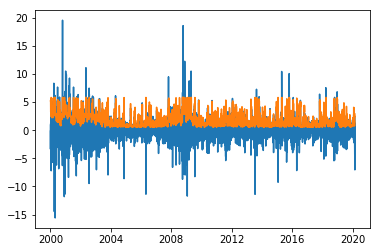

In [268]:
x = ret_data_enriched['dt']
y1 = ret_data_enriched['return100']
y2 = NN_obj.get_output()
plt.plot(x, y1)
plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

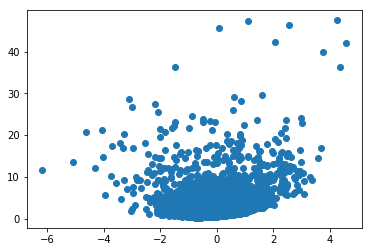

In [205]:
x = ret_data_enriched['mean5_return100']
y1 = NN_obj.get_output()
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

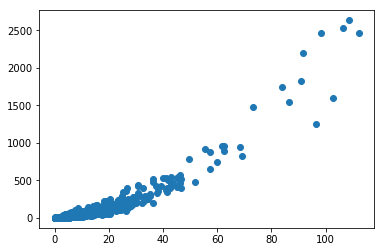

In [151]:
x = ret_data_enriched['var5_return100']
y1 = NN_obj.get_output()**2
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

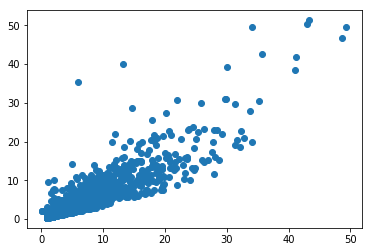

In [152]:
x = ret_data_enriched['garch']
y1 = NN_obj.get_output()
plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)
plt.show()

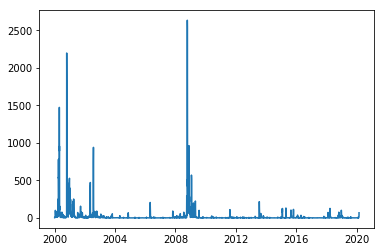

In [153]:
x = ret_data_enriched['dt']
y1 = ret_data_enriched['return100']
y2 = NN_obj.get_output() ** 2

plt.plot(x, y2)
plt.show()

In [41]:
NN_obj.get_weights()

[array([[ 1611837.73953872,   792260.24165044,  3004553.48070382,
          2317186.63723816,    26113.79160933],
        [ -636672.50907852,  -312940.81757742, -1186793.19034473,
          -915284.50135104,   -10314.20258629],
        [  218095.67899916,   107199.74056005,   406542.79422921,
           313535.79090393,     3534.01724127]]), array([[-386882.25280562],
        [ 250766.54755467],
        [ 354540.75900508],
        [-298564.0318481 ],
        [2000590.27145576]]), array([[1.]])]